In [1]:
import os
import pickle

import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from policy import config
from policy.dataset.ms2dataset import get_MS_loaders
from policy.checkpoints import CheckpointIO

model_dir = "/home/mrl/Documents/Projects/tskill/out/PegInsertion/Plan/008"

cfg_path = os.path.join(model_dir, "config.yaml")
# cfg_path = "/home/mrl/Documents/Projects/tskill/assets/skill/default.yaml"
cfg = config.load_config(cfg_path, None)

# Model
model = config.get_model(cfg, device="cpu")
checkpoint_io = CheckpointIO(model_dir, model=model)
load_dict = checkpoint_io.load("model_best.pt")
if cfg["method"] == "plan":
    vae = model.vae
else:
    vae = model
model.eval()

# Dataset
index_path = os.path.join(model_dir, "data_info.pickle")
with open(index_path, 'rb') as f:
    data_info = pickle.load(f)

cfg["data"]["pad"] = True
cfg["data"]["augment"] = False
cfg["data"]["augmentation"]["image_aug"] = False
cfg["data"]["augmentation"]["subsequence_rate"] = 1
cfg["data"]["full_seq"] = False

# Load only the full episode version of the dataset
if "train_ep_indices" not in data_info.keys():
    train_idx, val_idx = data_info["train_indices"], data_info["val_indices"]
else:
    train_idx, val_idx = data_info["train_ep_indices"], data_info["val_ep_indices"]
train_dataset, val_dataset = get_MS_loaders(cfg, return_datasets=True, 
                                            fullseq_override=True,
                                            save_override=True)

/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mrl/anaconda3/envs/tskill/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_We

freezing state encoder network!
/home/mrl/Documents/Projects/tskill/out/PegInsertion/VAE/053/model_best.pt
=> Loading checkpoint from local file...
load state dict: <All keys matched successfully>
Freezing state encoder network!
/home/mrl/Documents/Projects/tskill/out/PegInsertion/Plan/008/model_best.pt
=> Loading checkpoint from local file...
load state dict: <All keys matched successfully>
Found existing data info file
Loading indices from file: out/PegInsertion/Plan/008/data_info.pickle
Overriding full seq config!
Loading action and state scaling from file
Adding batch dimension to returned data!


In [2]:
train = True
if not train:
    dataset = val_dataset
    print("Using Validation Dataset")
    idxs = val_idx
else:
    dataset = train_dataset
    print("Using Training Dataset")
    idxs = train_idx


class AttentionHook:
    def __init__(self):
        self.attention_weights = []
        self.attention = []
        self.inputs = []

    def __call__(self, module, input, output):
        self.attention.append(output[0])
        self.attention_weights.append(output[1])
        self.inputs.append(input)


def visualize_attention_weights(attention_weights, layer_name, layer_num, attn):
    avg_attention = attention_weights.mean(dim=0).abs().detach().cpu().numpy()
    print(avg_attention.shape)
    fig = plt.figure(figsize=(20, 20))
    sns.heatmap(avg_attention, annot=False, cmap='YlGnBu')
    ax = fig.axes[0]
    plt.xlabel('Input Sequence')
    plt.ylabel('Input Sequence')
    plt.title(f'{layer_name} Layer {layer_num} {attn} Attention Weight Visualization')
    
    # plt.xticks(range(avg_attention.shape[1]), range(avg_attention.shape[1]), rotation=90)
    ax.xaxis.set_major_locator(MultipleLocator(avg_attention.shape[0]/6))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(avg_attention.shape[1]/6))
    ax.yaxis.set_major_formatter('{x:.0f}')
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    
    plt.tight_layout()
    plt.show()

def visualize_attention(attention, input_len, layer_name, layer_num, attn):
    avg_attention = attention.mean(dim=-1).abs().squeeze().detach().cpu().numpy()
    if len(avg_attention.shape) != 0:
        print(avg_attention.shape)
        plt.figure(figsize=(20, 10))
        sns.barplot(avg_attention)
        
        plt.xlabel('Input Sequence')
        plt.ylabel('Attention')
        plt.title(f'{layer_name} Layer {layer_num} {attn} Attention Visualization')
        
        plt.xticks(range(input_len), range(input_len), rotation=90)
        
        plt.tight_layout()
        plt.show()

# Register hooks
dec_enc_hooks = []
dec_dec_hooks = []
enc_enc_hooks = []
enc_dec_hooks = []

for i, layer in enumerate(vae.decoder.encoder.layers):
    hook = AttentionHook()
    hook.name = "SA"
    layer.self_attn.register_forward_hook(hook)
    dec_enc_hooks.append(hook)

for i, layer in enumerate(vae.decoder.decoder.layers):
    hook1 = AttentionHook()
    hook1.name = "SA"
    hook2 = AttentionHook()
    hook2.name = "MHA"
    layer.self_attn.register_forward_hook(hook1)
    layer.multihead_attn.register_forward_hook(hook2)
    dec_dec_hooks.append(hook1)
    dec_dec_hooks.append(hook2)

for i, layer in enumerate(vae.encoder.encoder.layers):
    hook = AttentionHook()
    hook.name = "SA"
    layer.self_attn.register_forward_hook(hook)
    enc_enc_hooks.append(hook)

for i, layer in enumerate(vae.encoder.decoder.layers):
    hook1 = AttentionHook()
    hook1.name = "SA"
    hook2 = AttentionHook()
    hook2.name = "MHA"
    layer.self_attn.register_forward_hook(hook1)
    layer.multihead_attn.register_forward_hook(hook2)
    enc_dec_hooks.append(hook1)
    enc_dec_hooks.append(hook2)

if cfg["method"] == "plan":
    tf_enc_hooks = []
    tf_dec_hooks = []

    for i, layer in enumerate(model.transformer.encoder.layers):
        hook = AttentionHook()
        hook.name = "SA"
        layer.self_attn.register_forward_hook(hook)
        tf_enc_hooks.append(hook)

    for i, layer in enumerate(model.transformer.decoder.layers):
        hook1 = AttentionHook()
        hook1.name = "SA"
        hook2 = AttentionHook()
        hook2.name = "MHA"
        layer.self_attn.register_forward_hook(hook1)
        layer.multihead_attn.register_forward_hook(hook2)
        tf_dec_hooks.append(hook1)
        tf_dec_hooks.append(hook2)

Using Training Dataset


(129, 129)


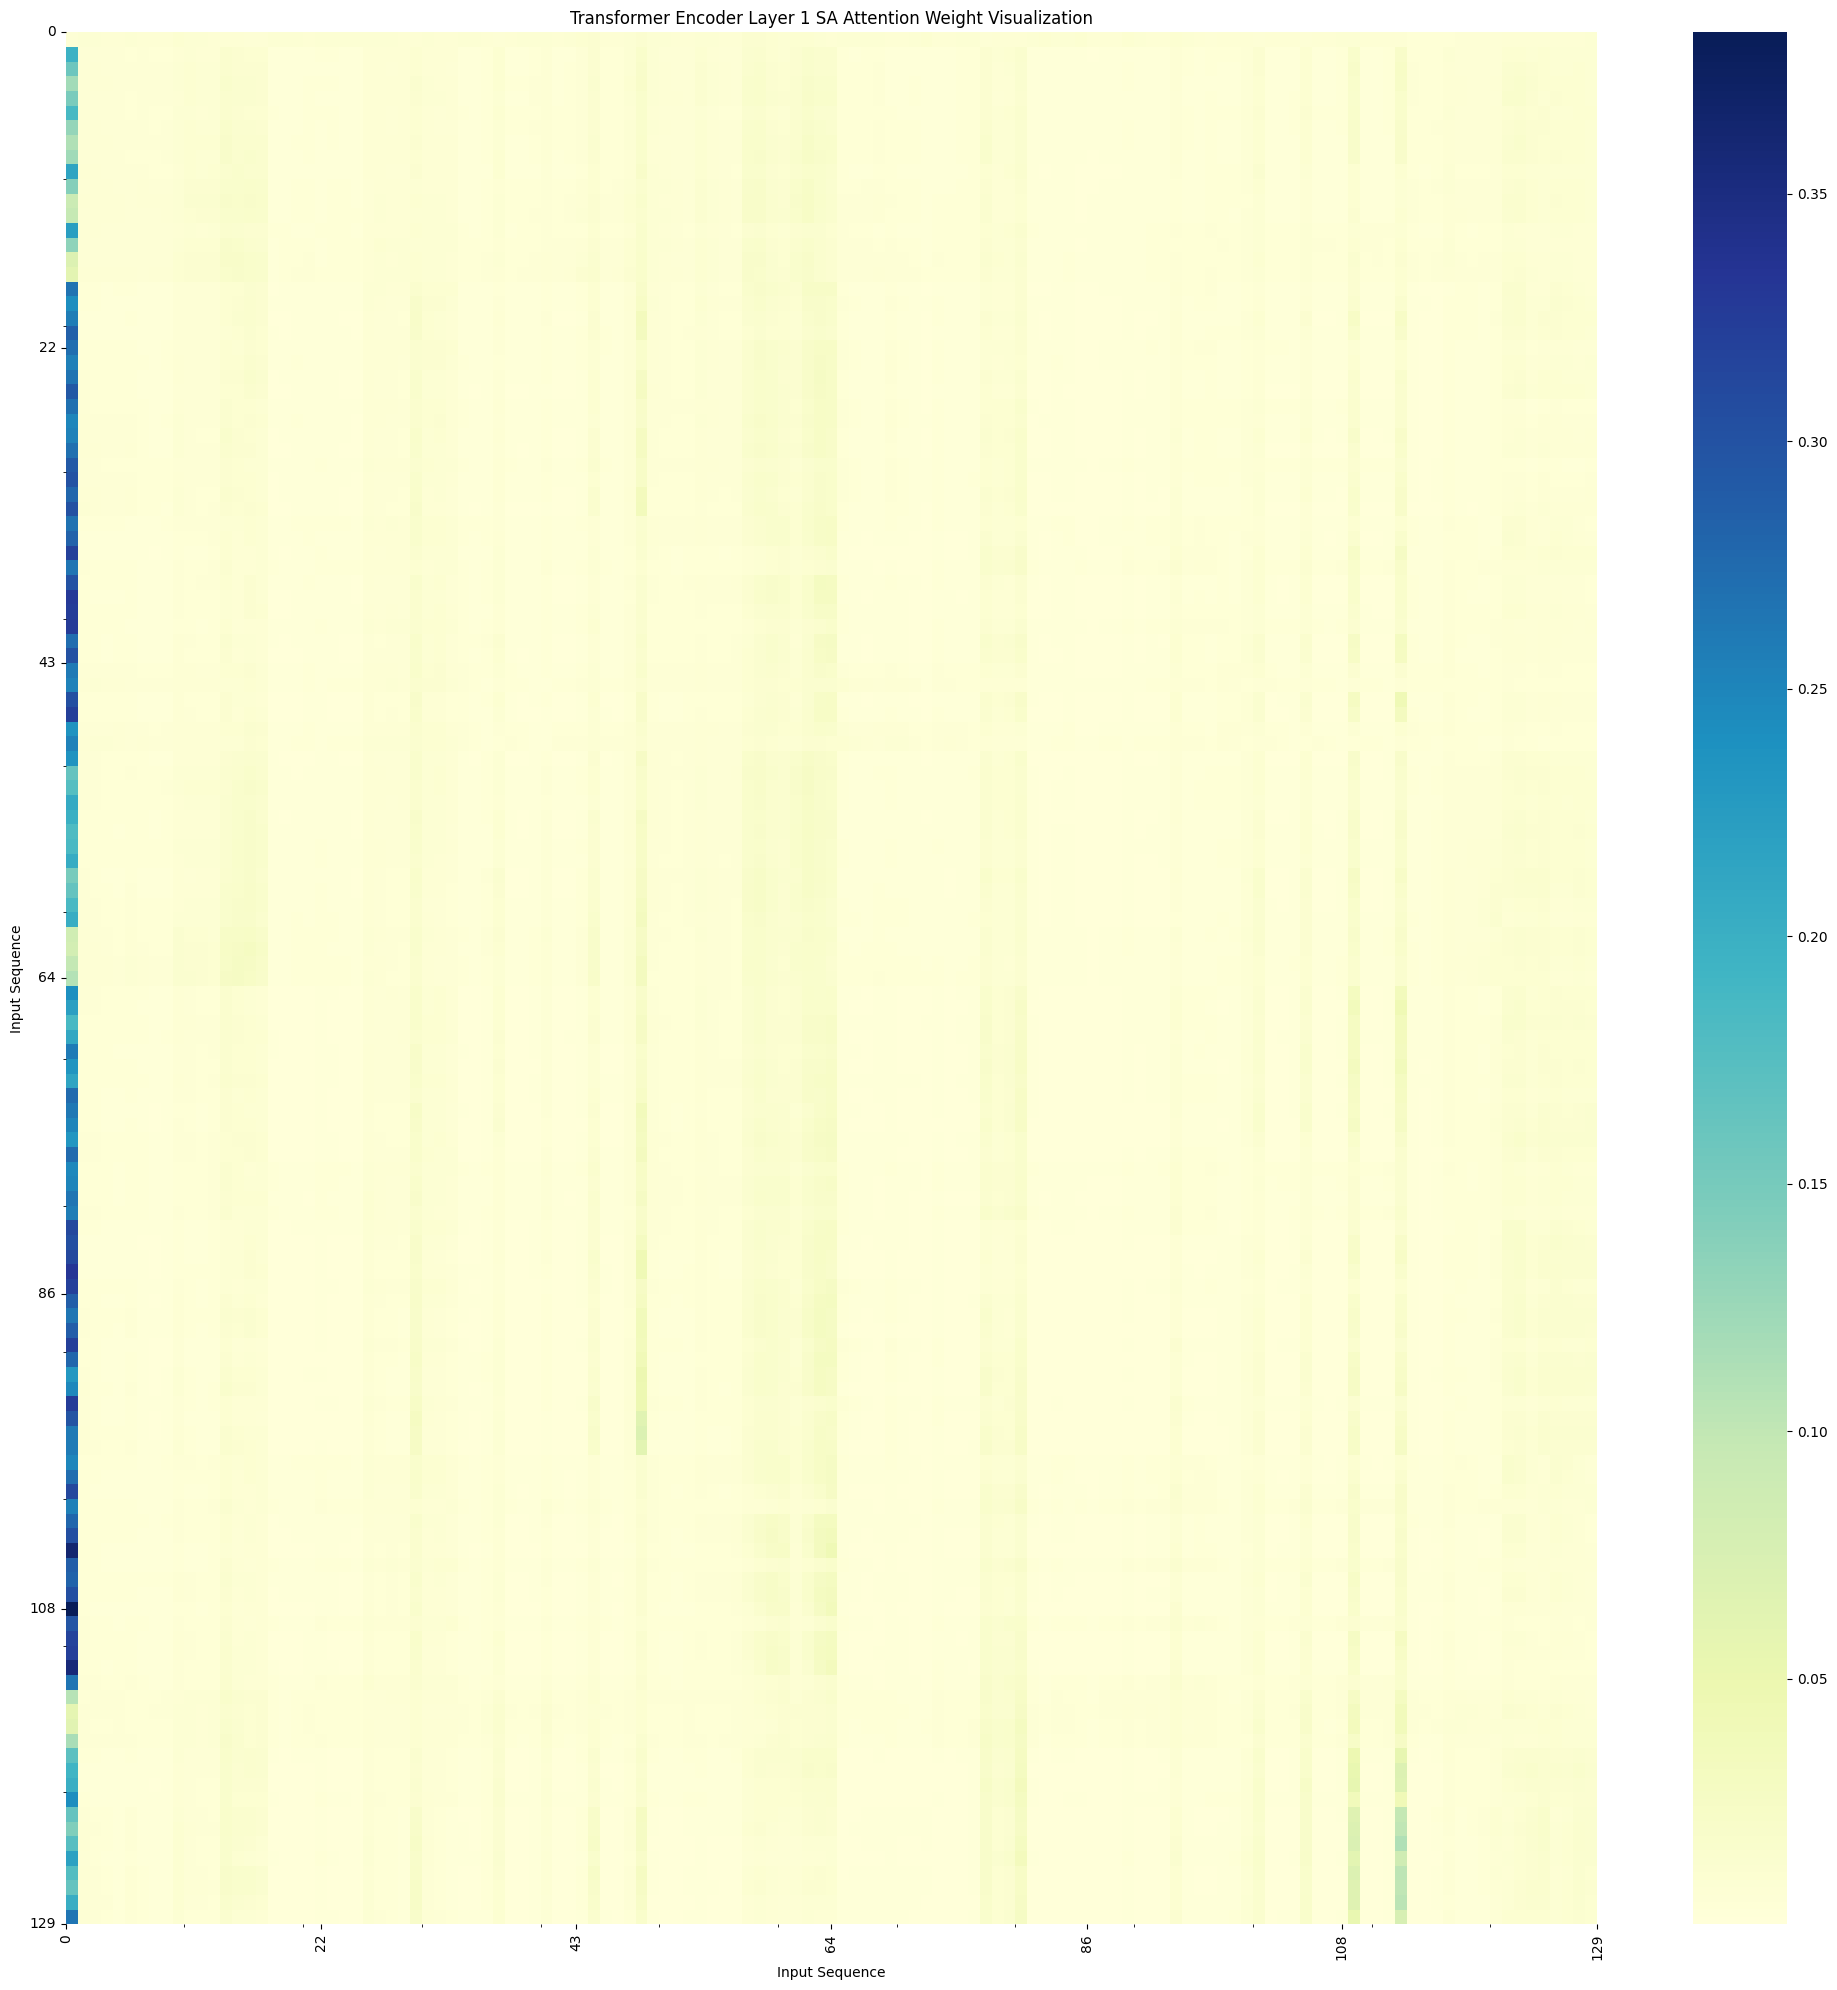

(129, 129)


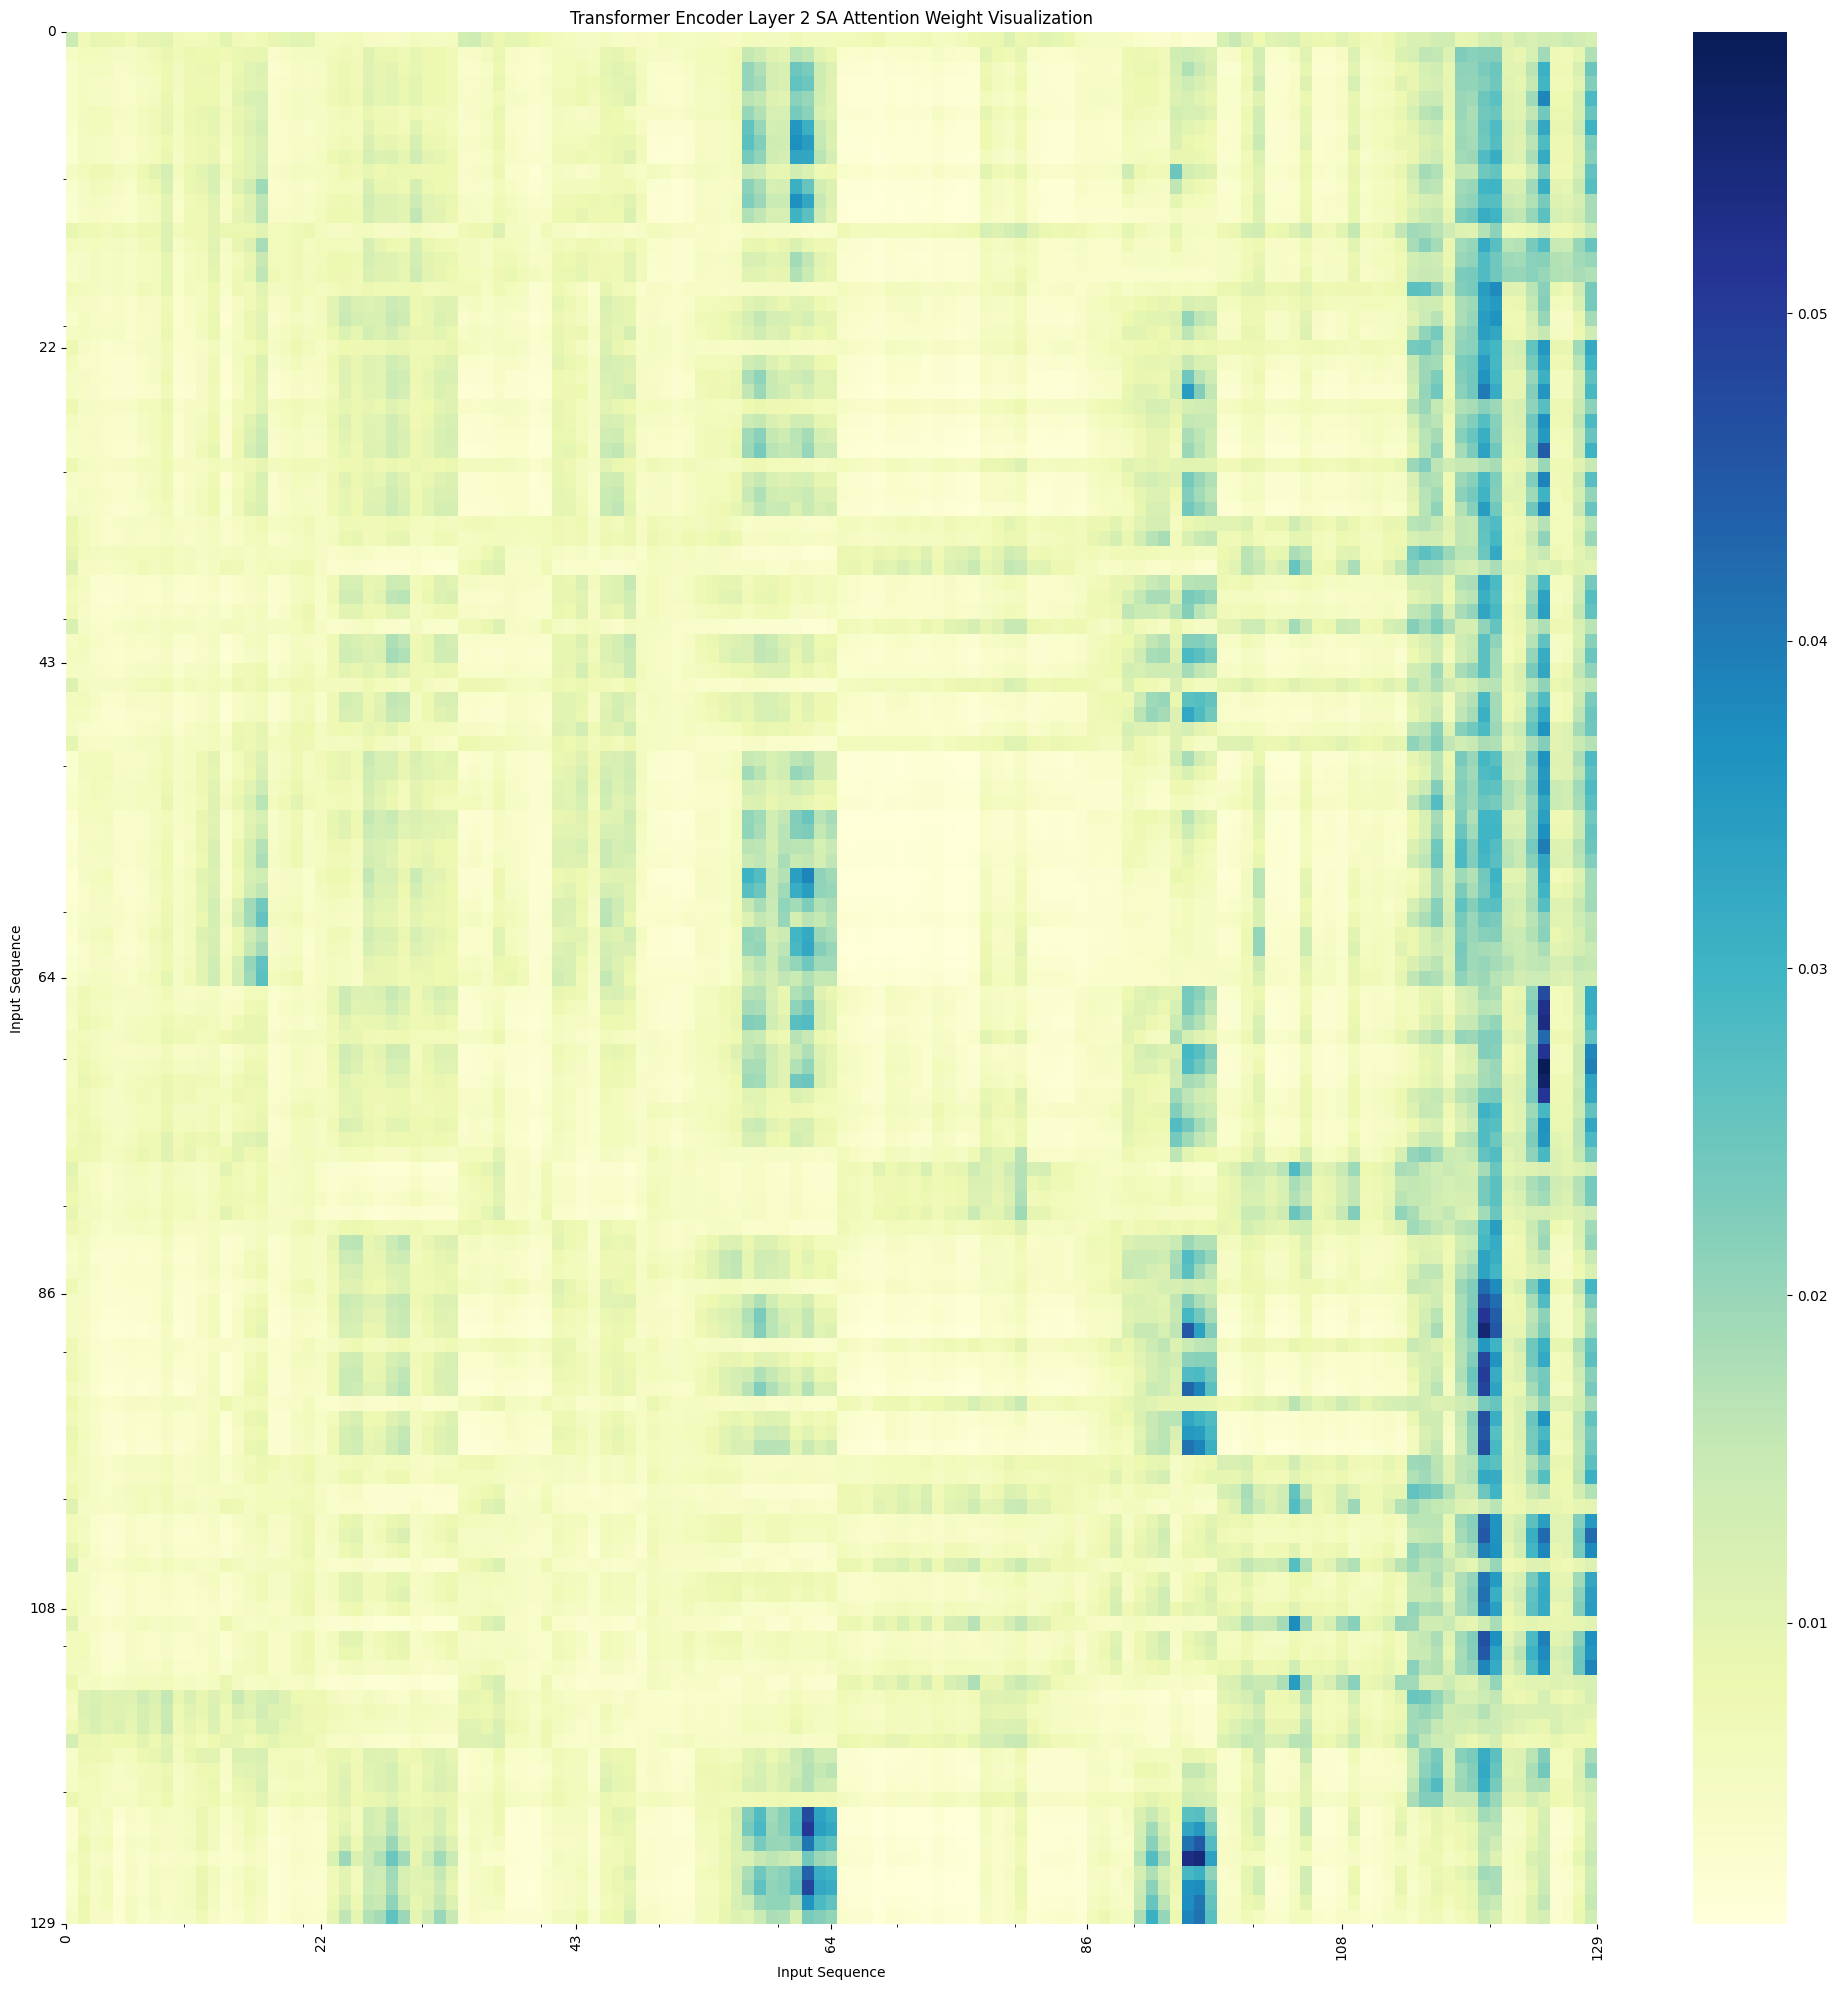

(129, 129)


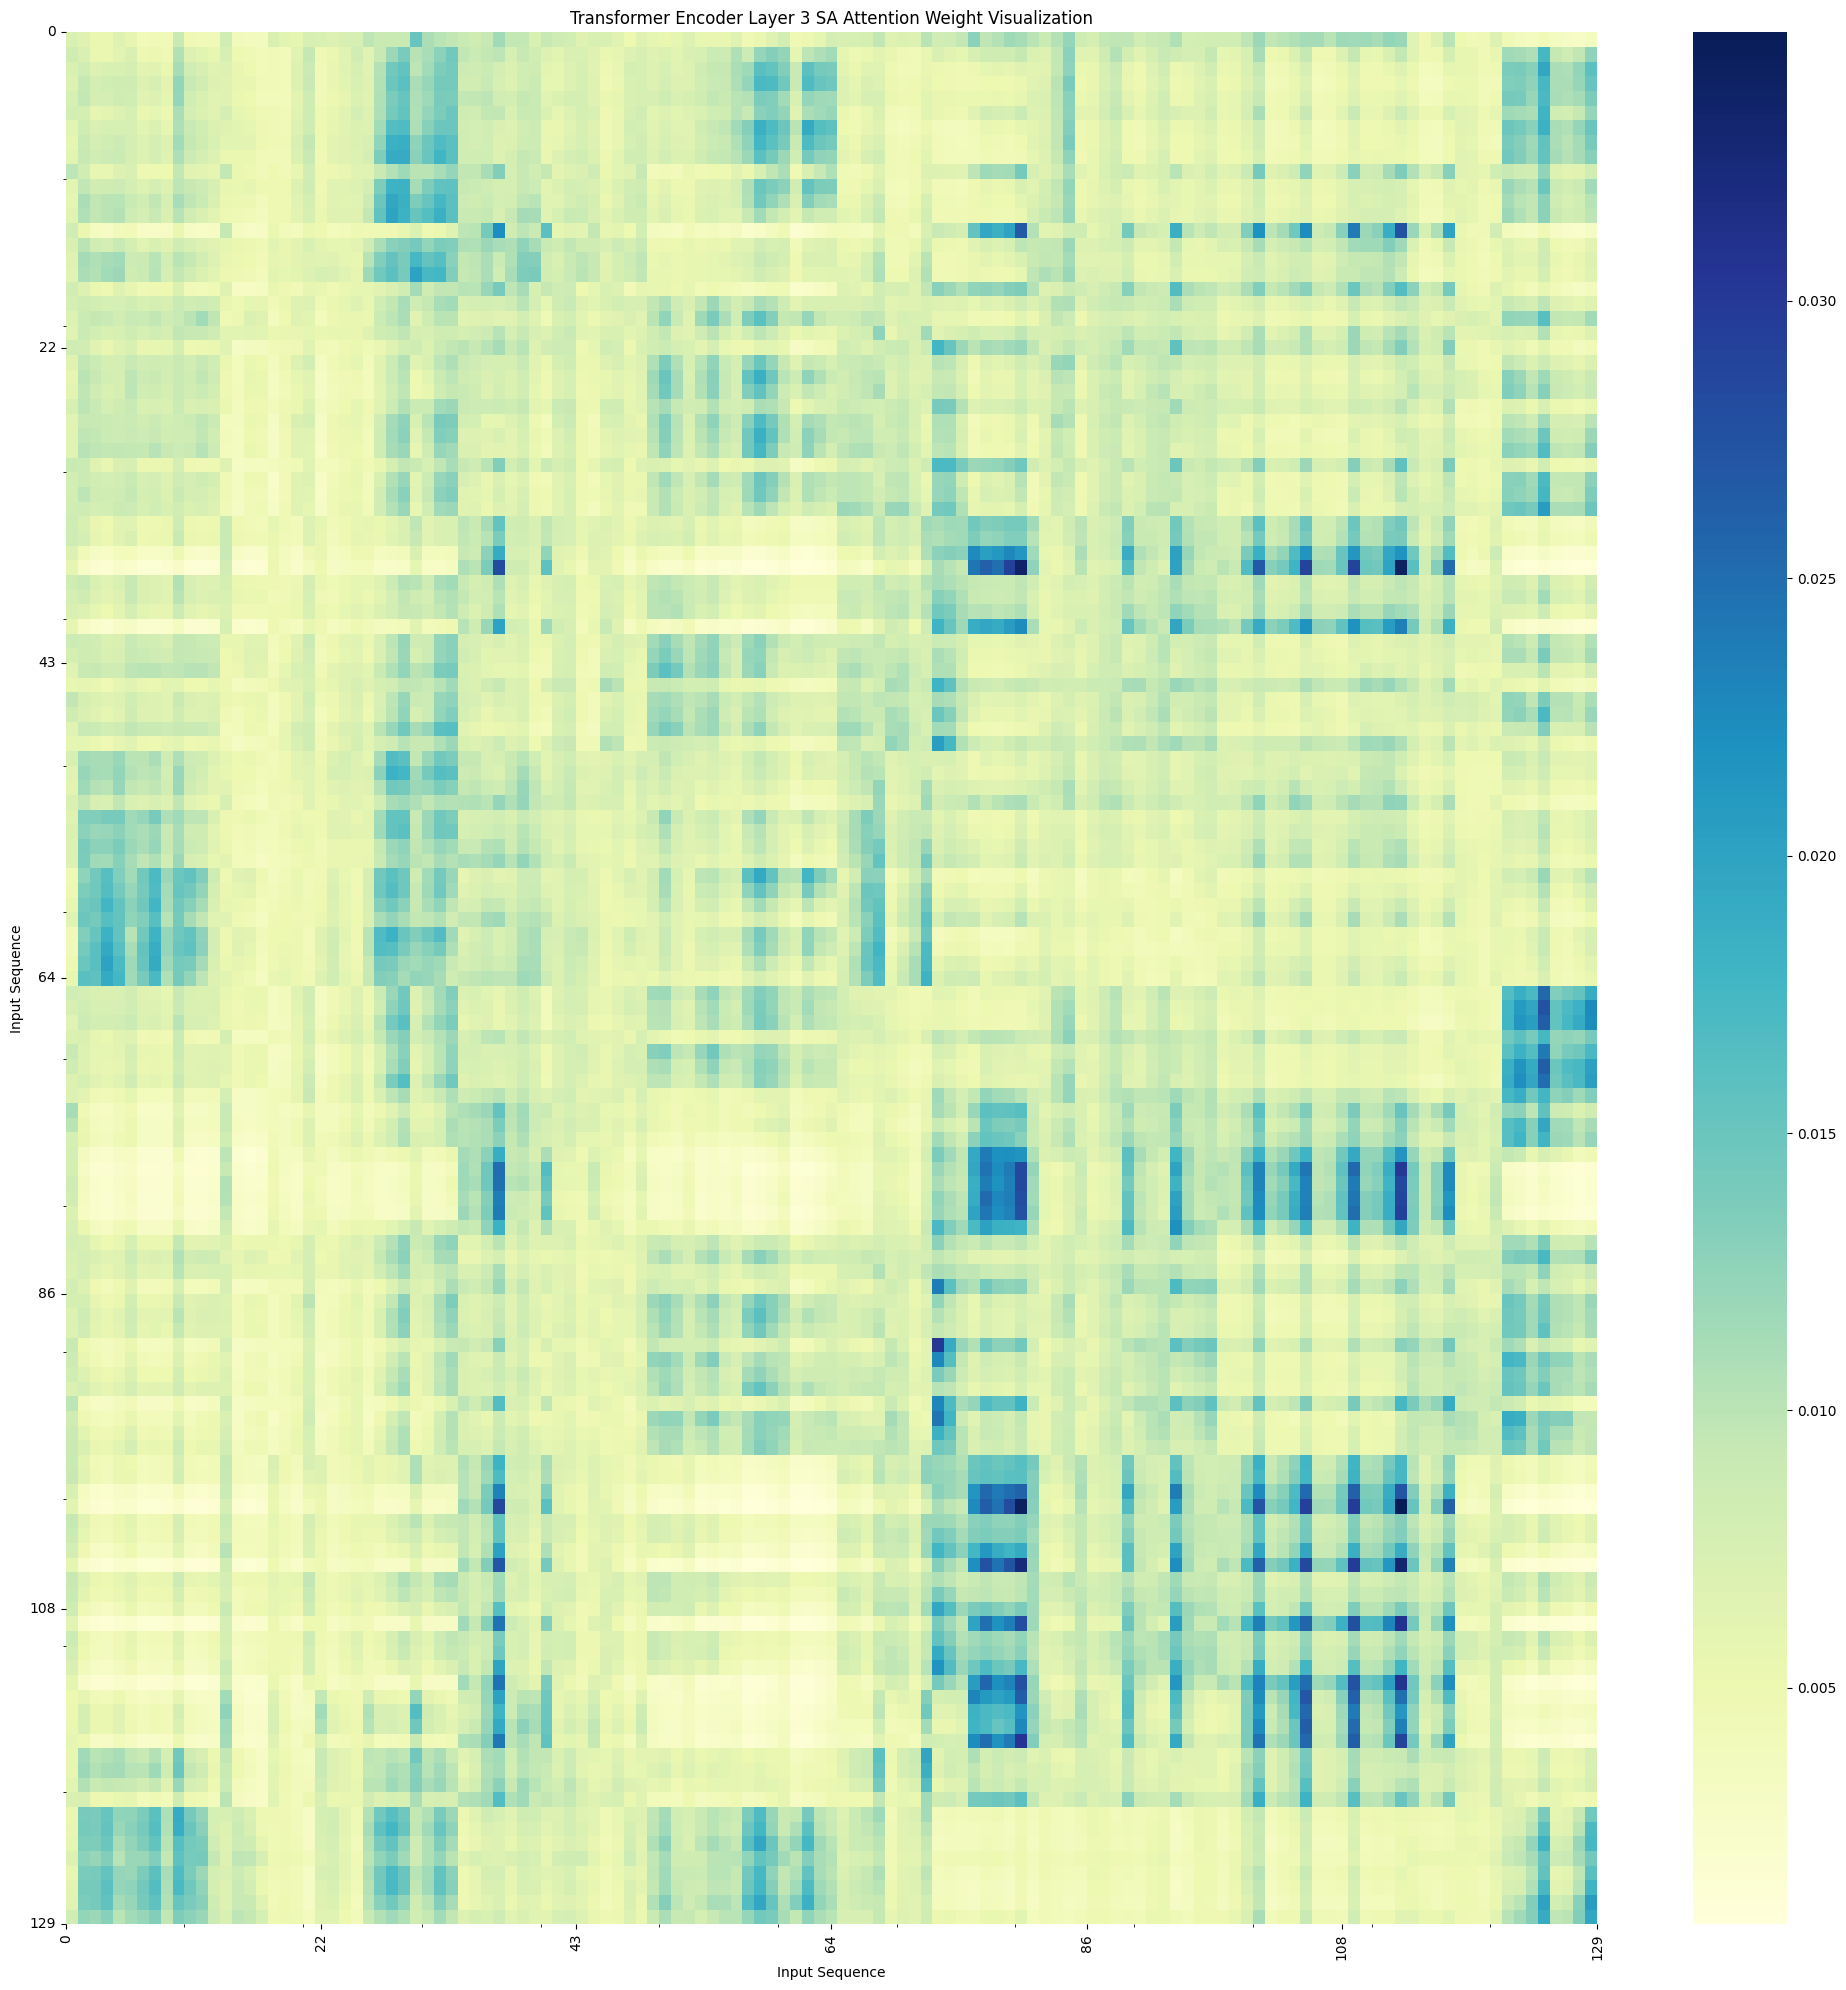

(129, 129)


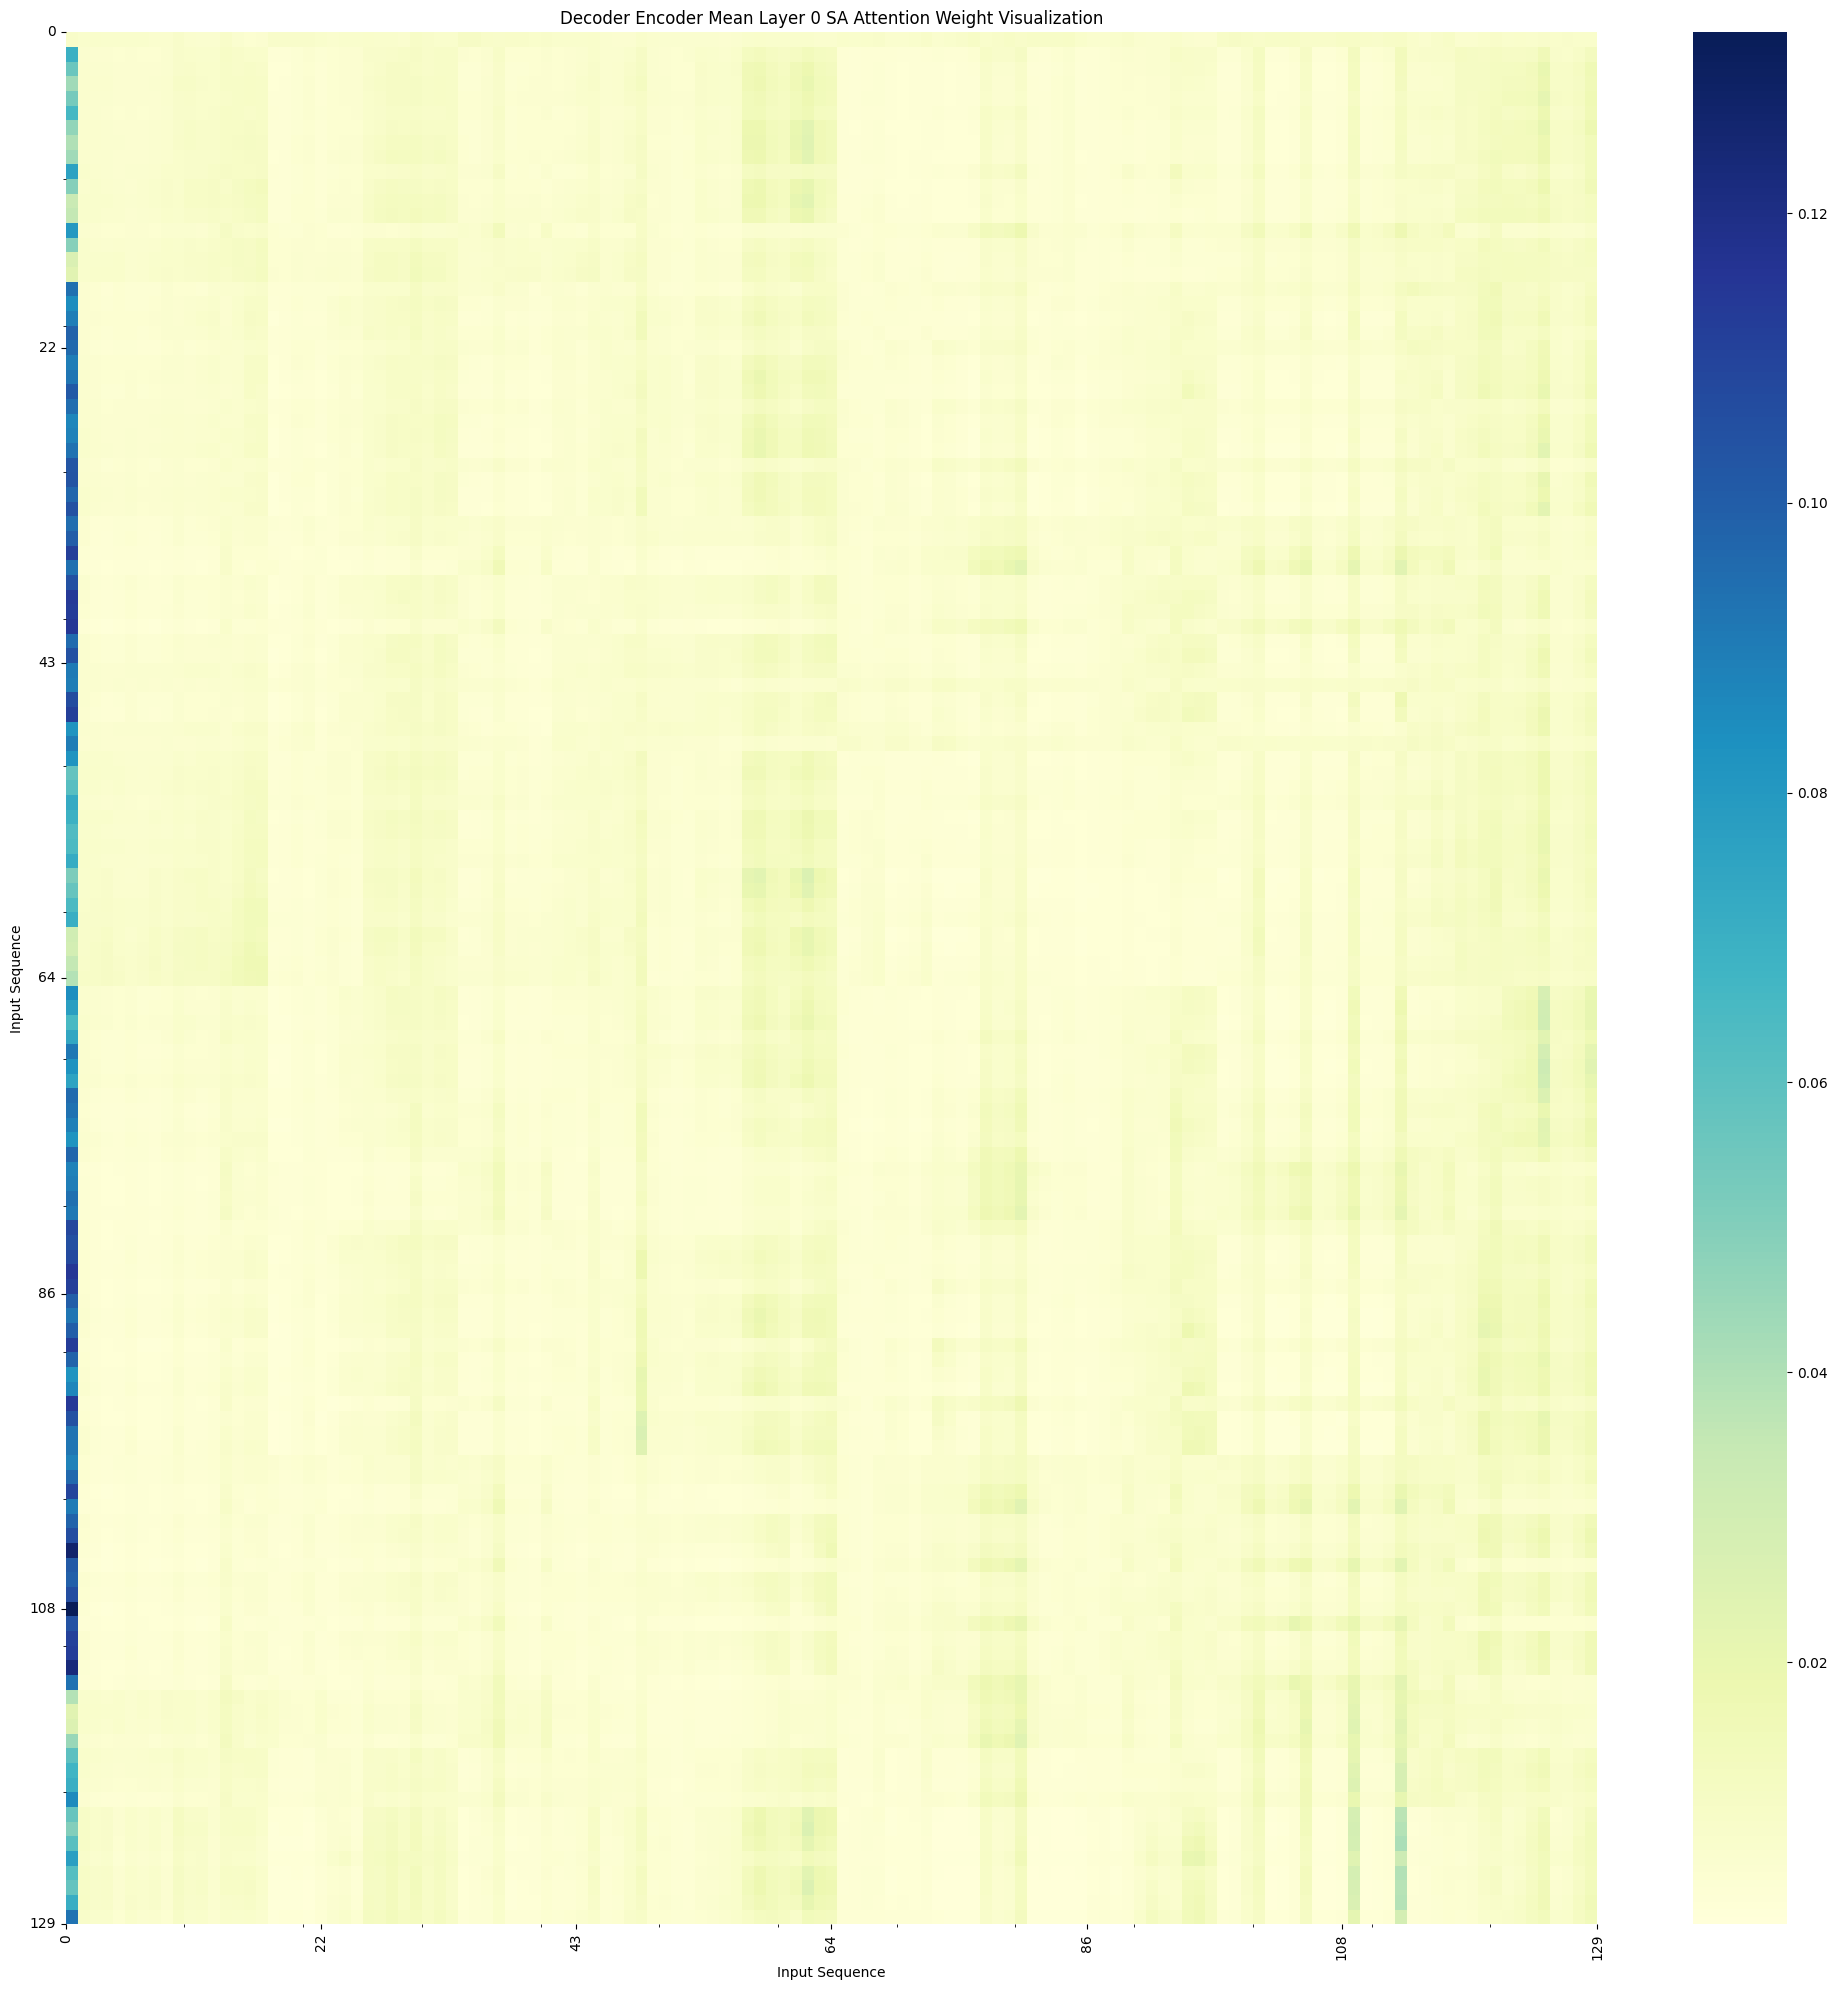

(20, 20)


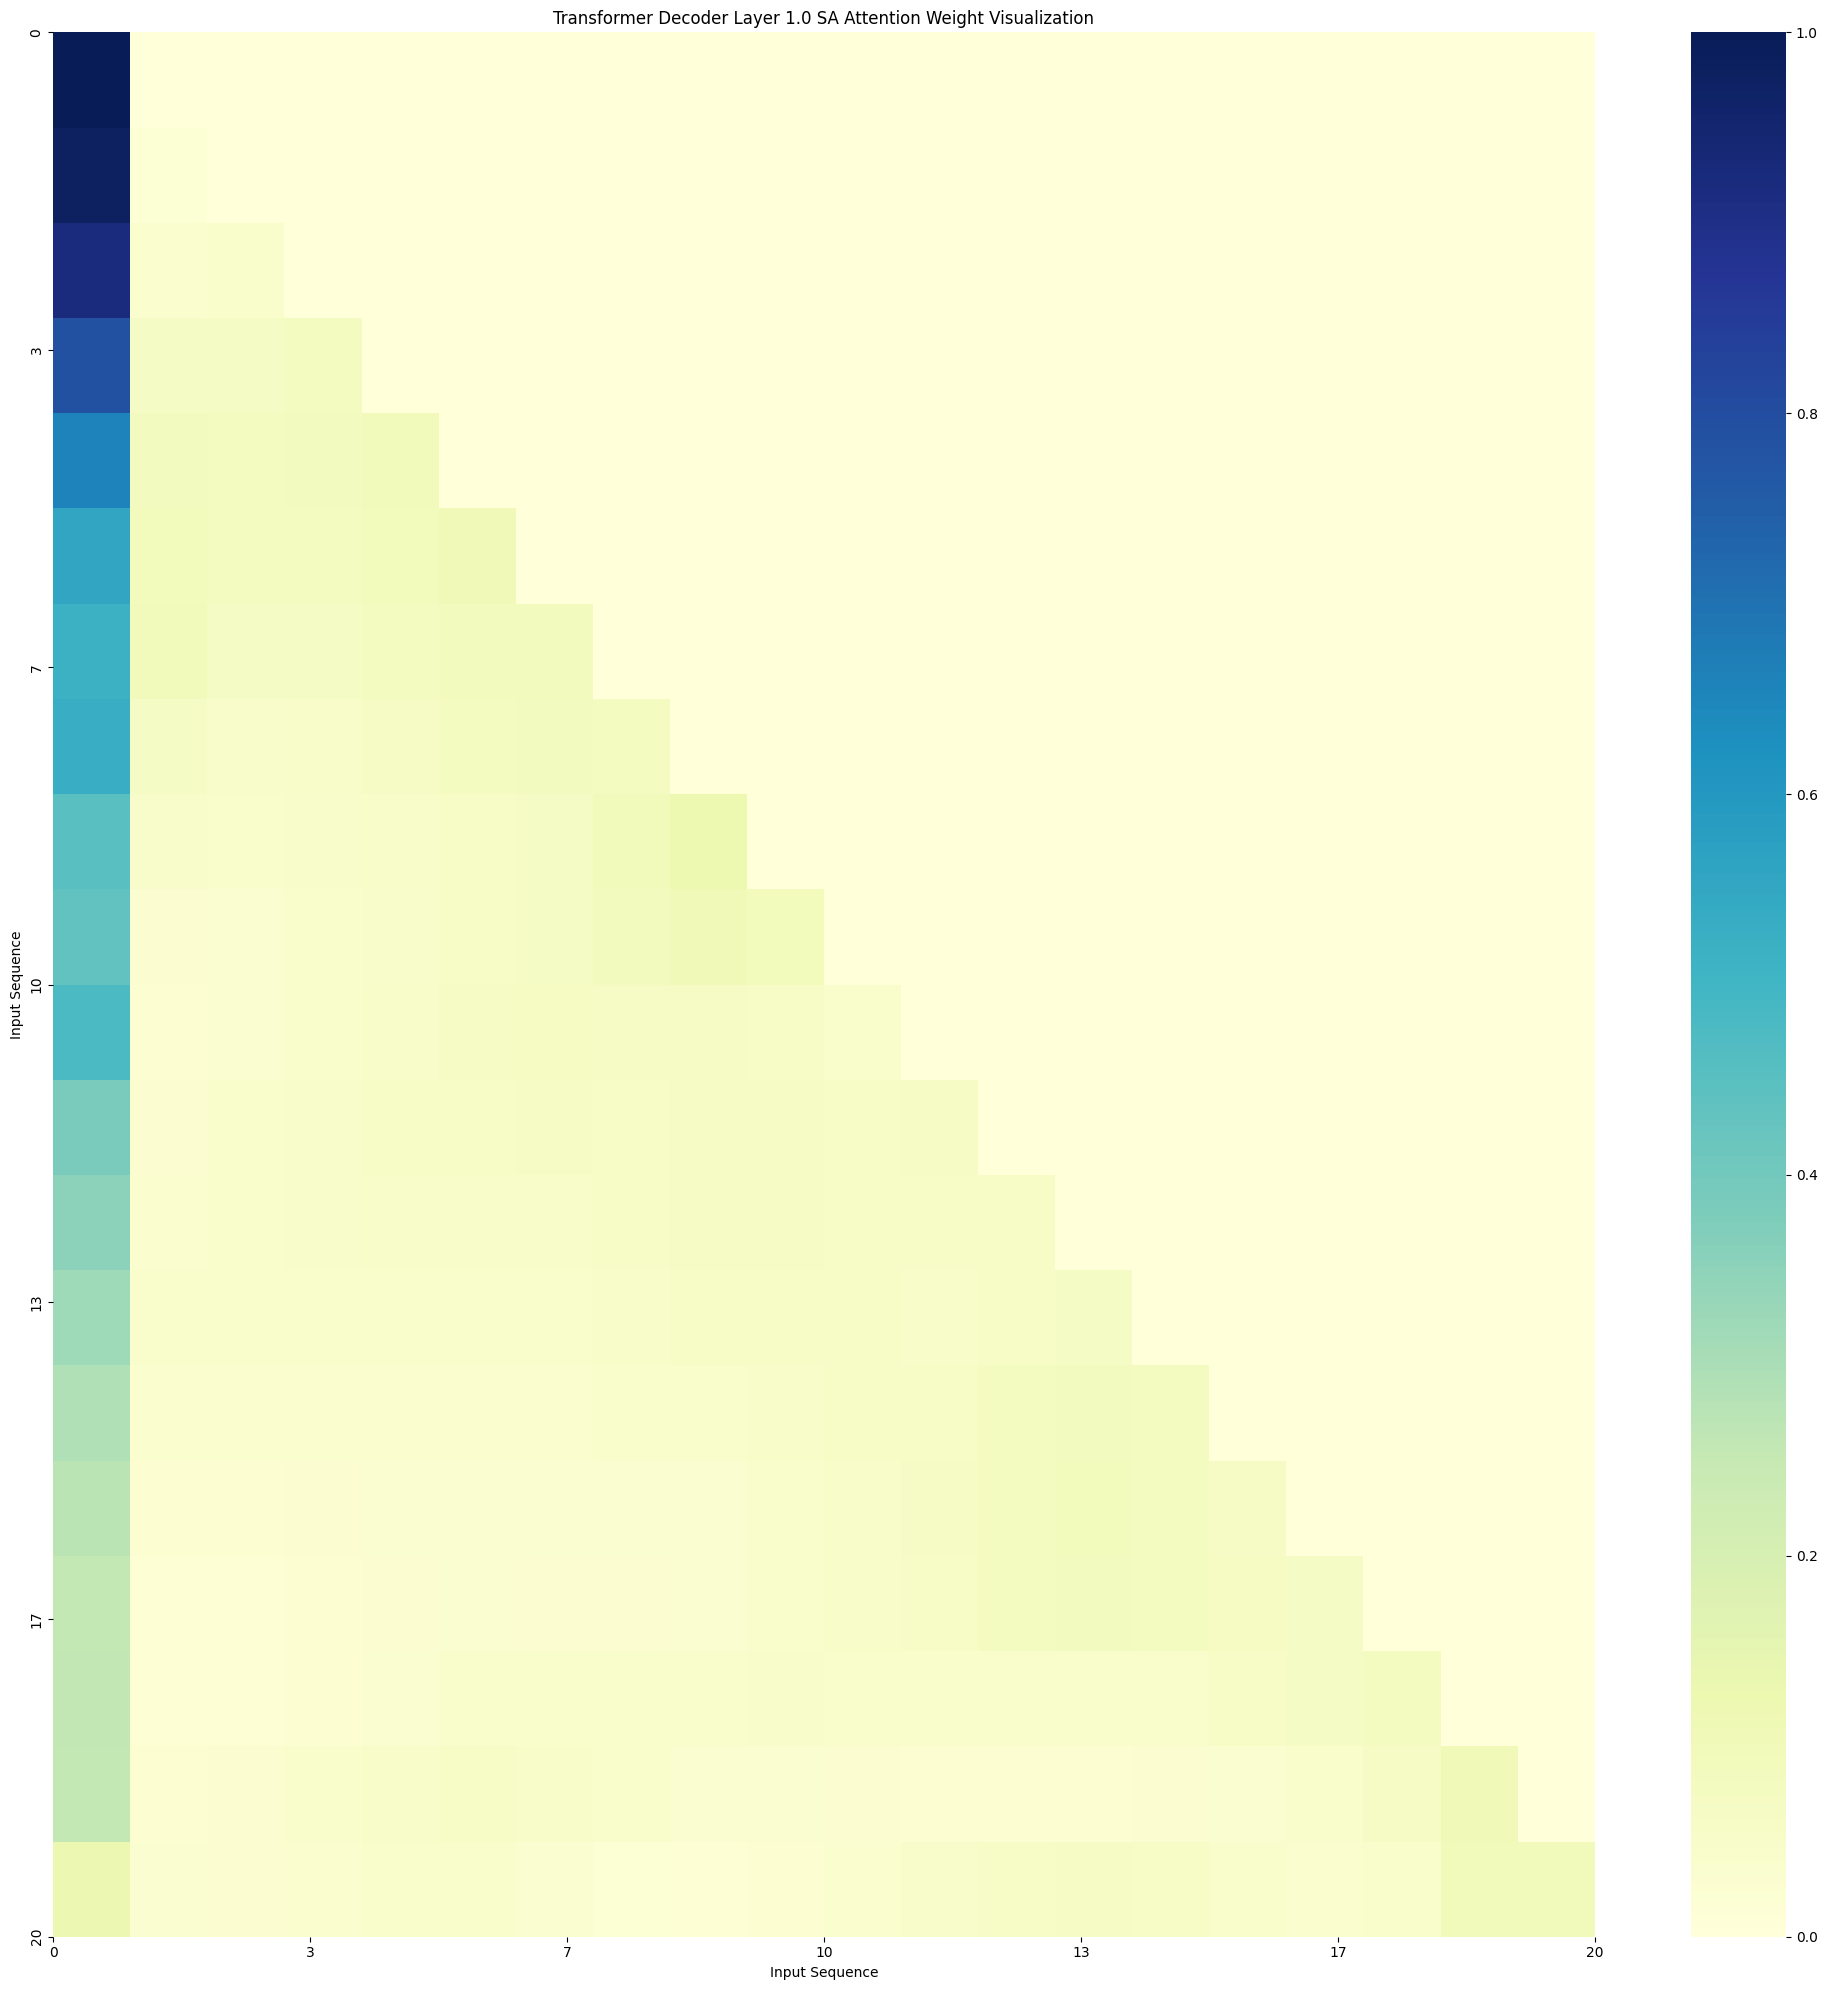

(20, 129)


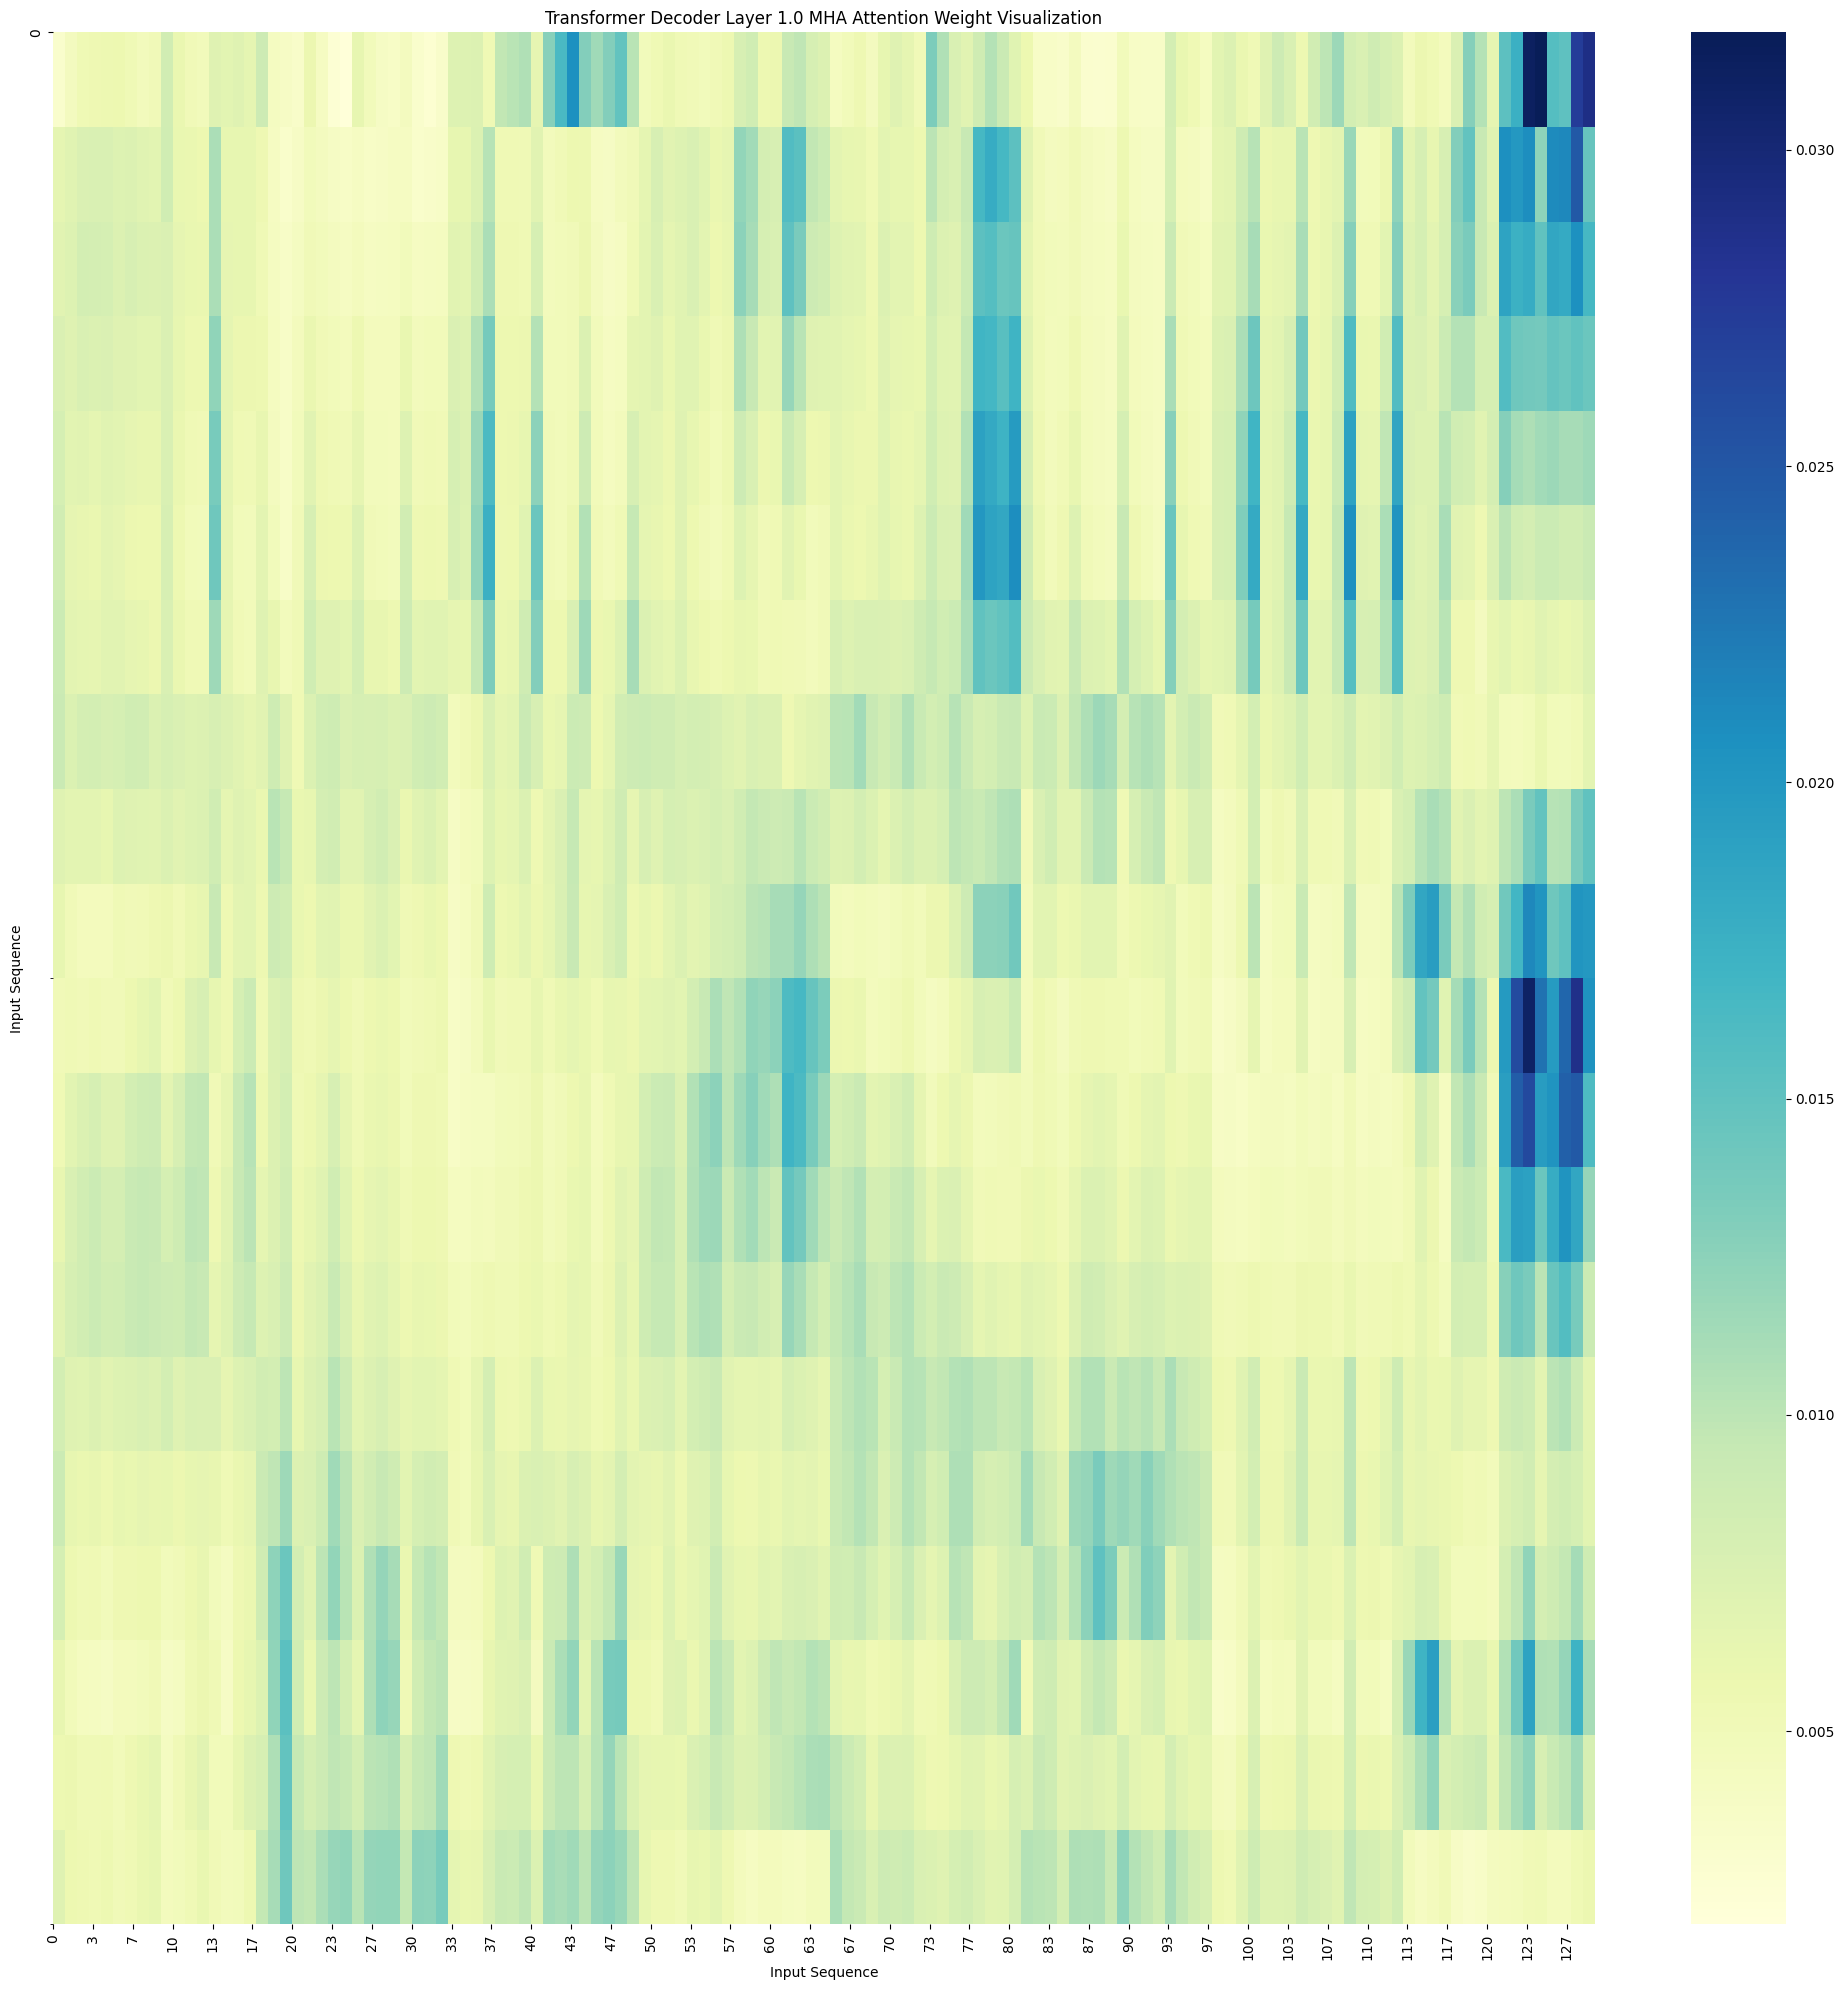

(20, 20)


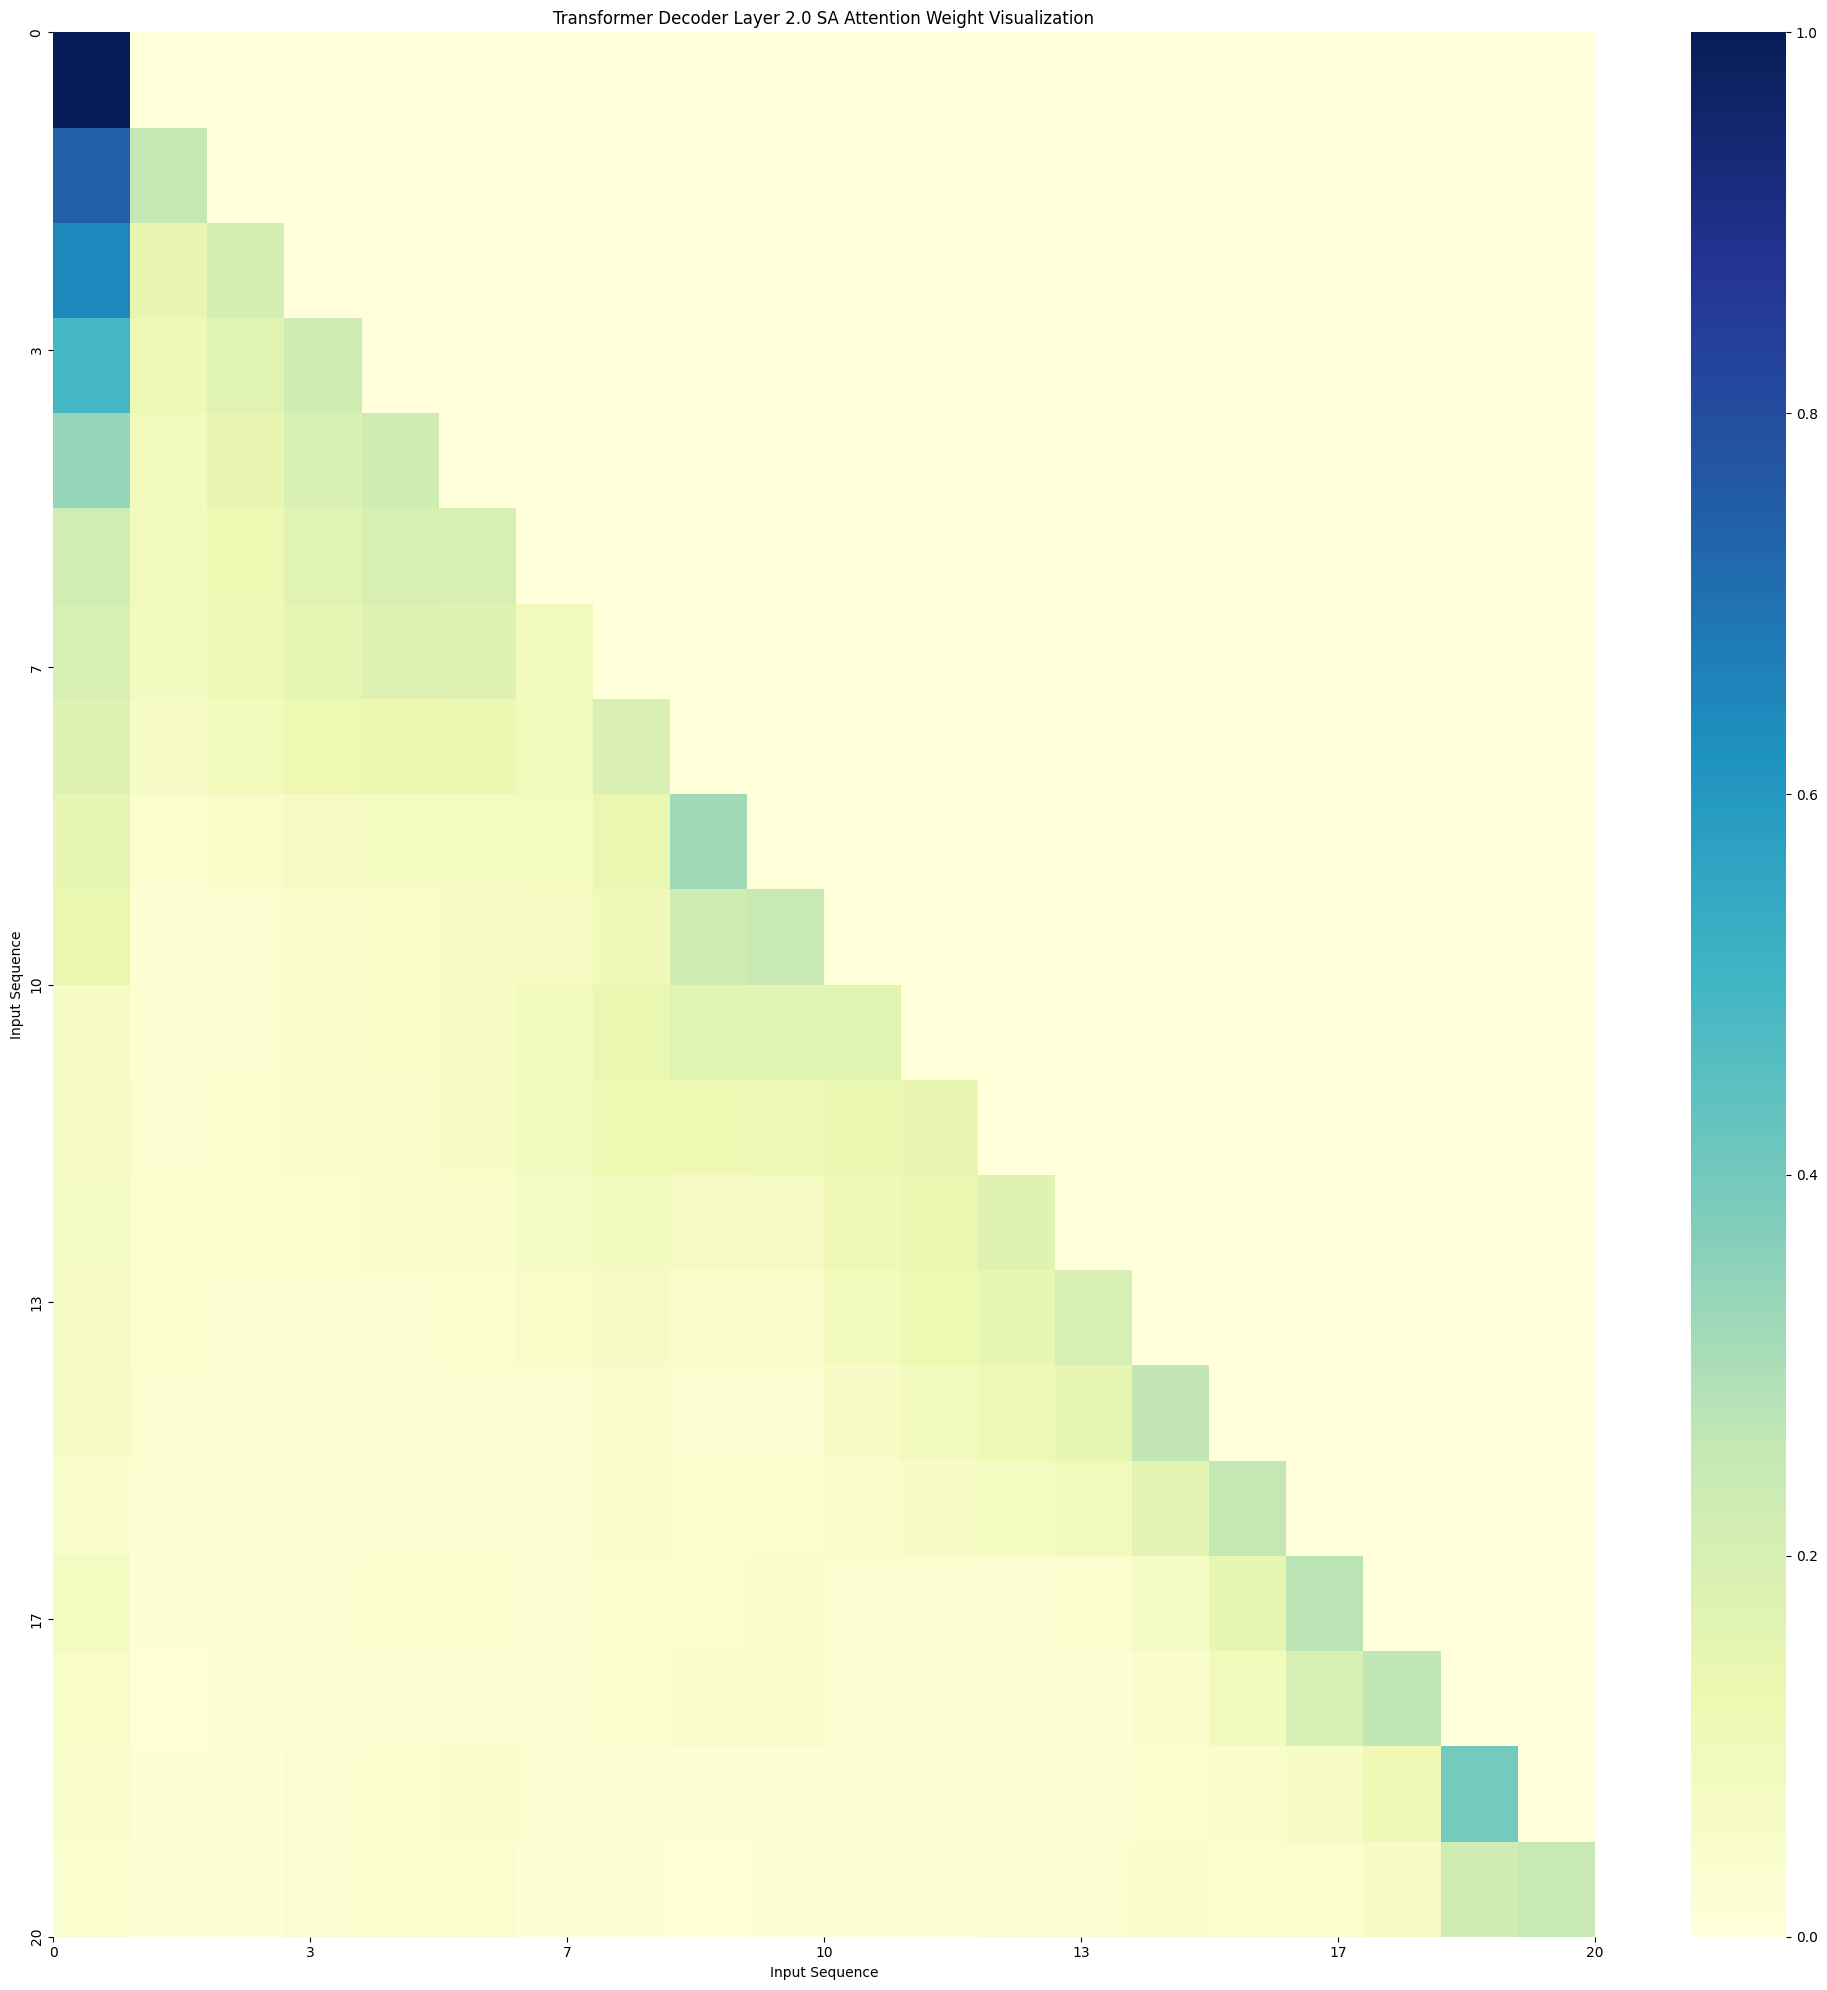

(20, 129)


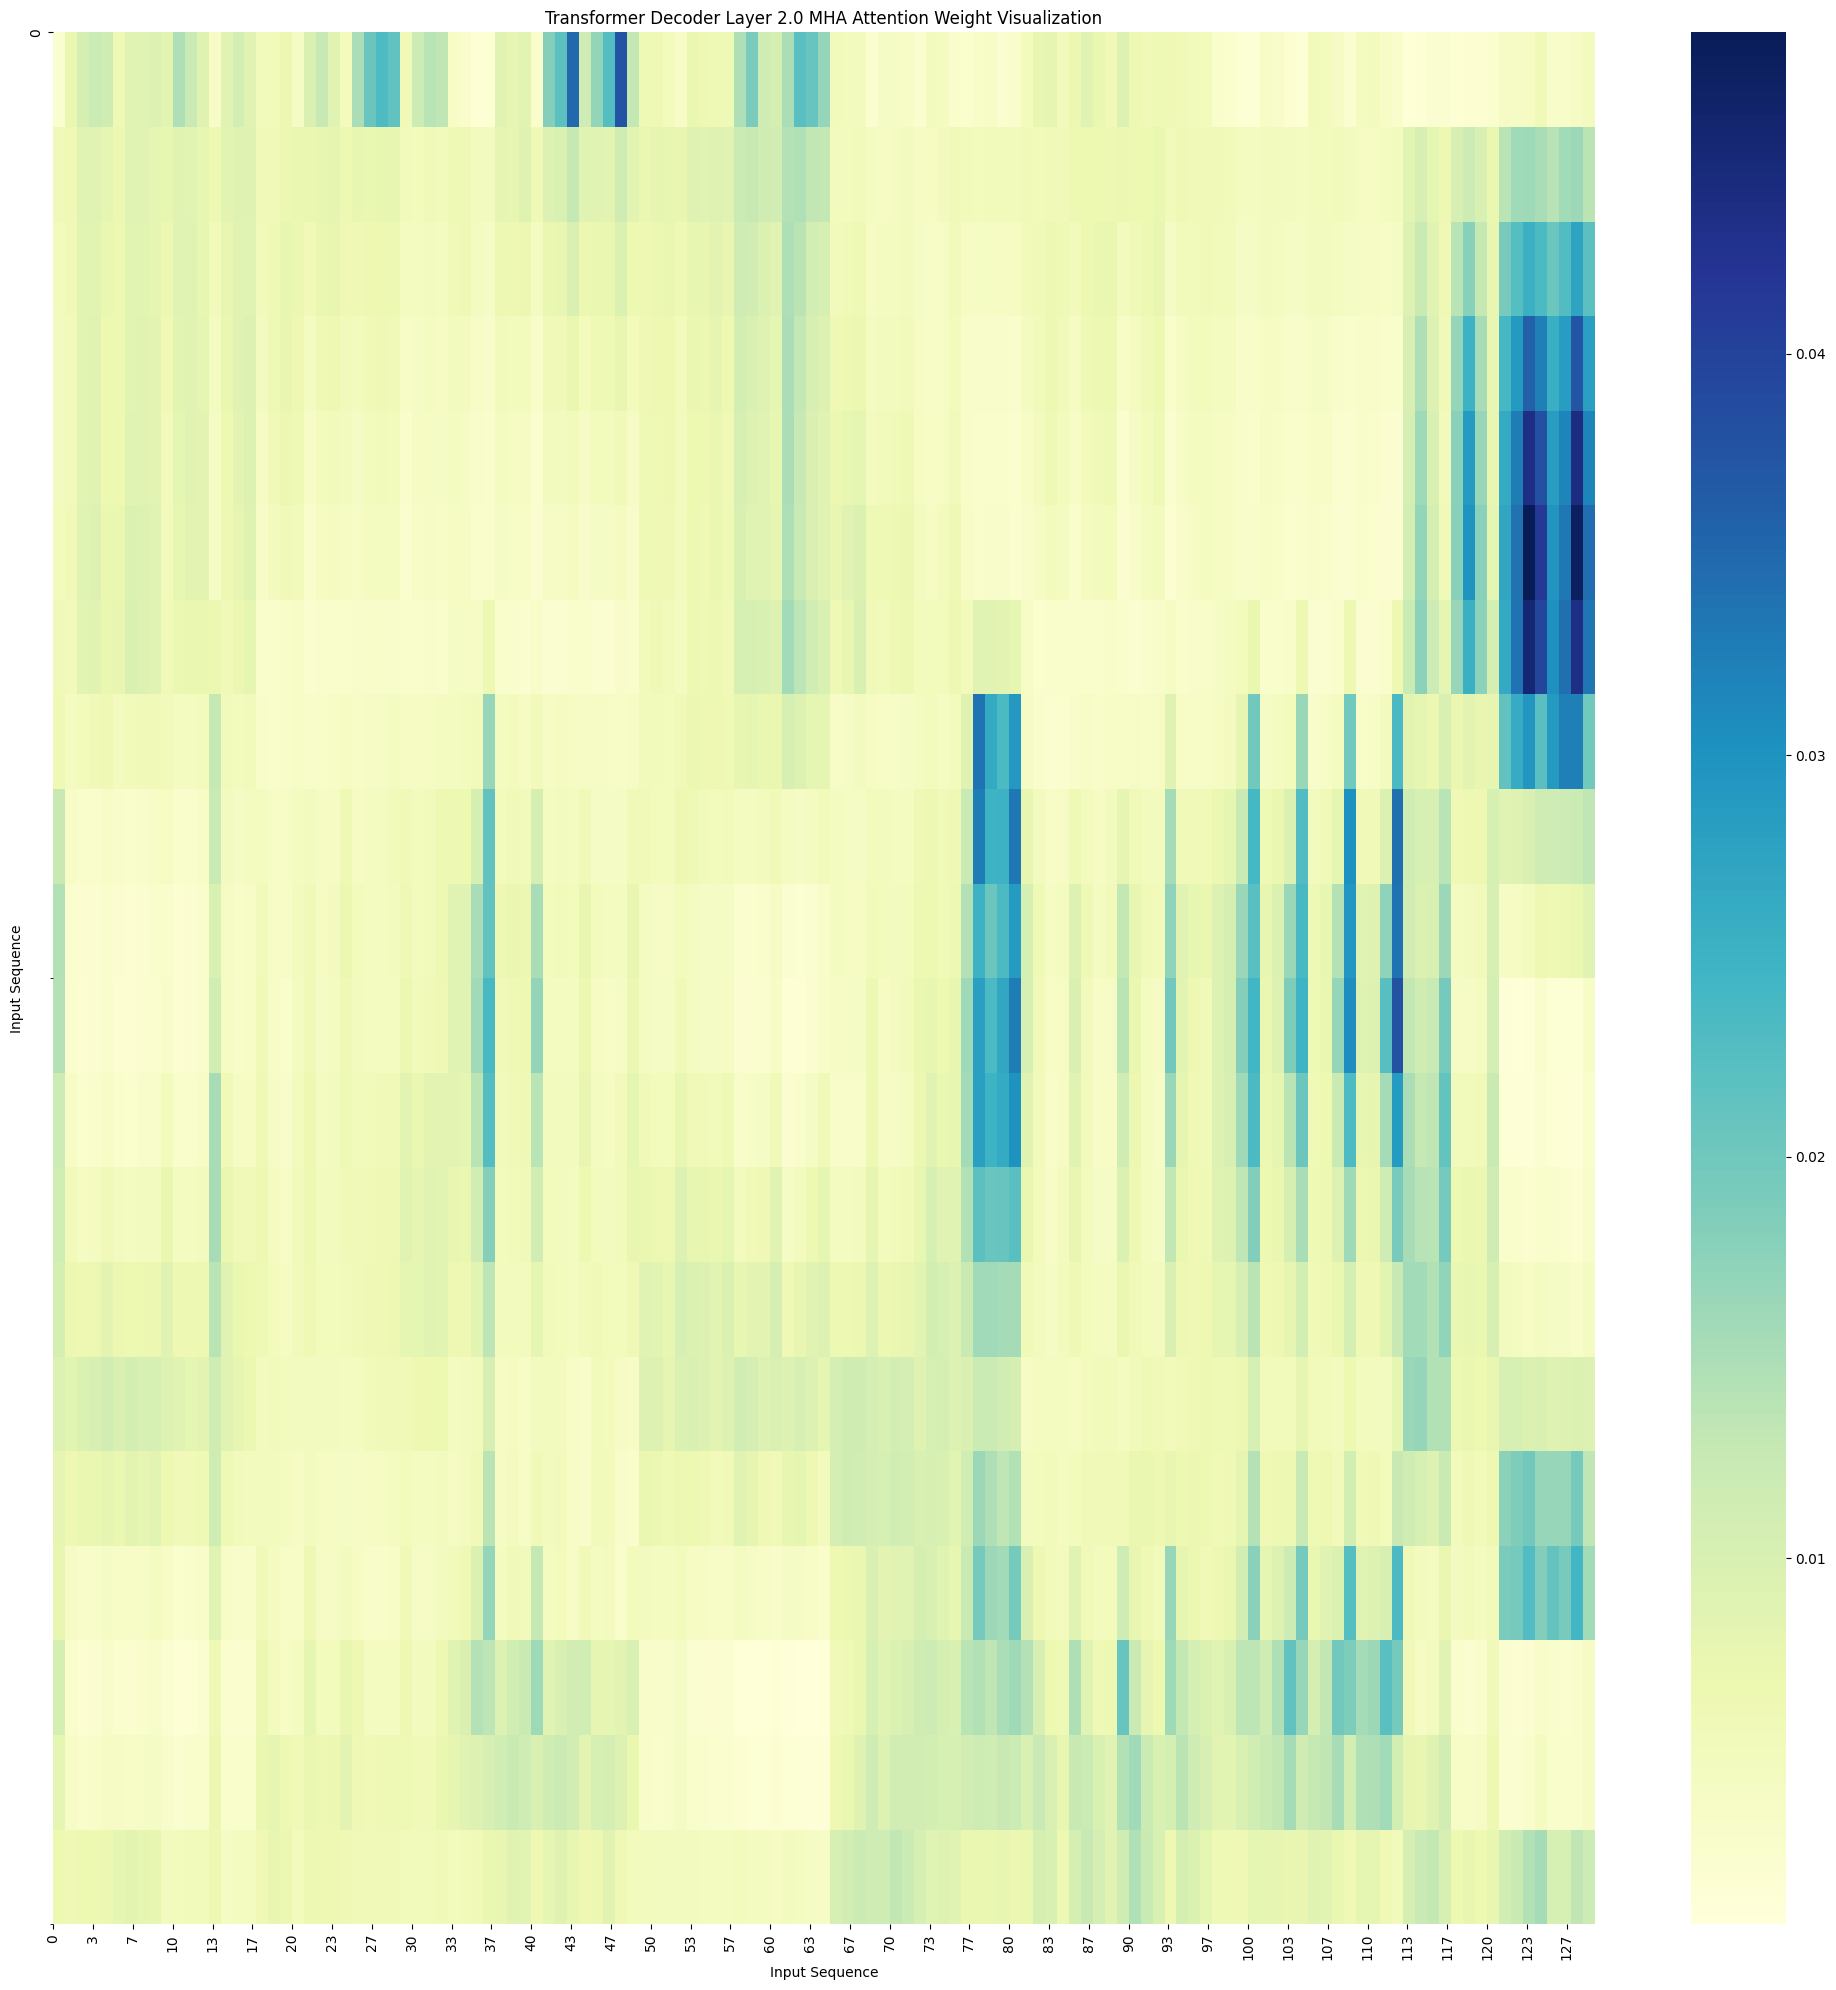

(20, 20)


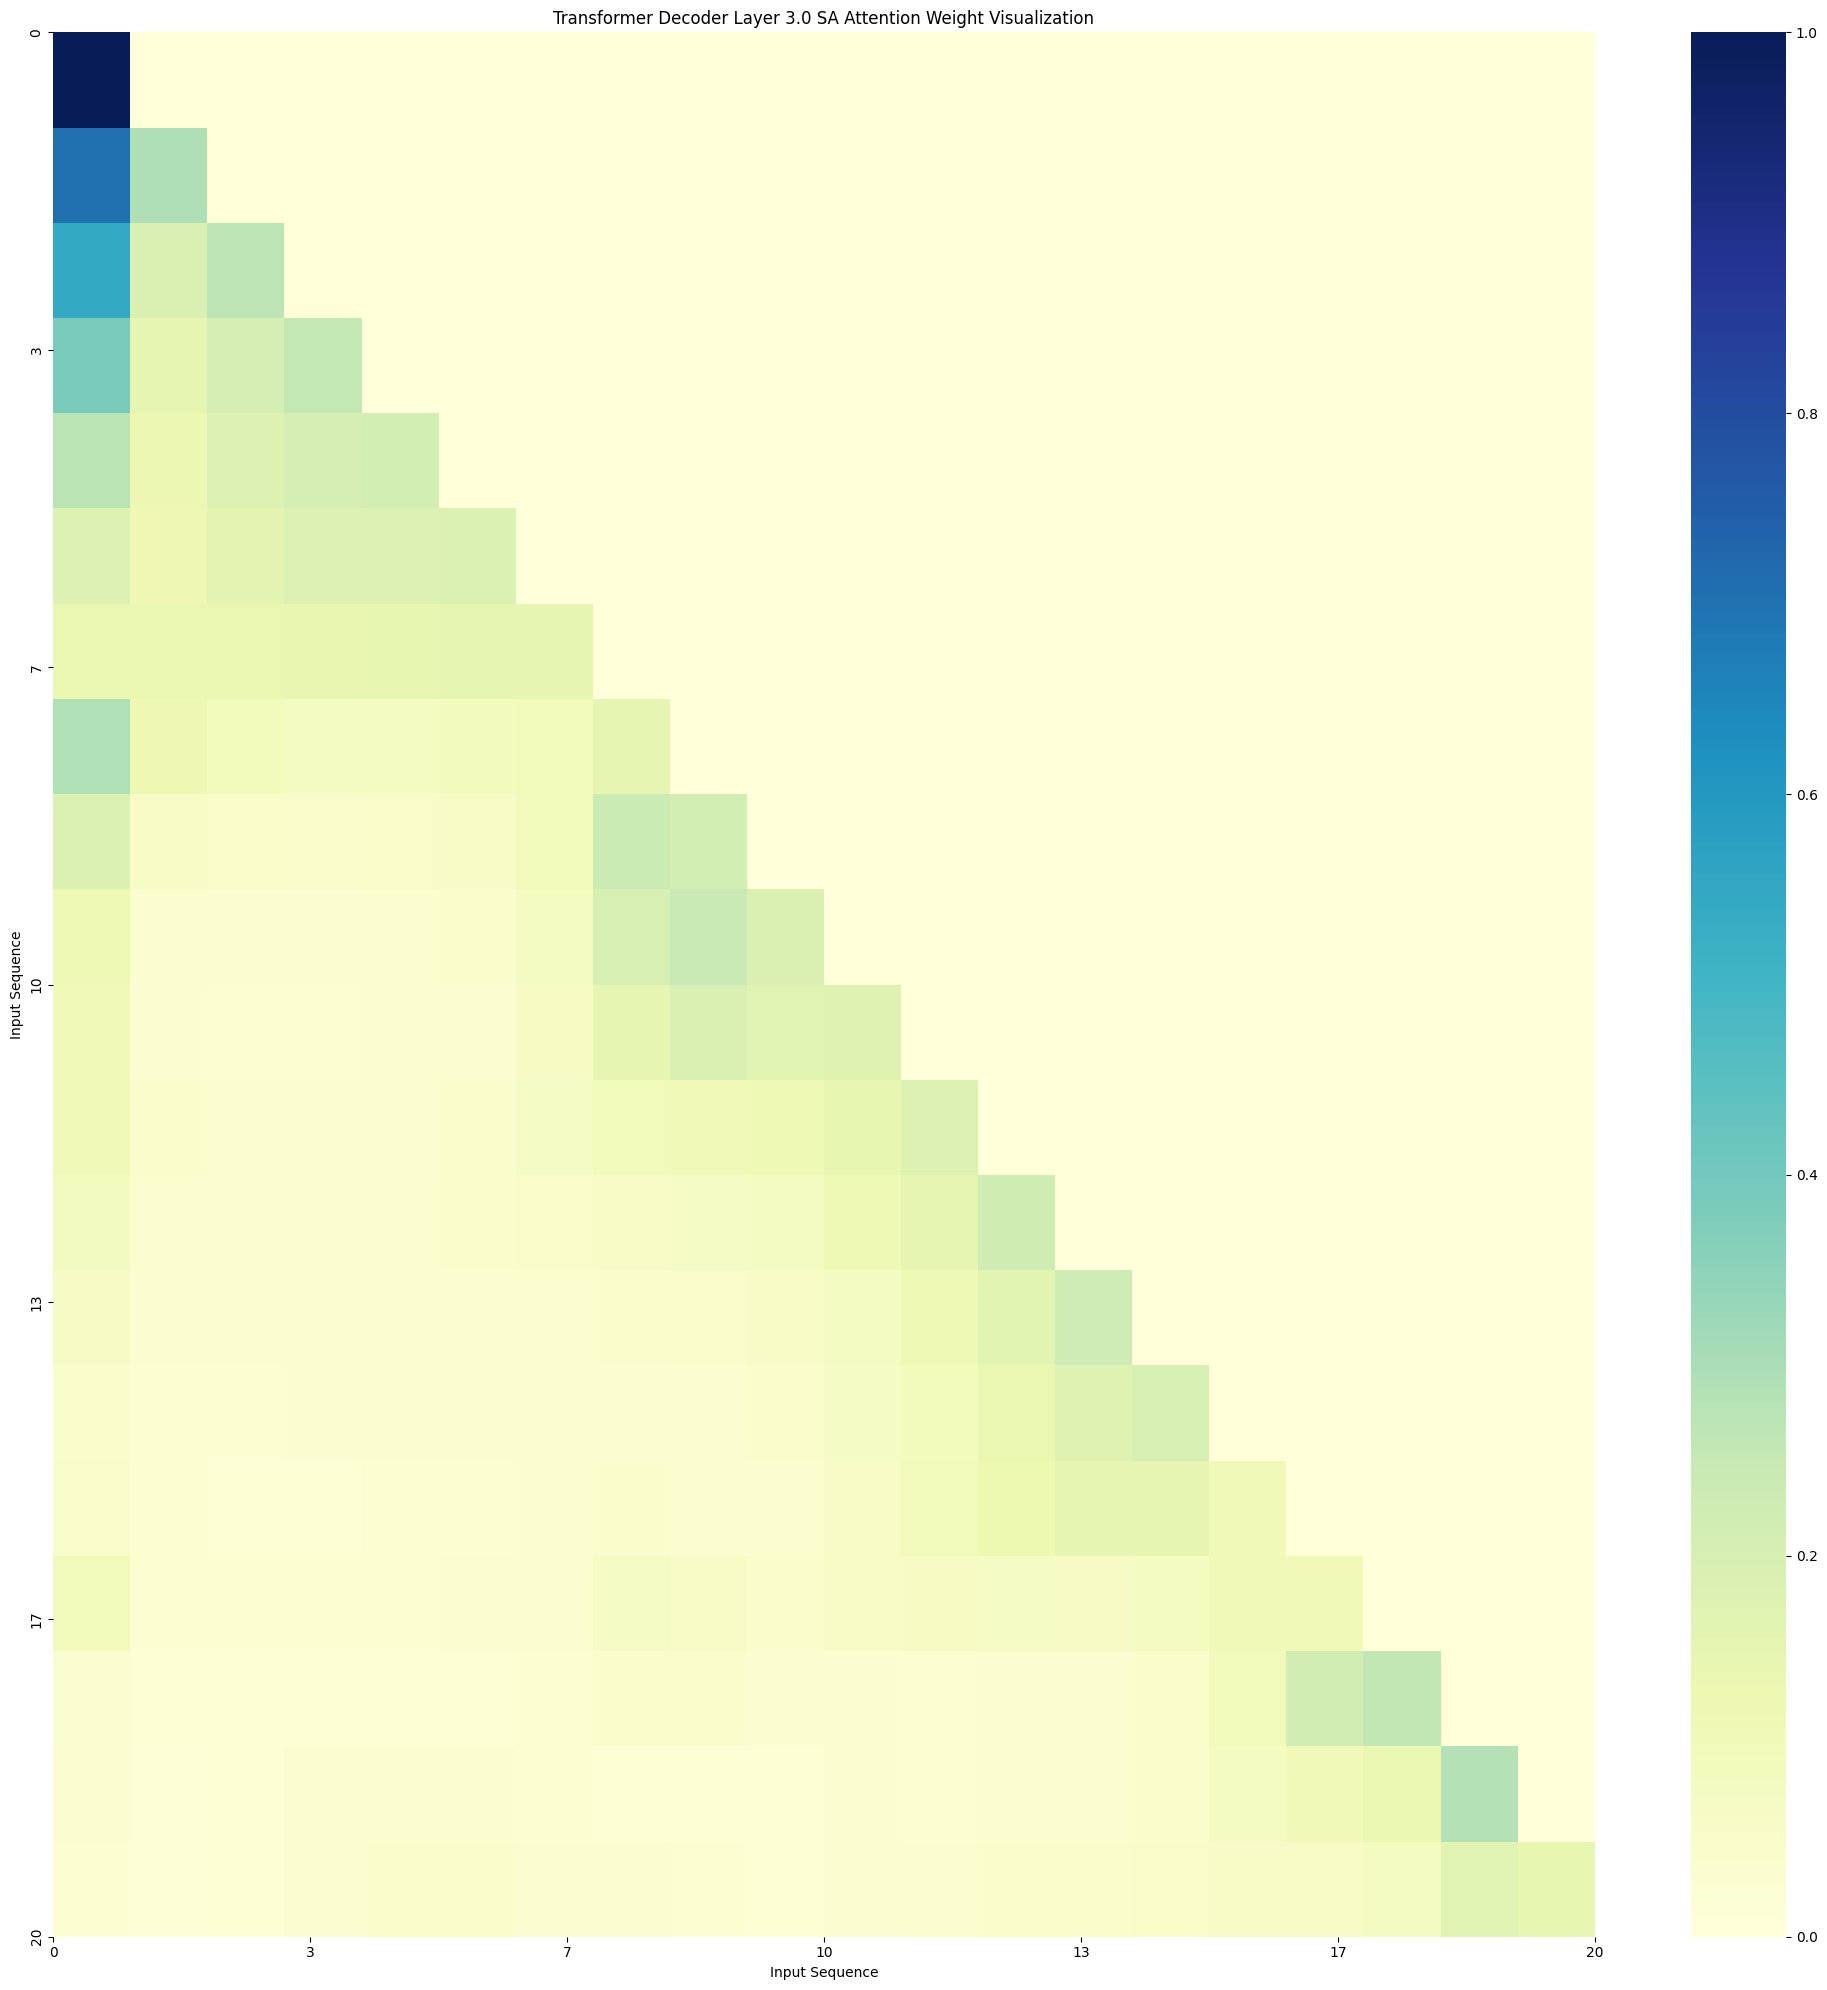

(20, 129)


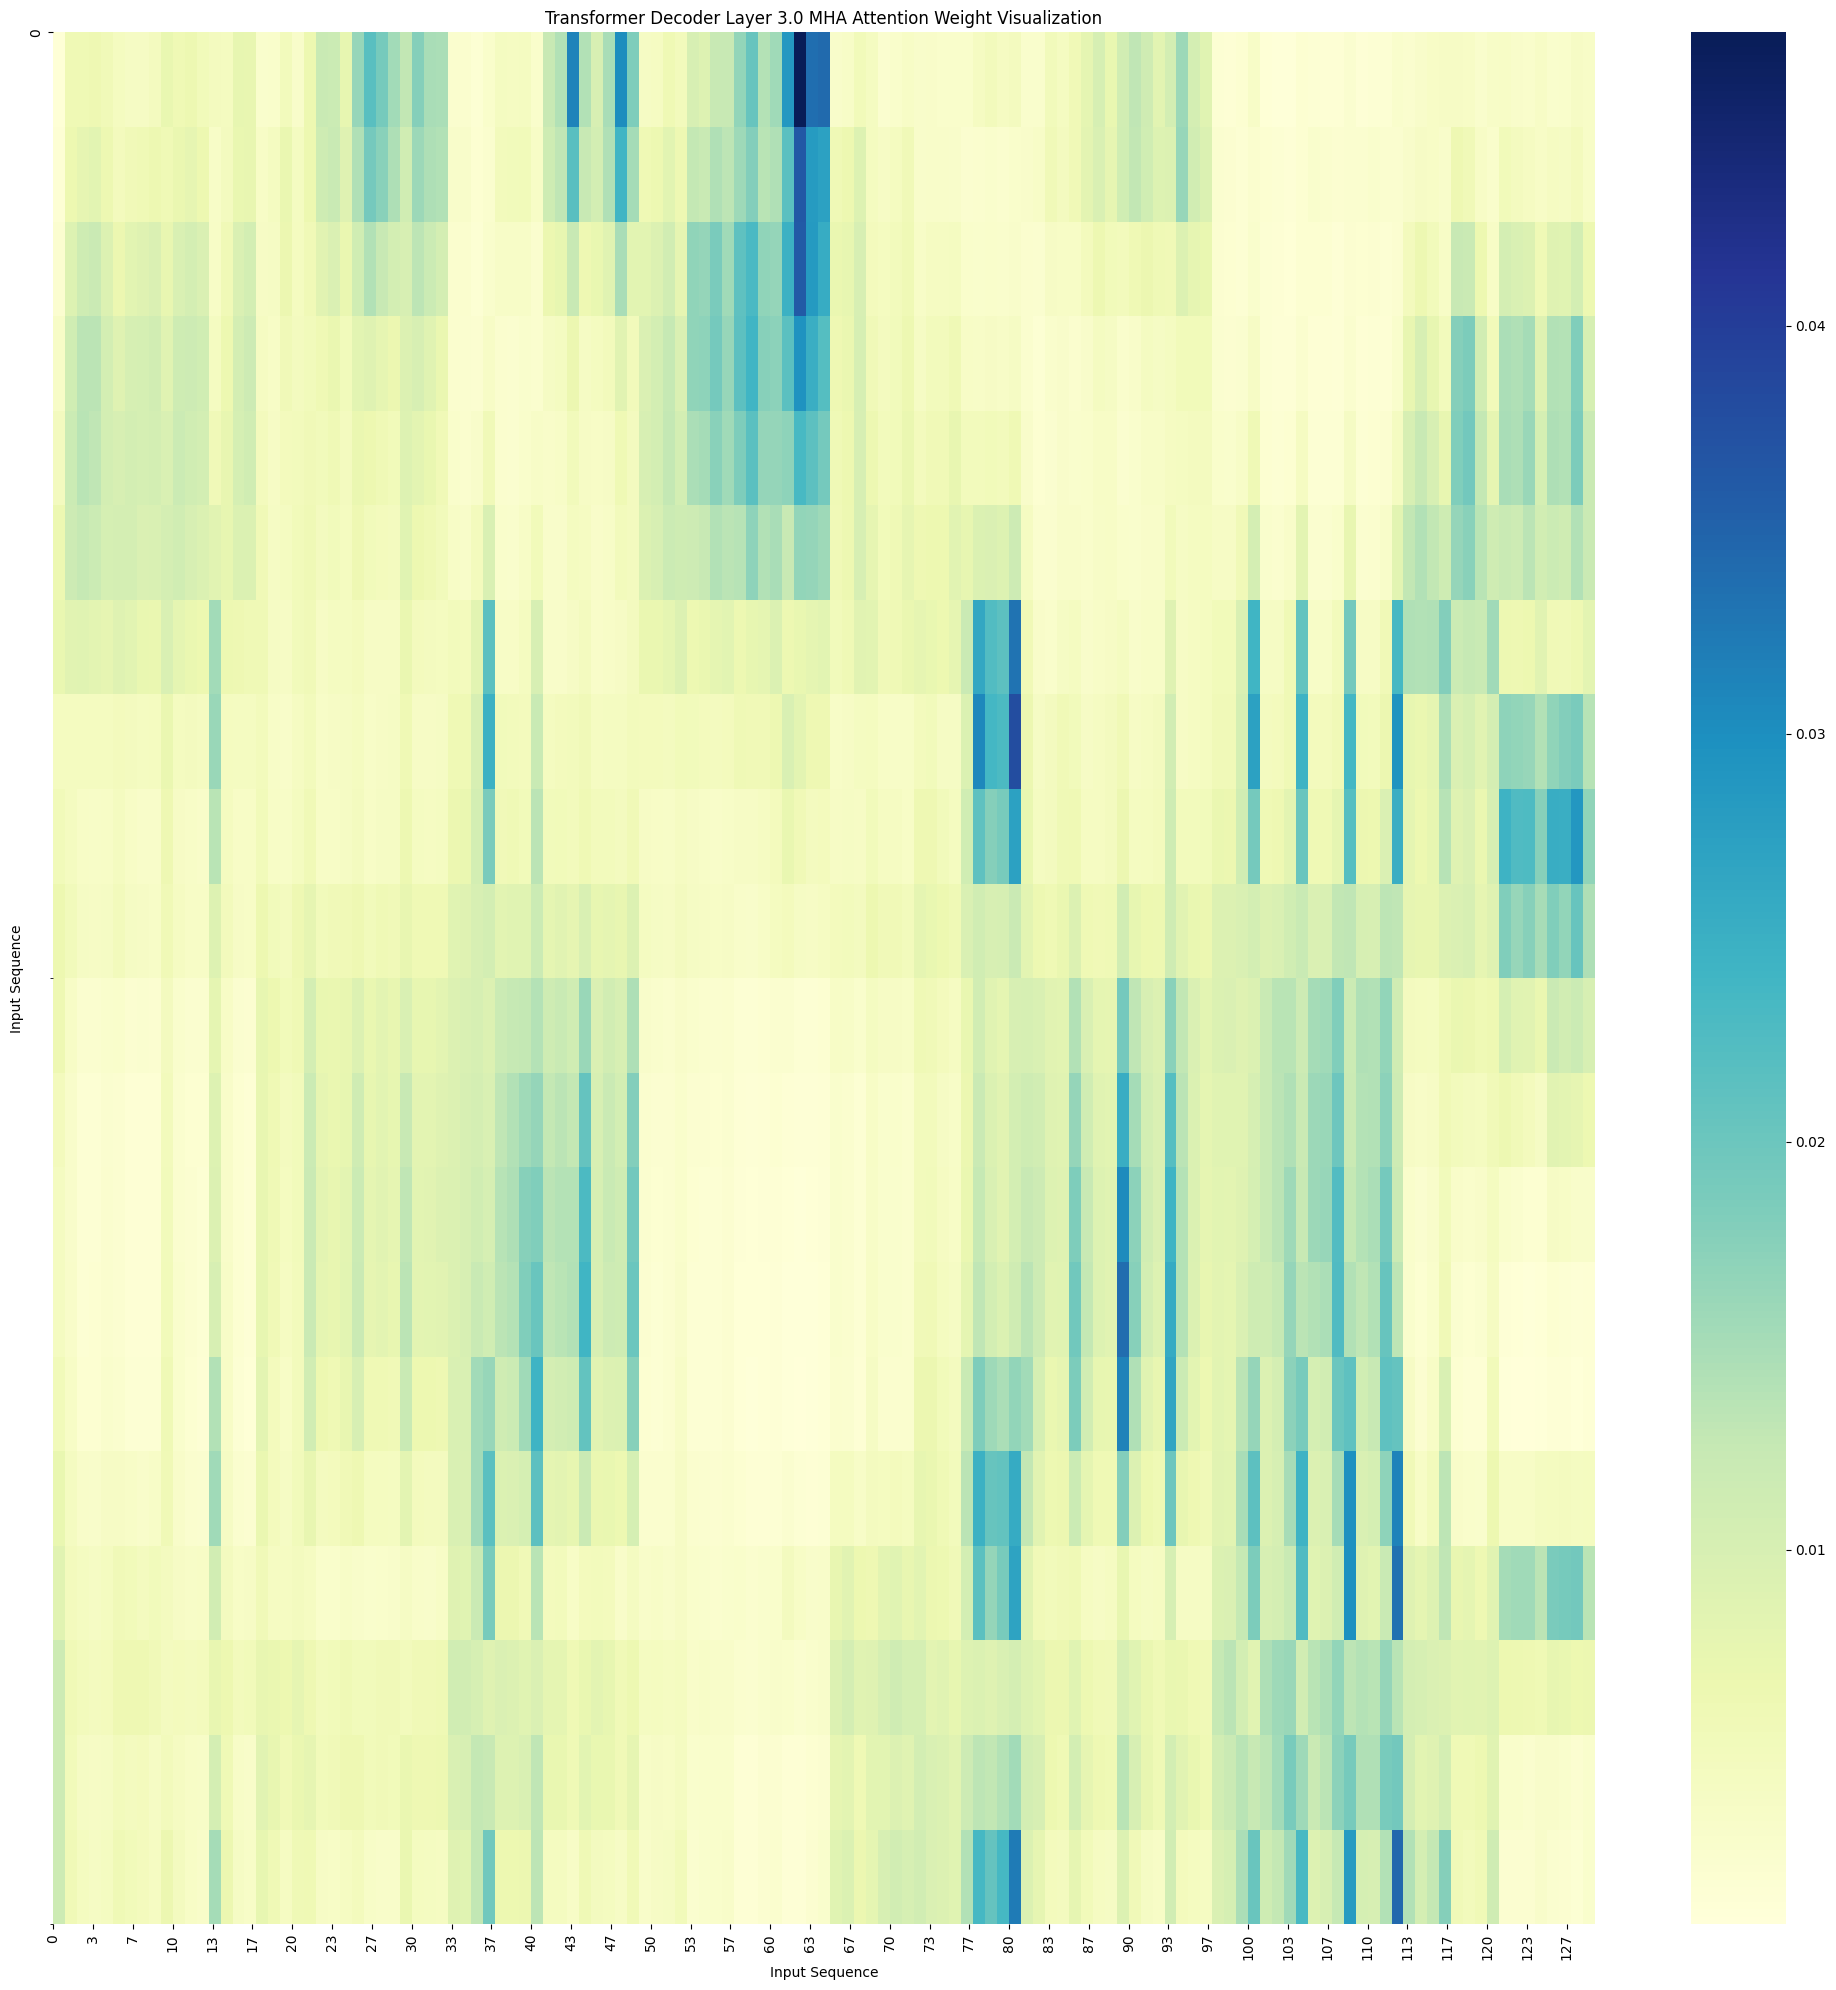

(20, 20)


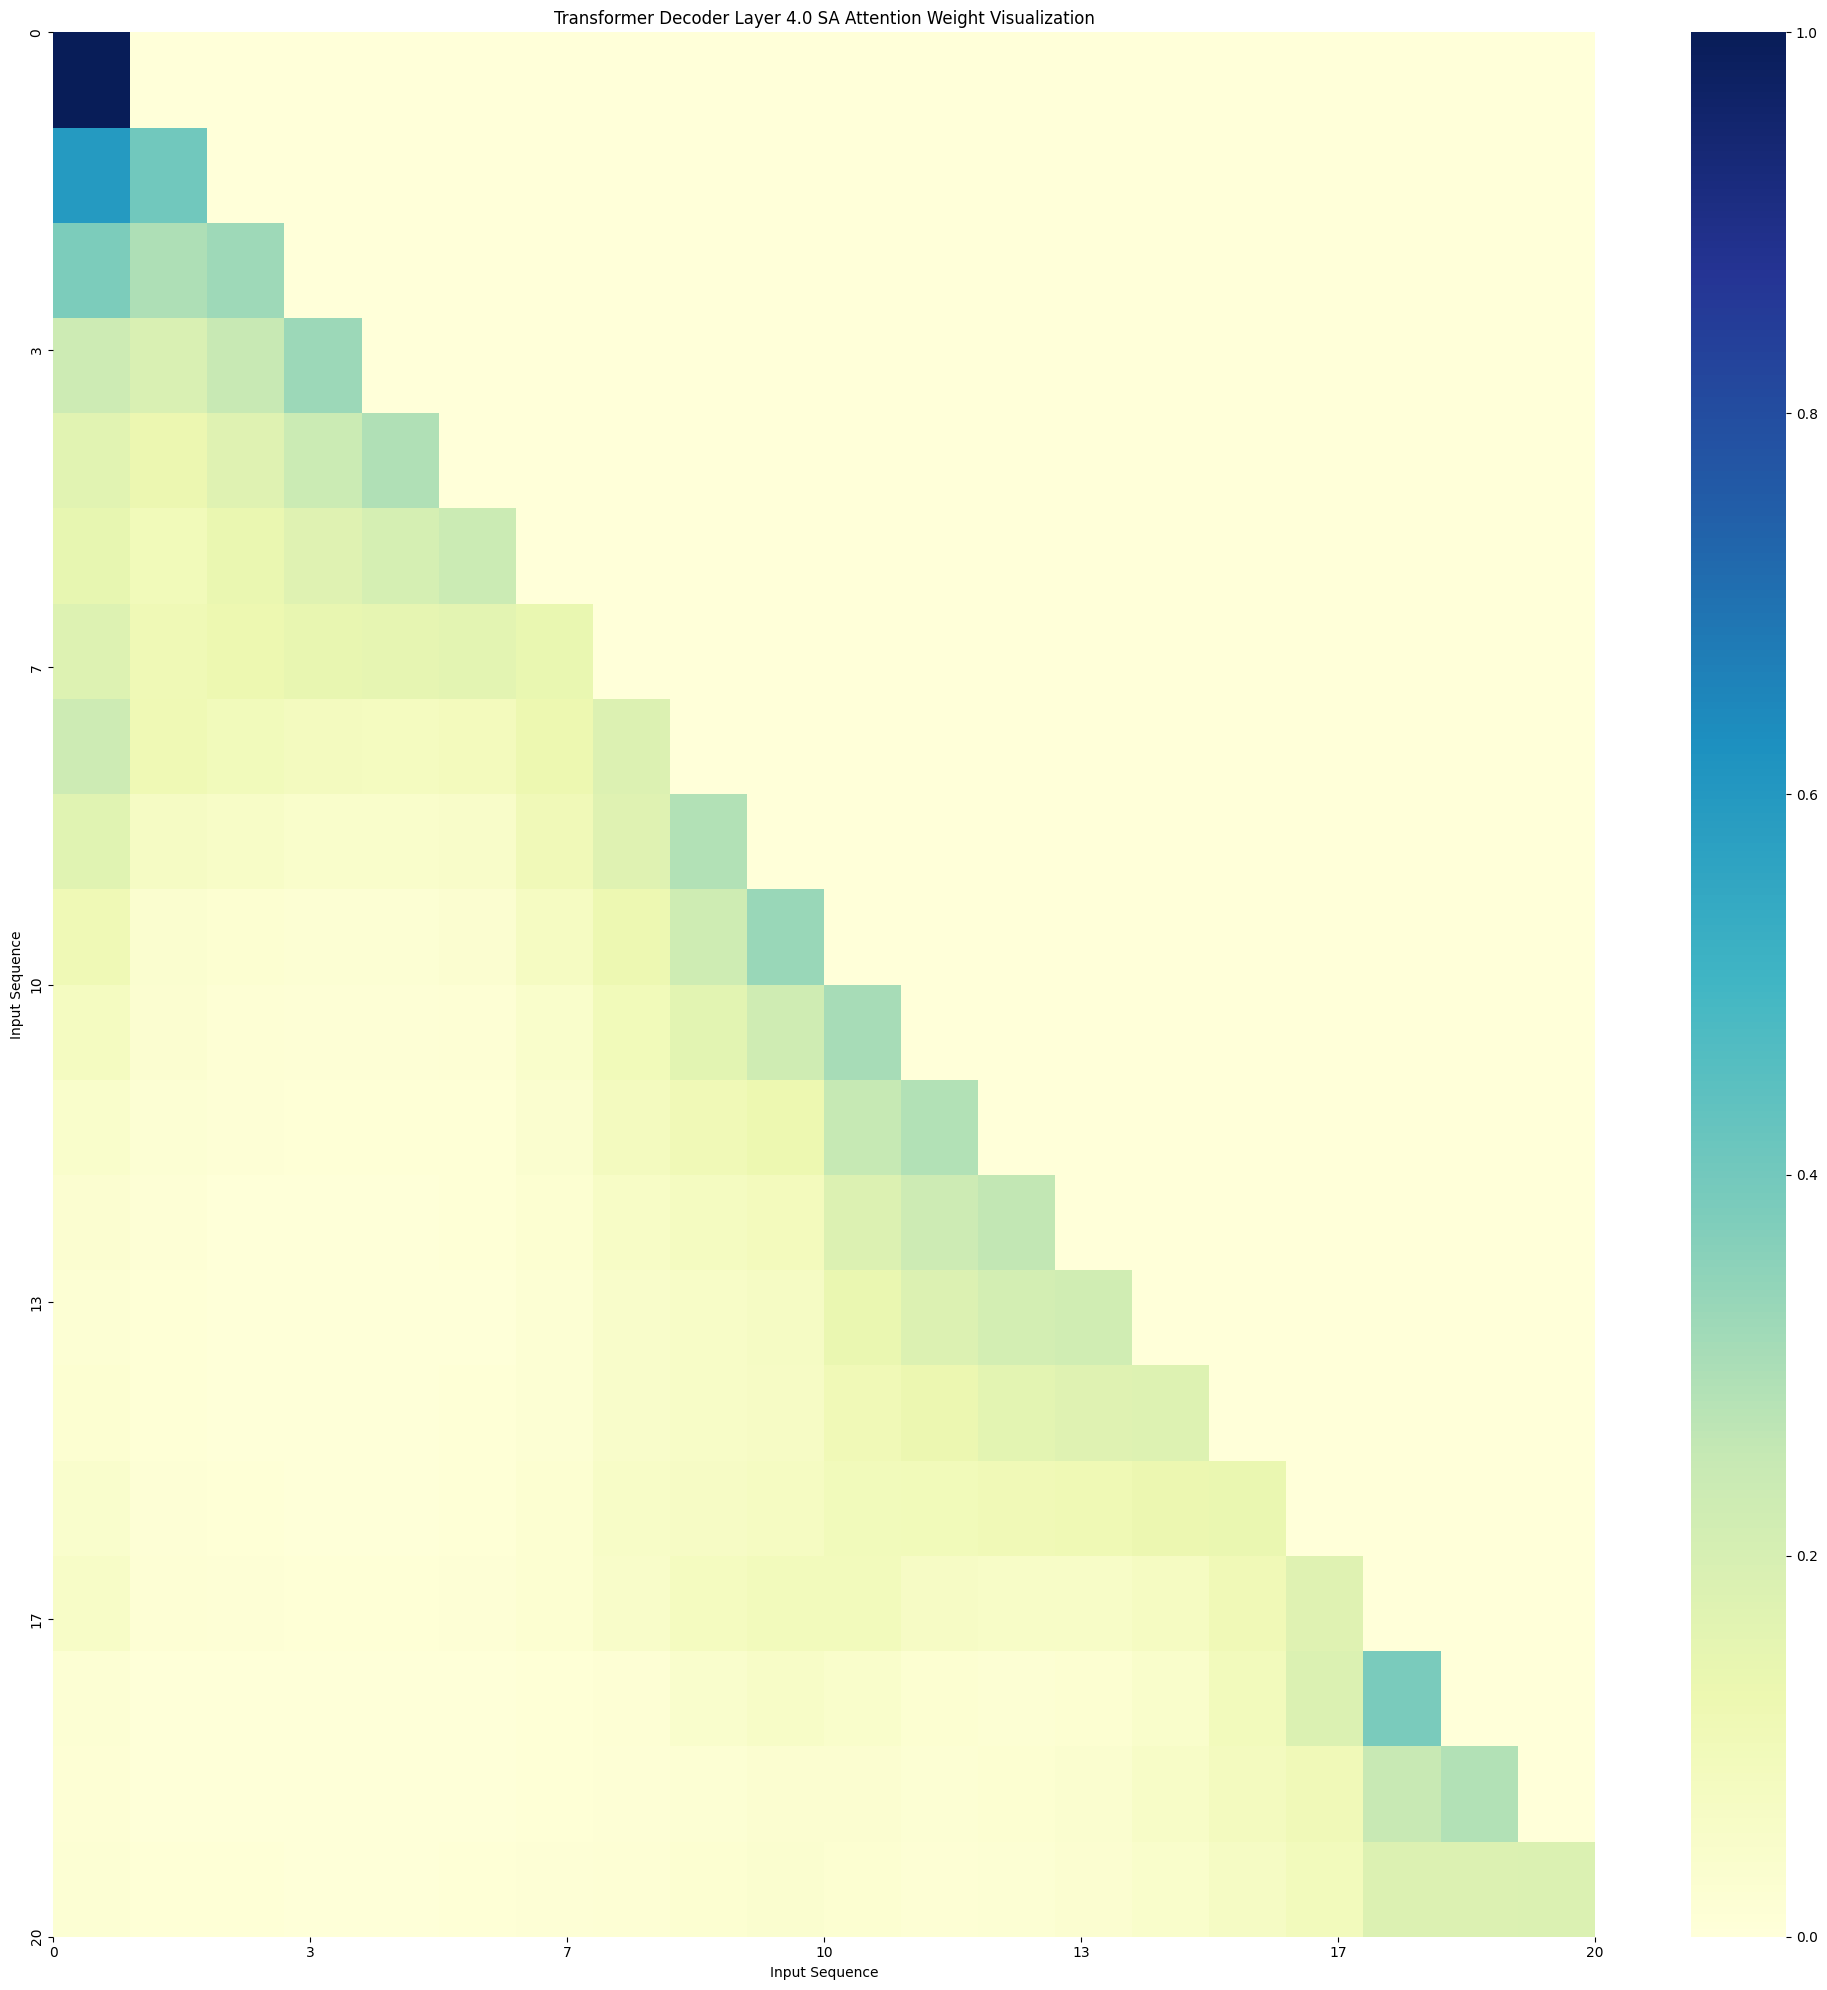

(20, 129)


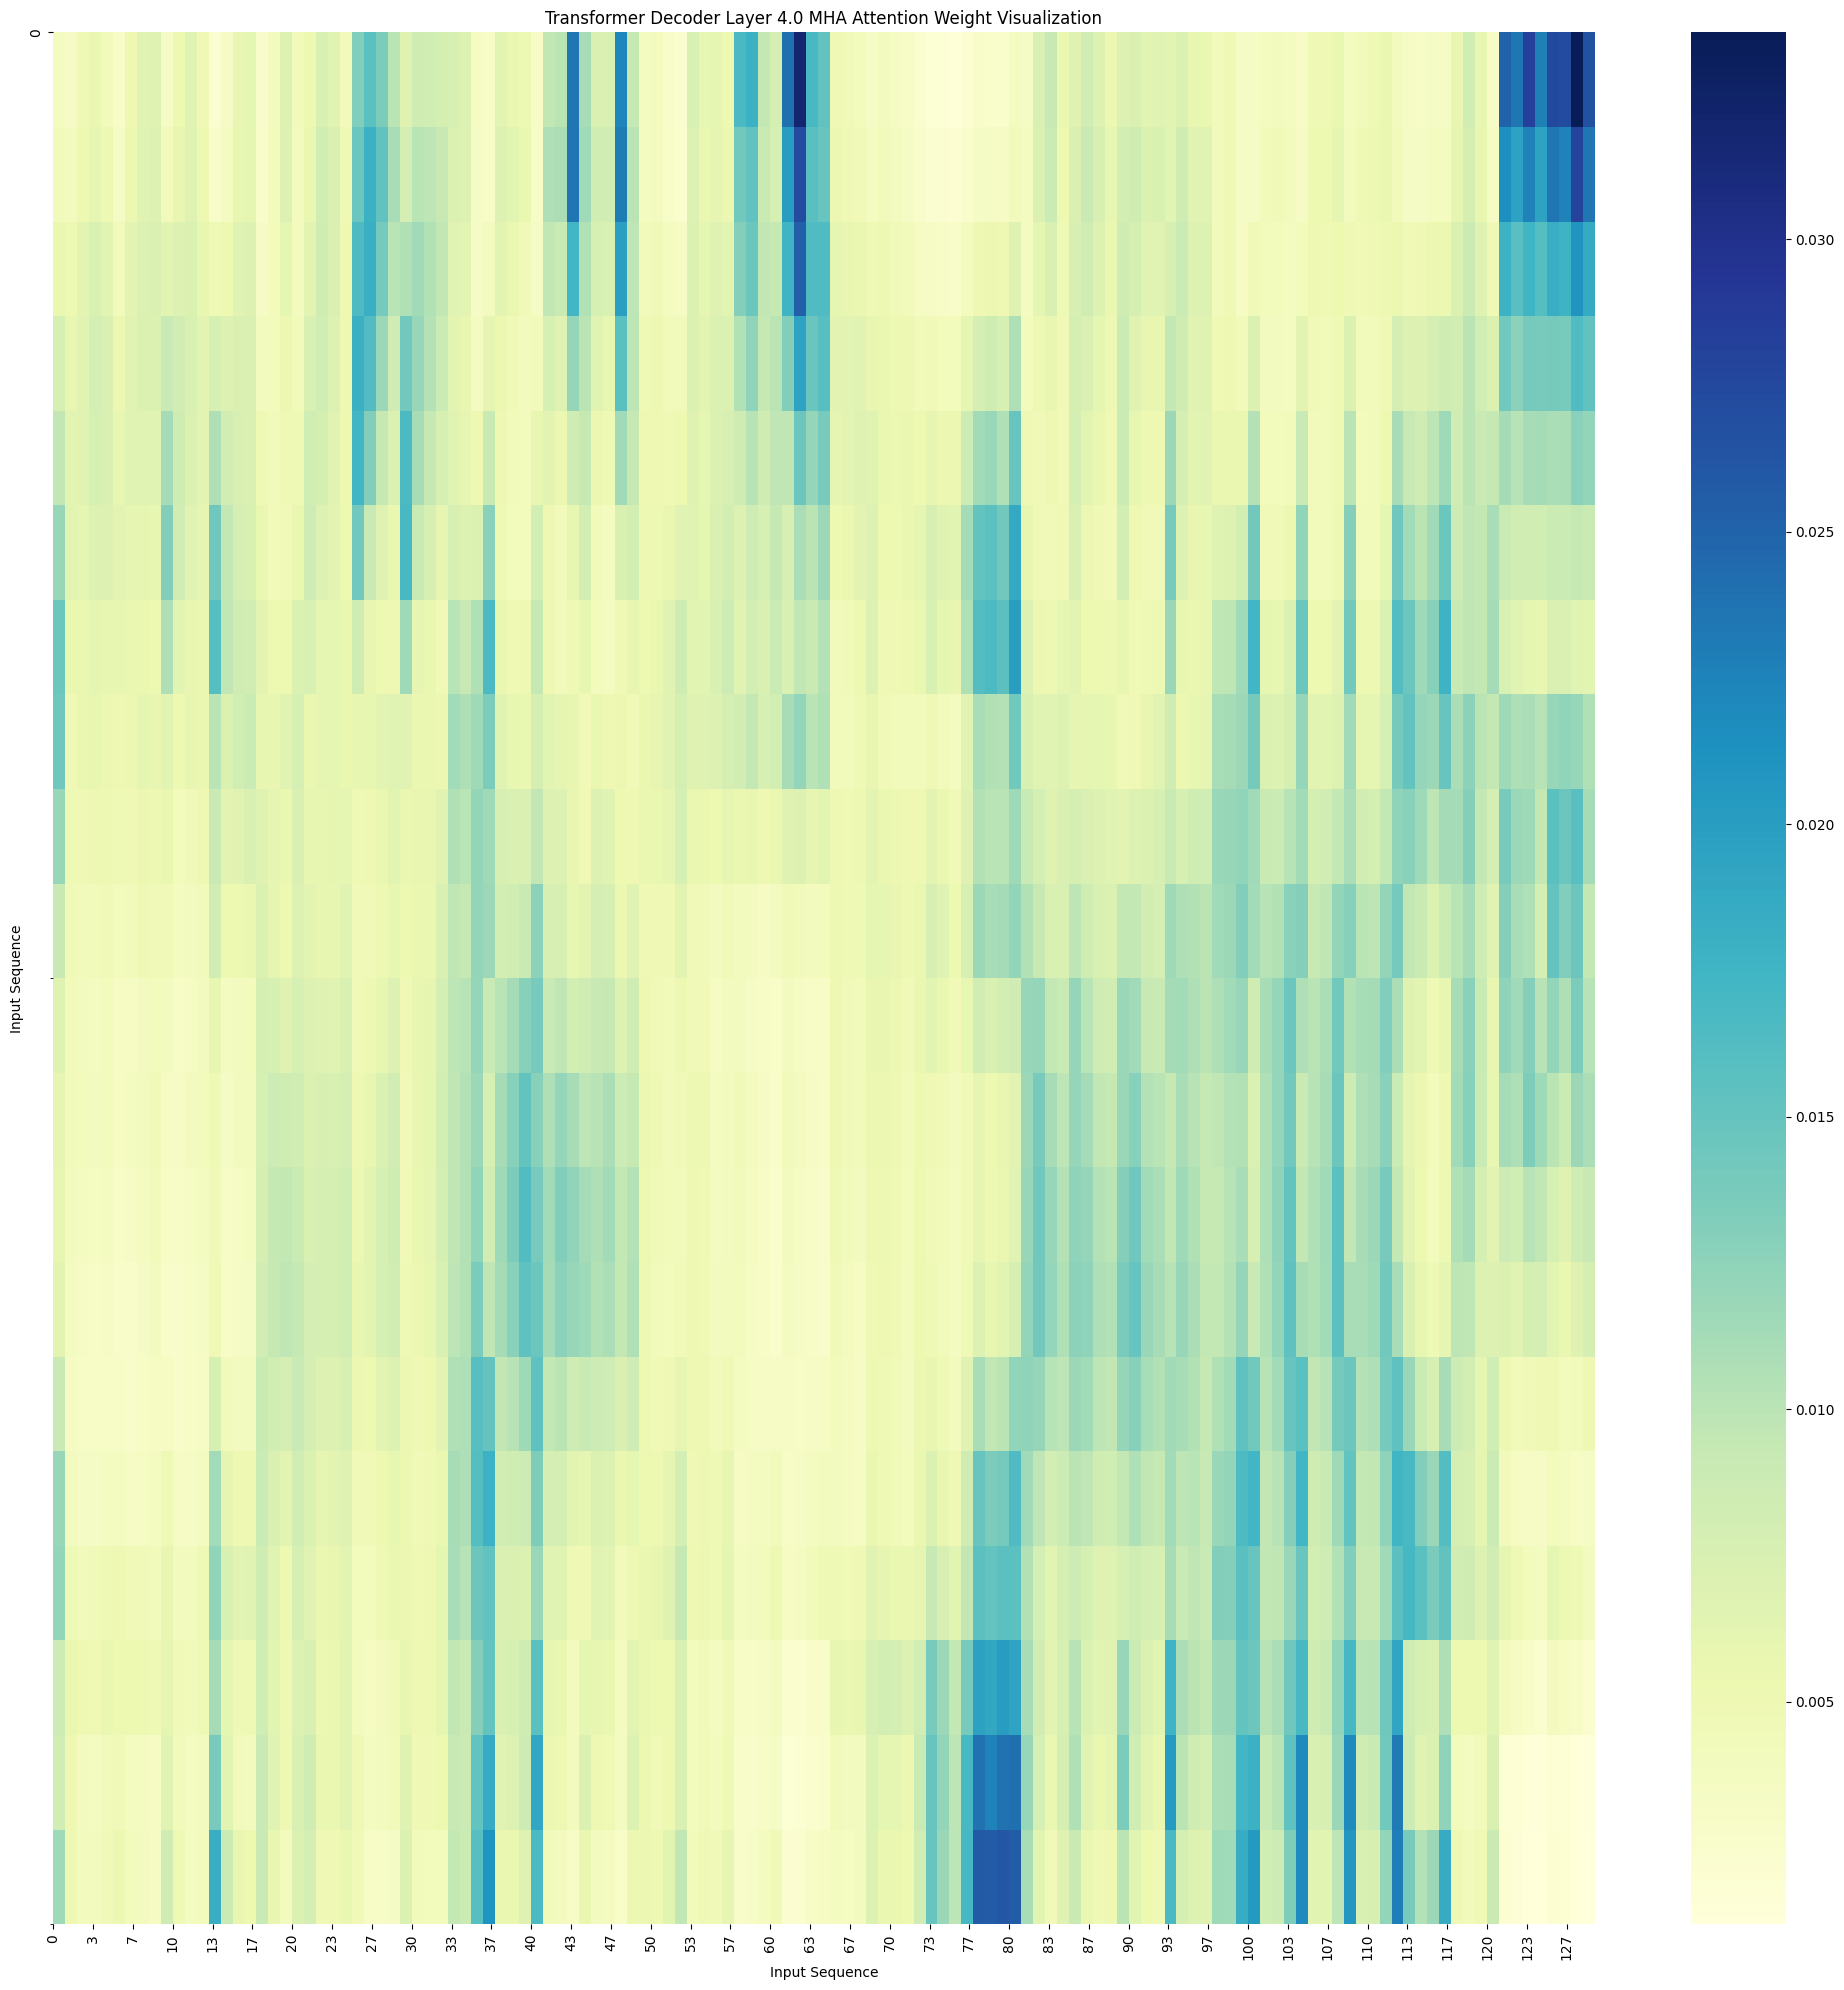

(20, 20)


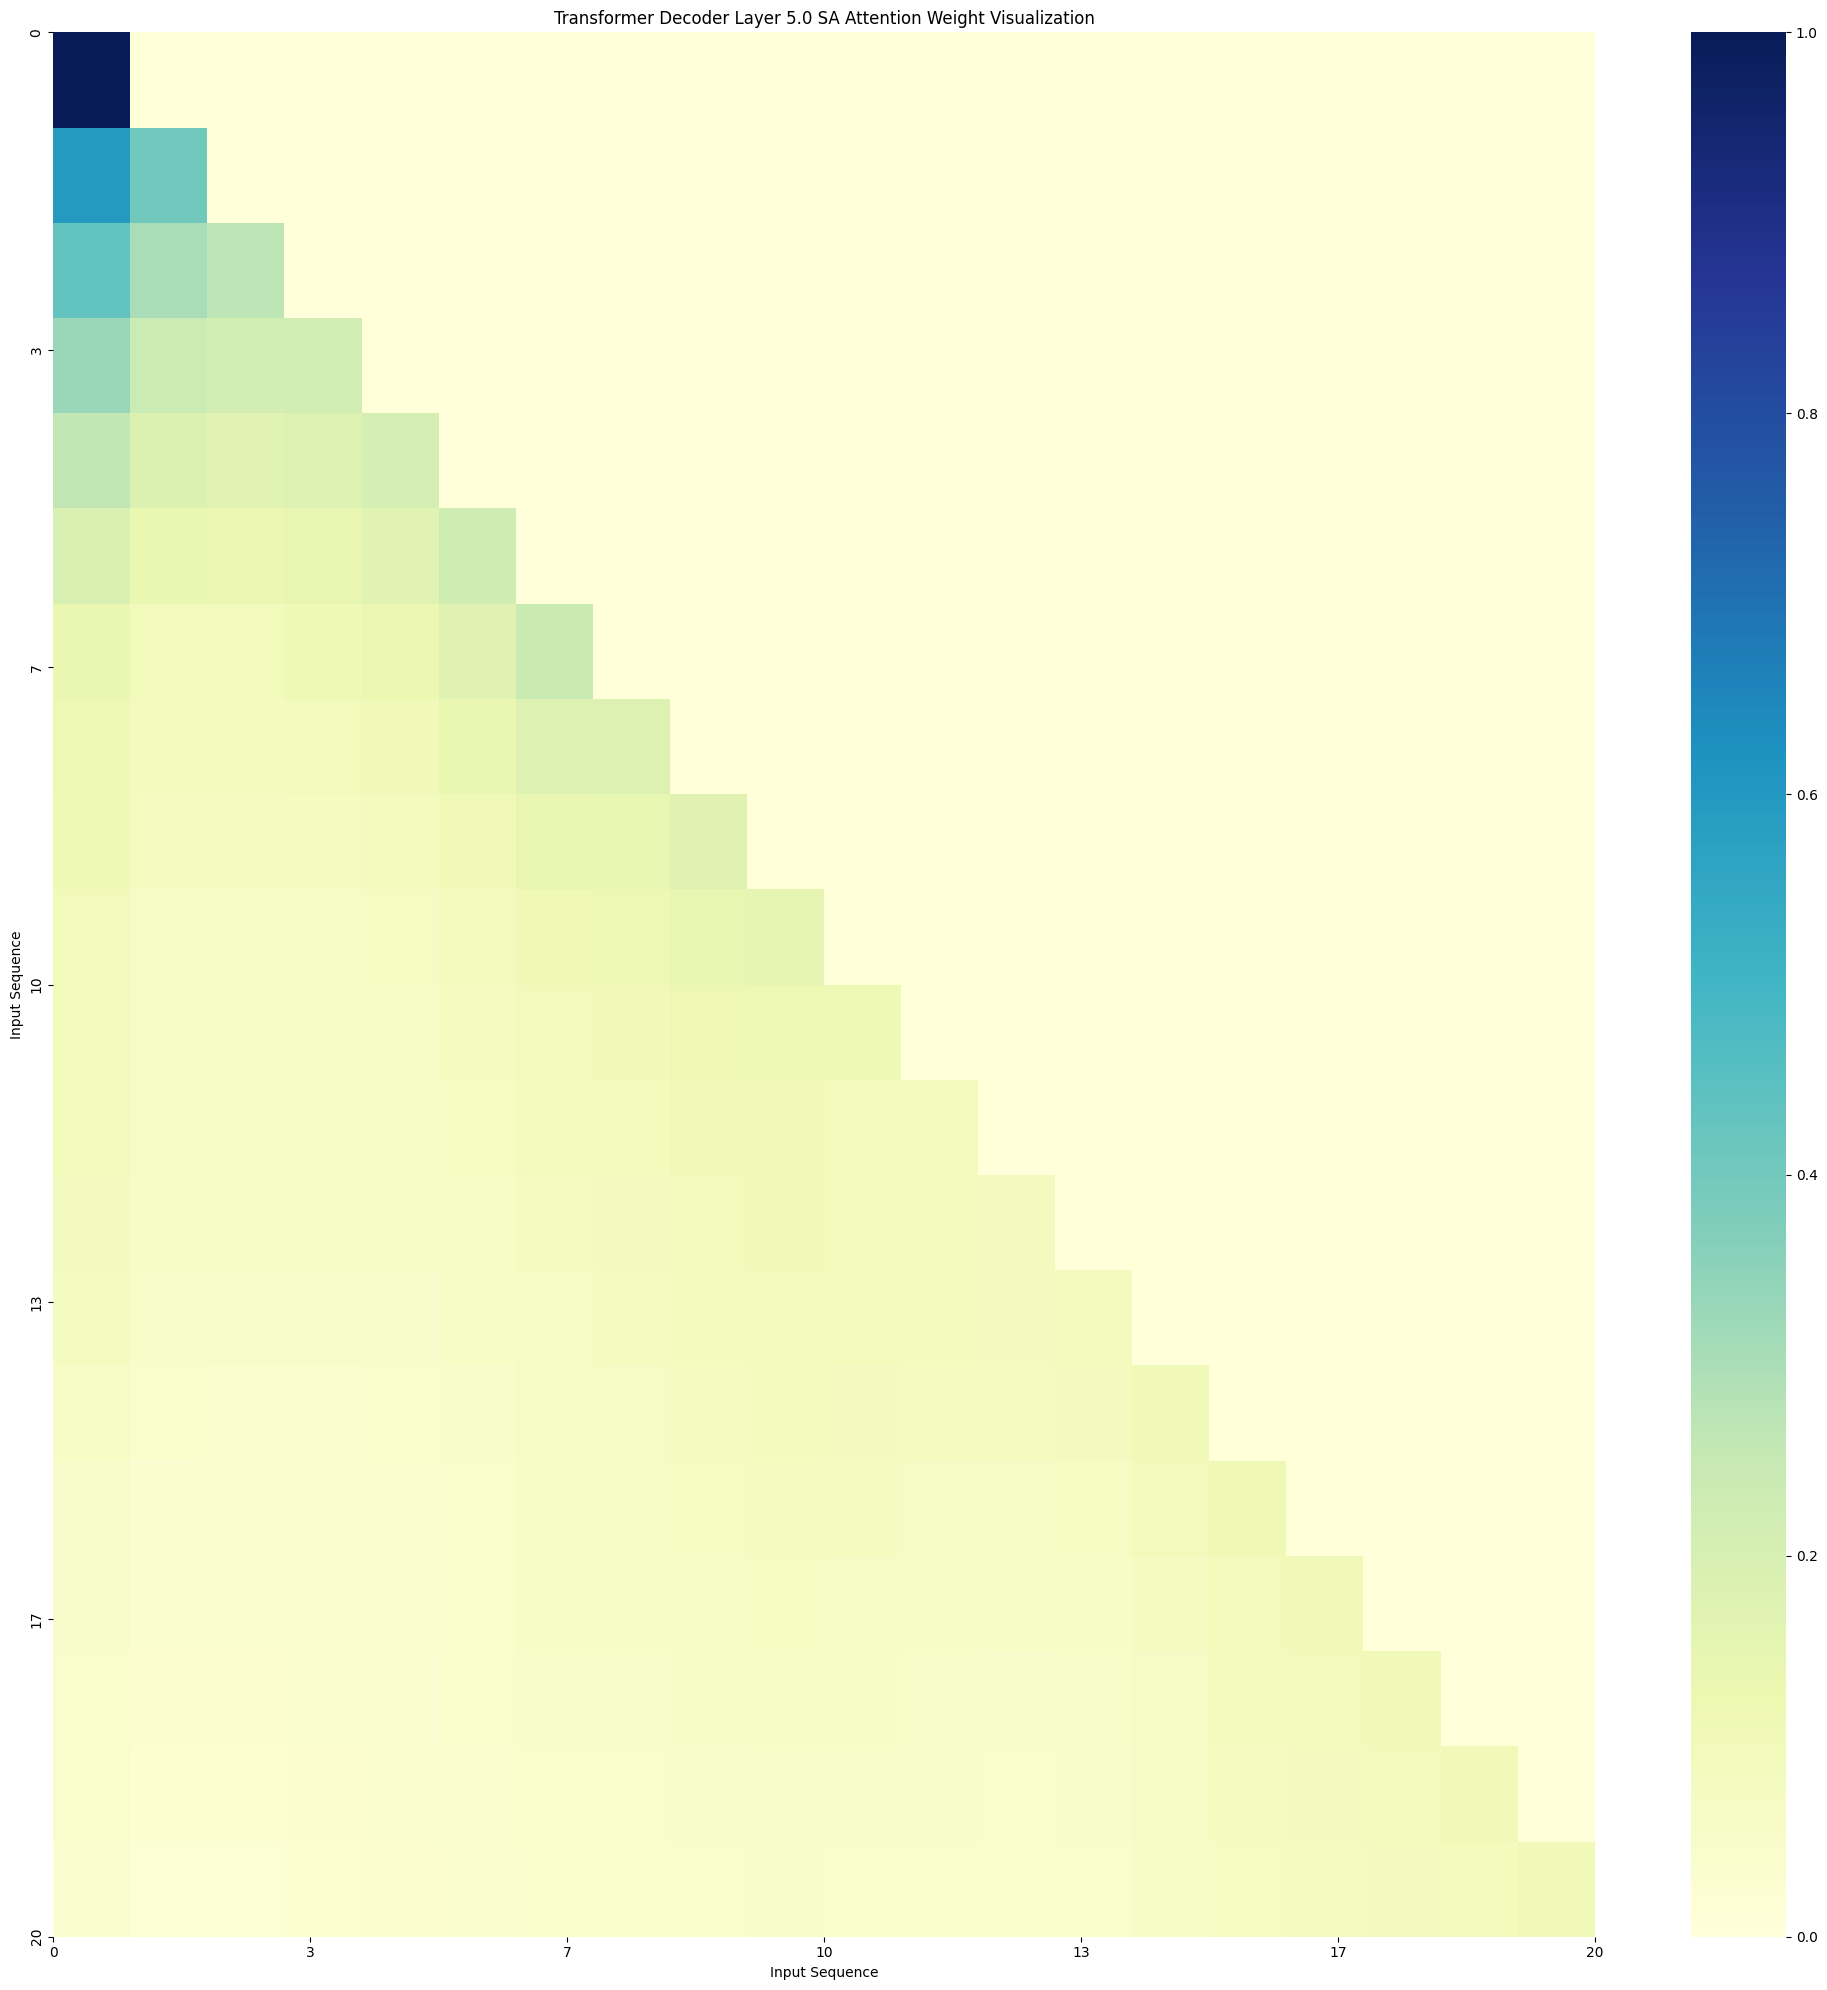

(20, 129)


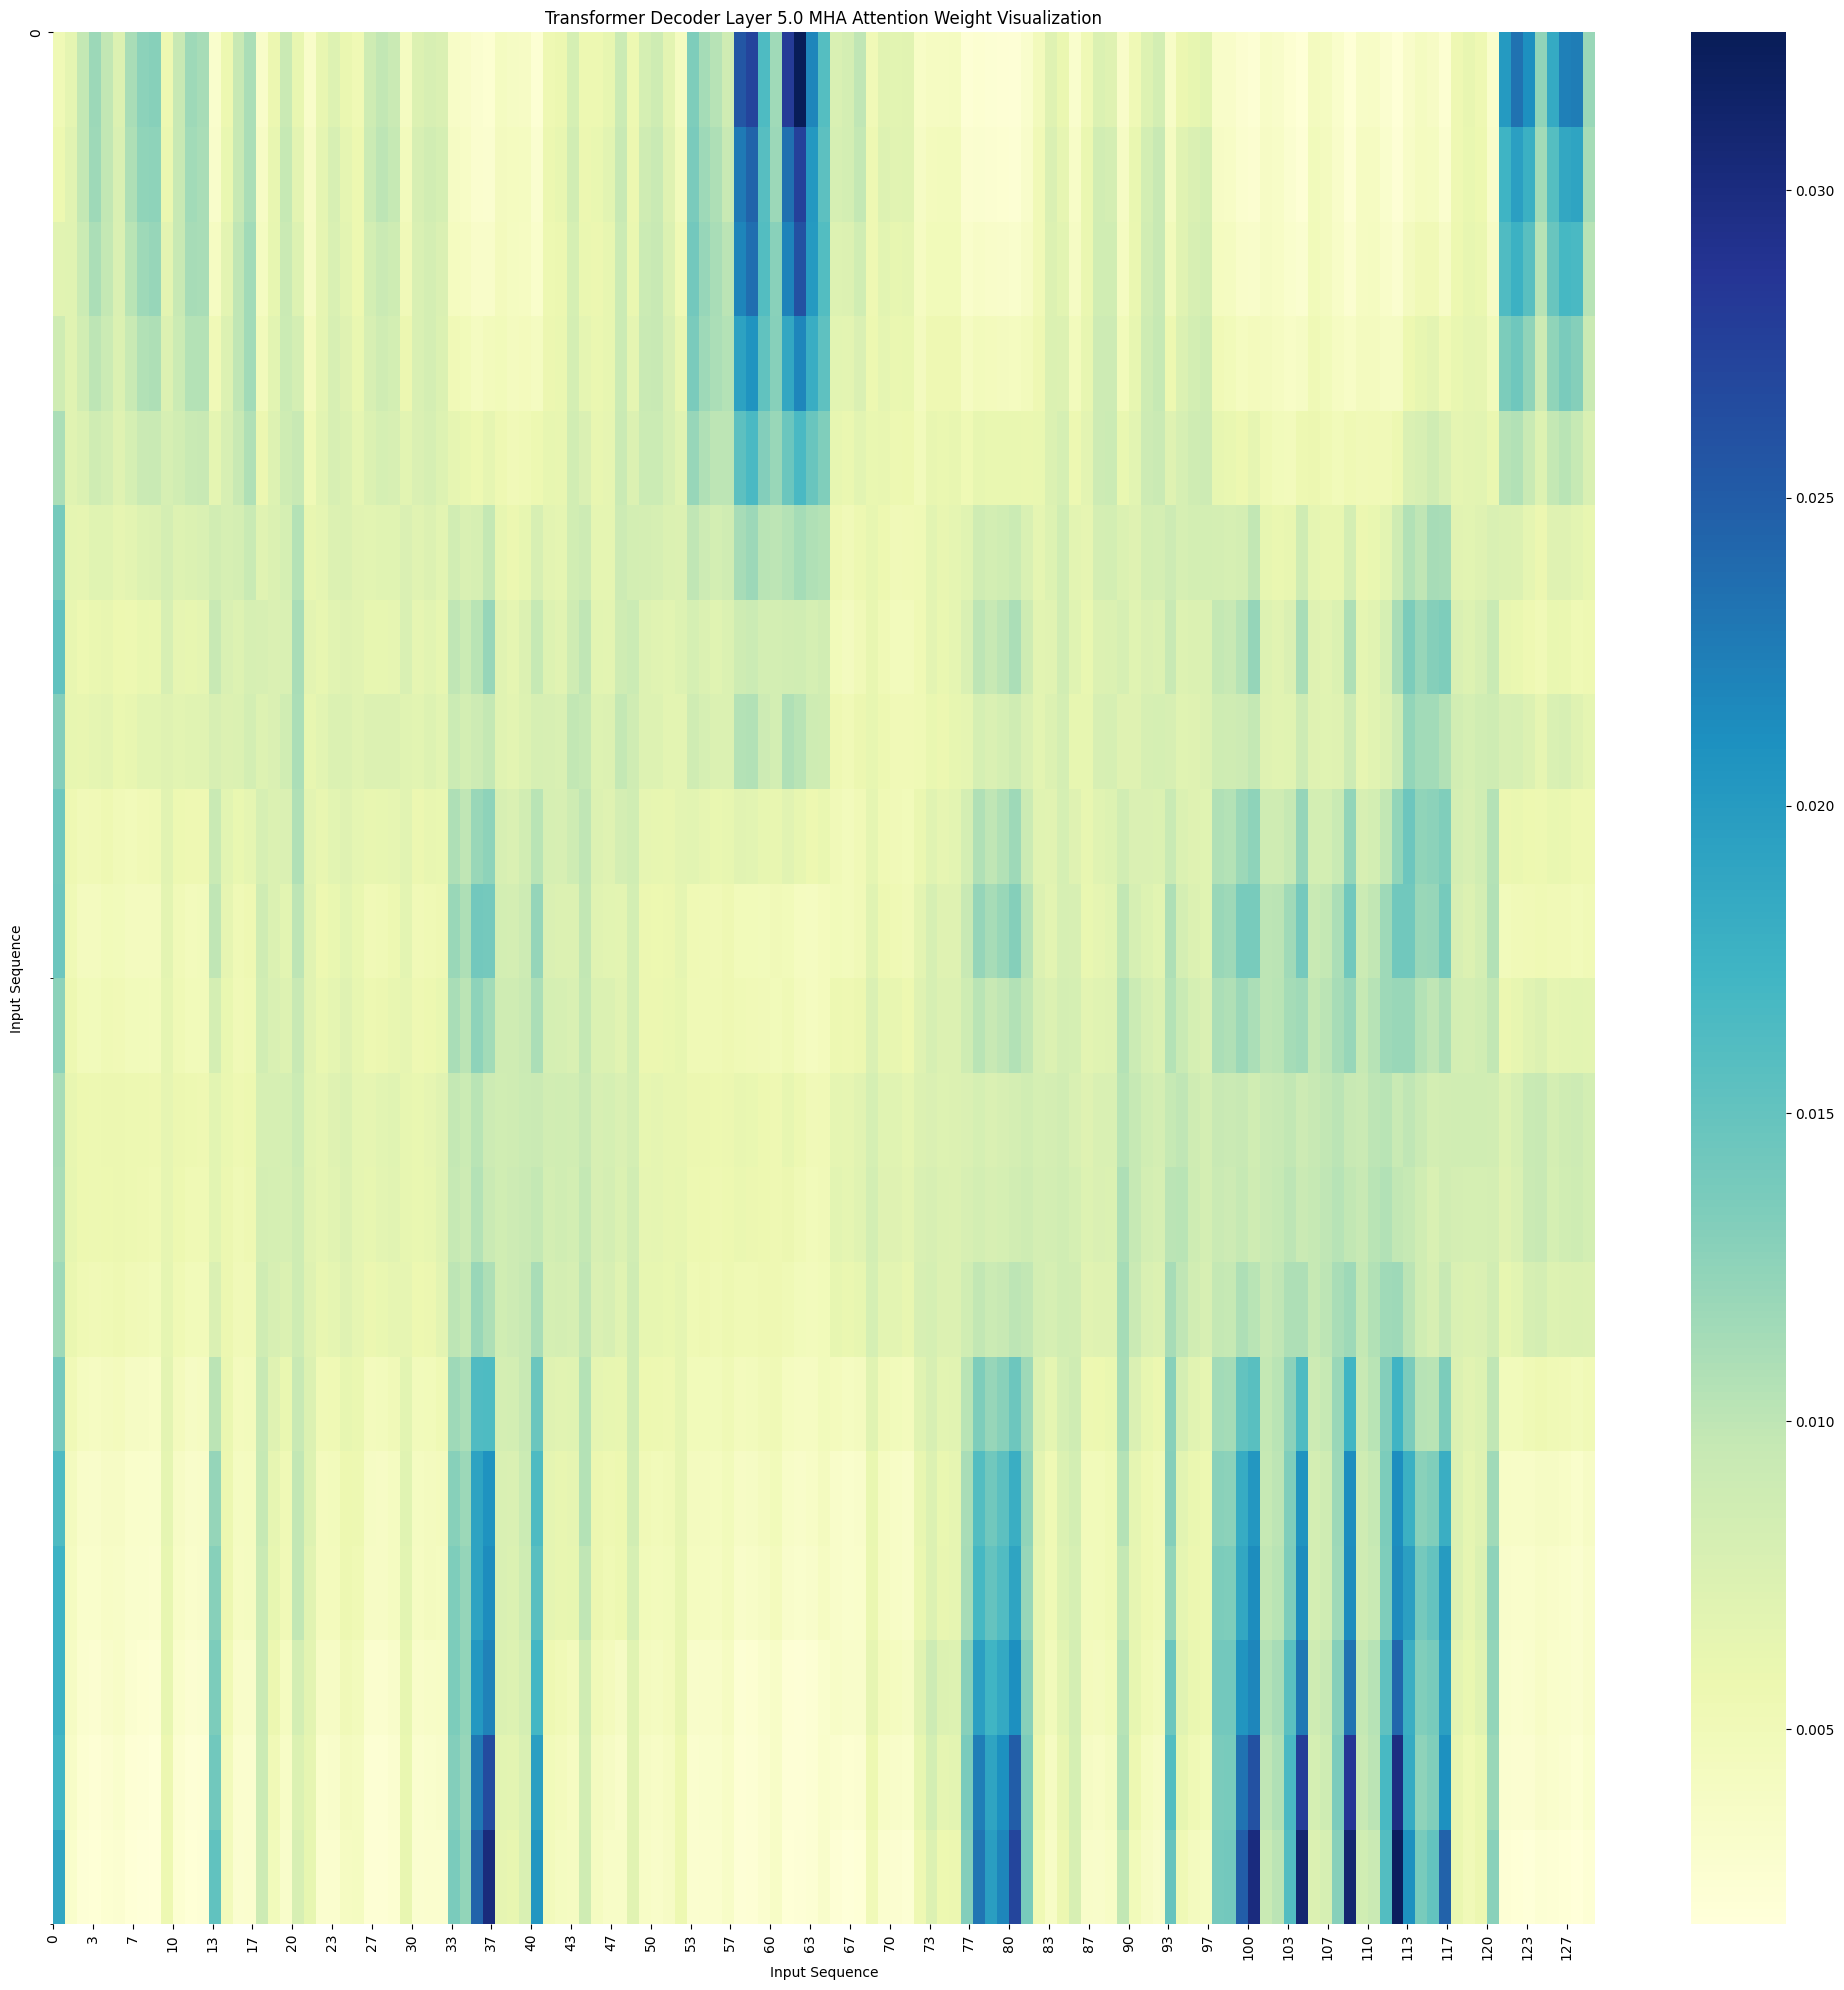

(20, 20)


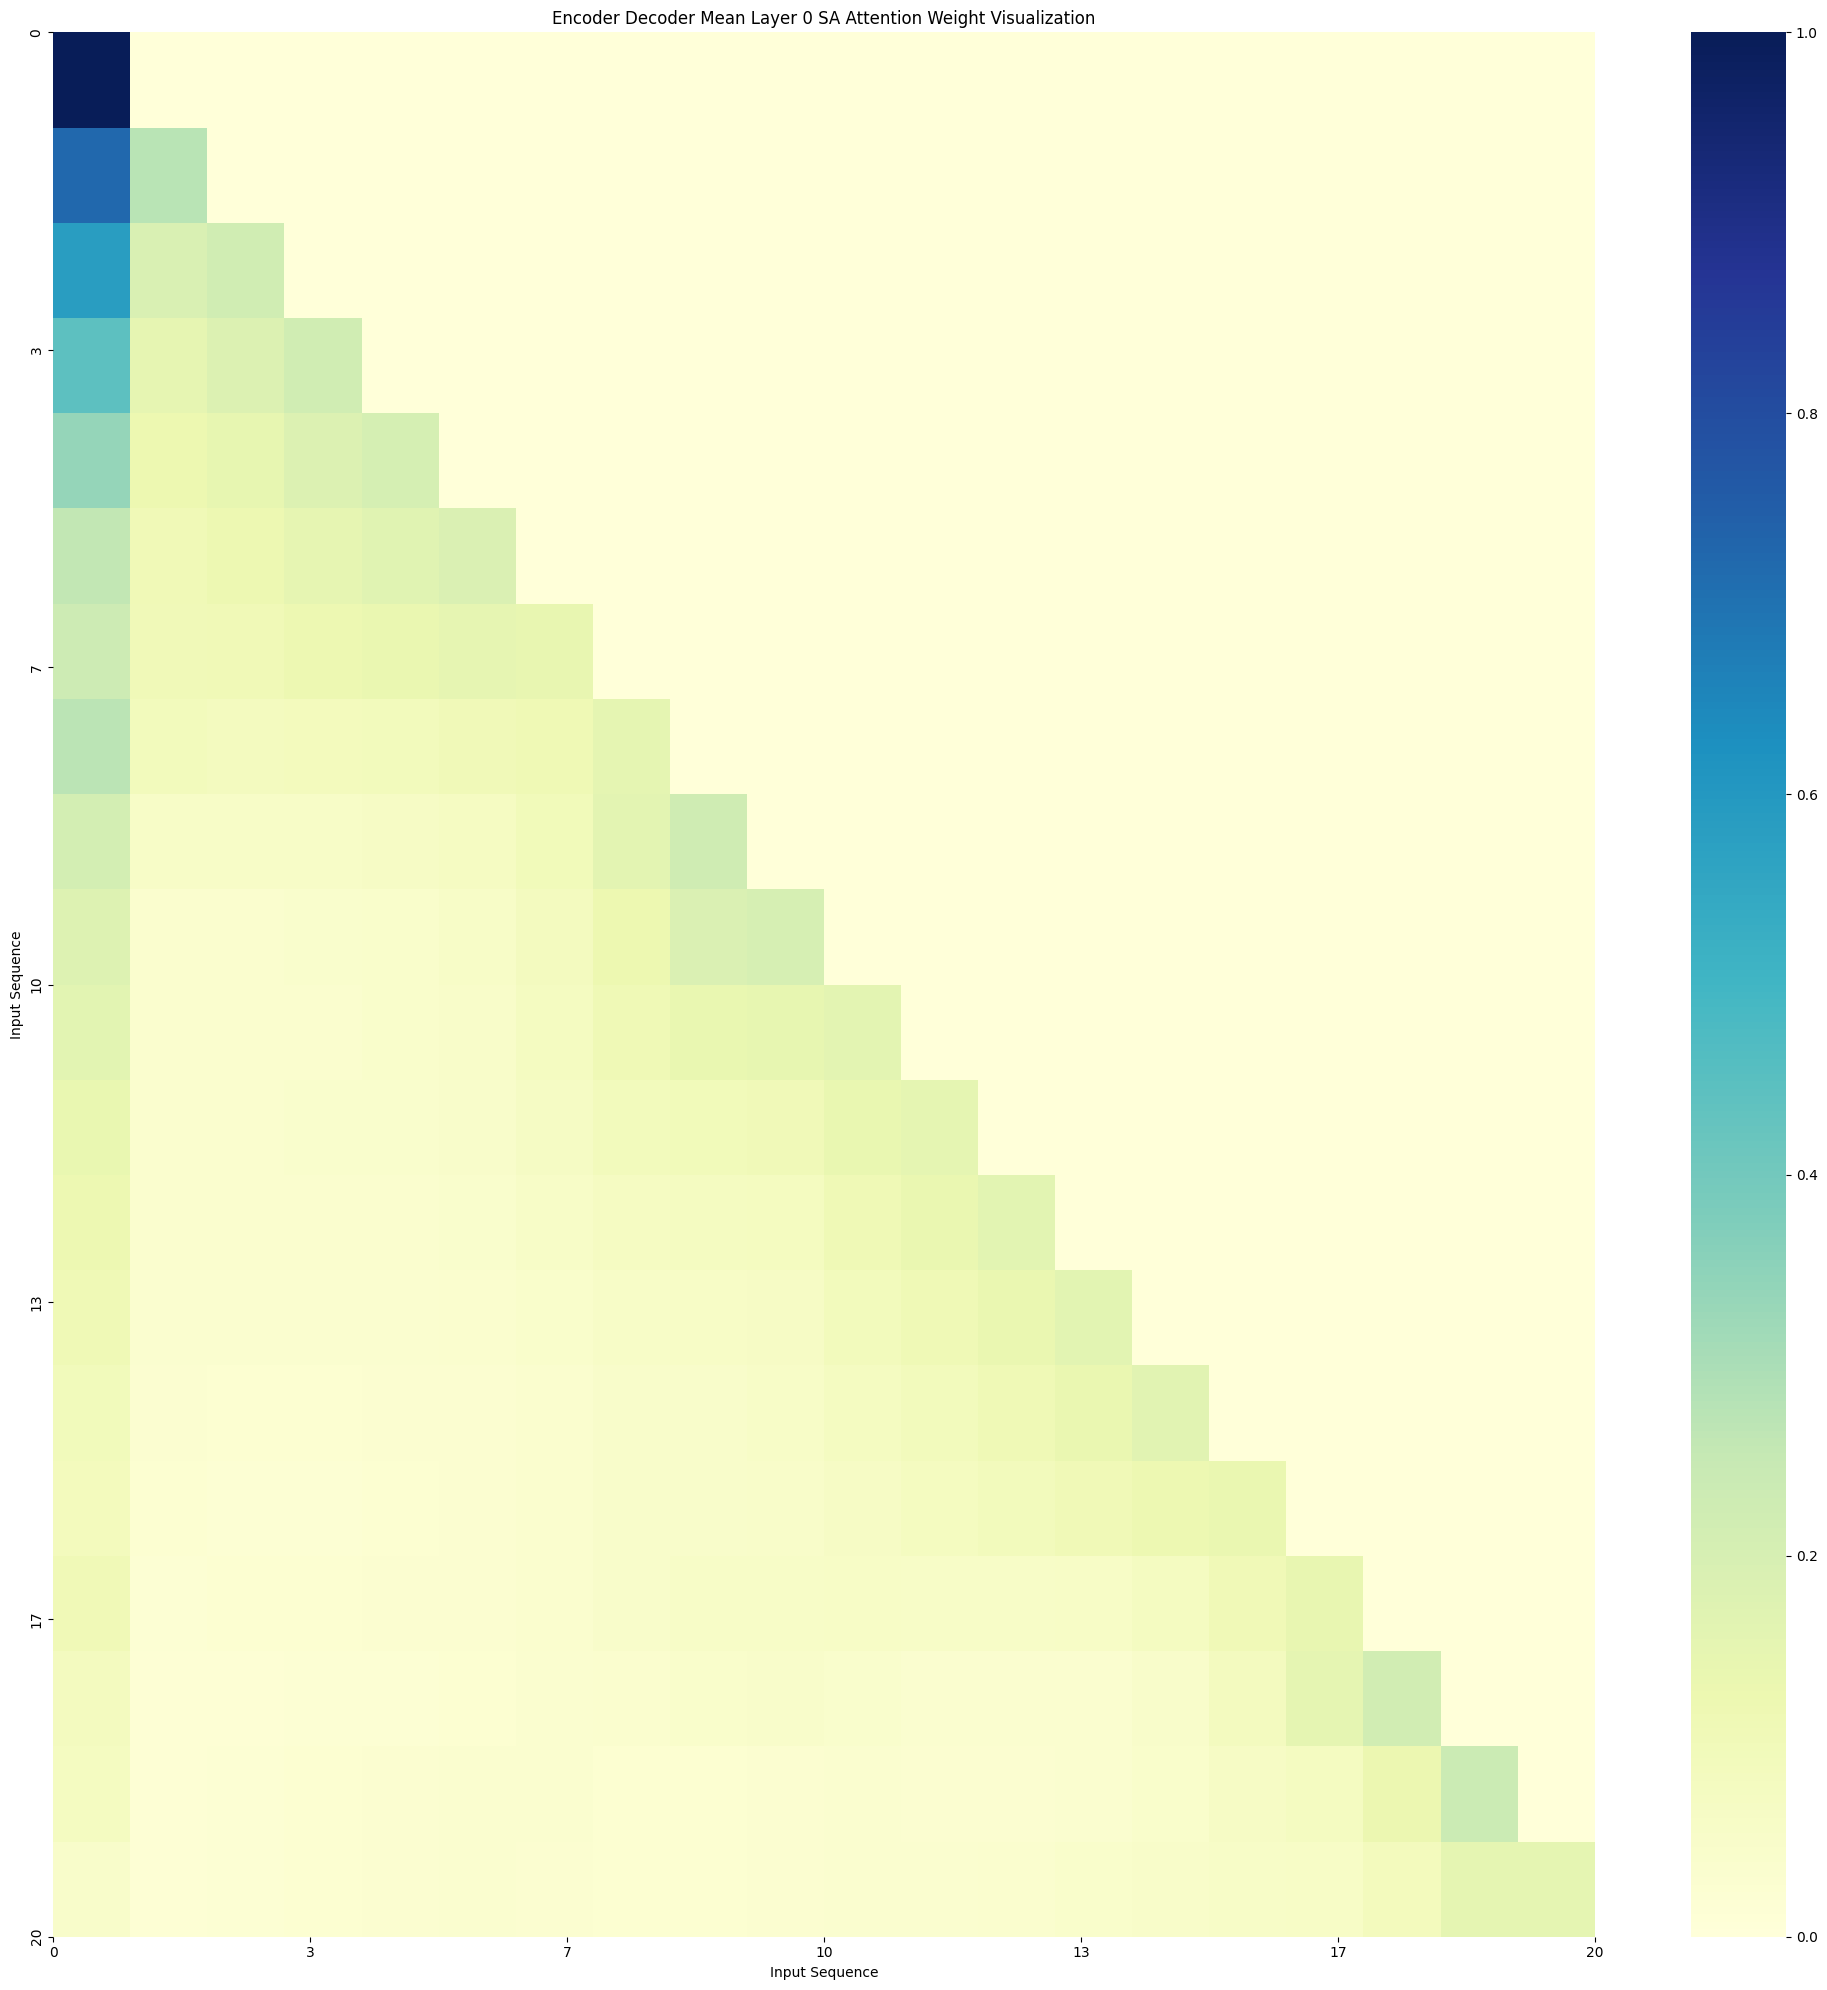

(20, 129)


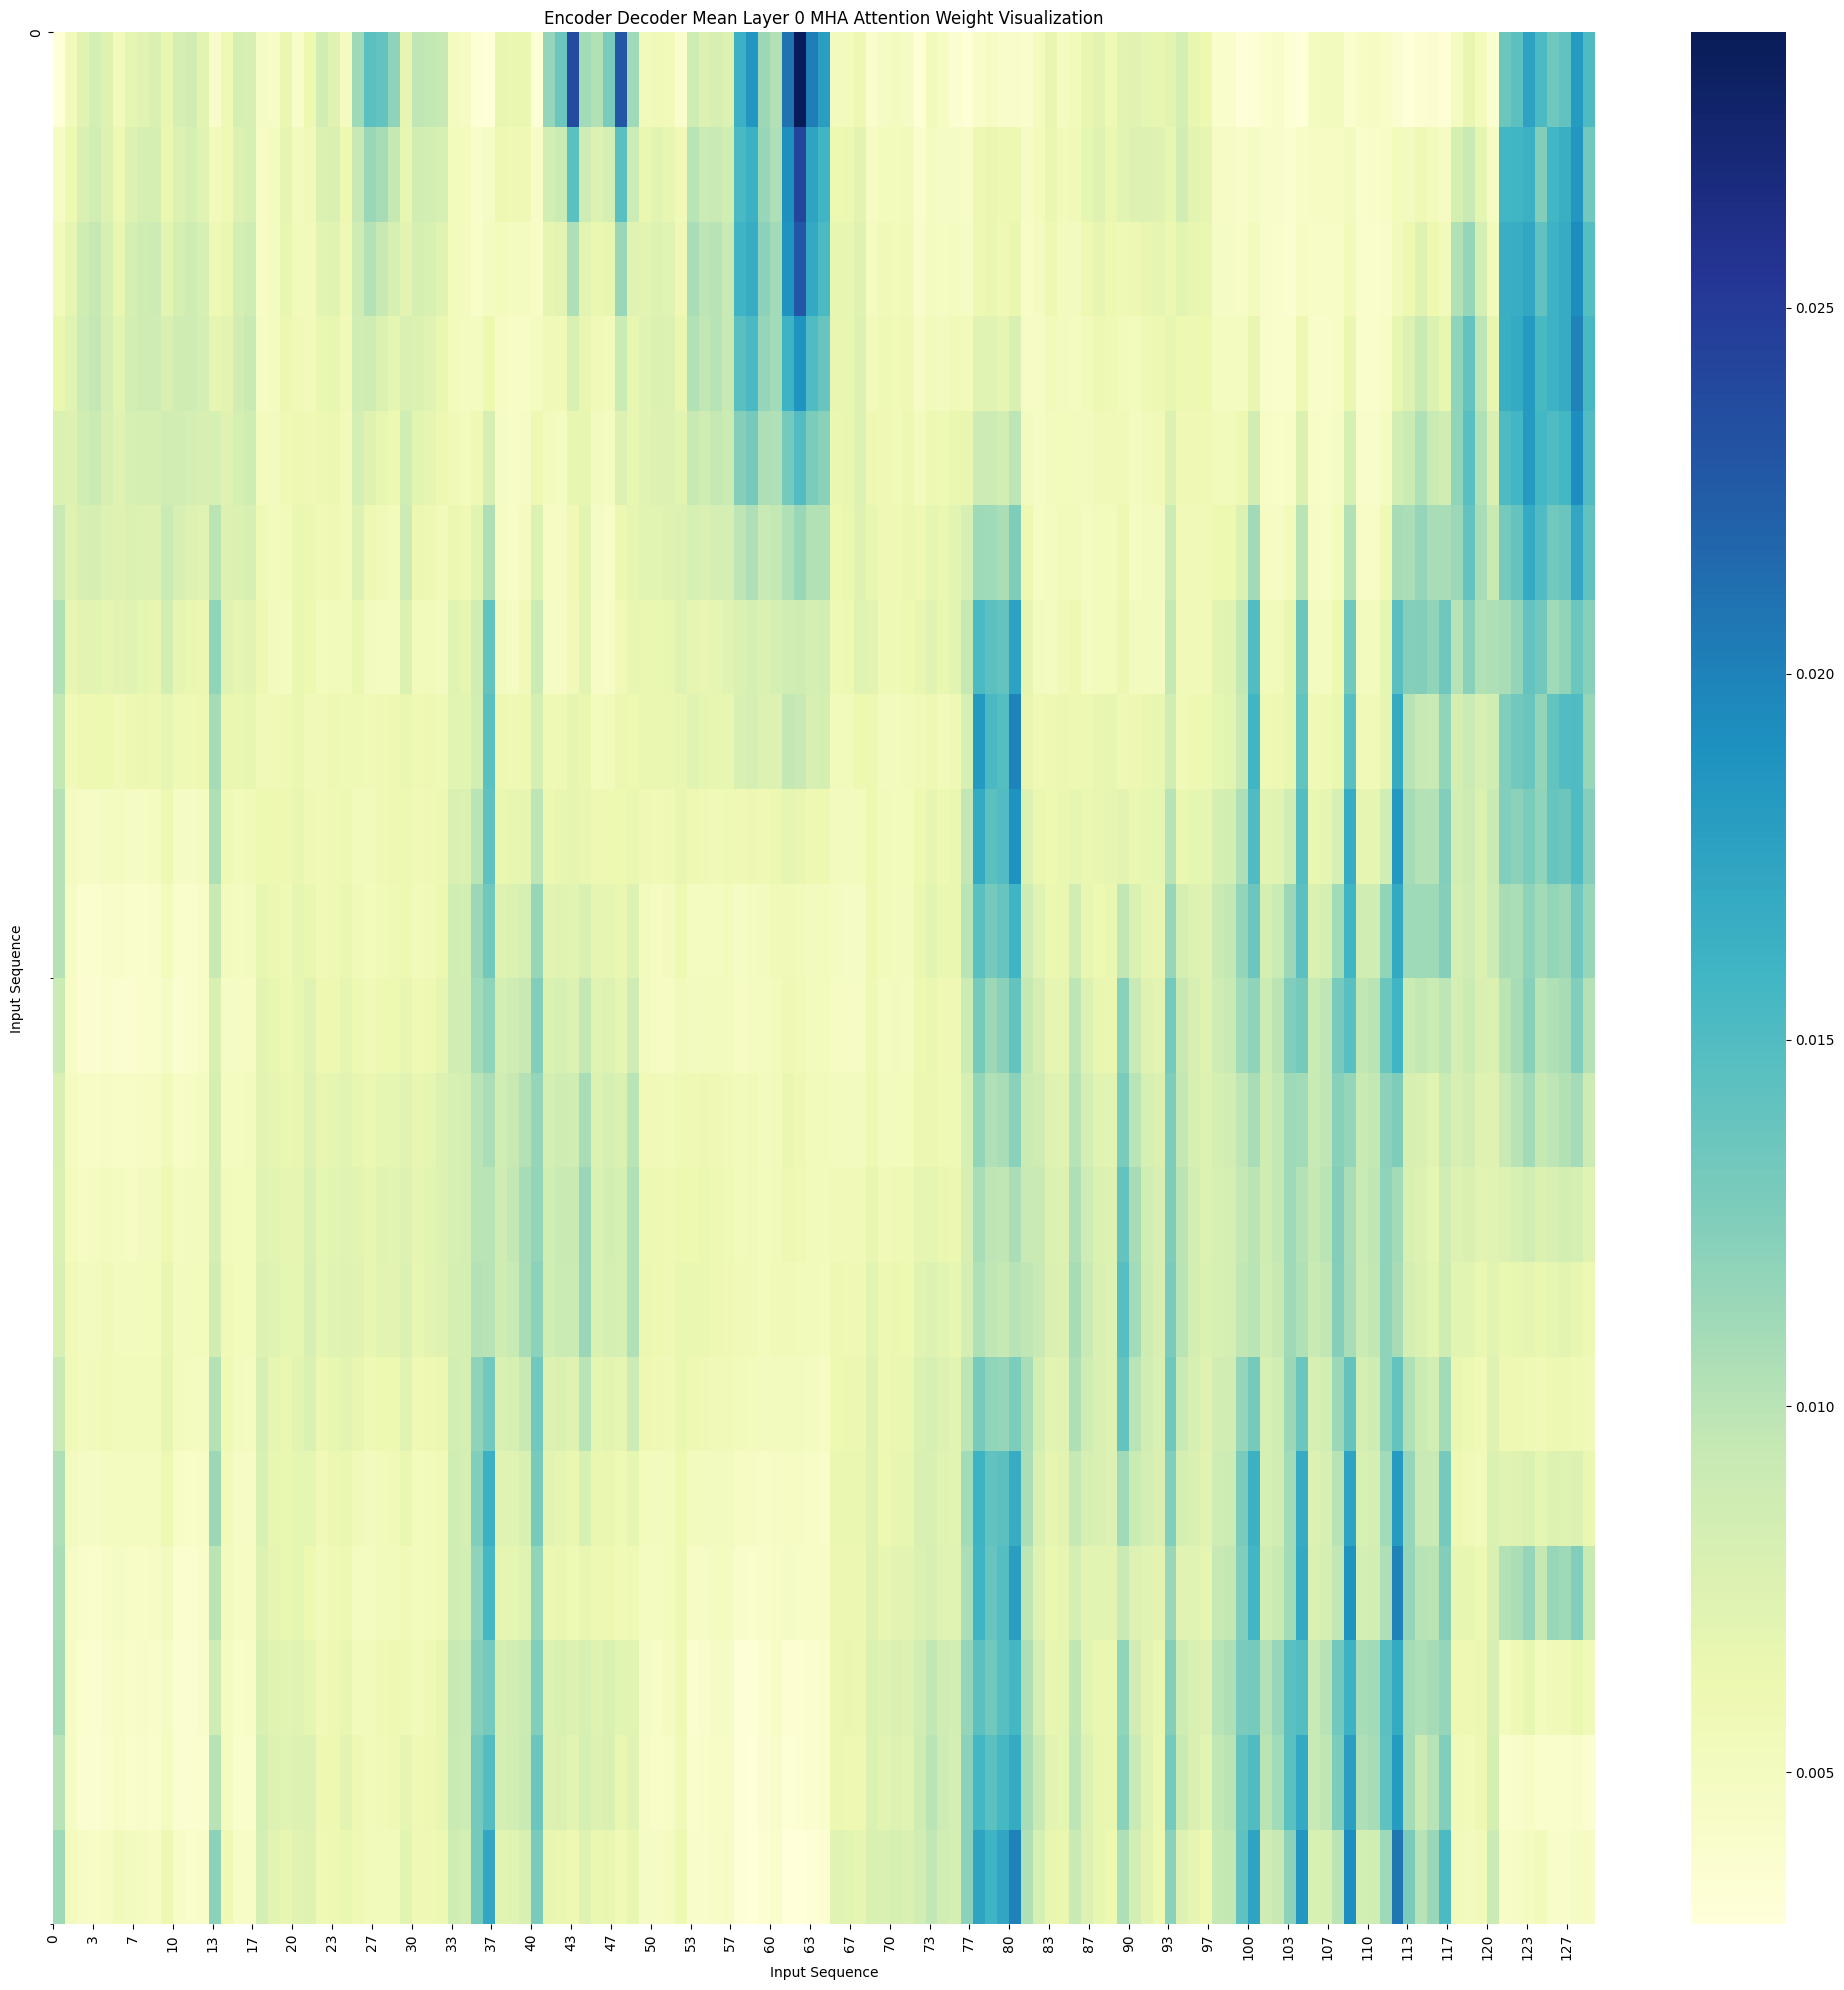

(1200, 1200)


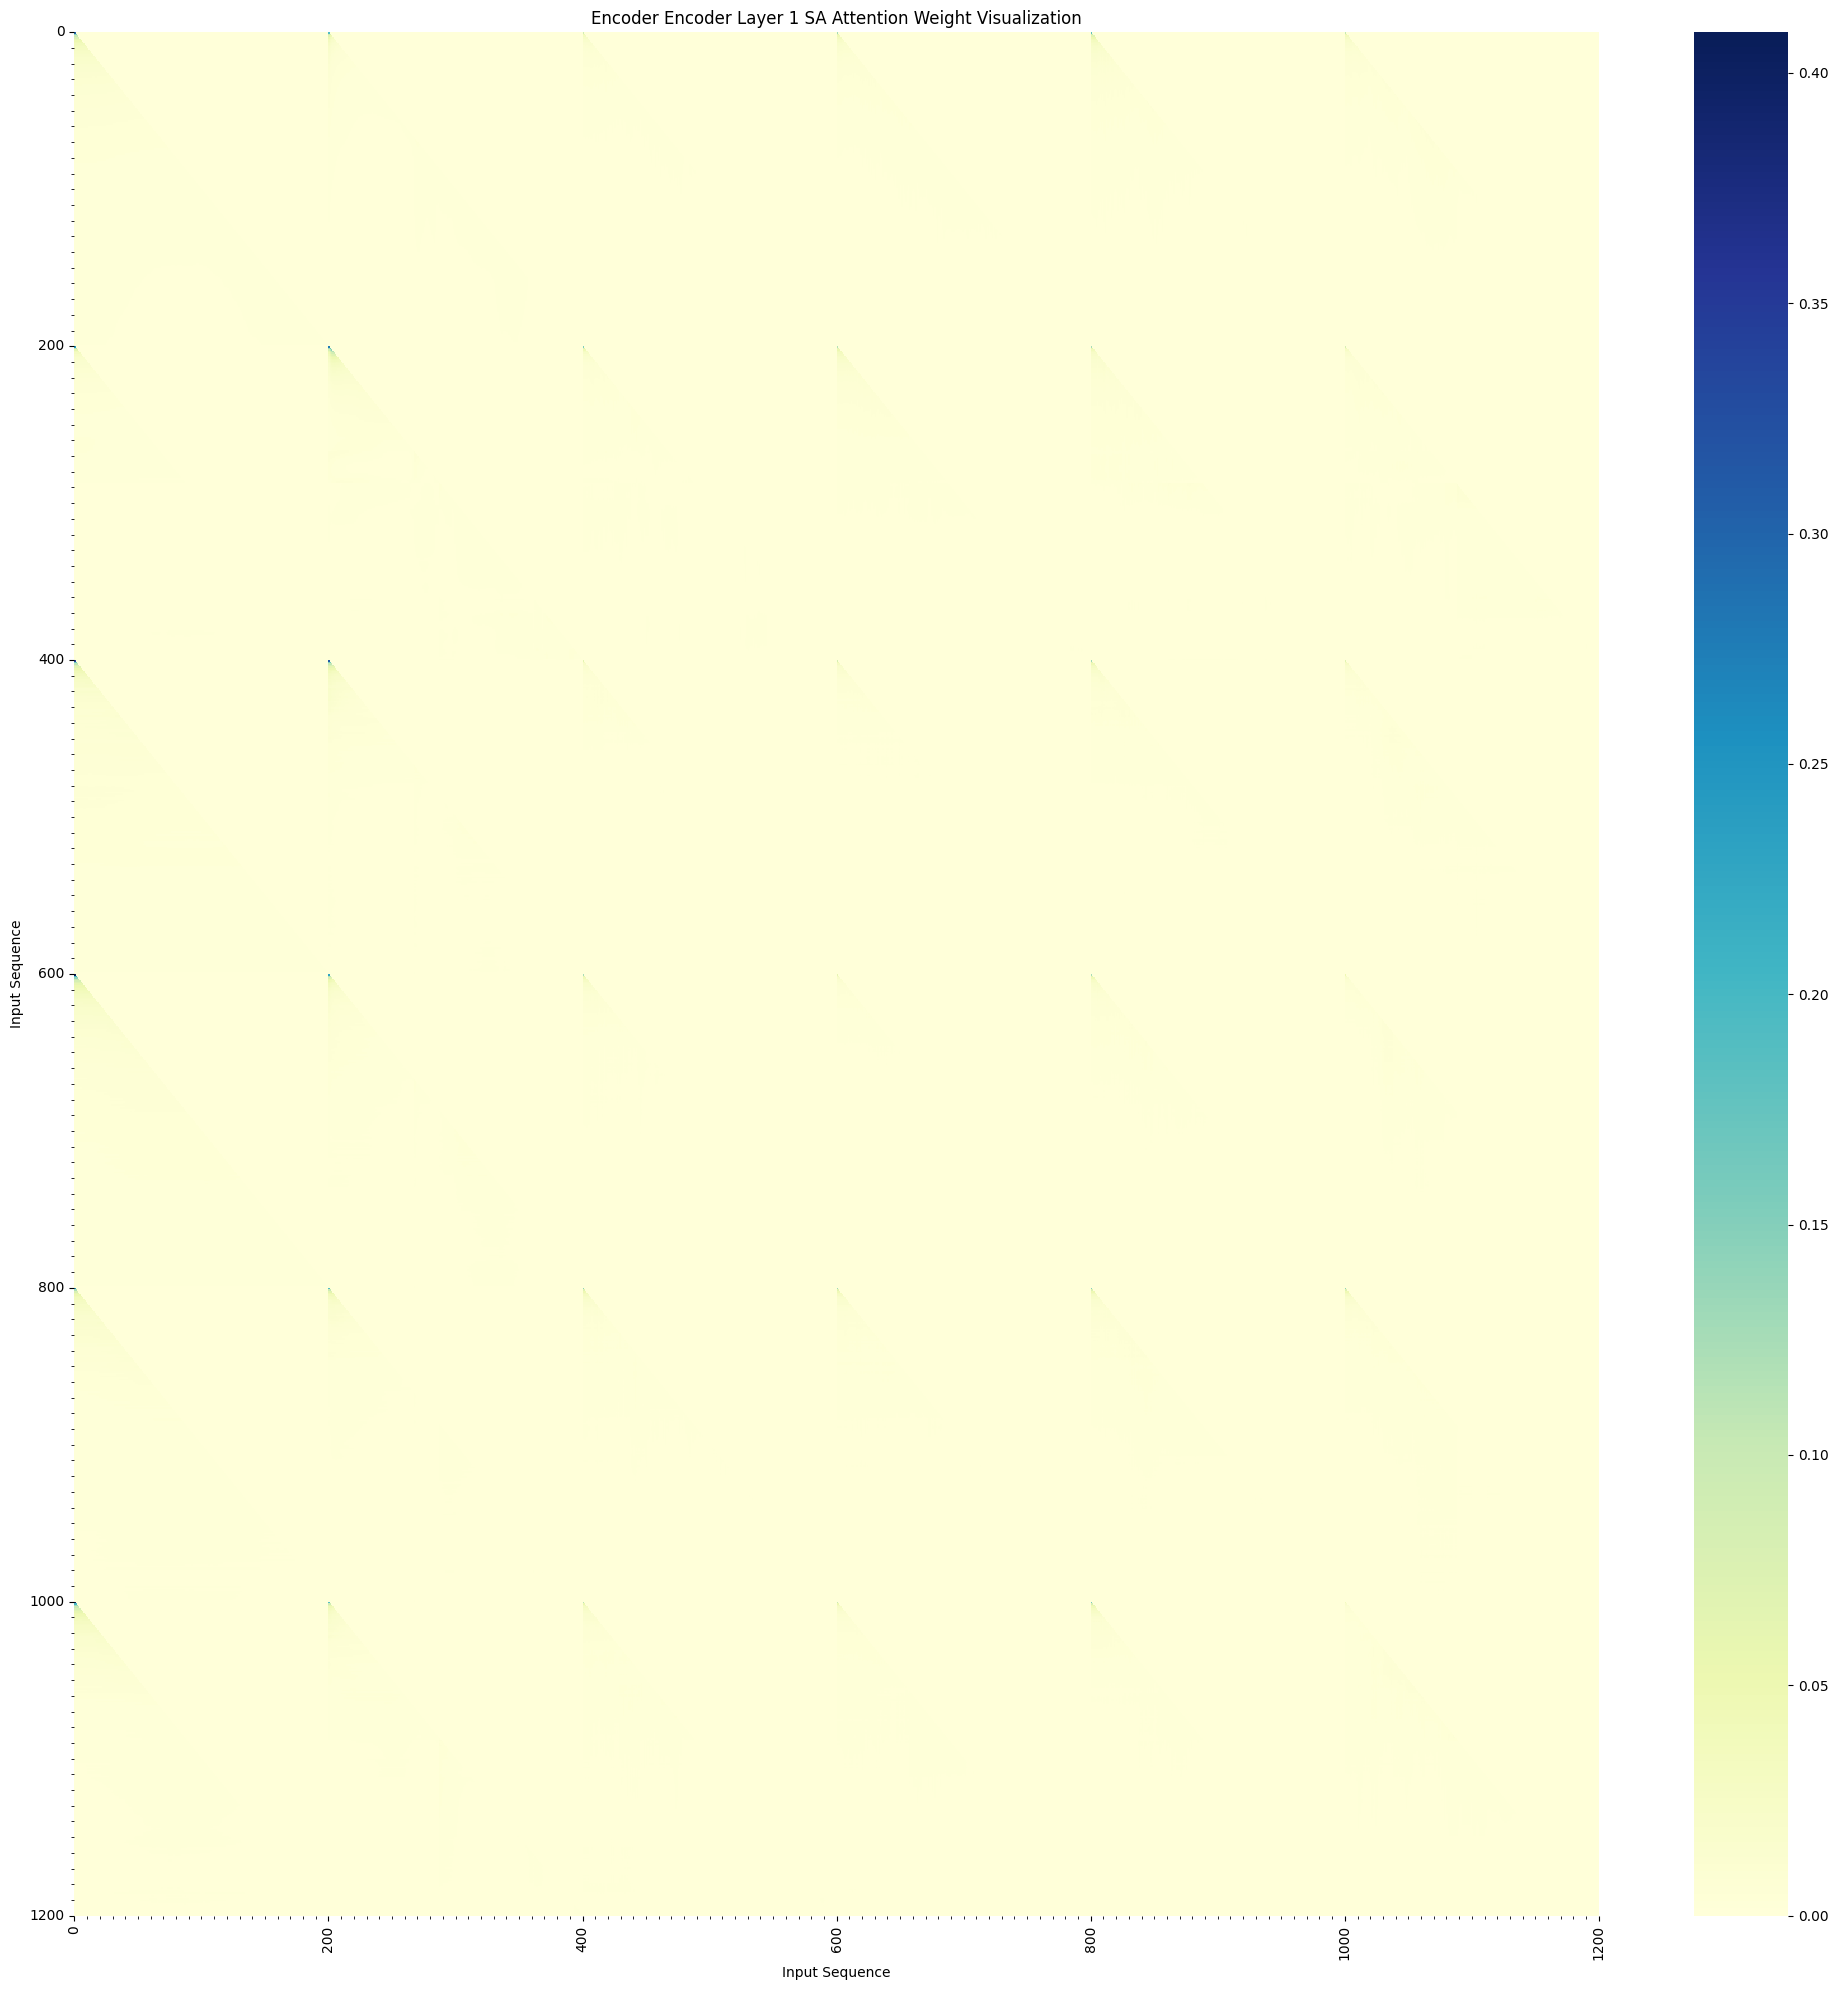

(1200, 1200)


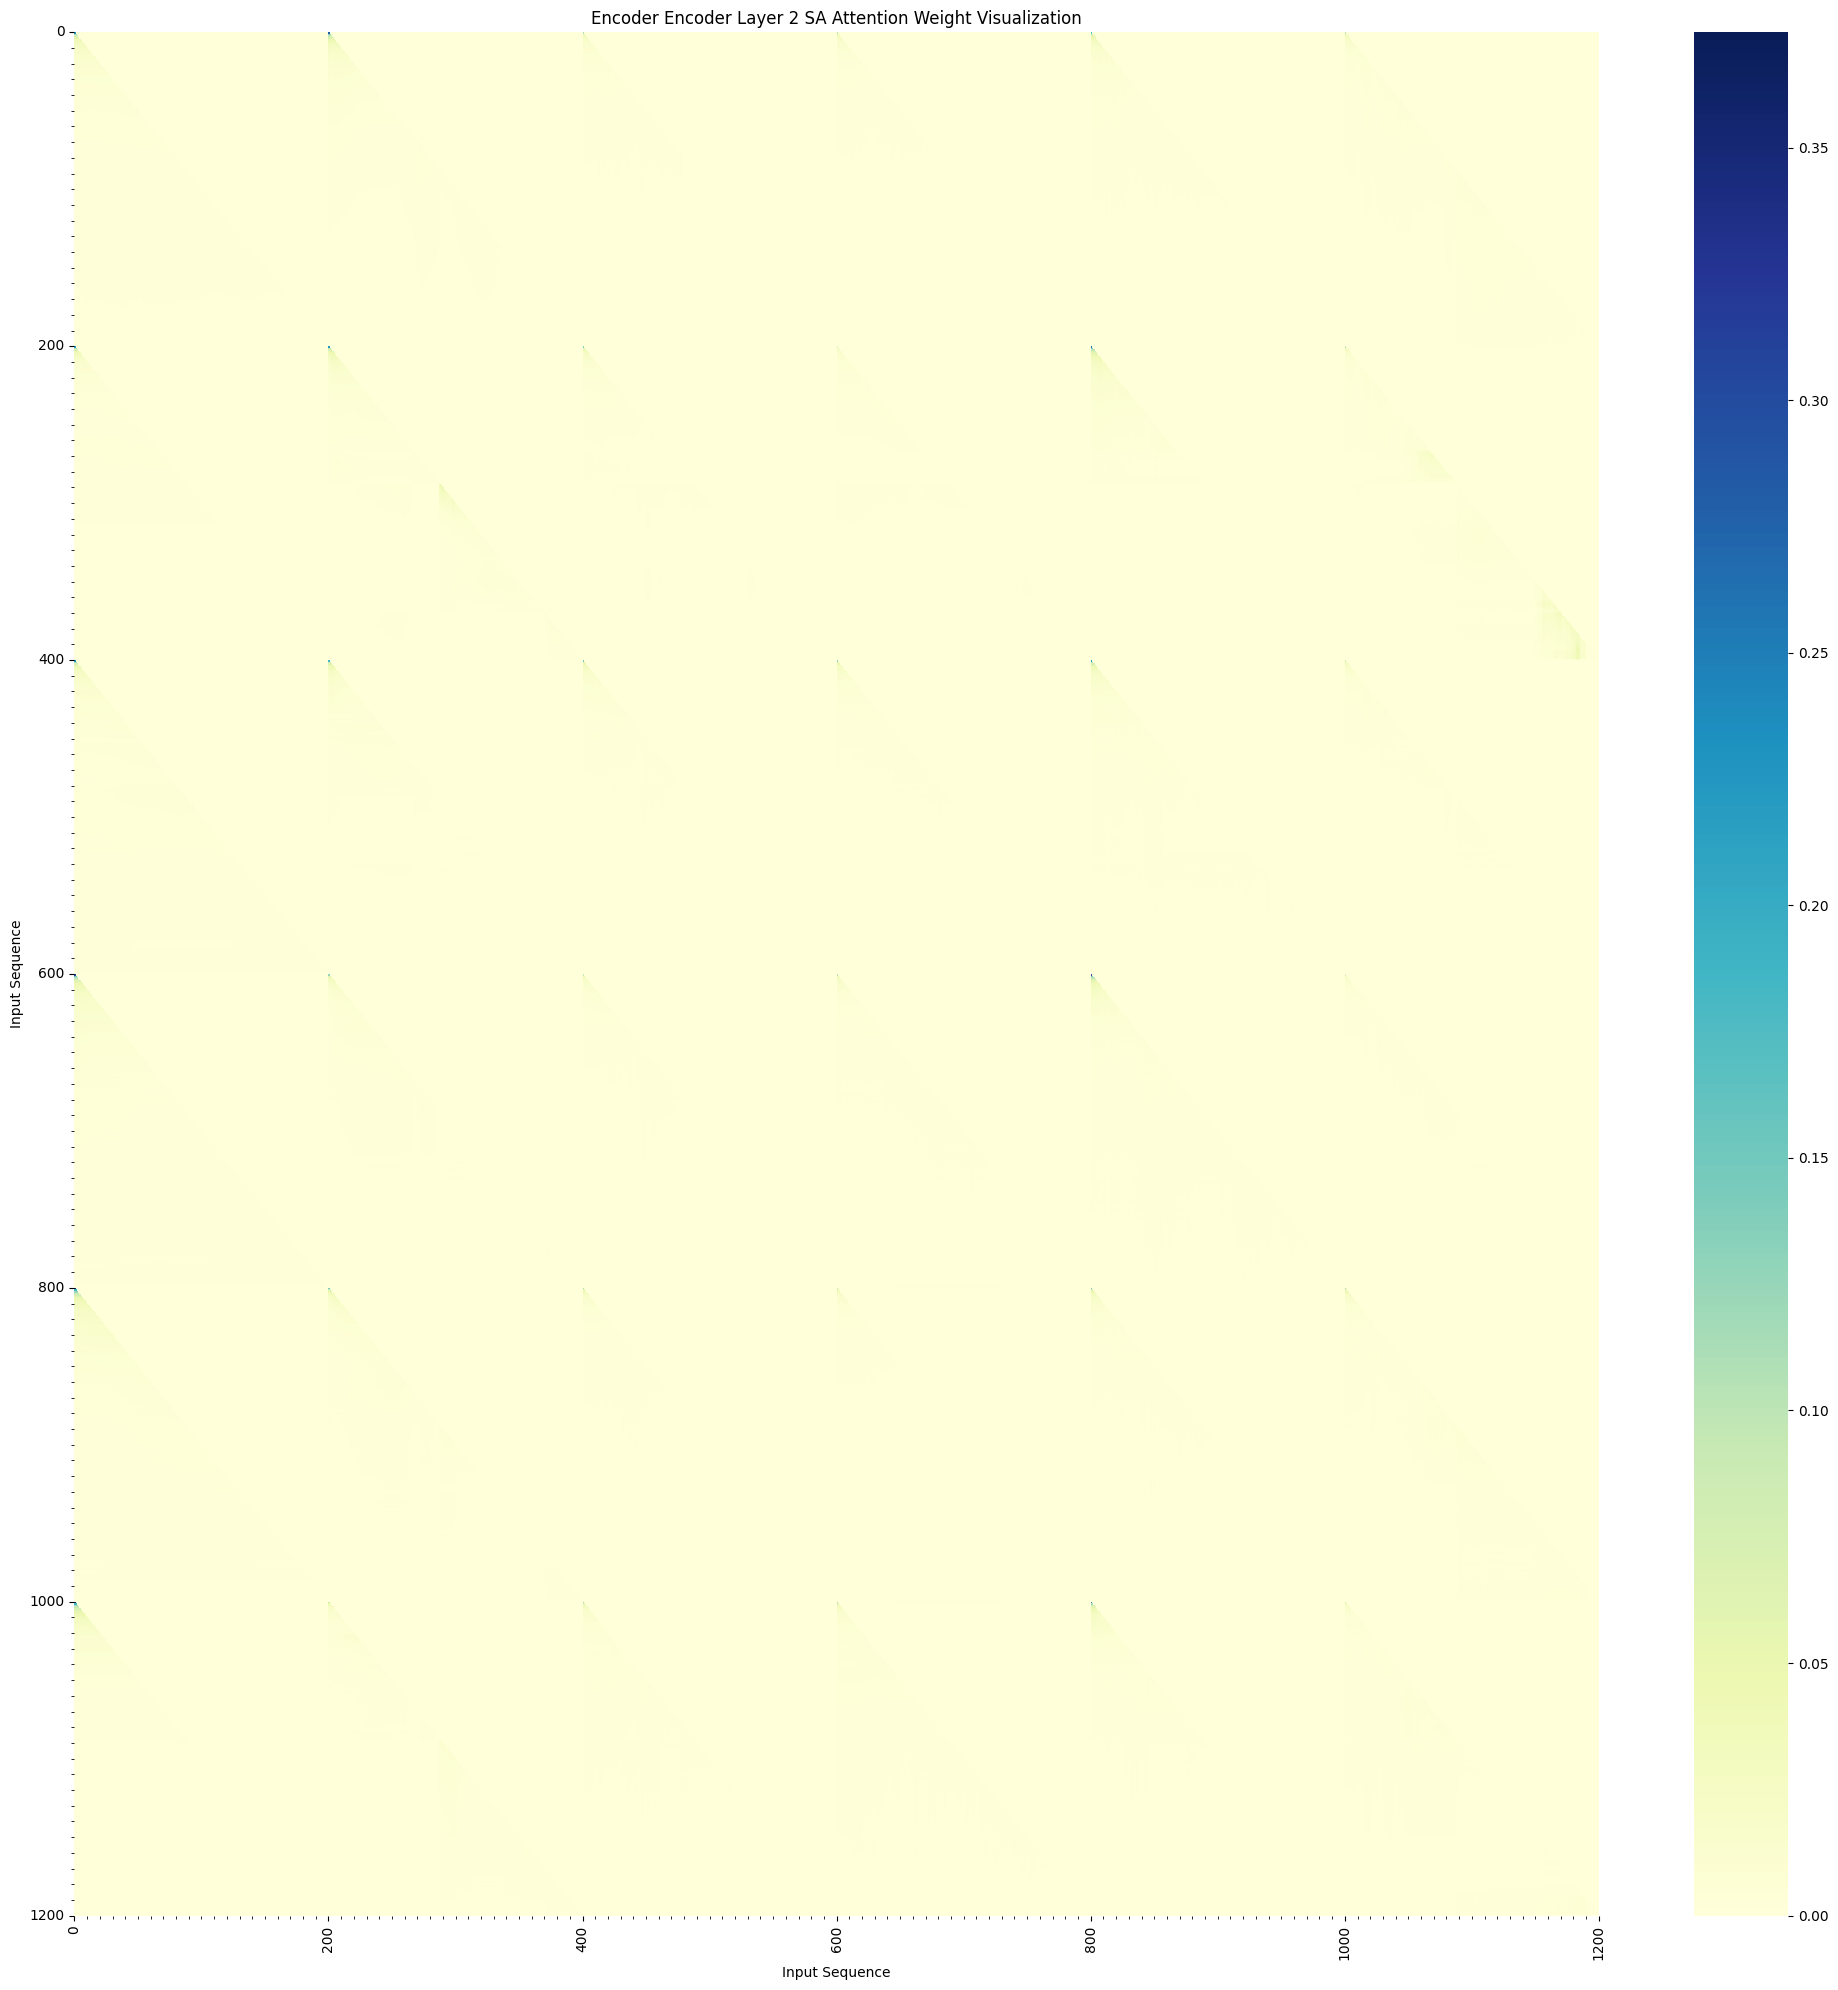

(1200, 1200)


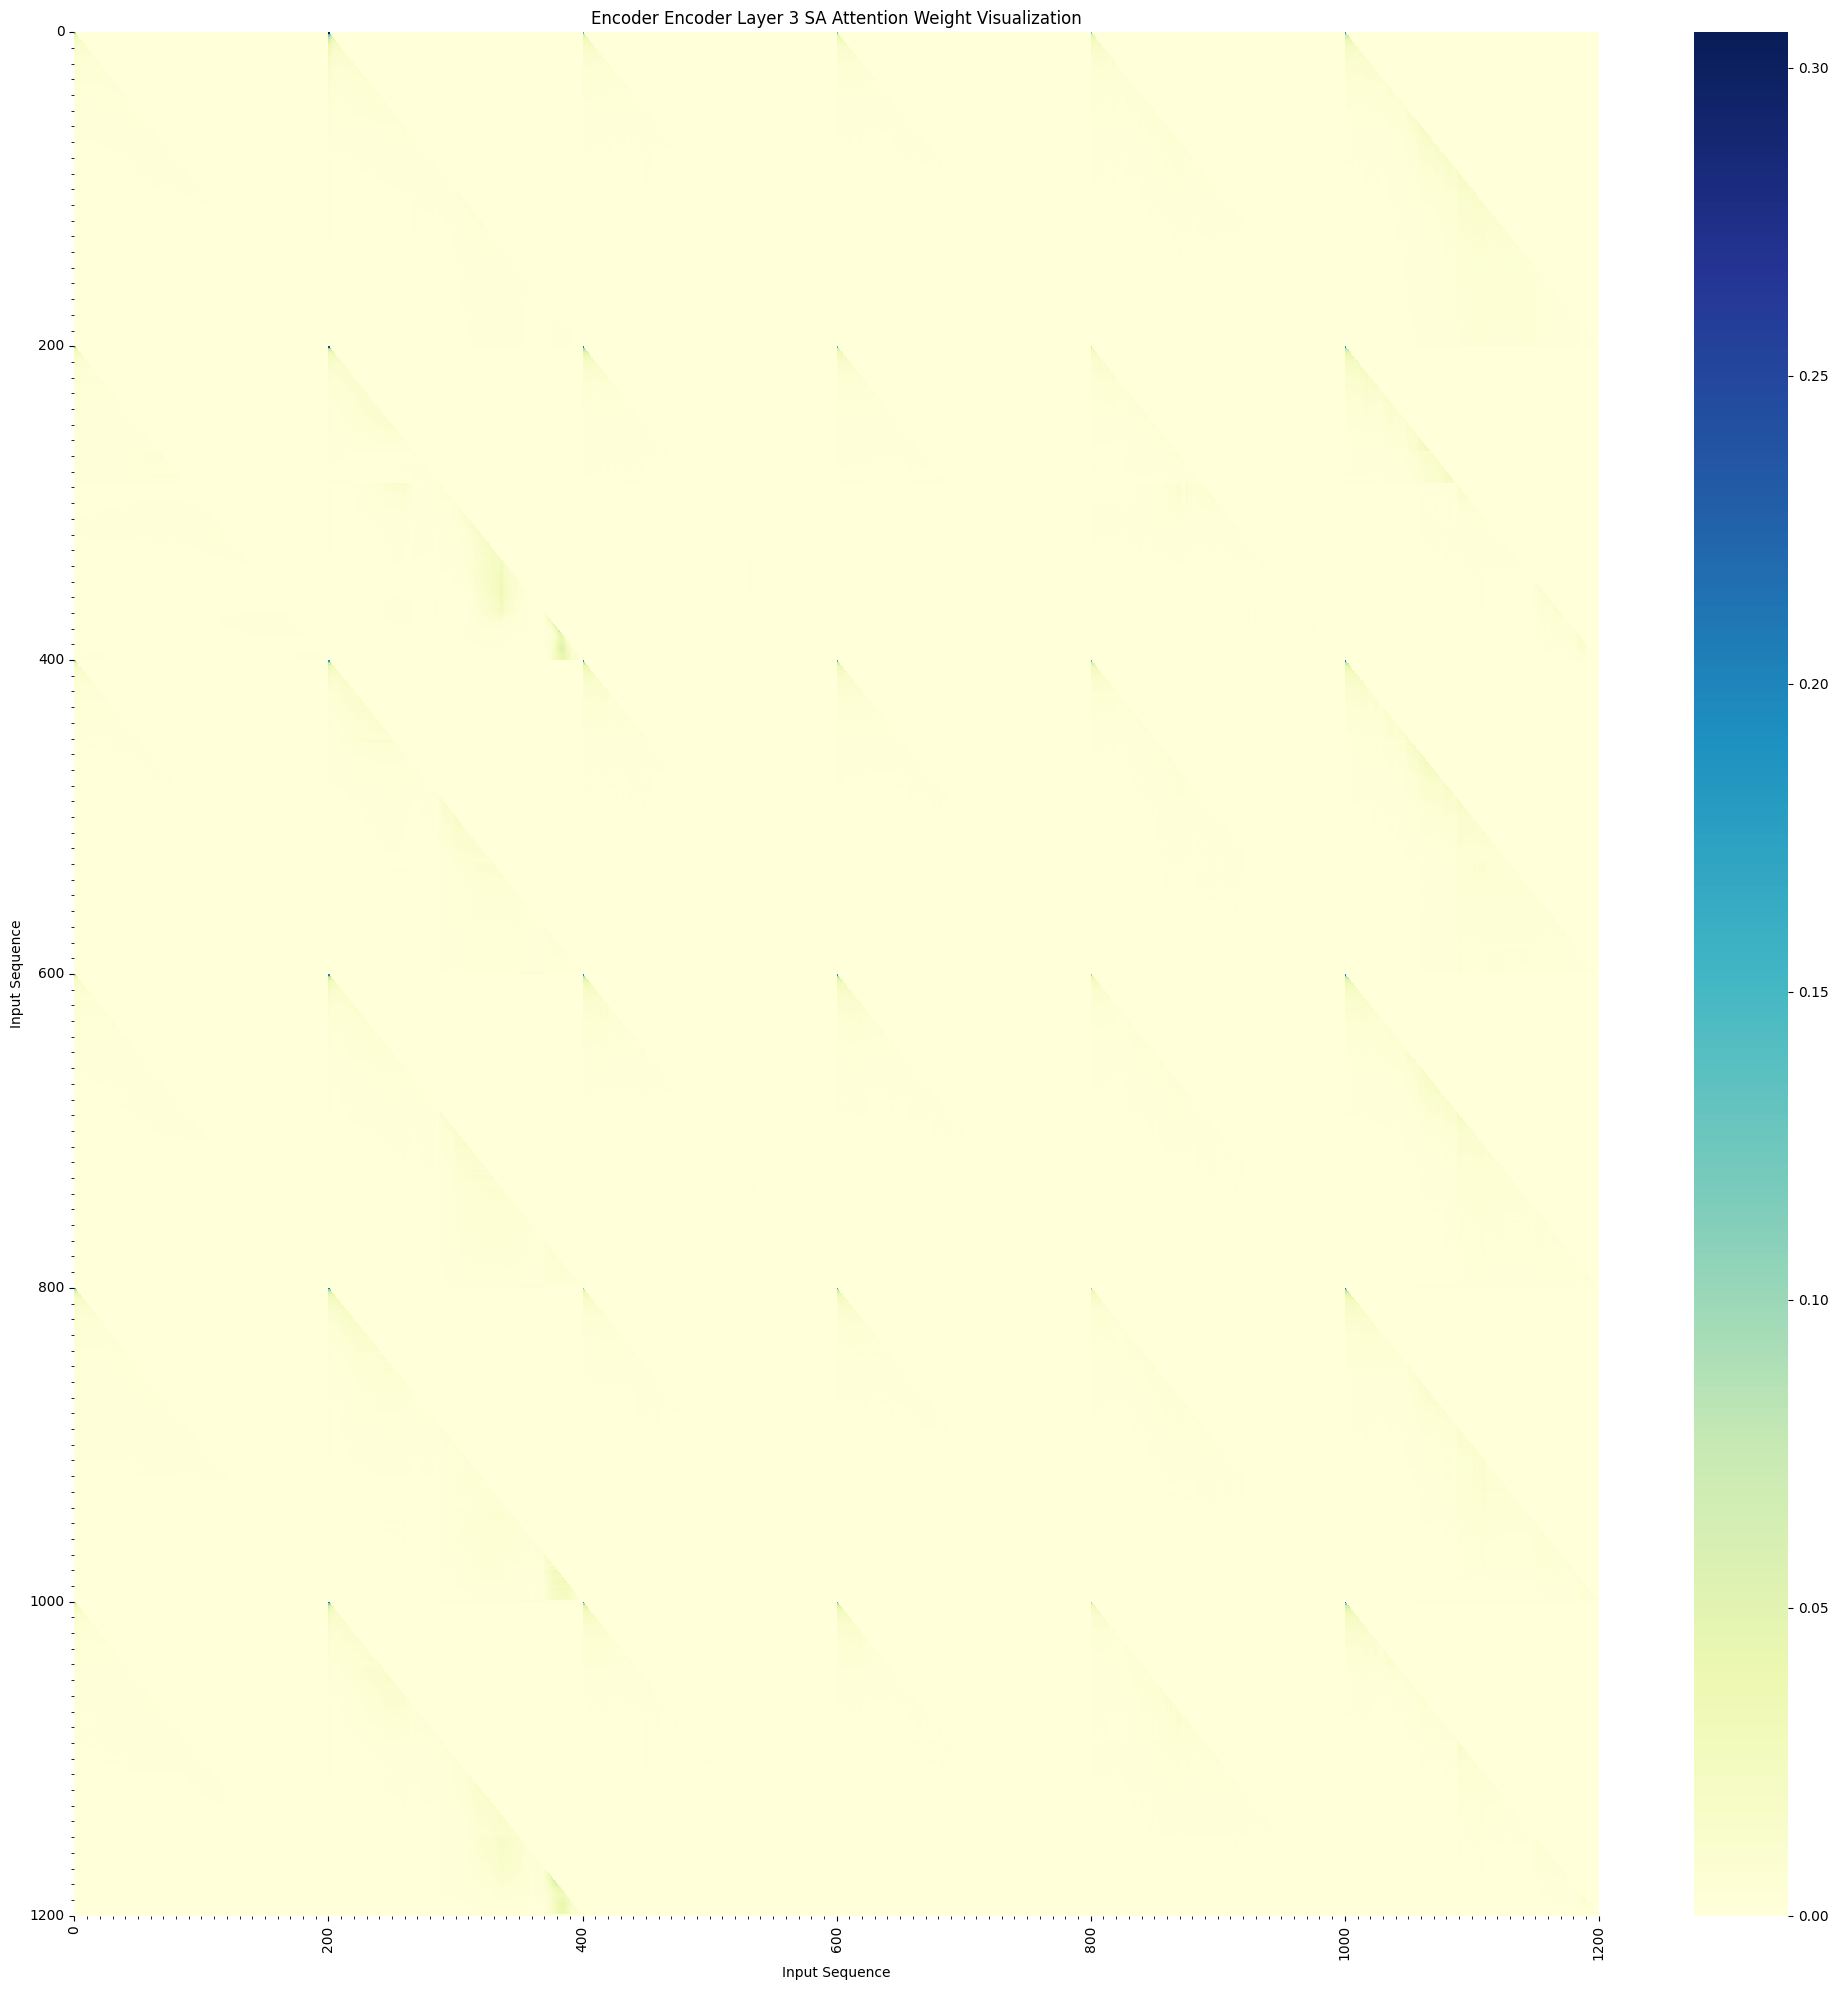

(1200, 1200)


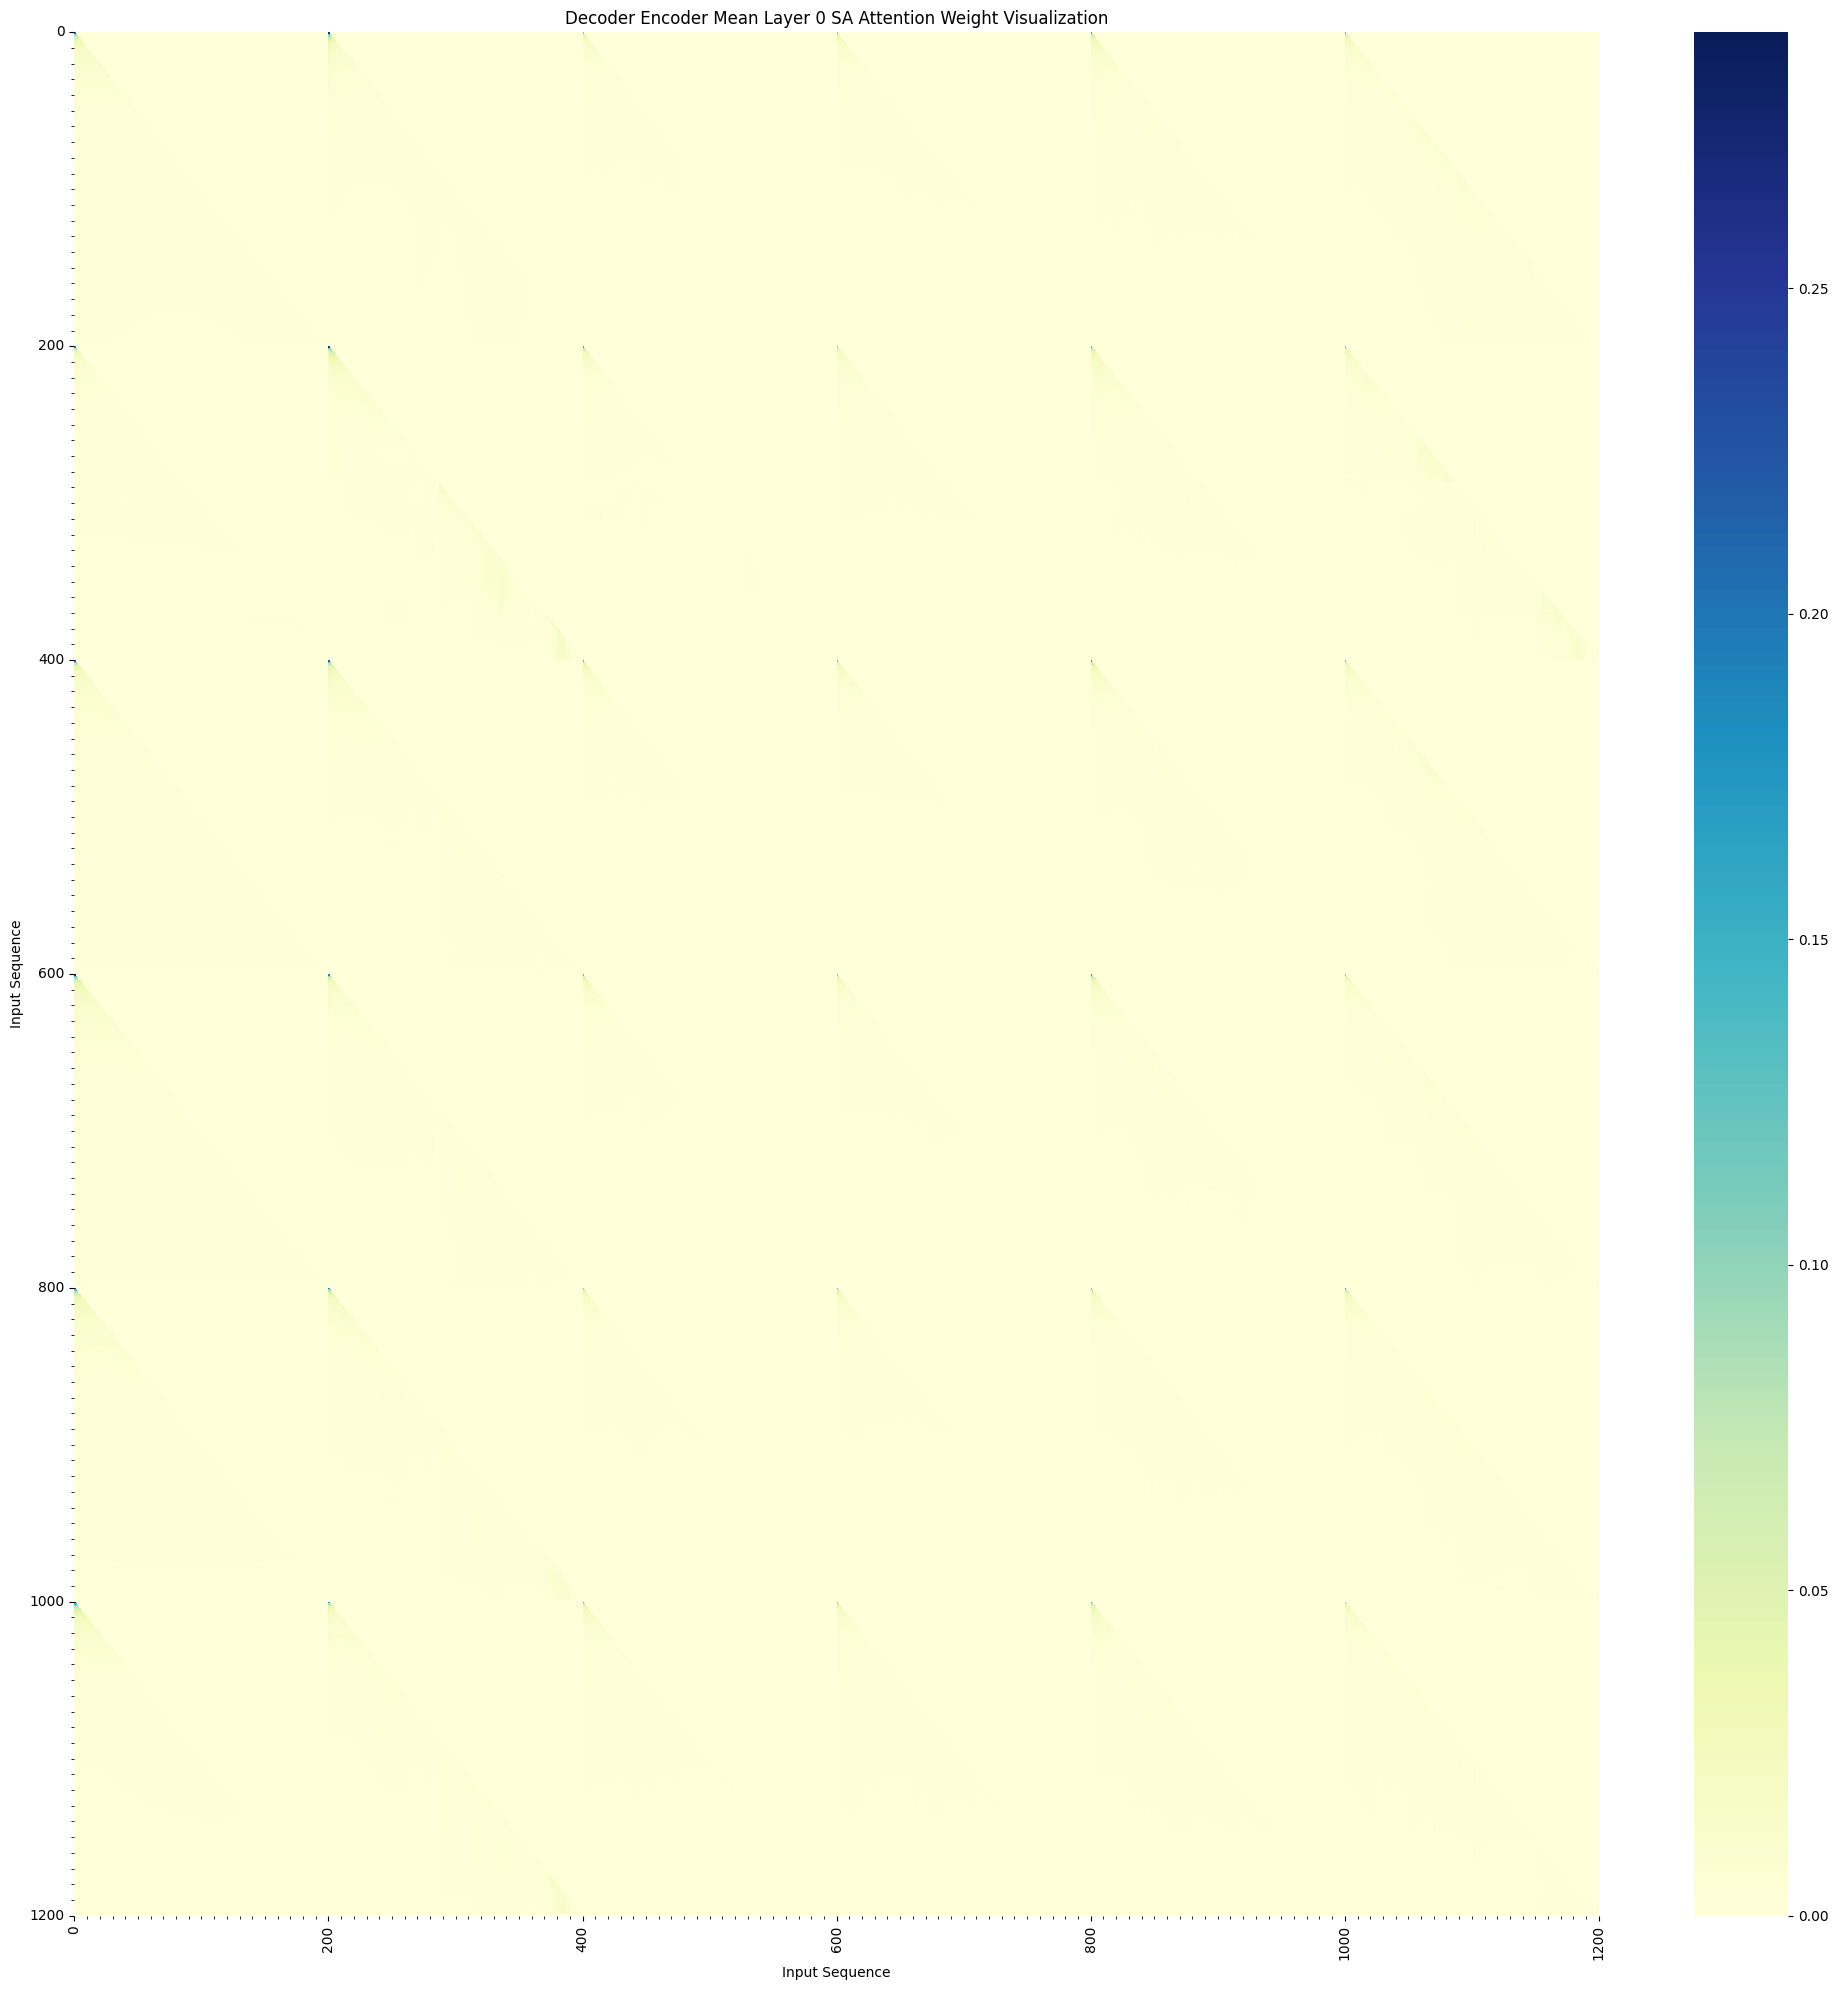

(20, 20)


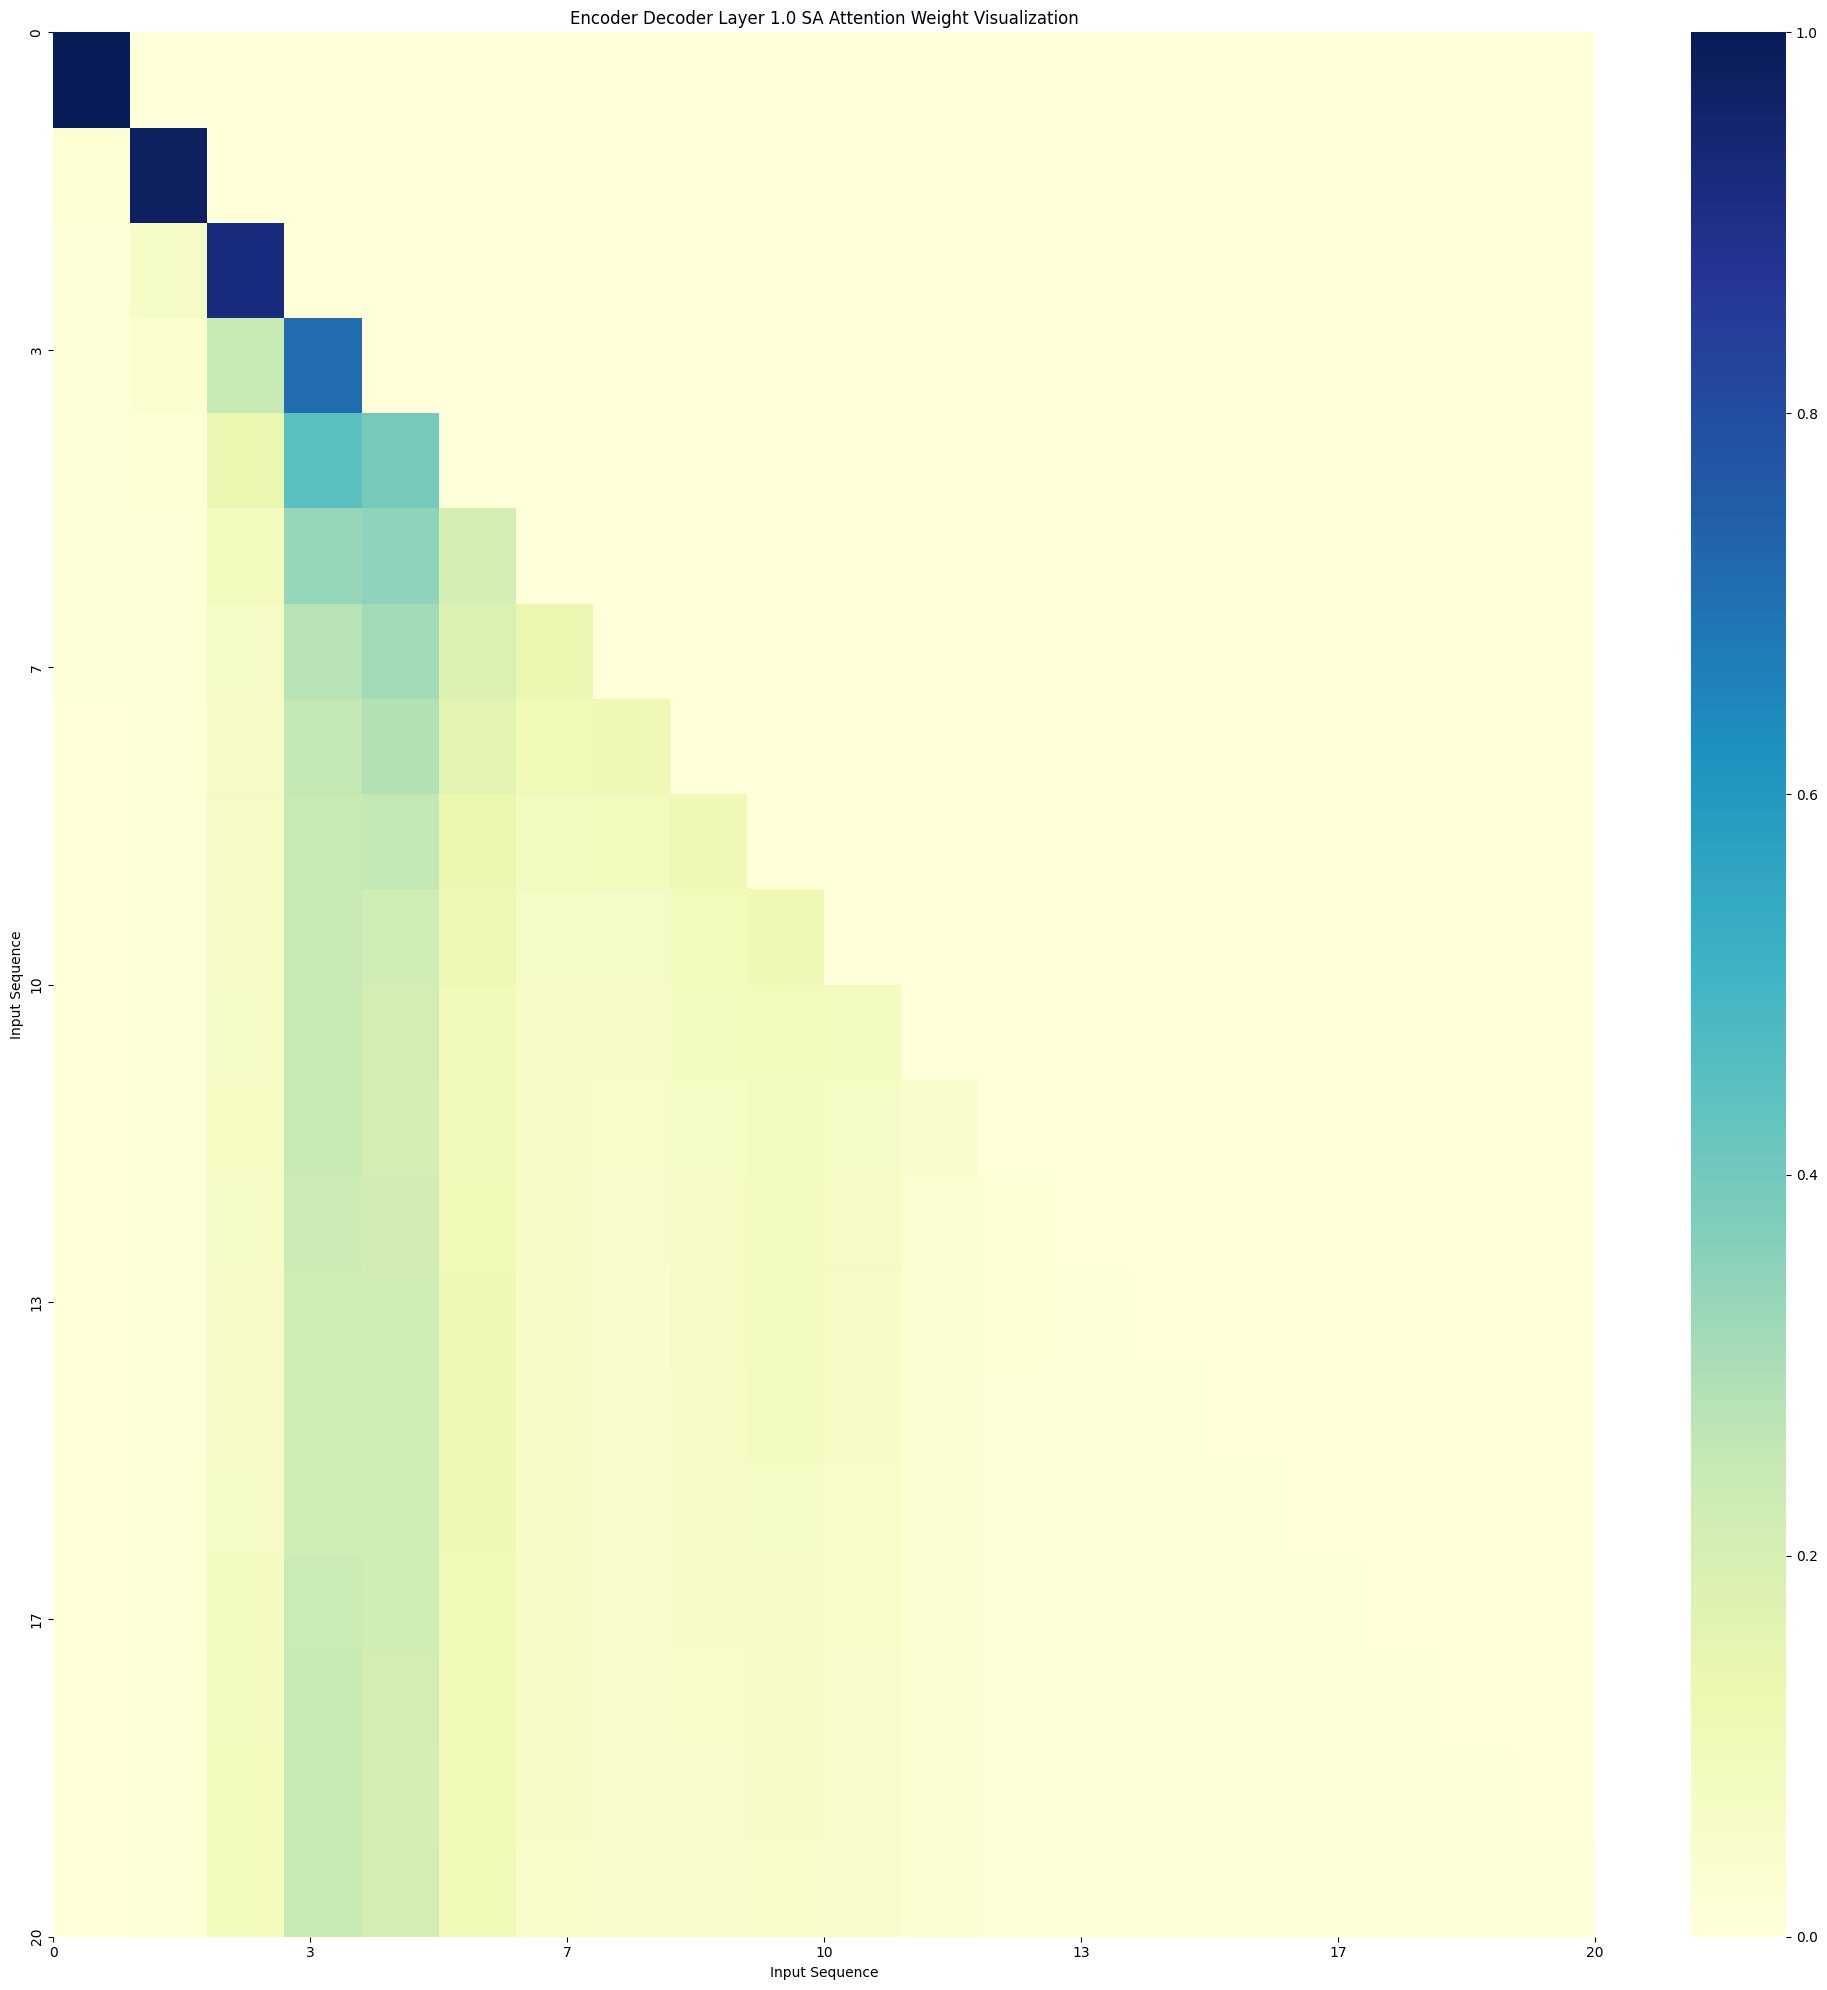

(20, 1200)


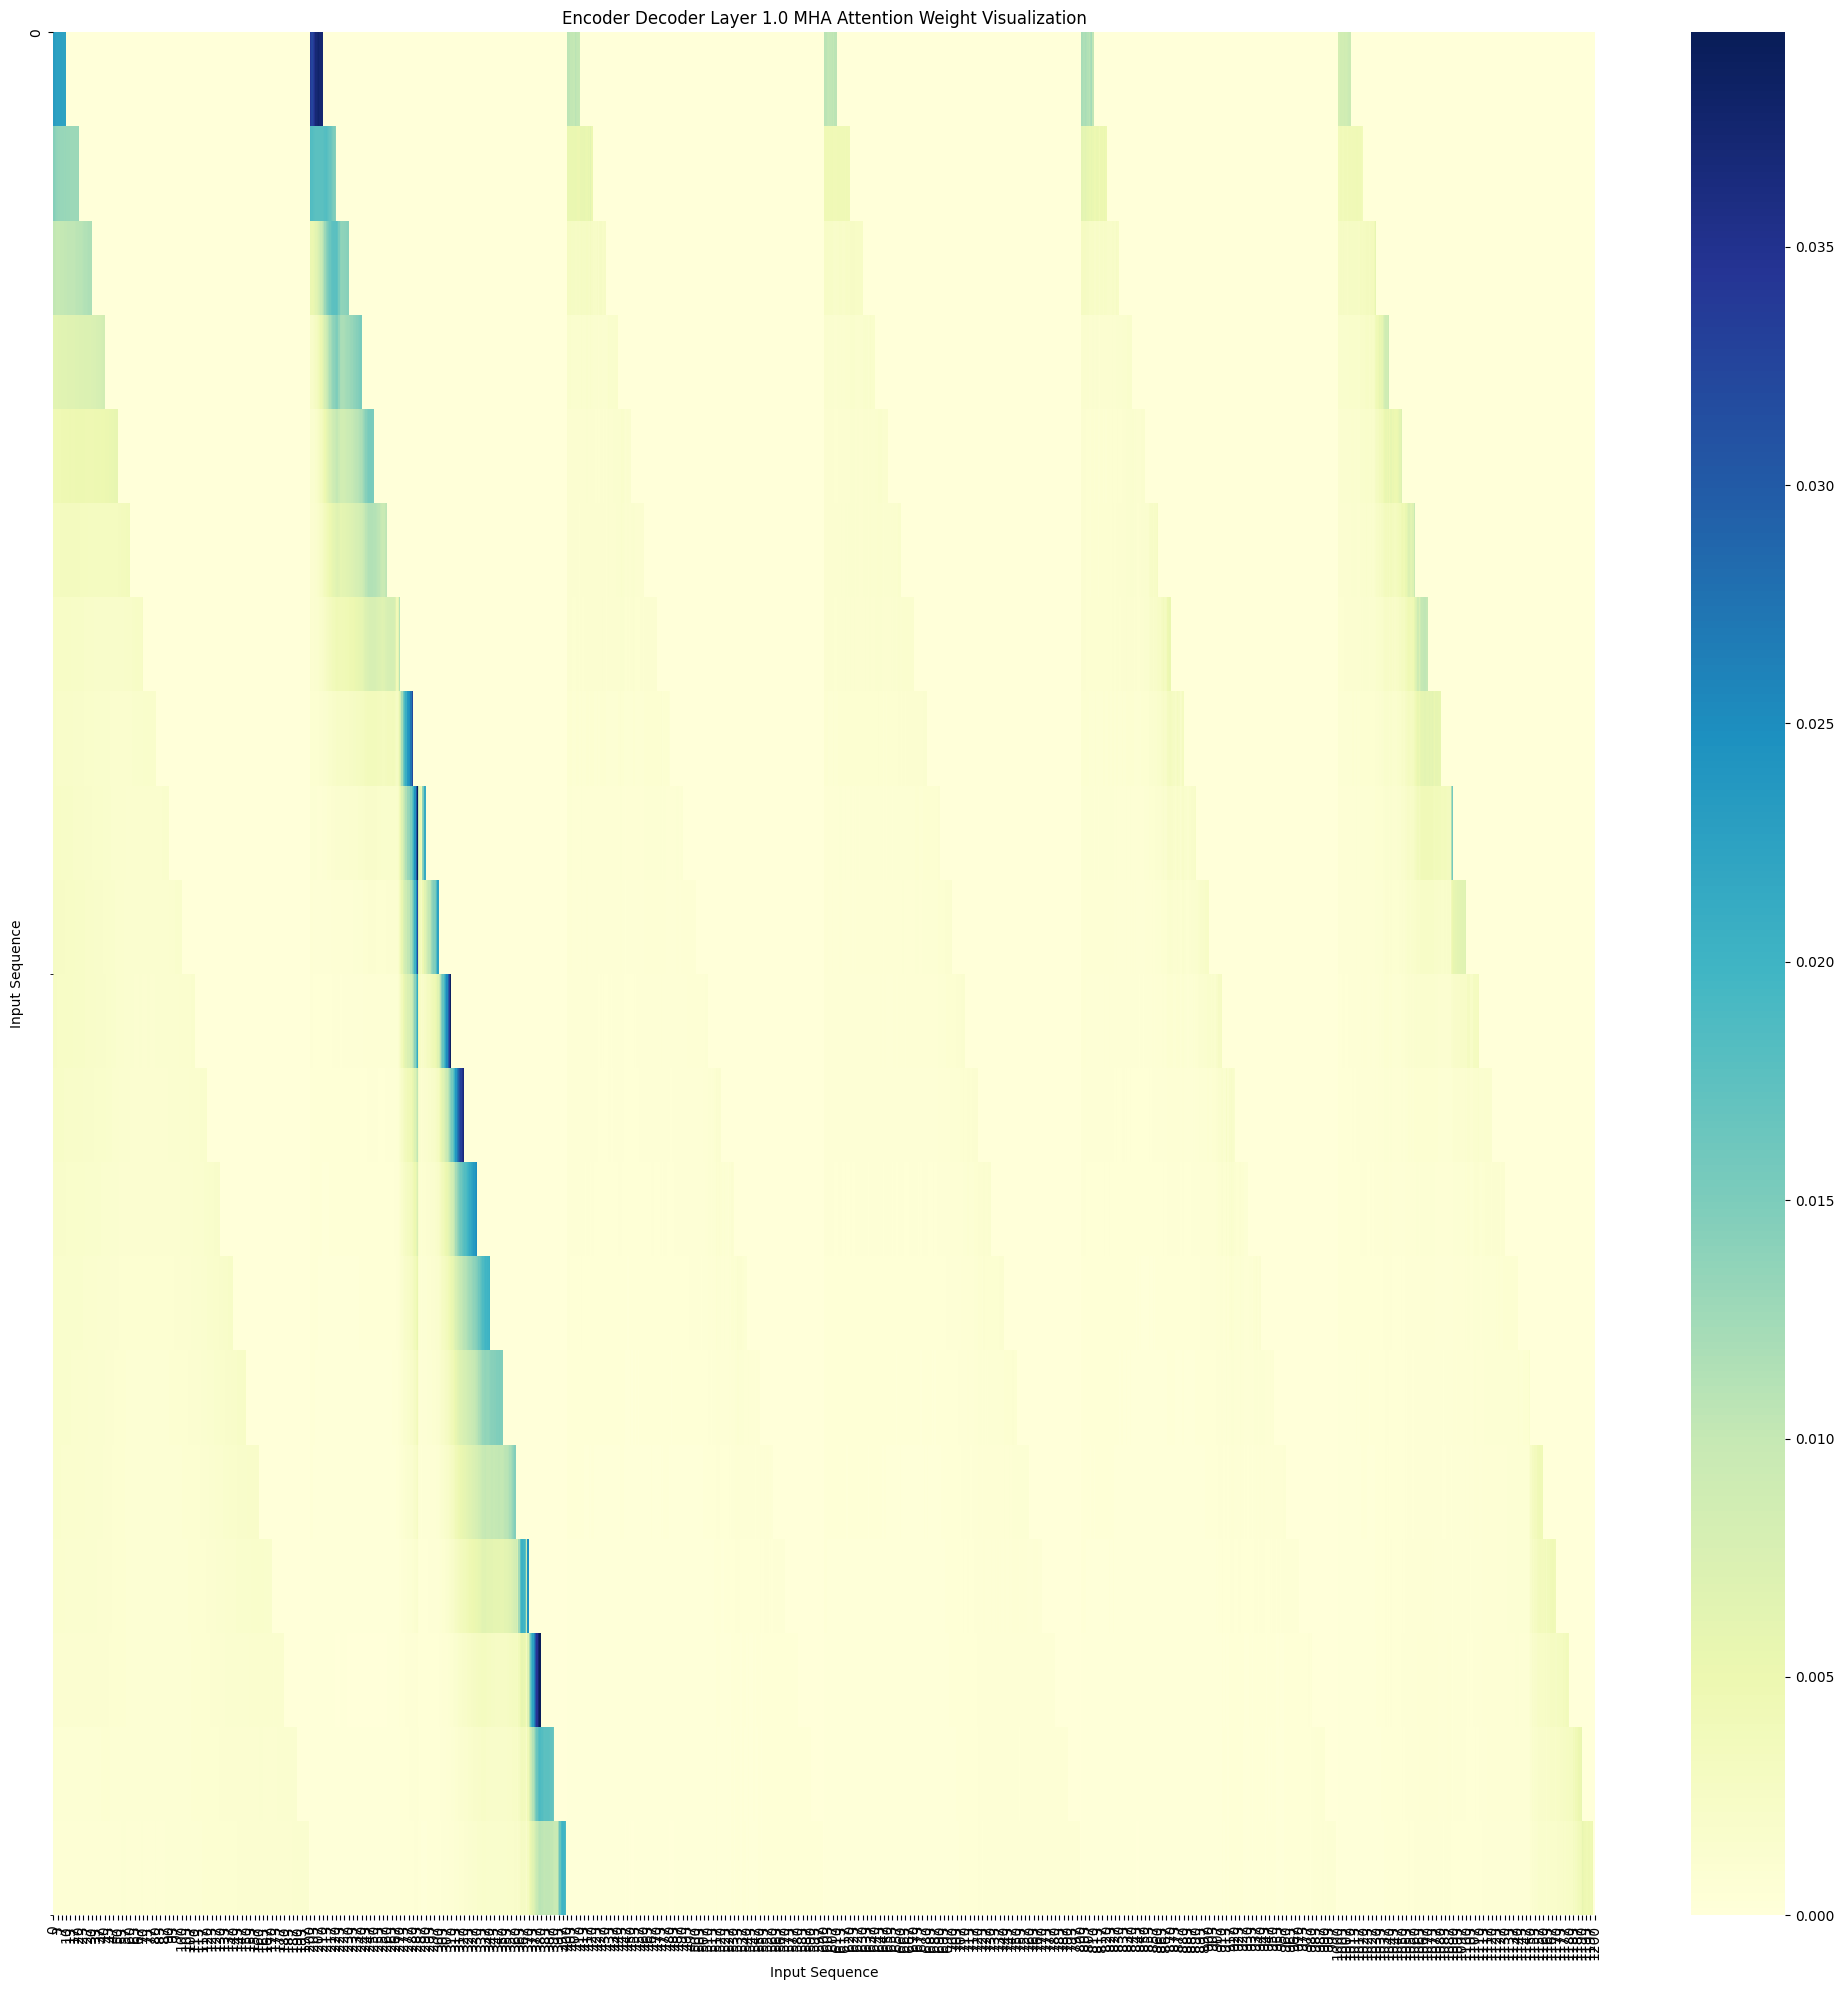

(20, 20)


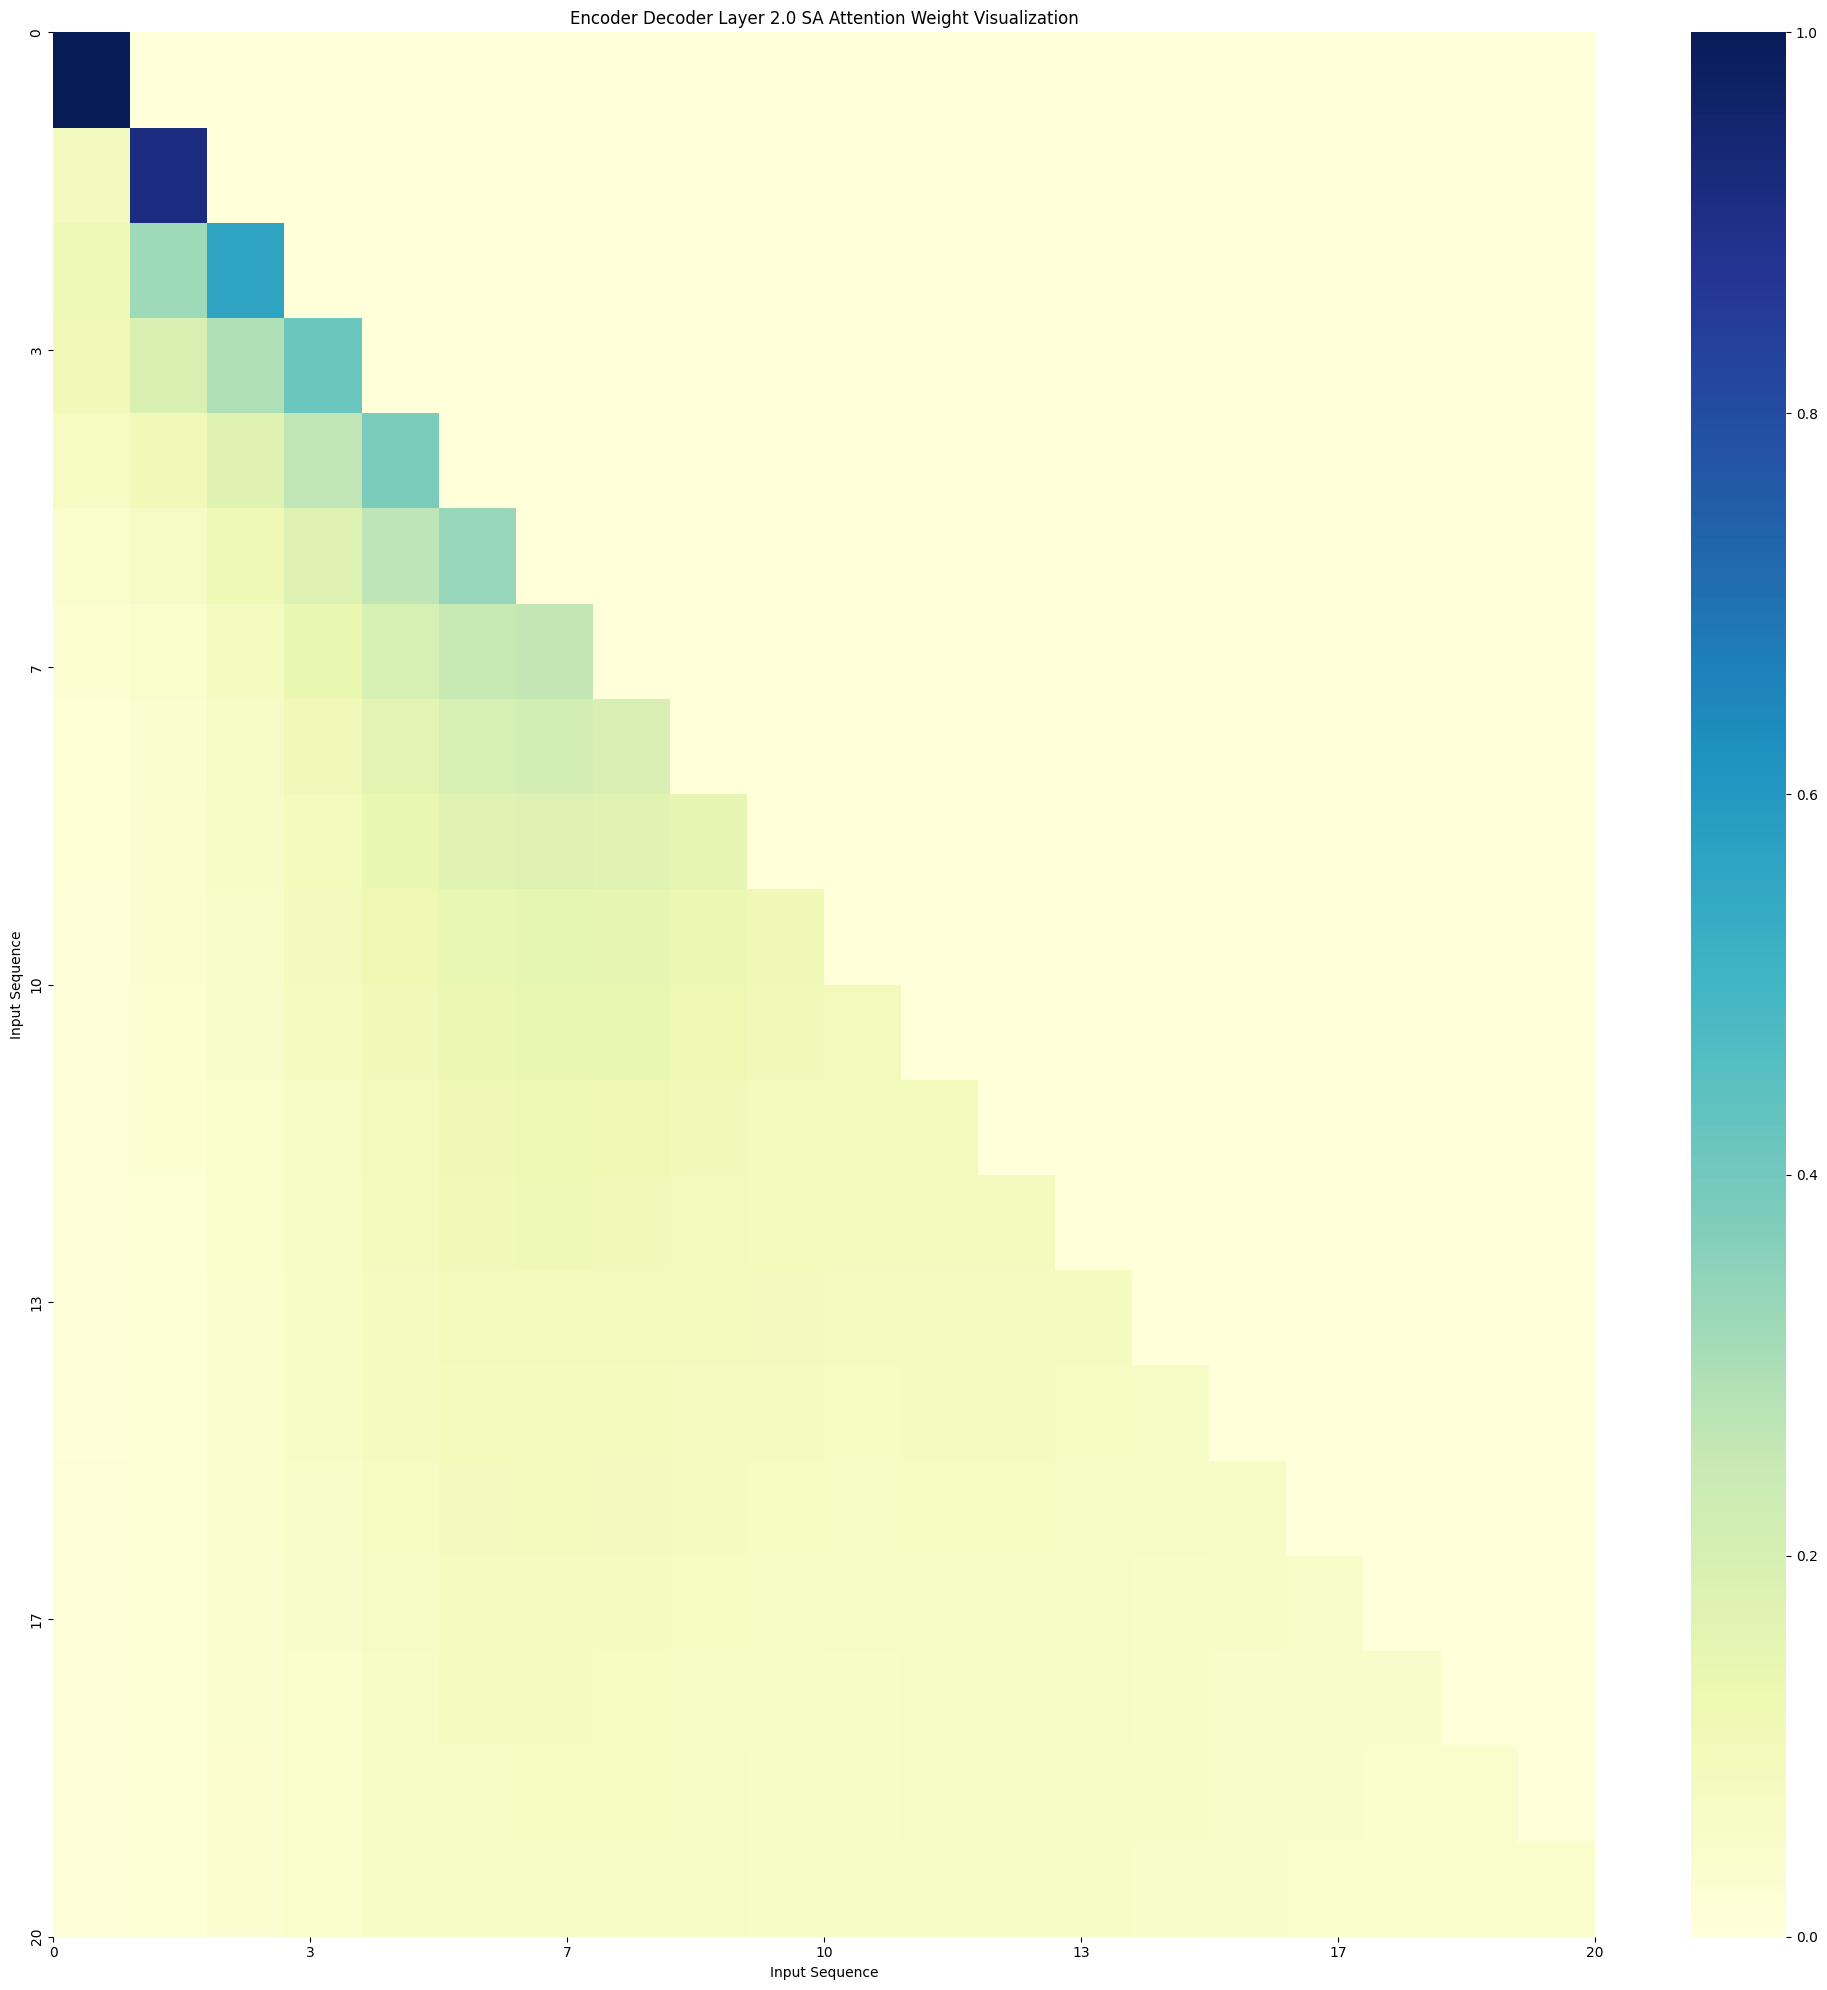

(20, 1200)


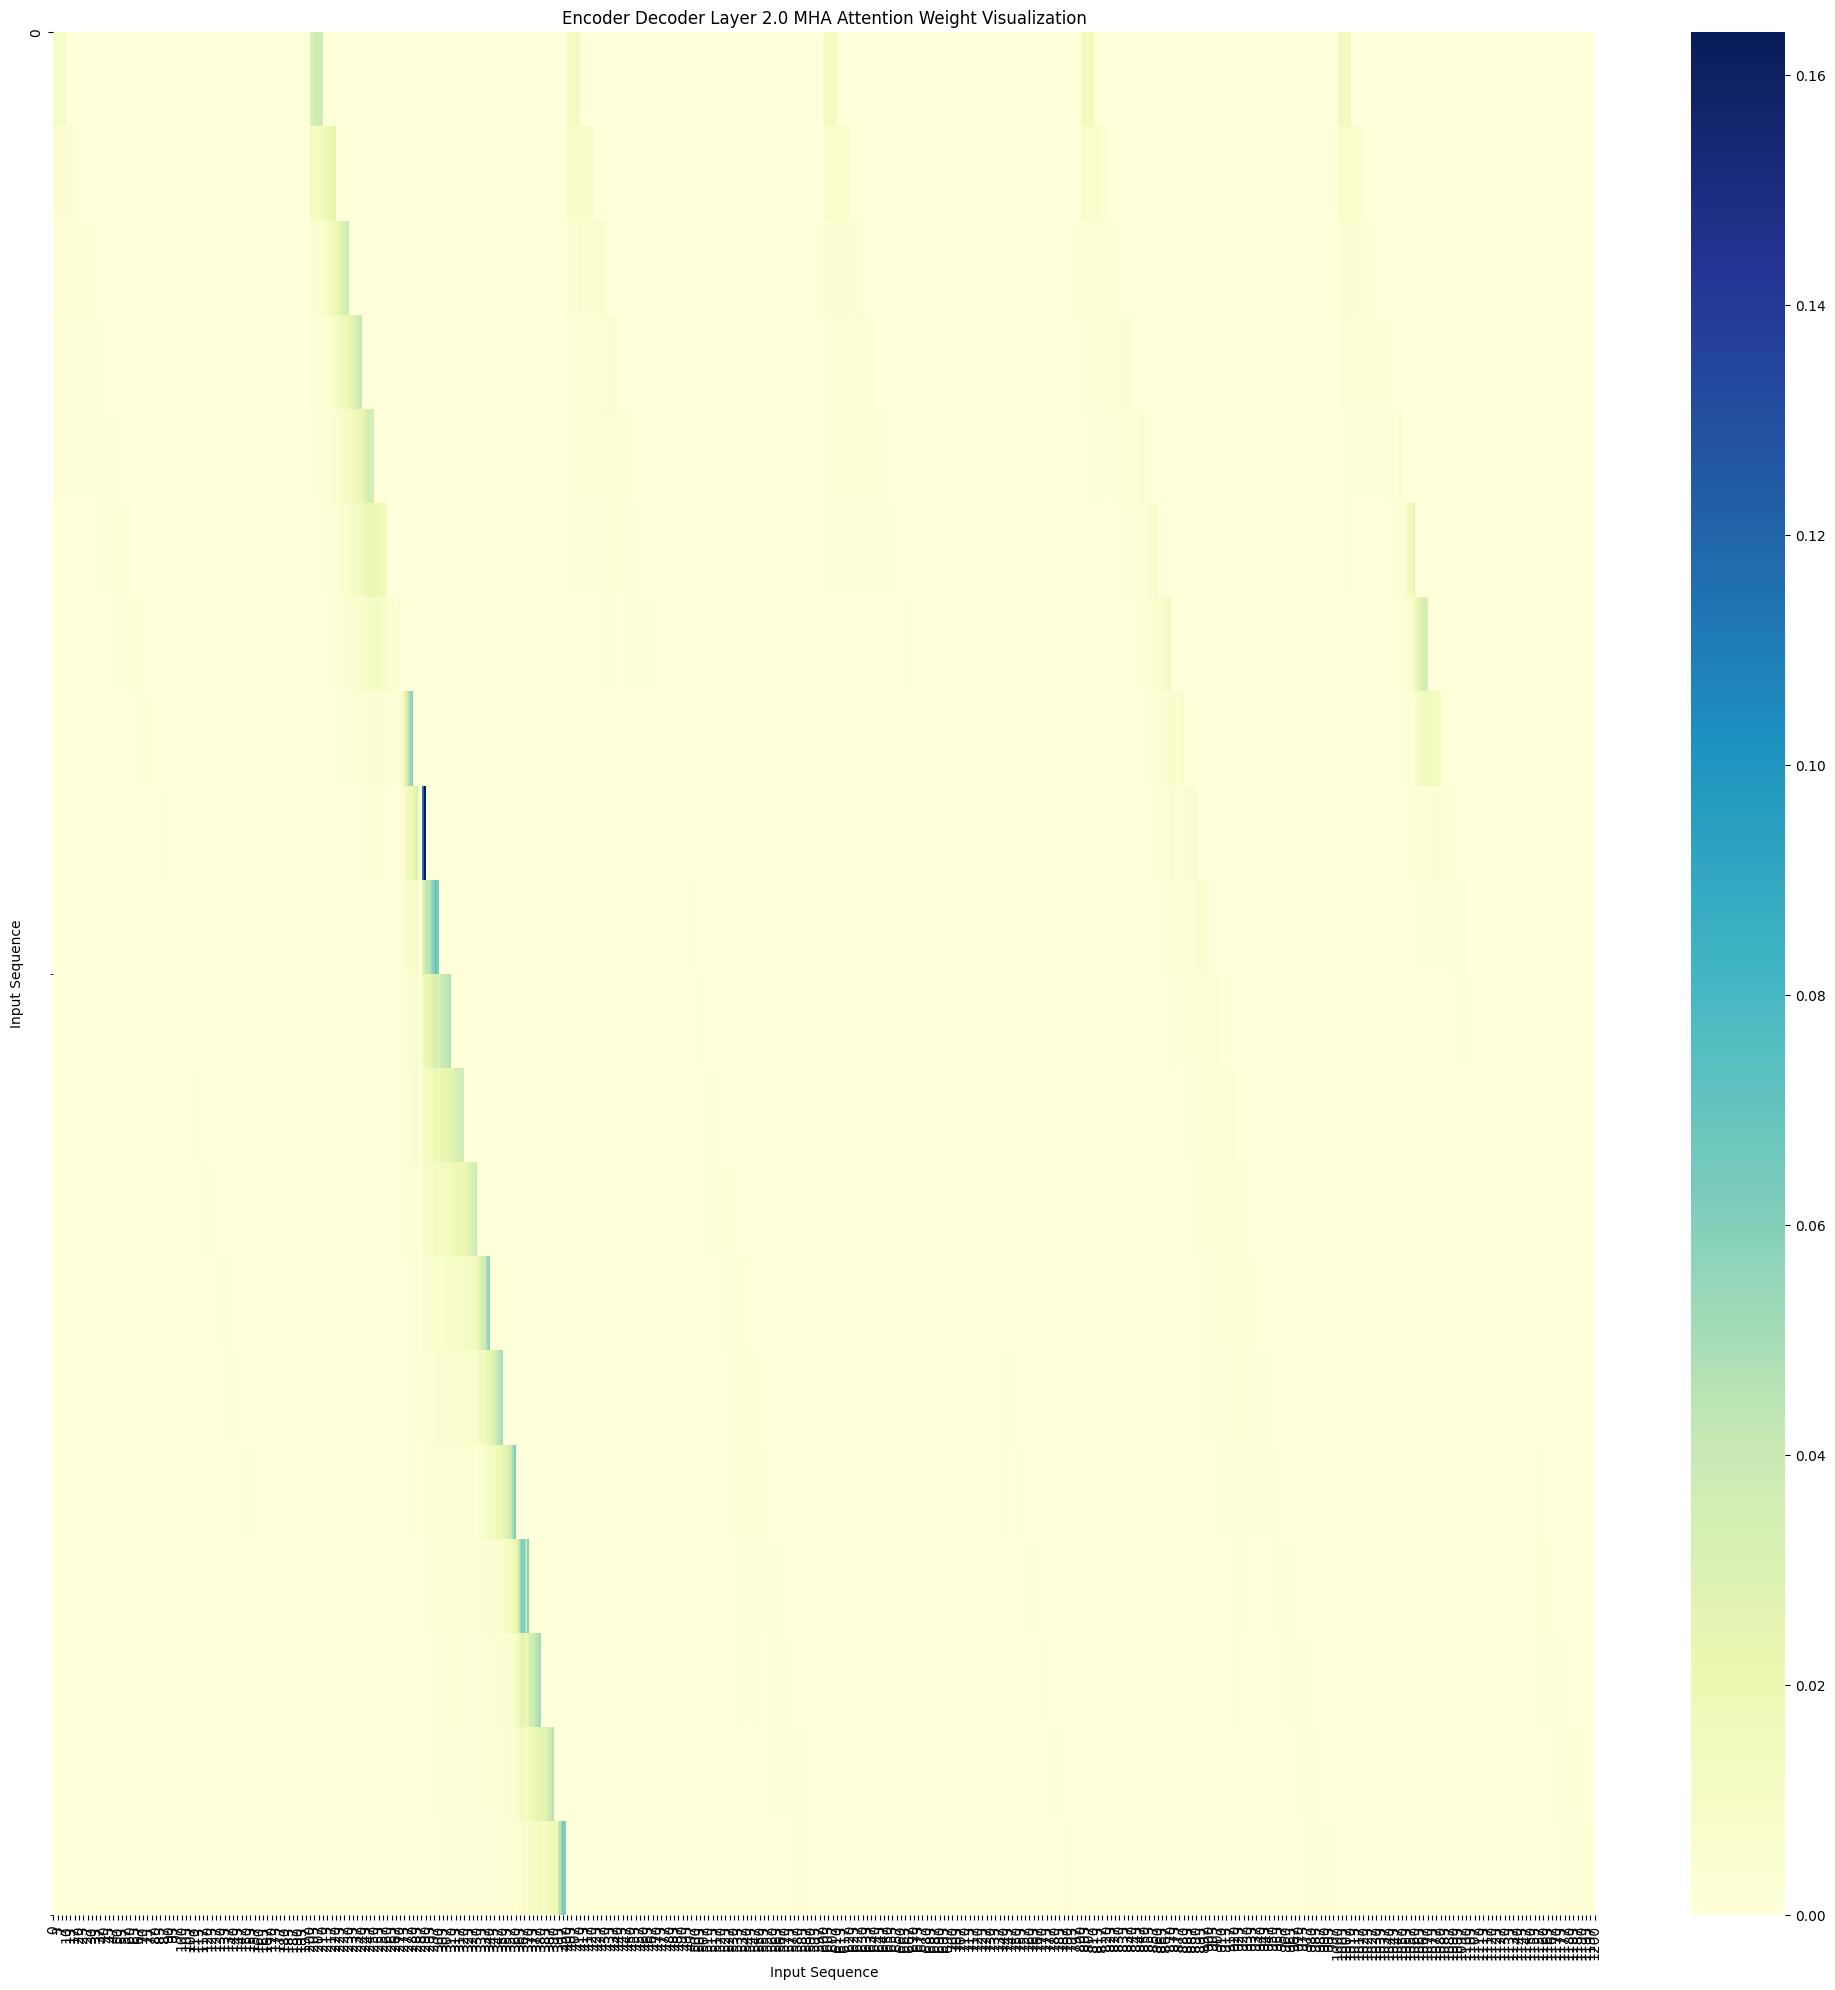

(20, 20)


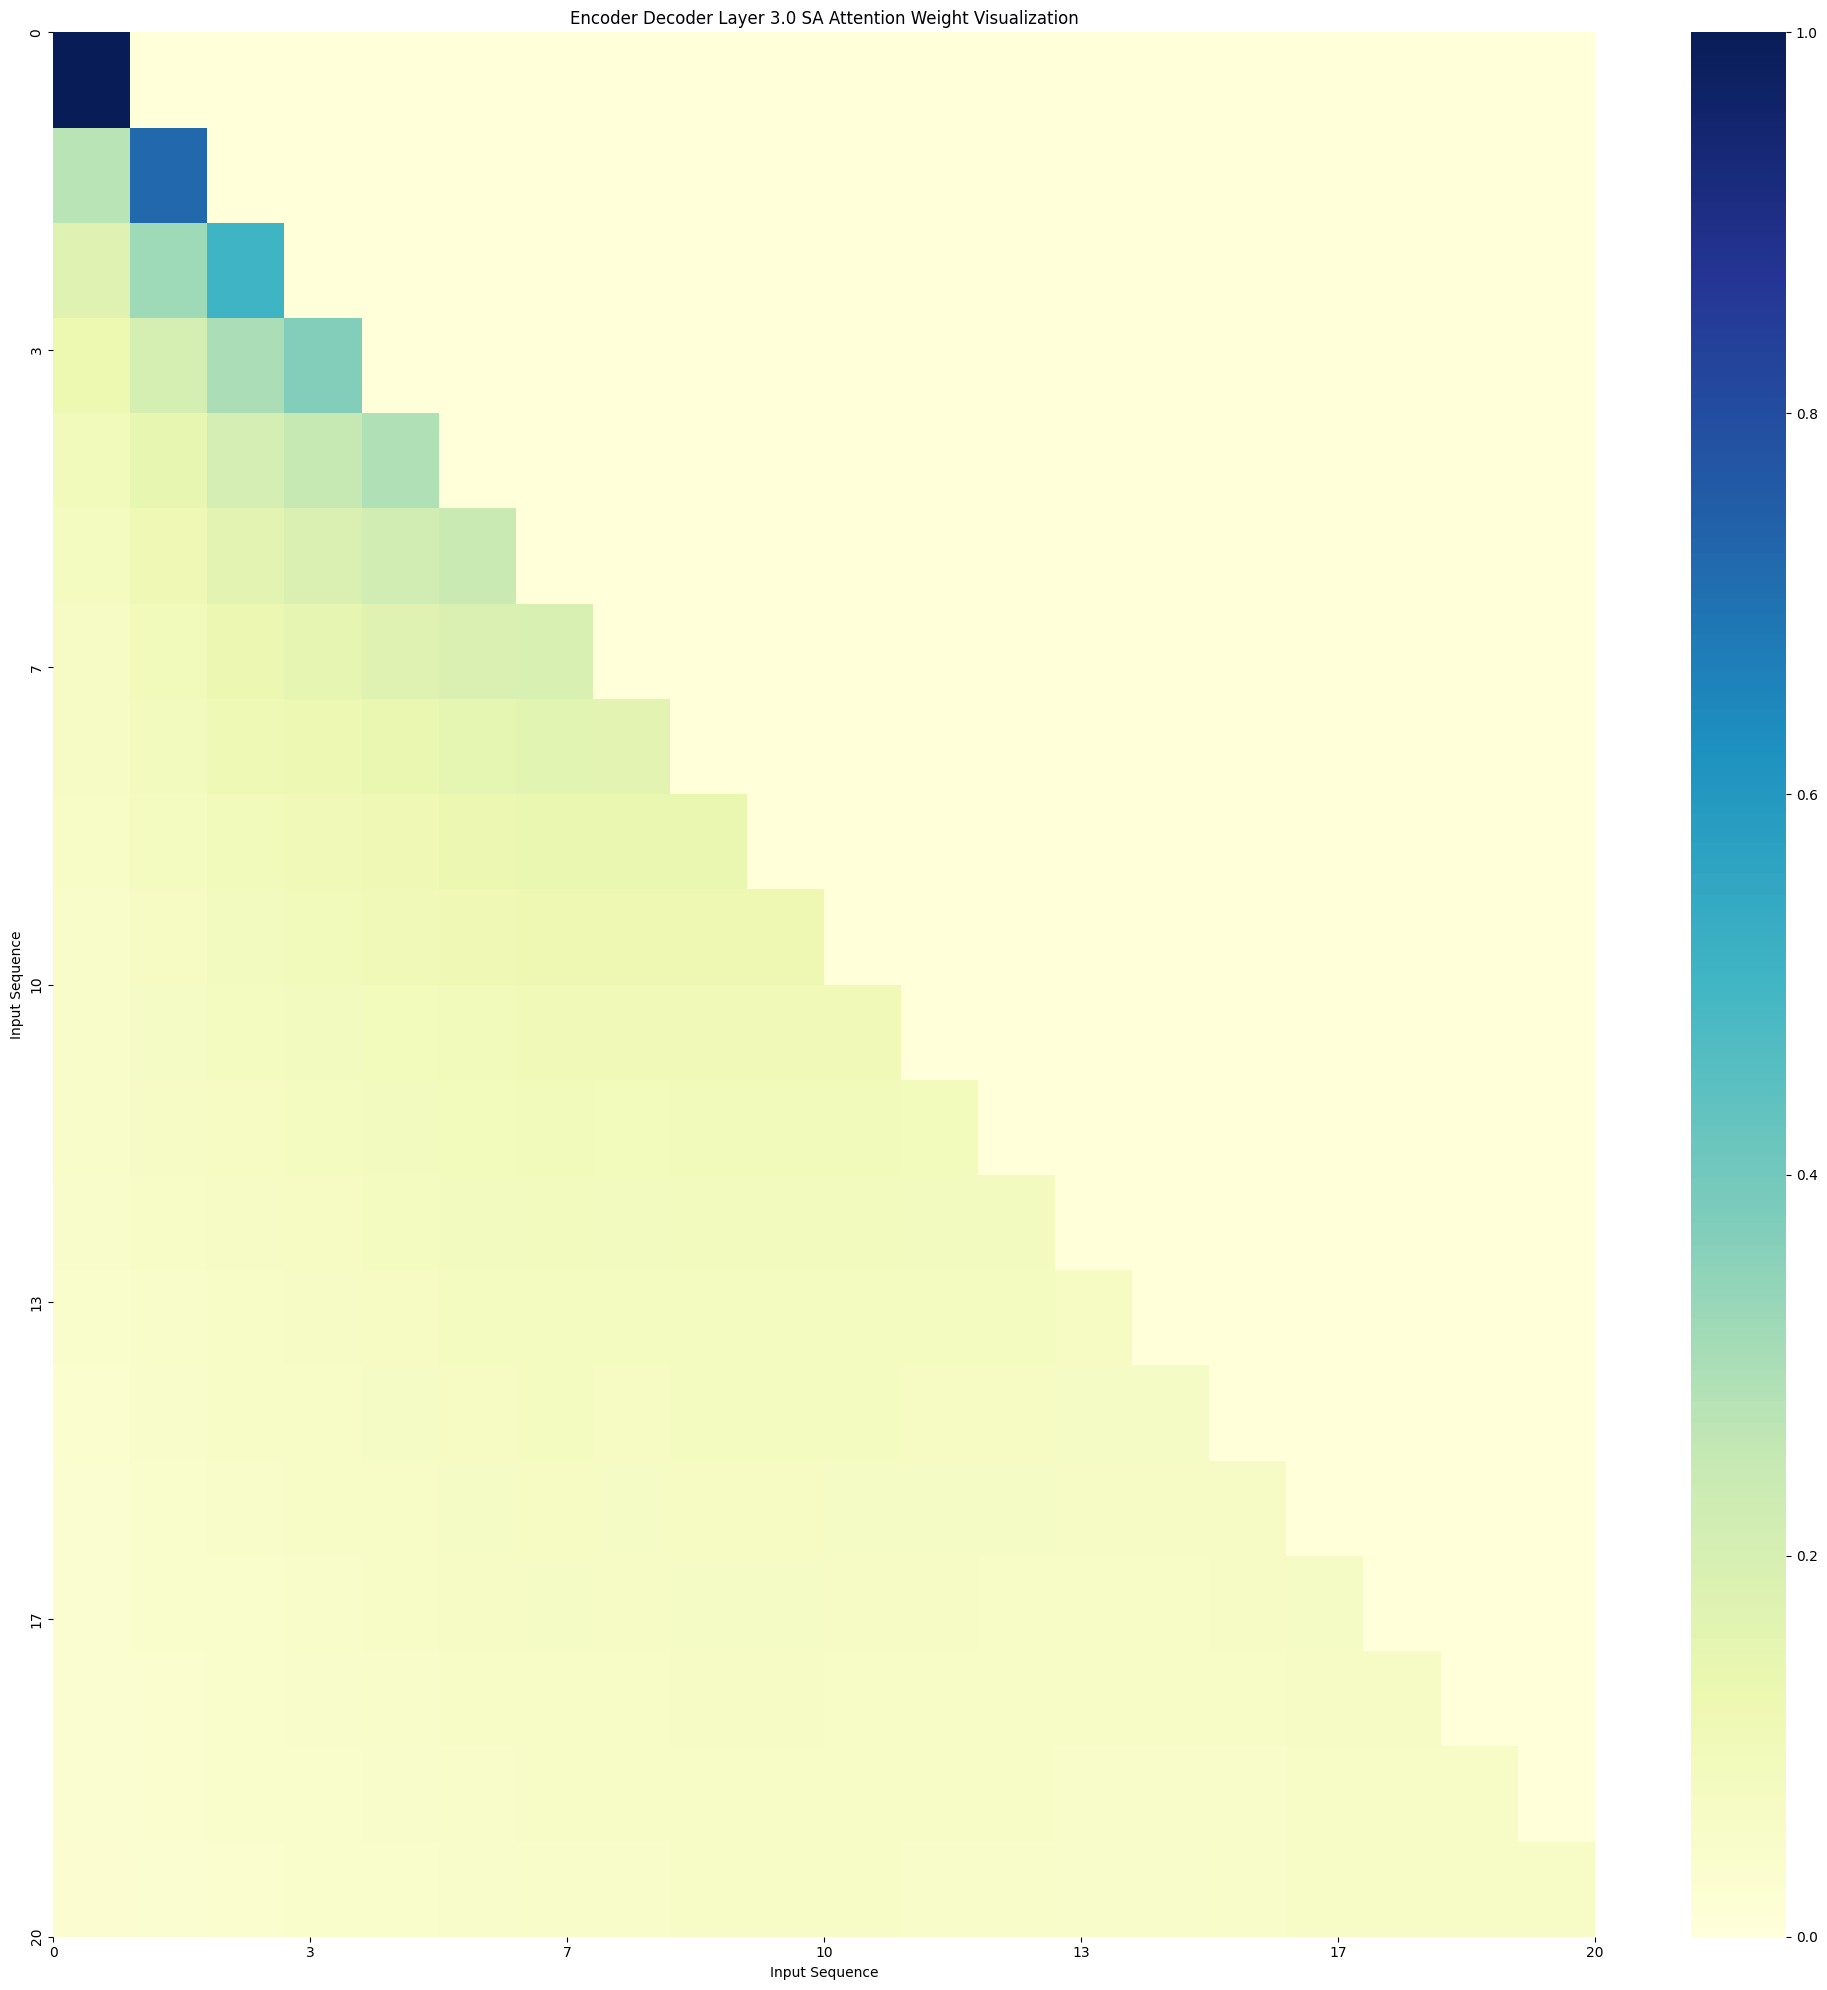

(20, 1200)


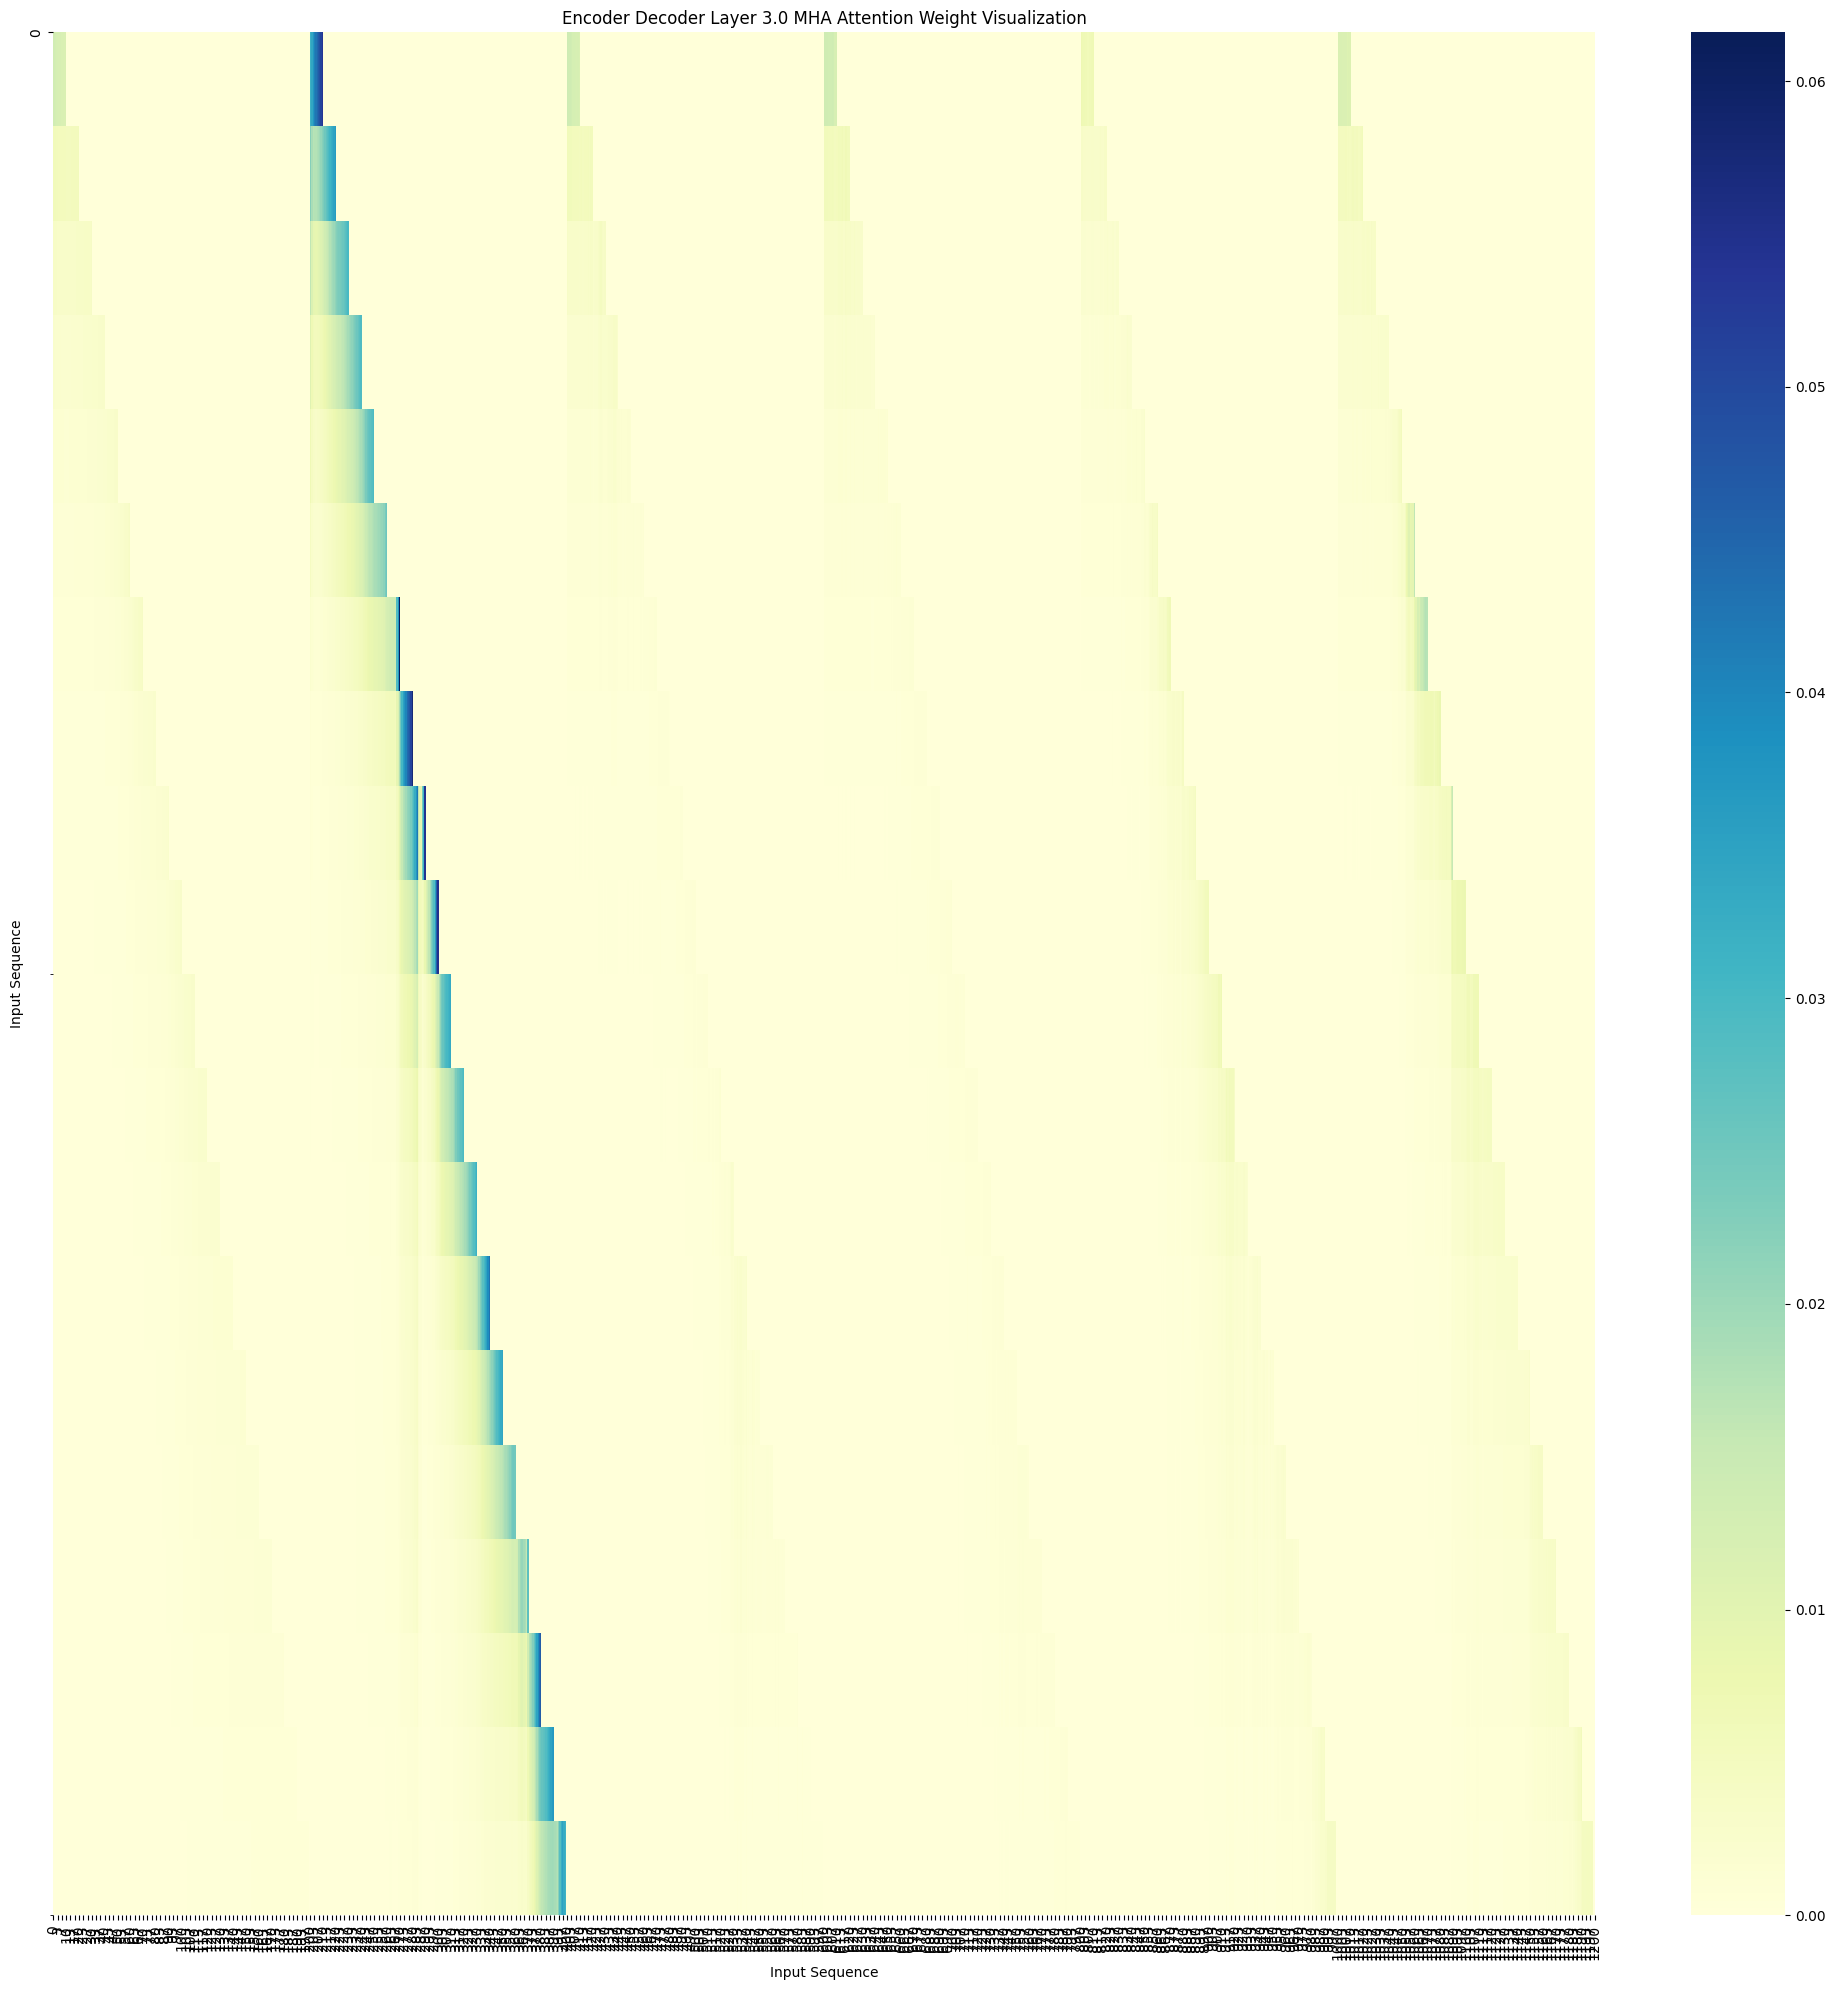

(20, 20)


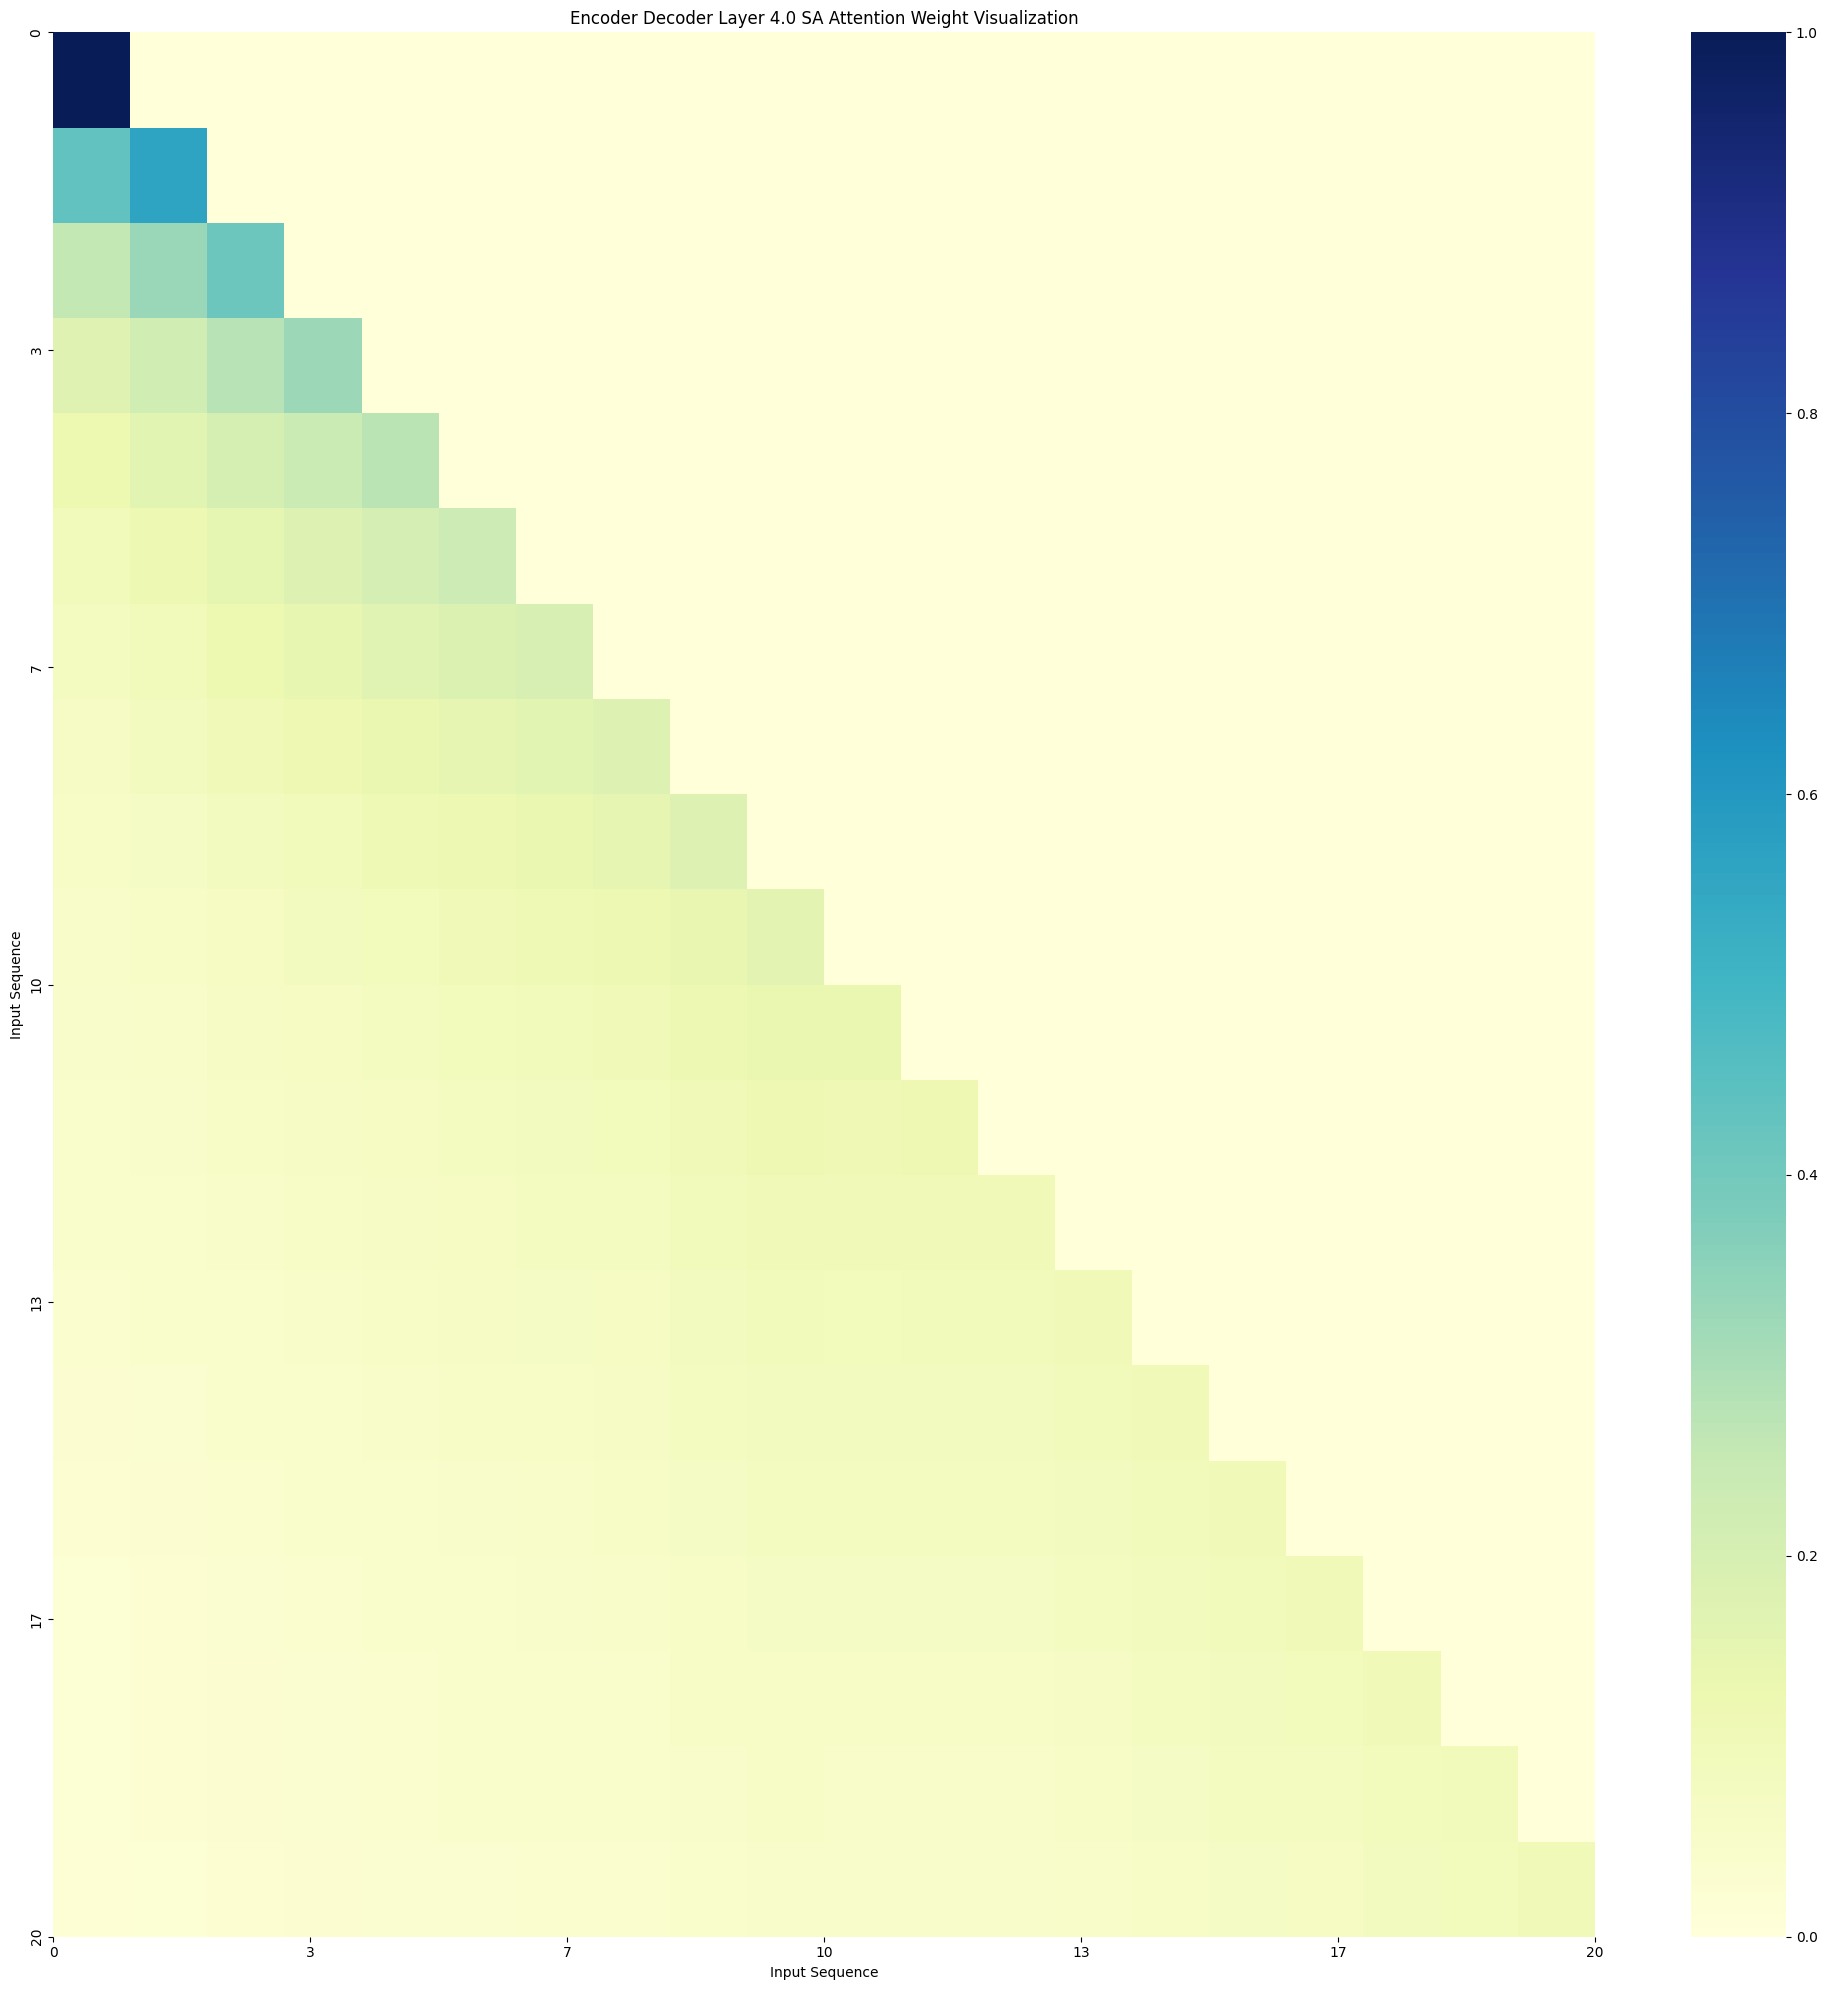

(20, 1200)


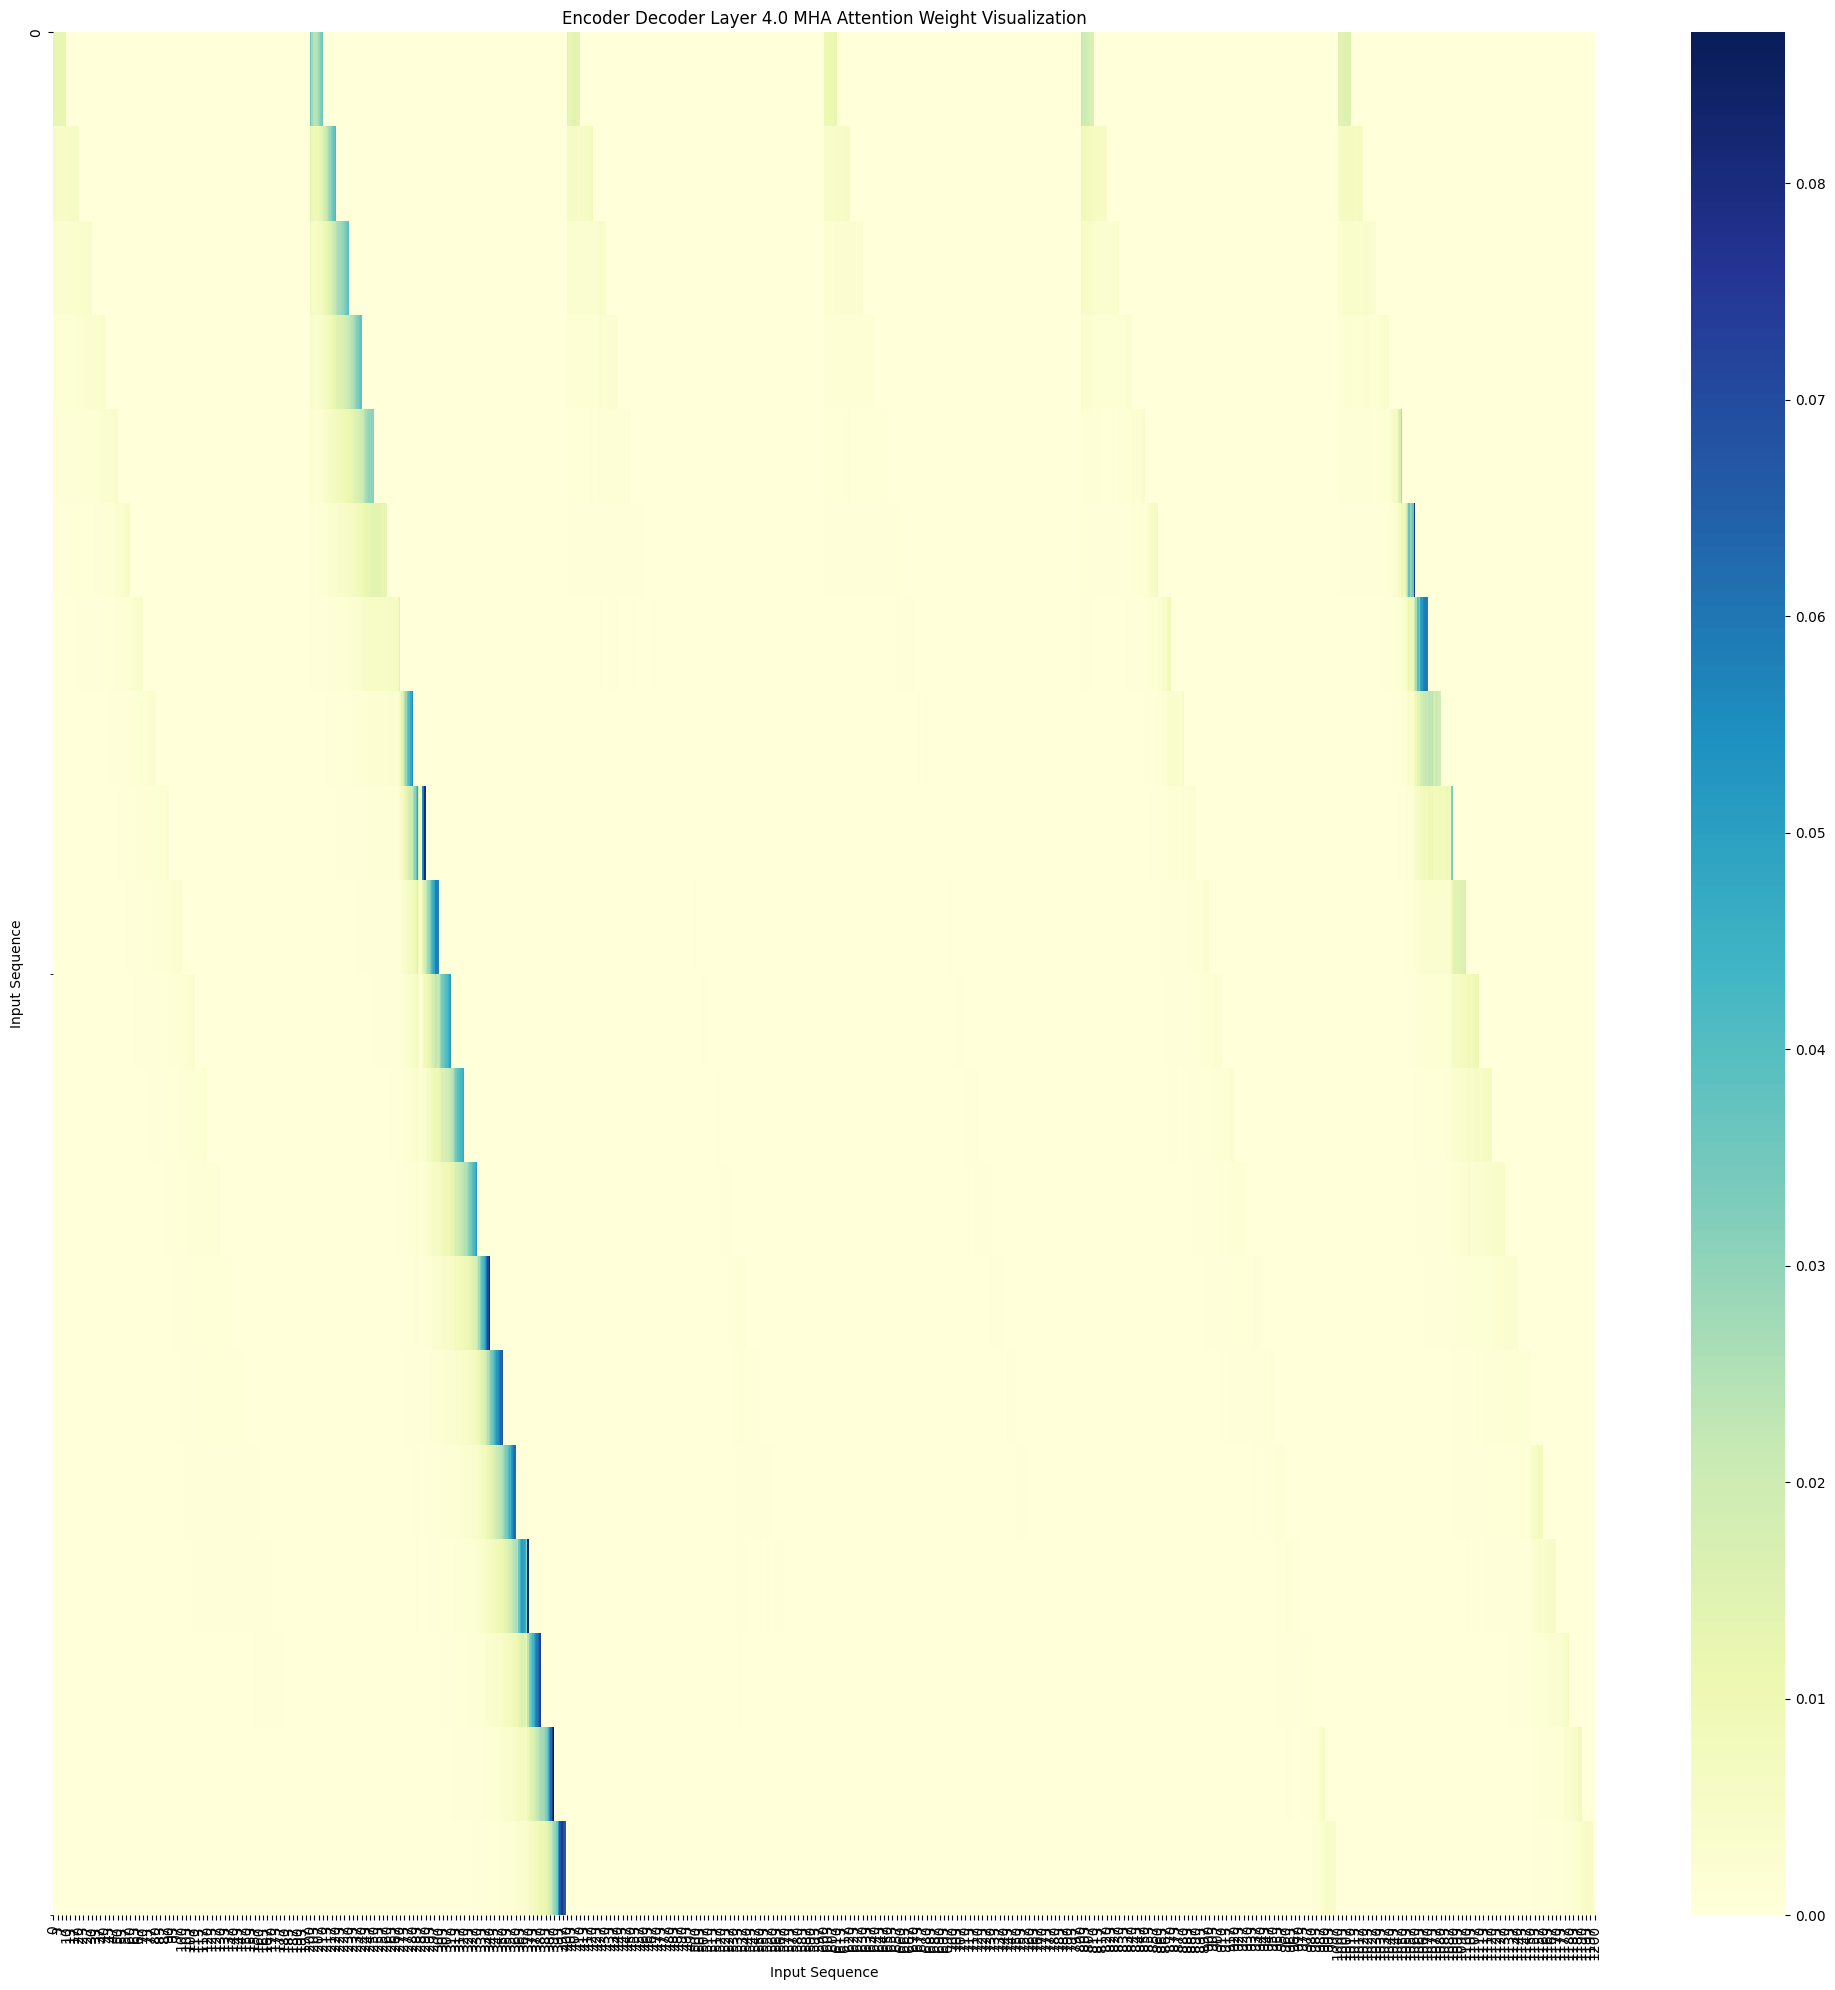

(20, 20)


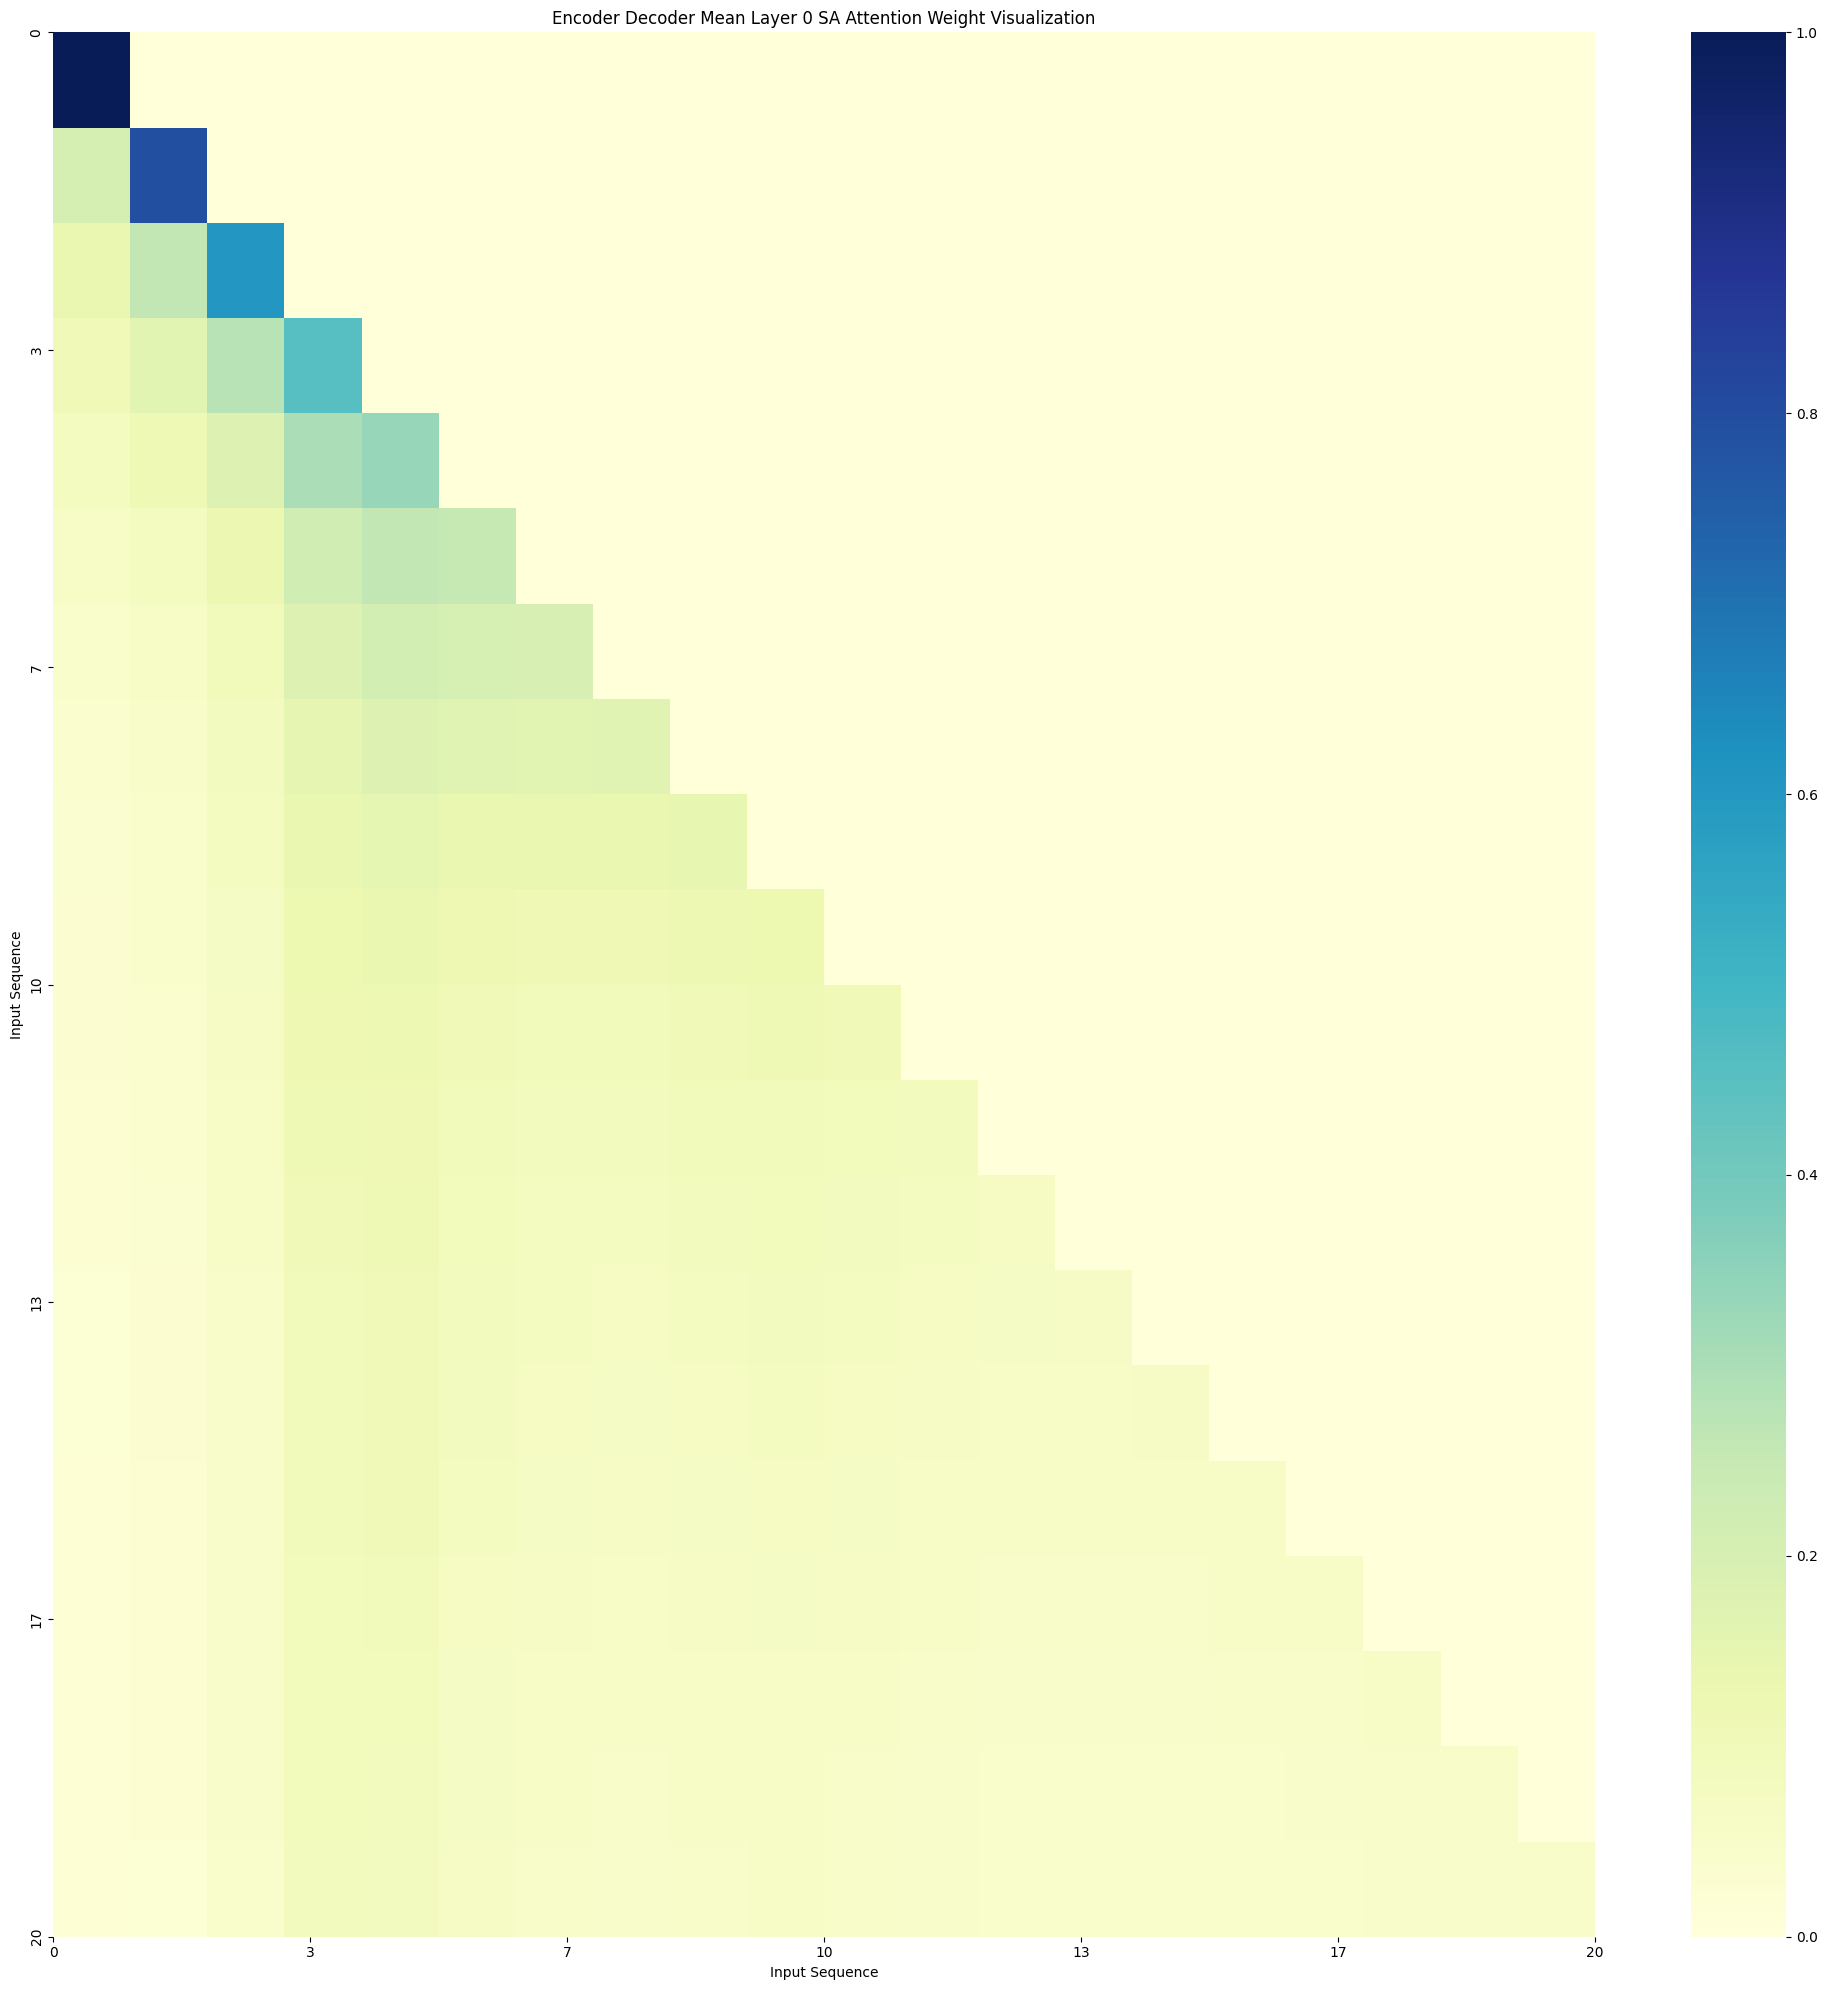

(20, 1200)


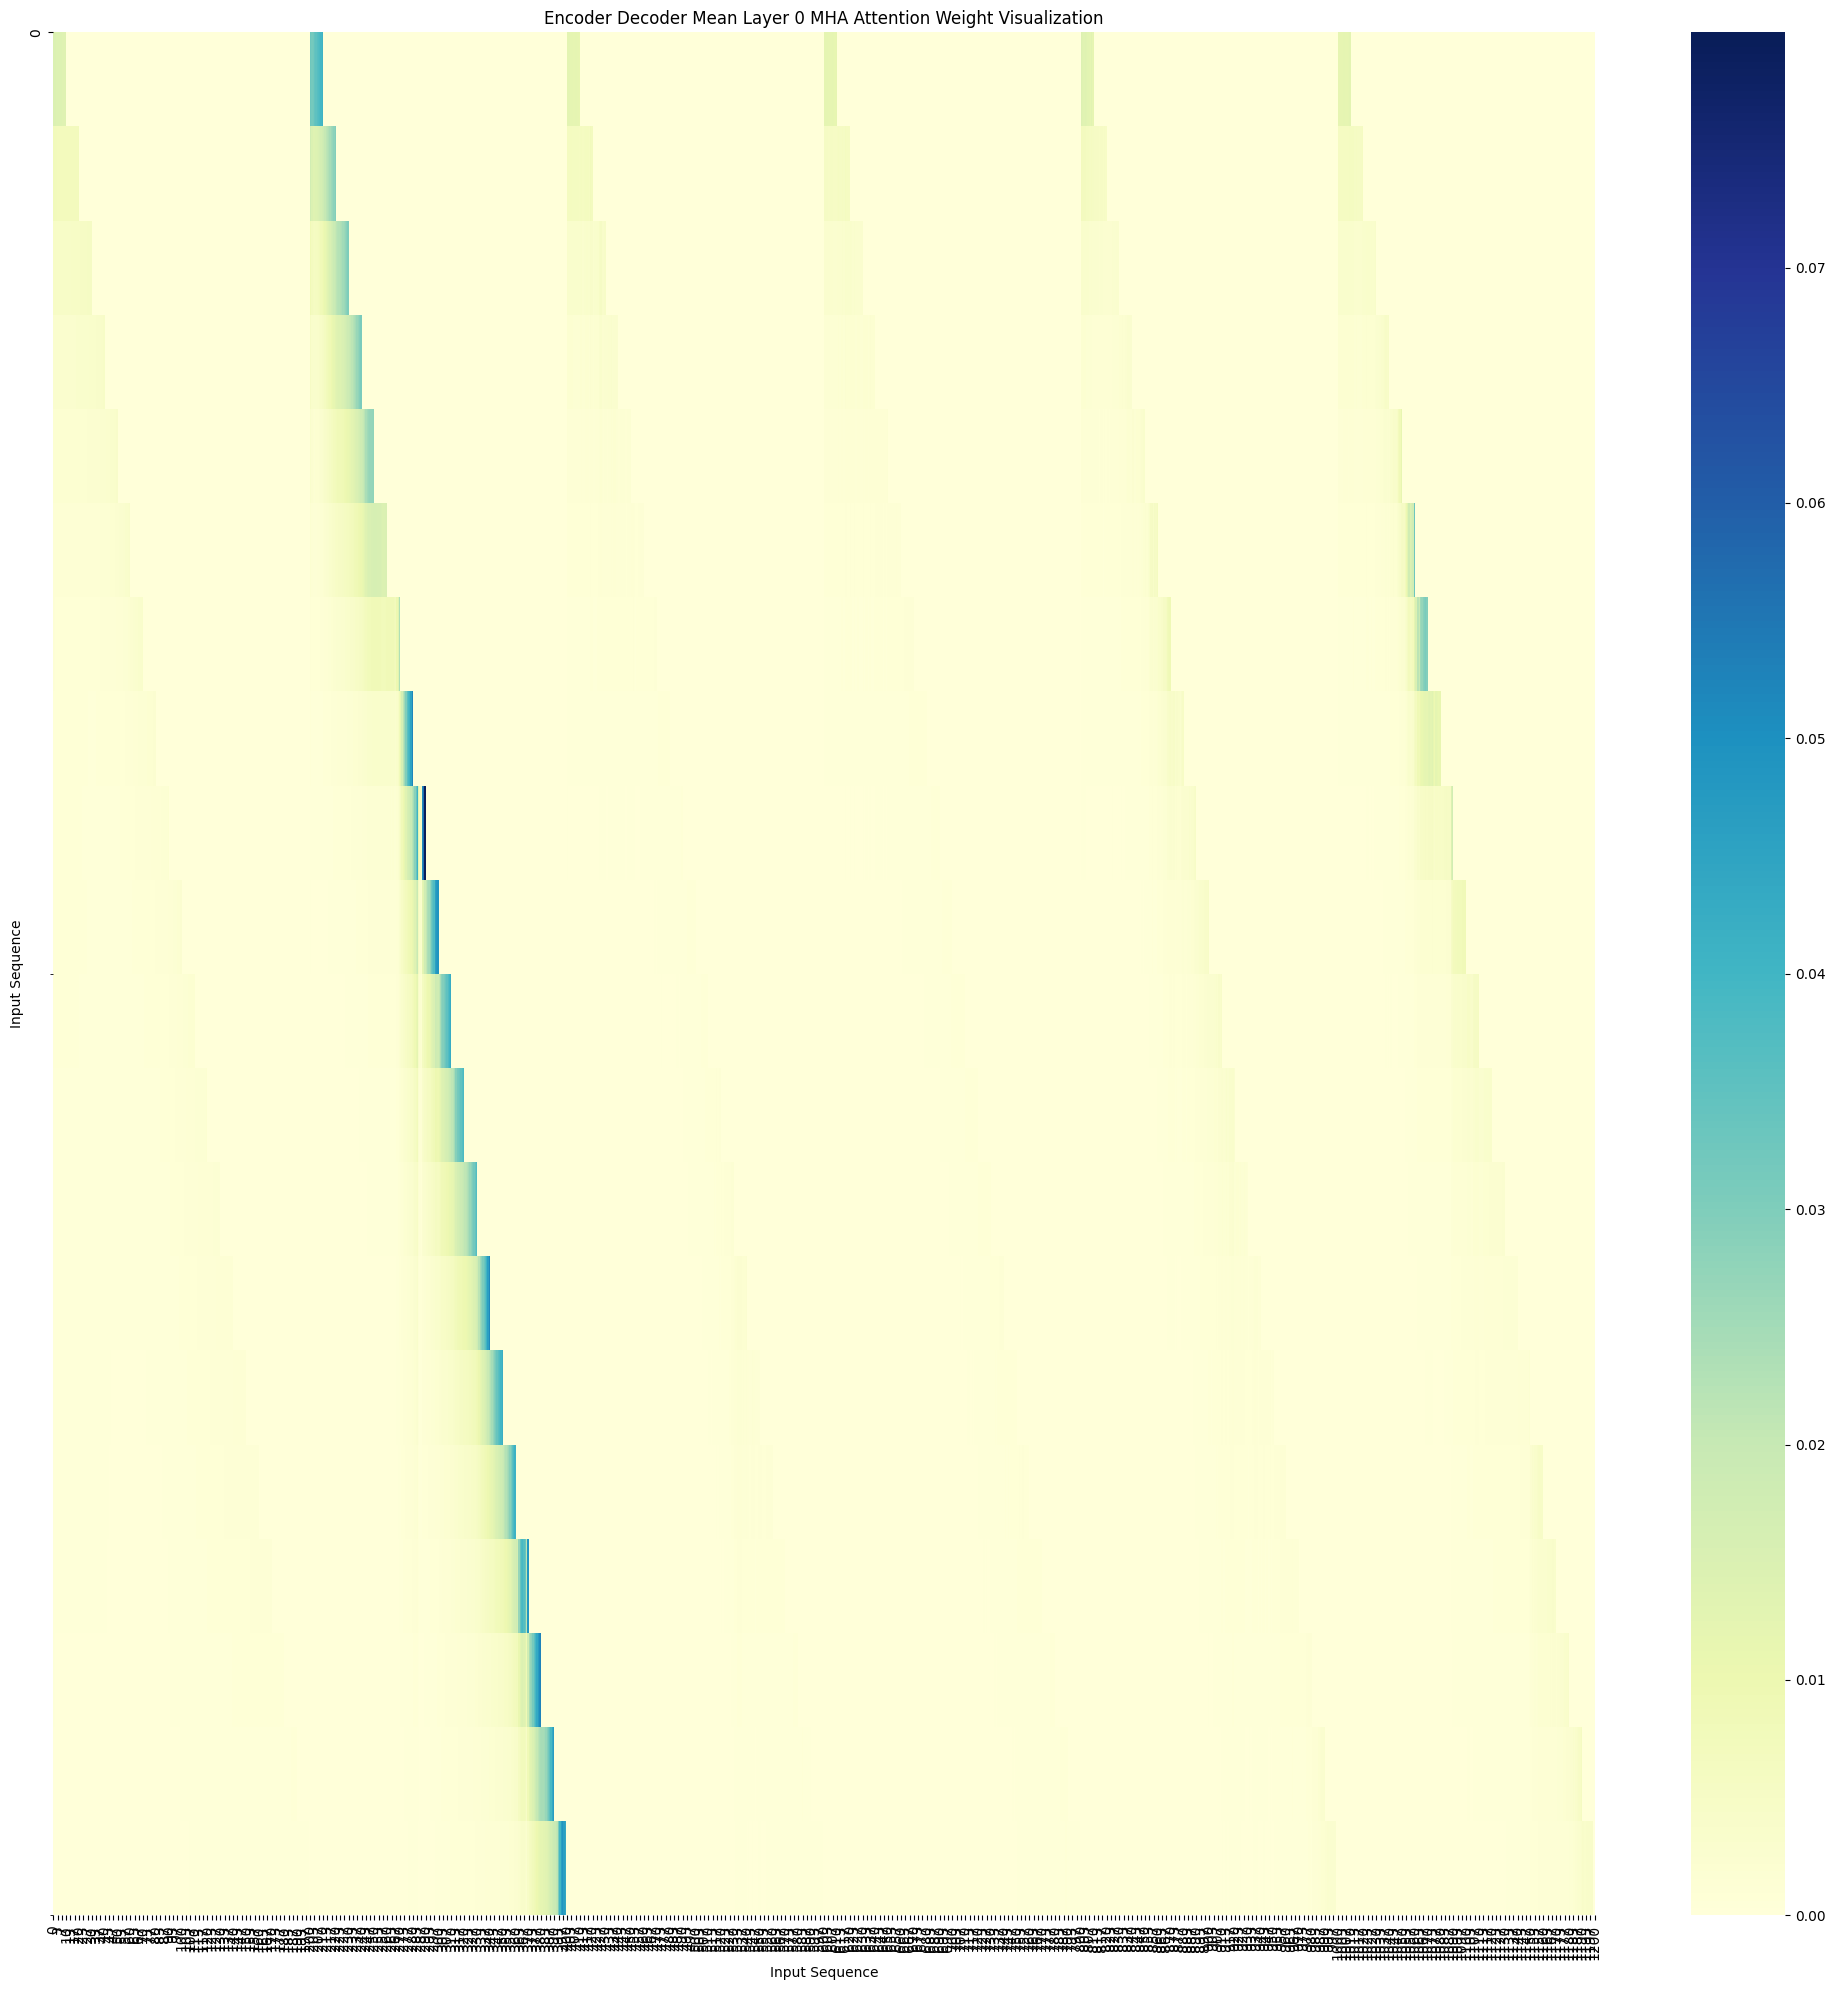

(1, 1)


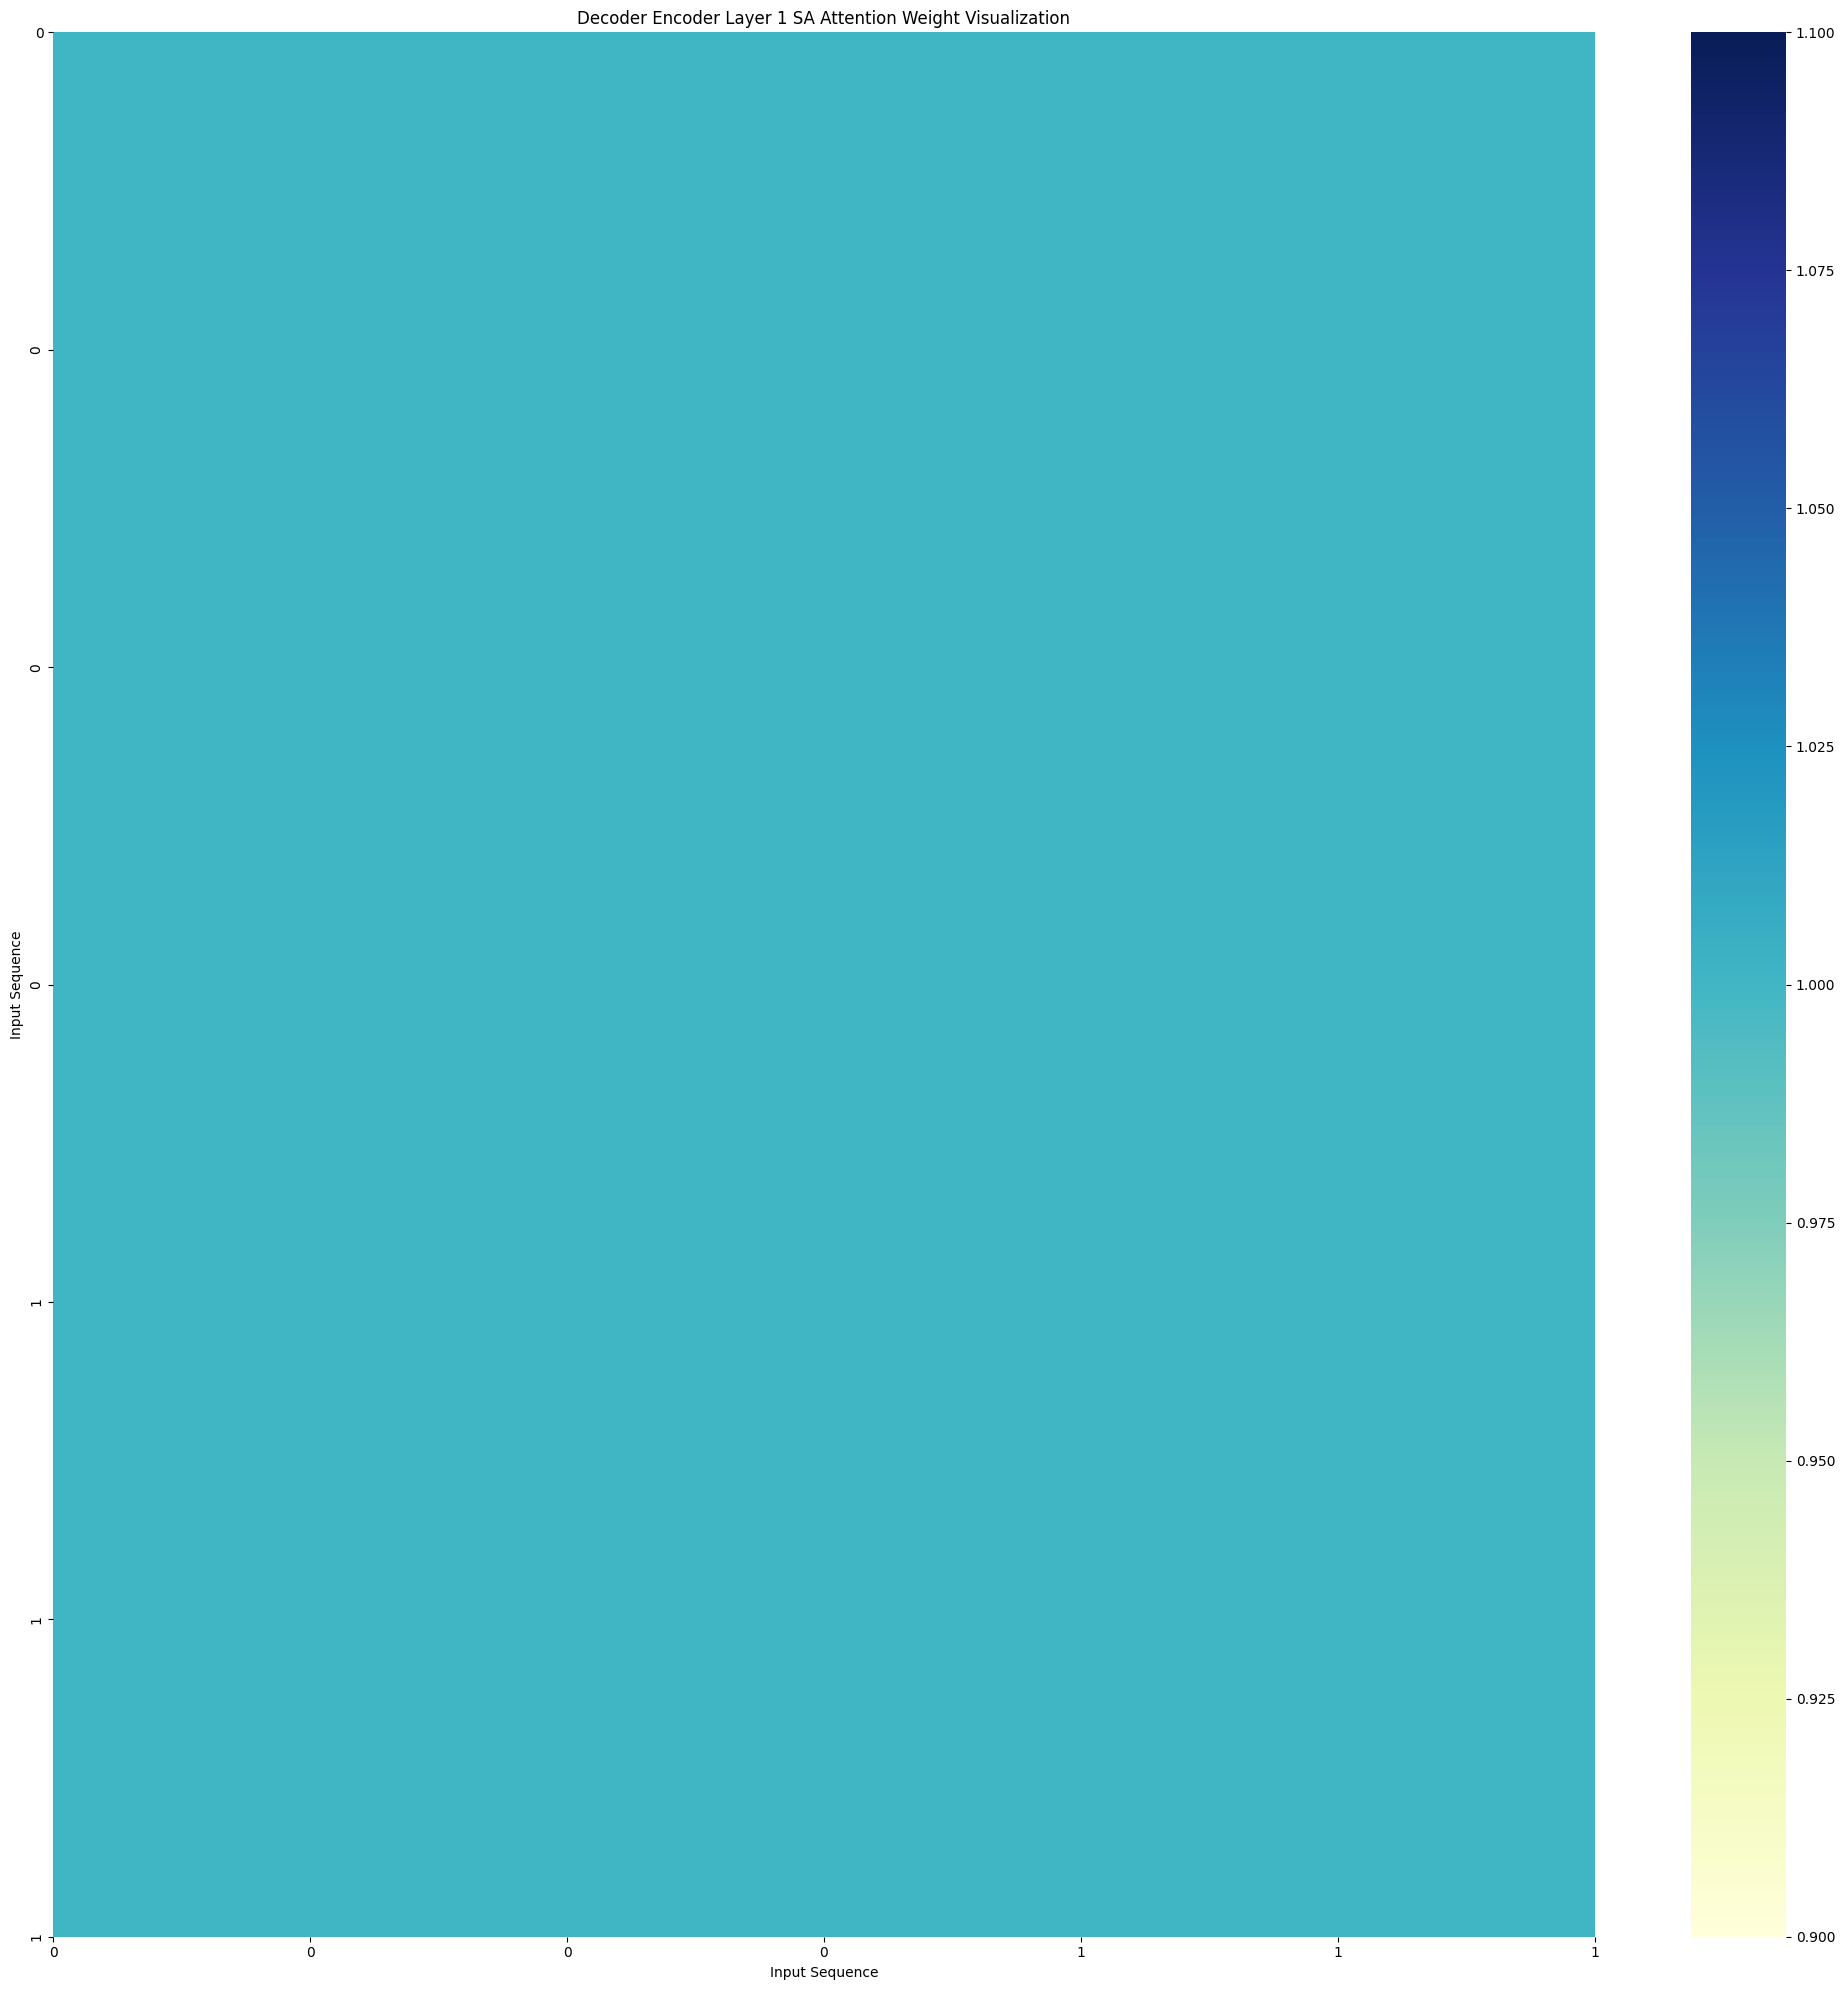

(1, 1)


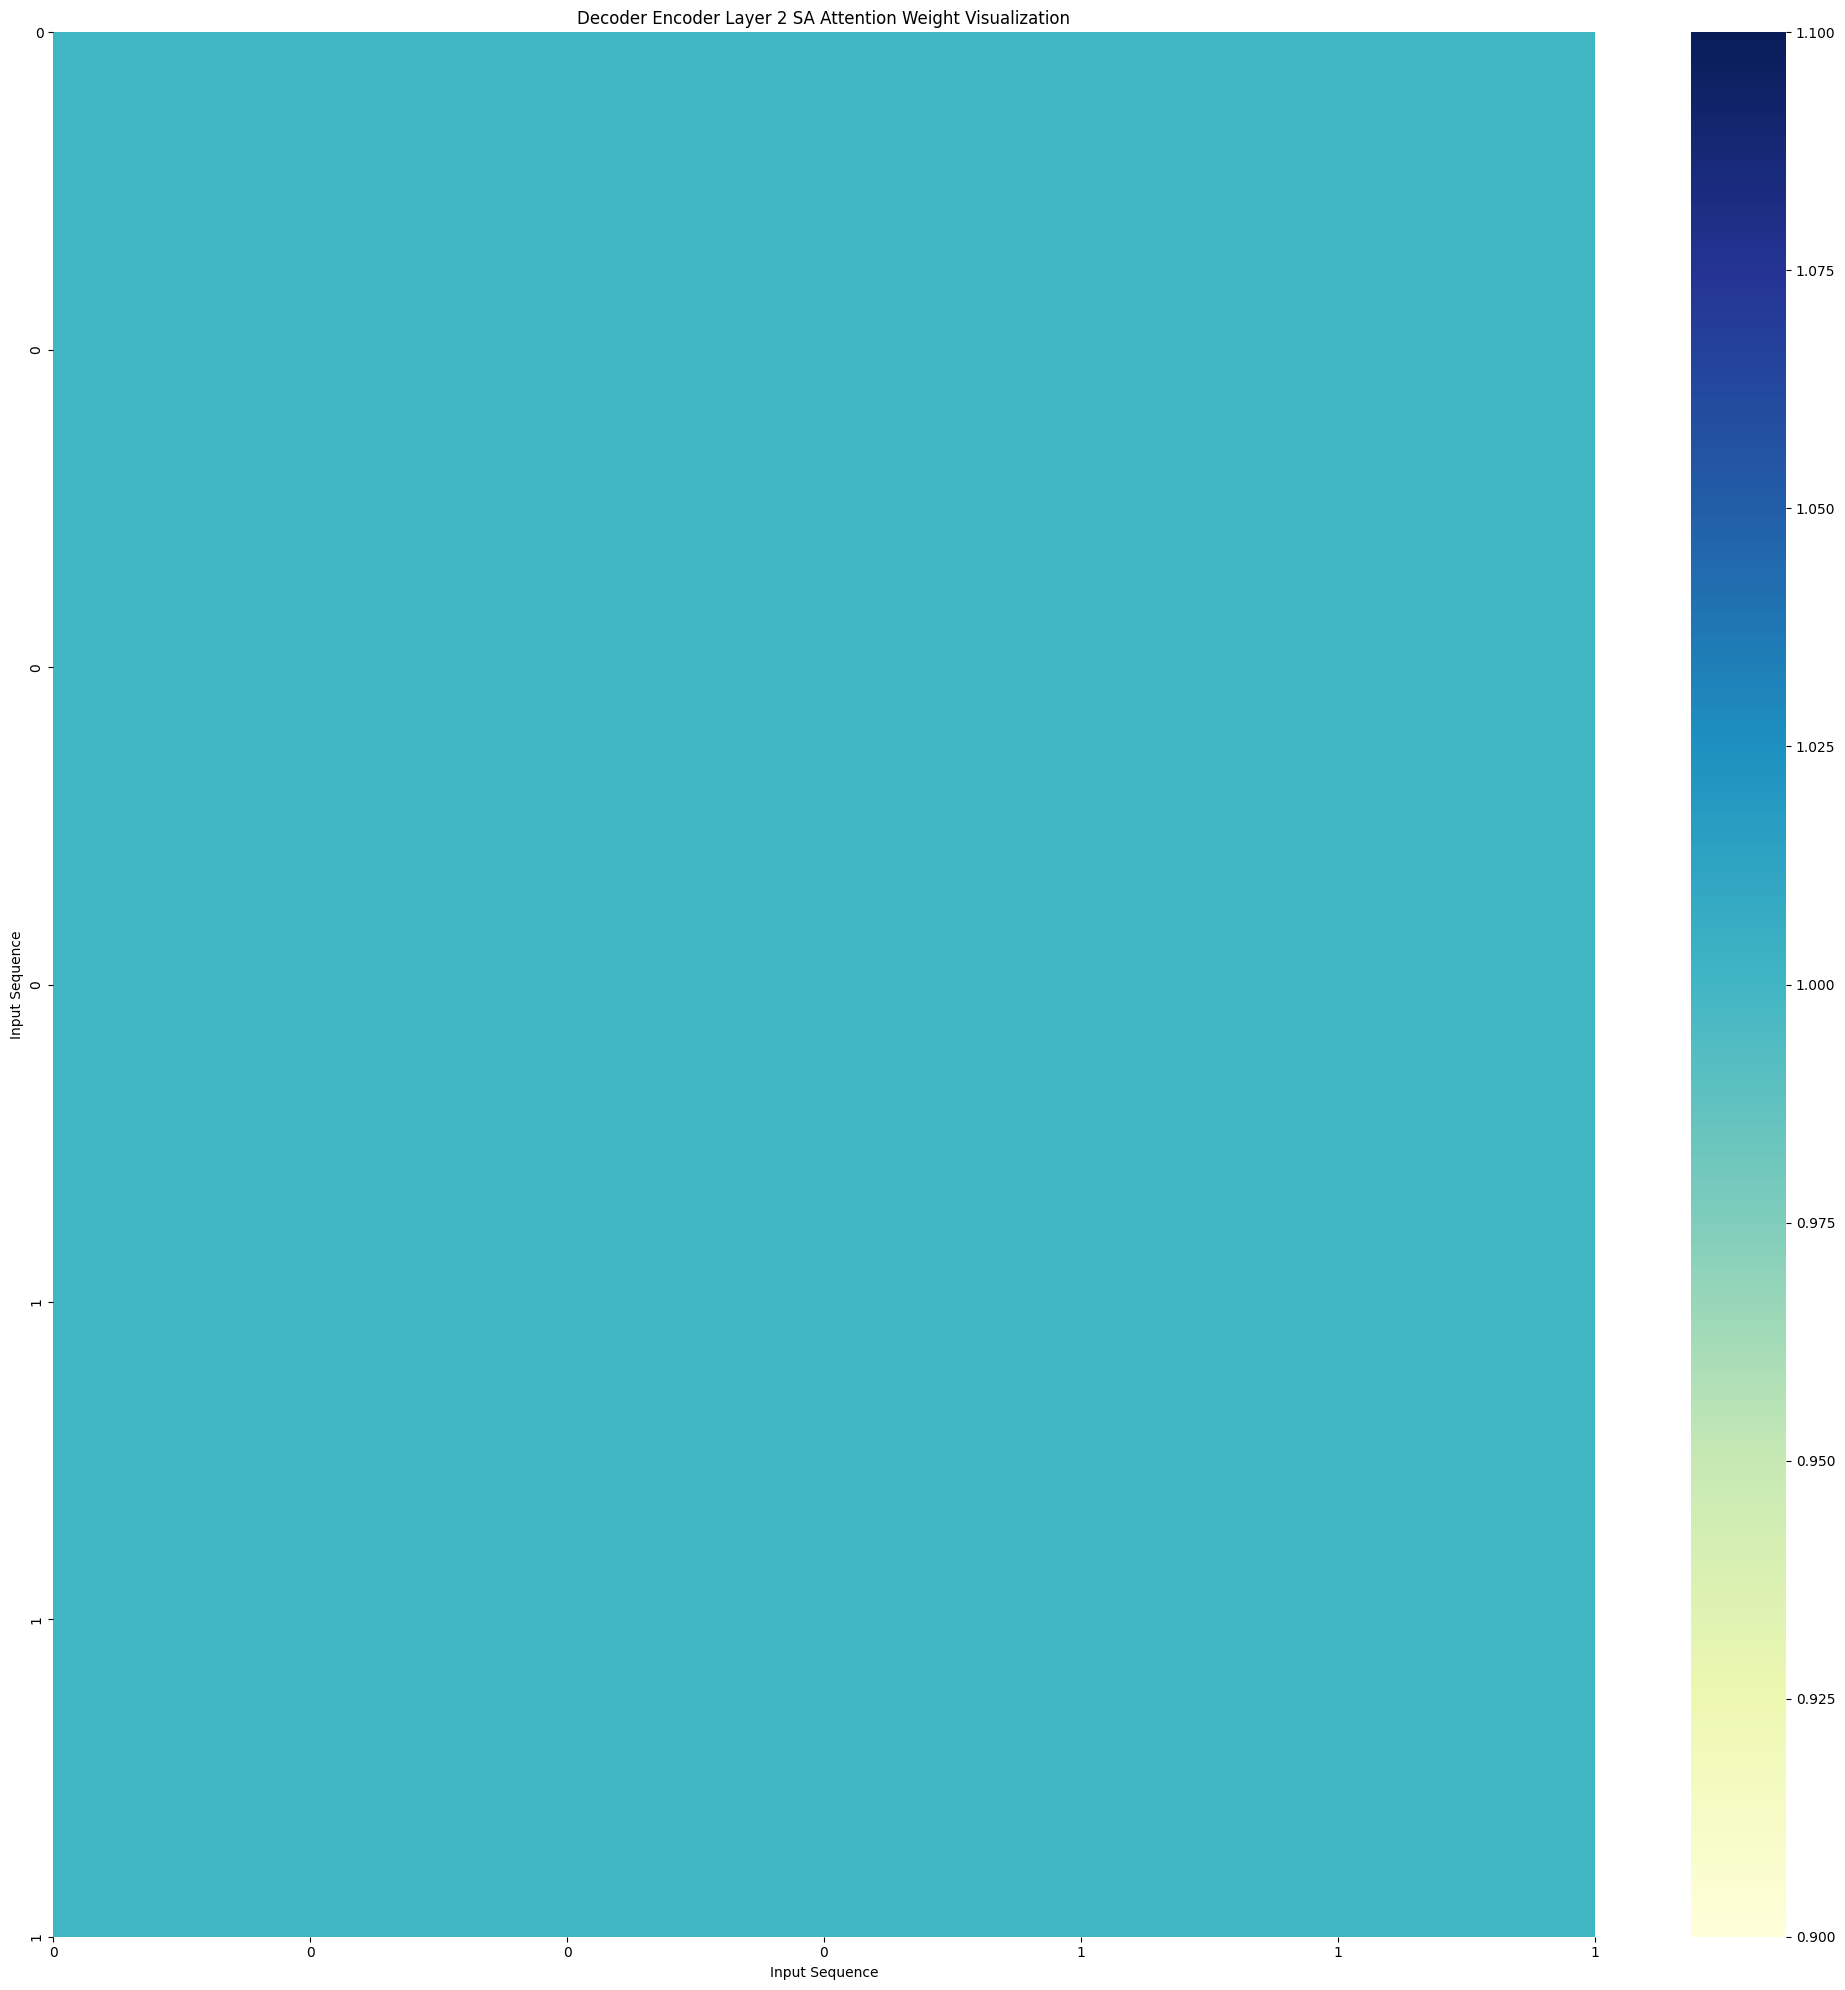

(1, 1)


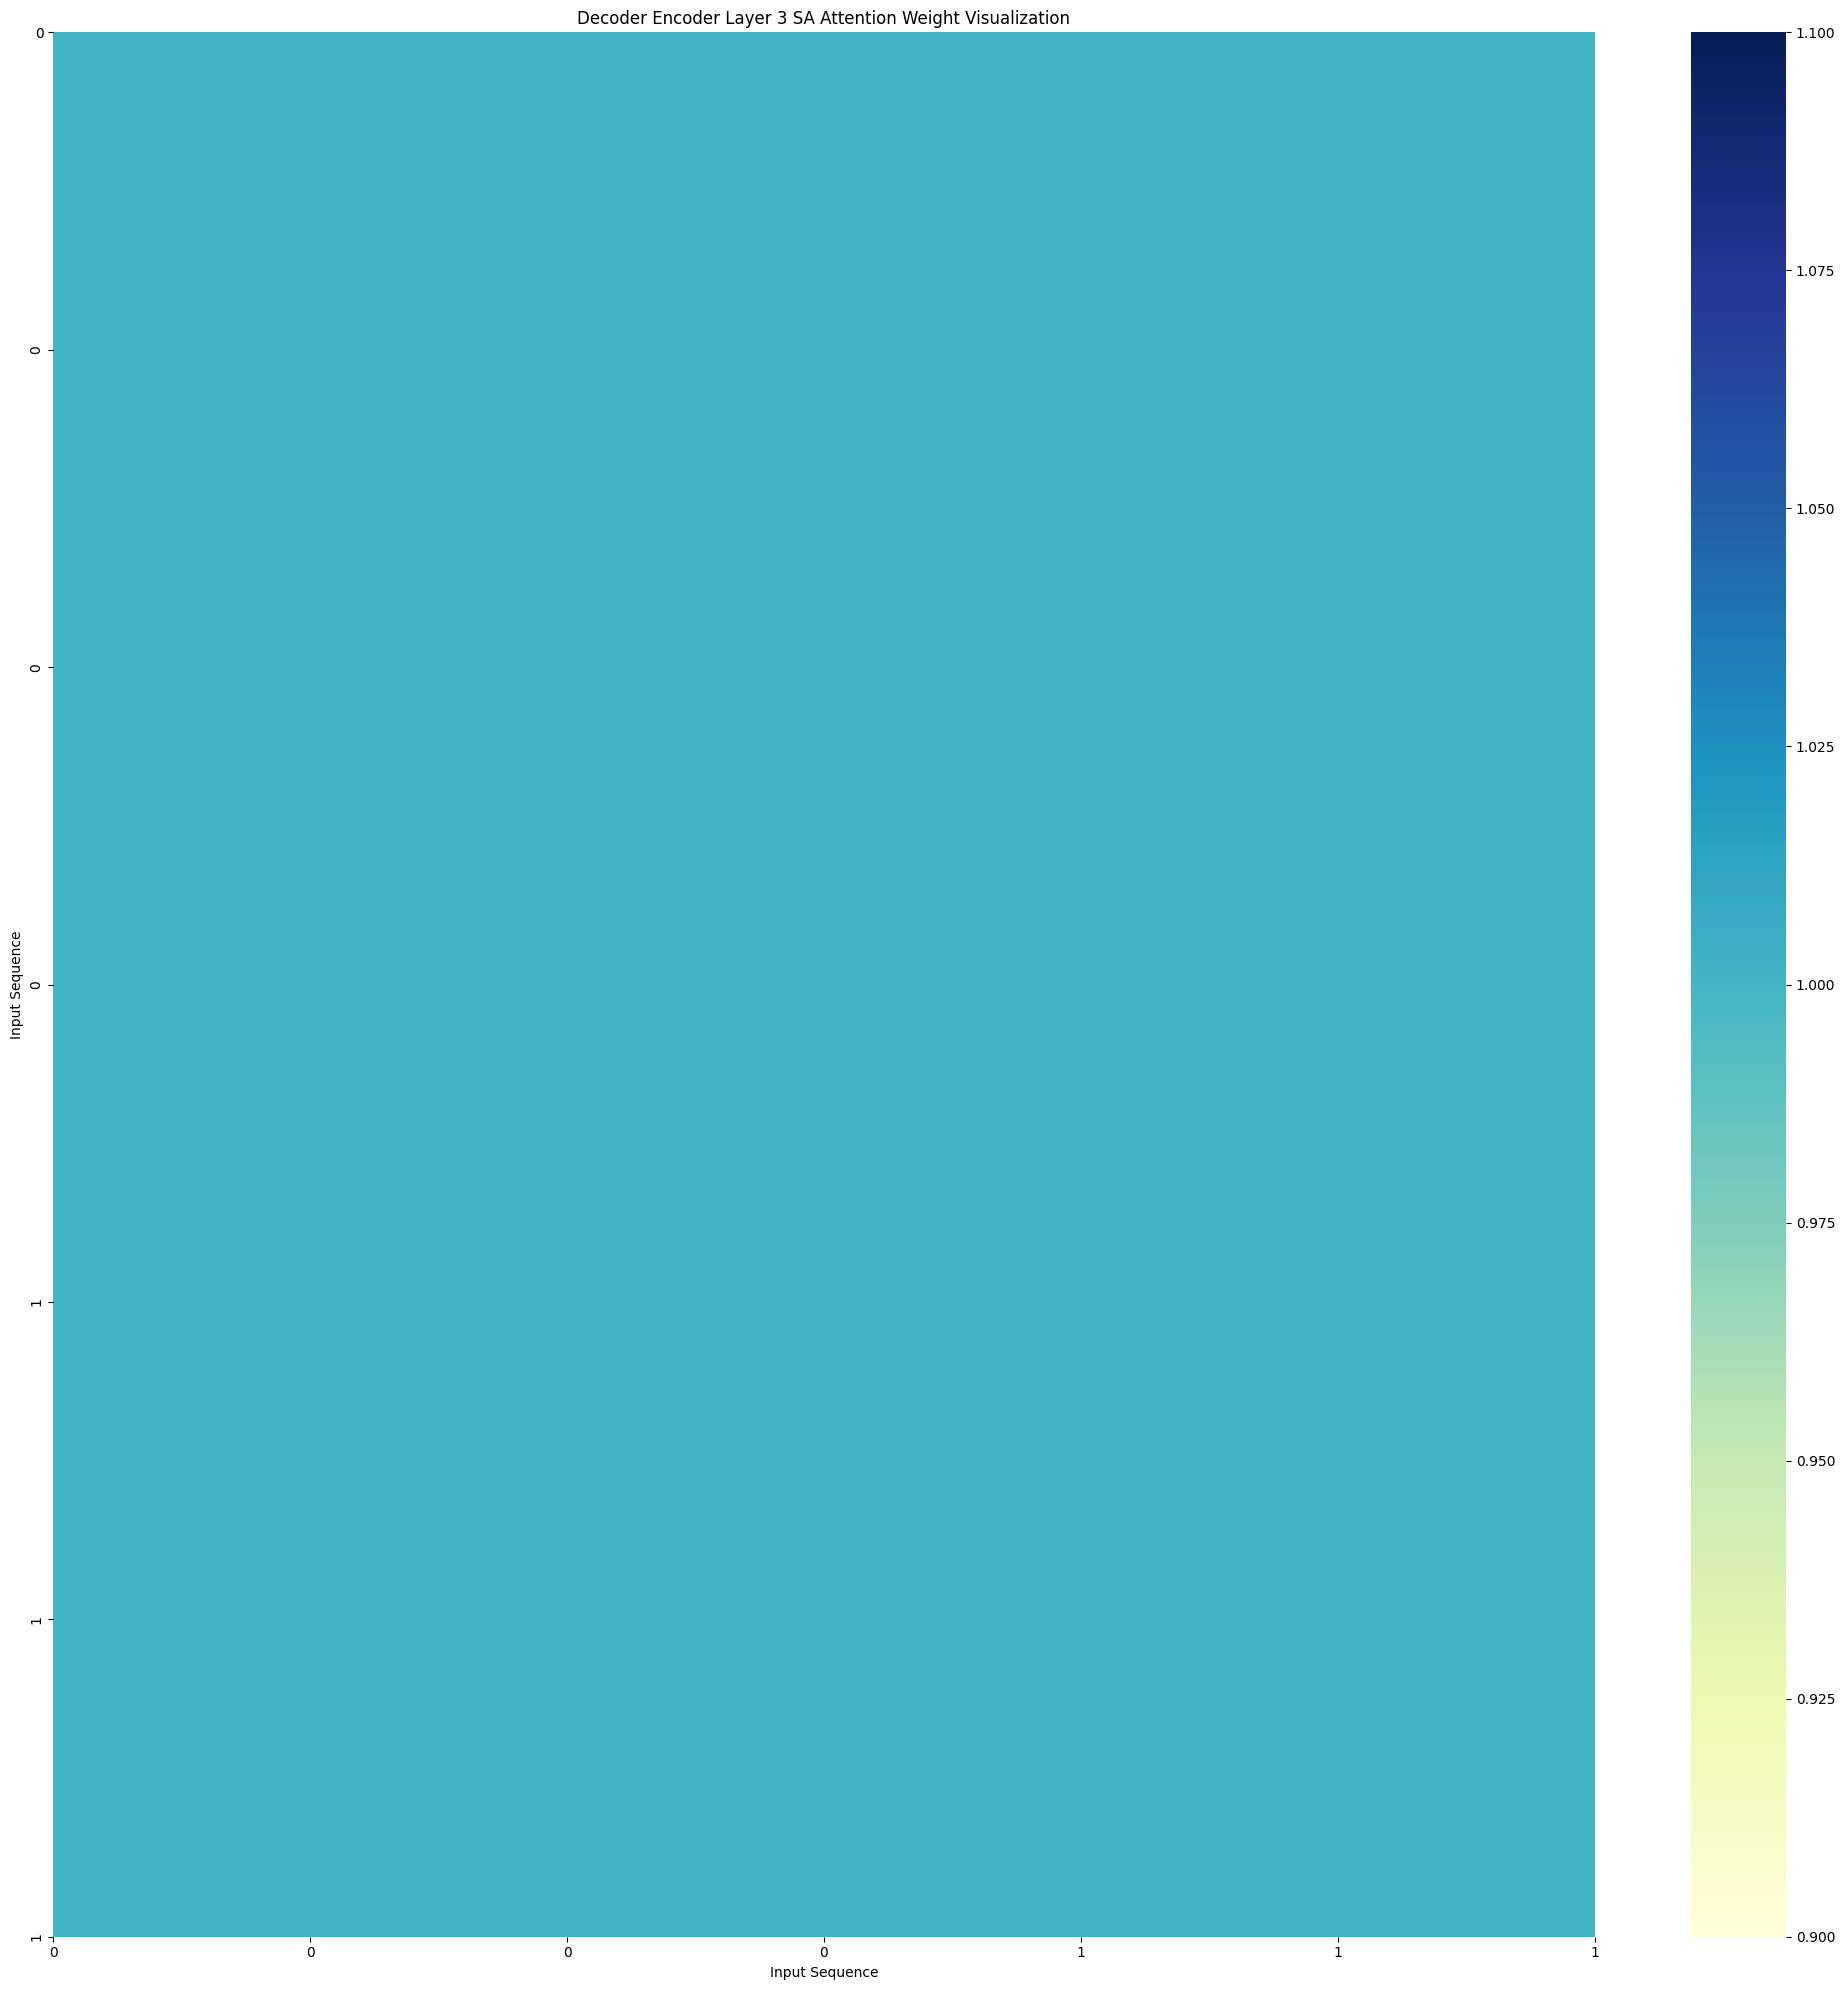

(1, 1)


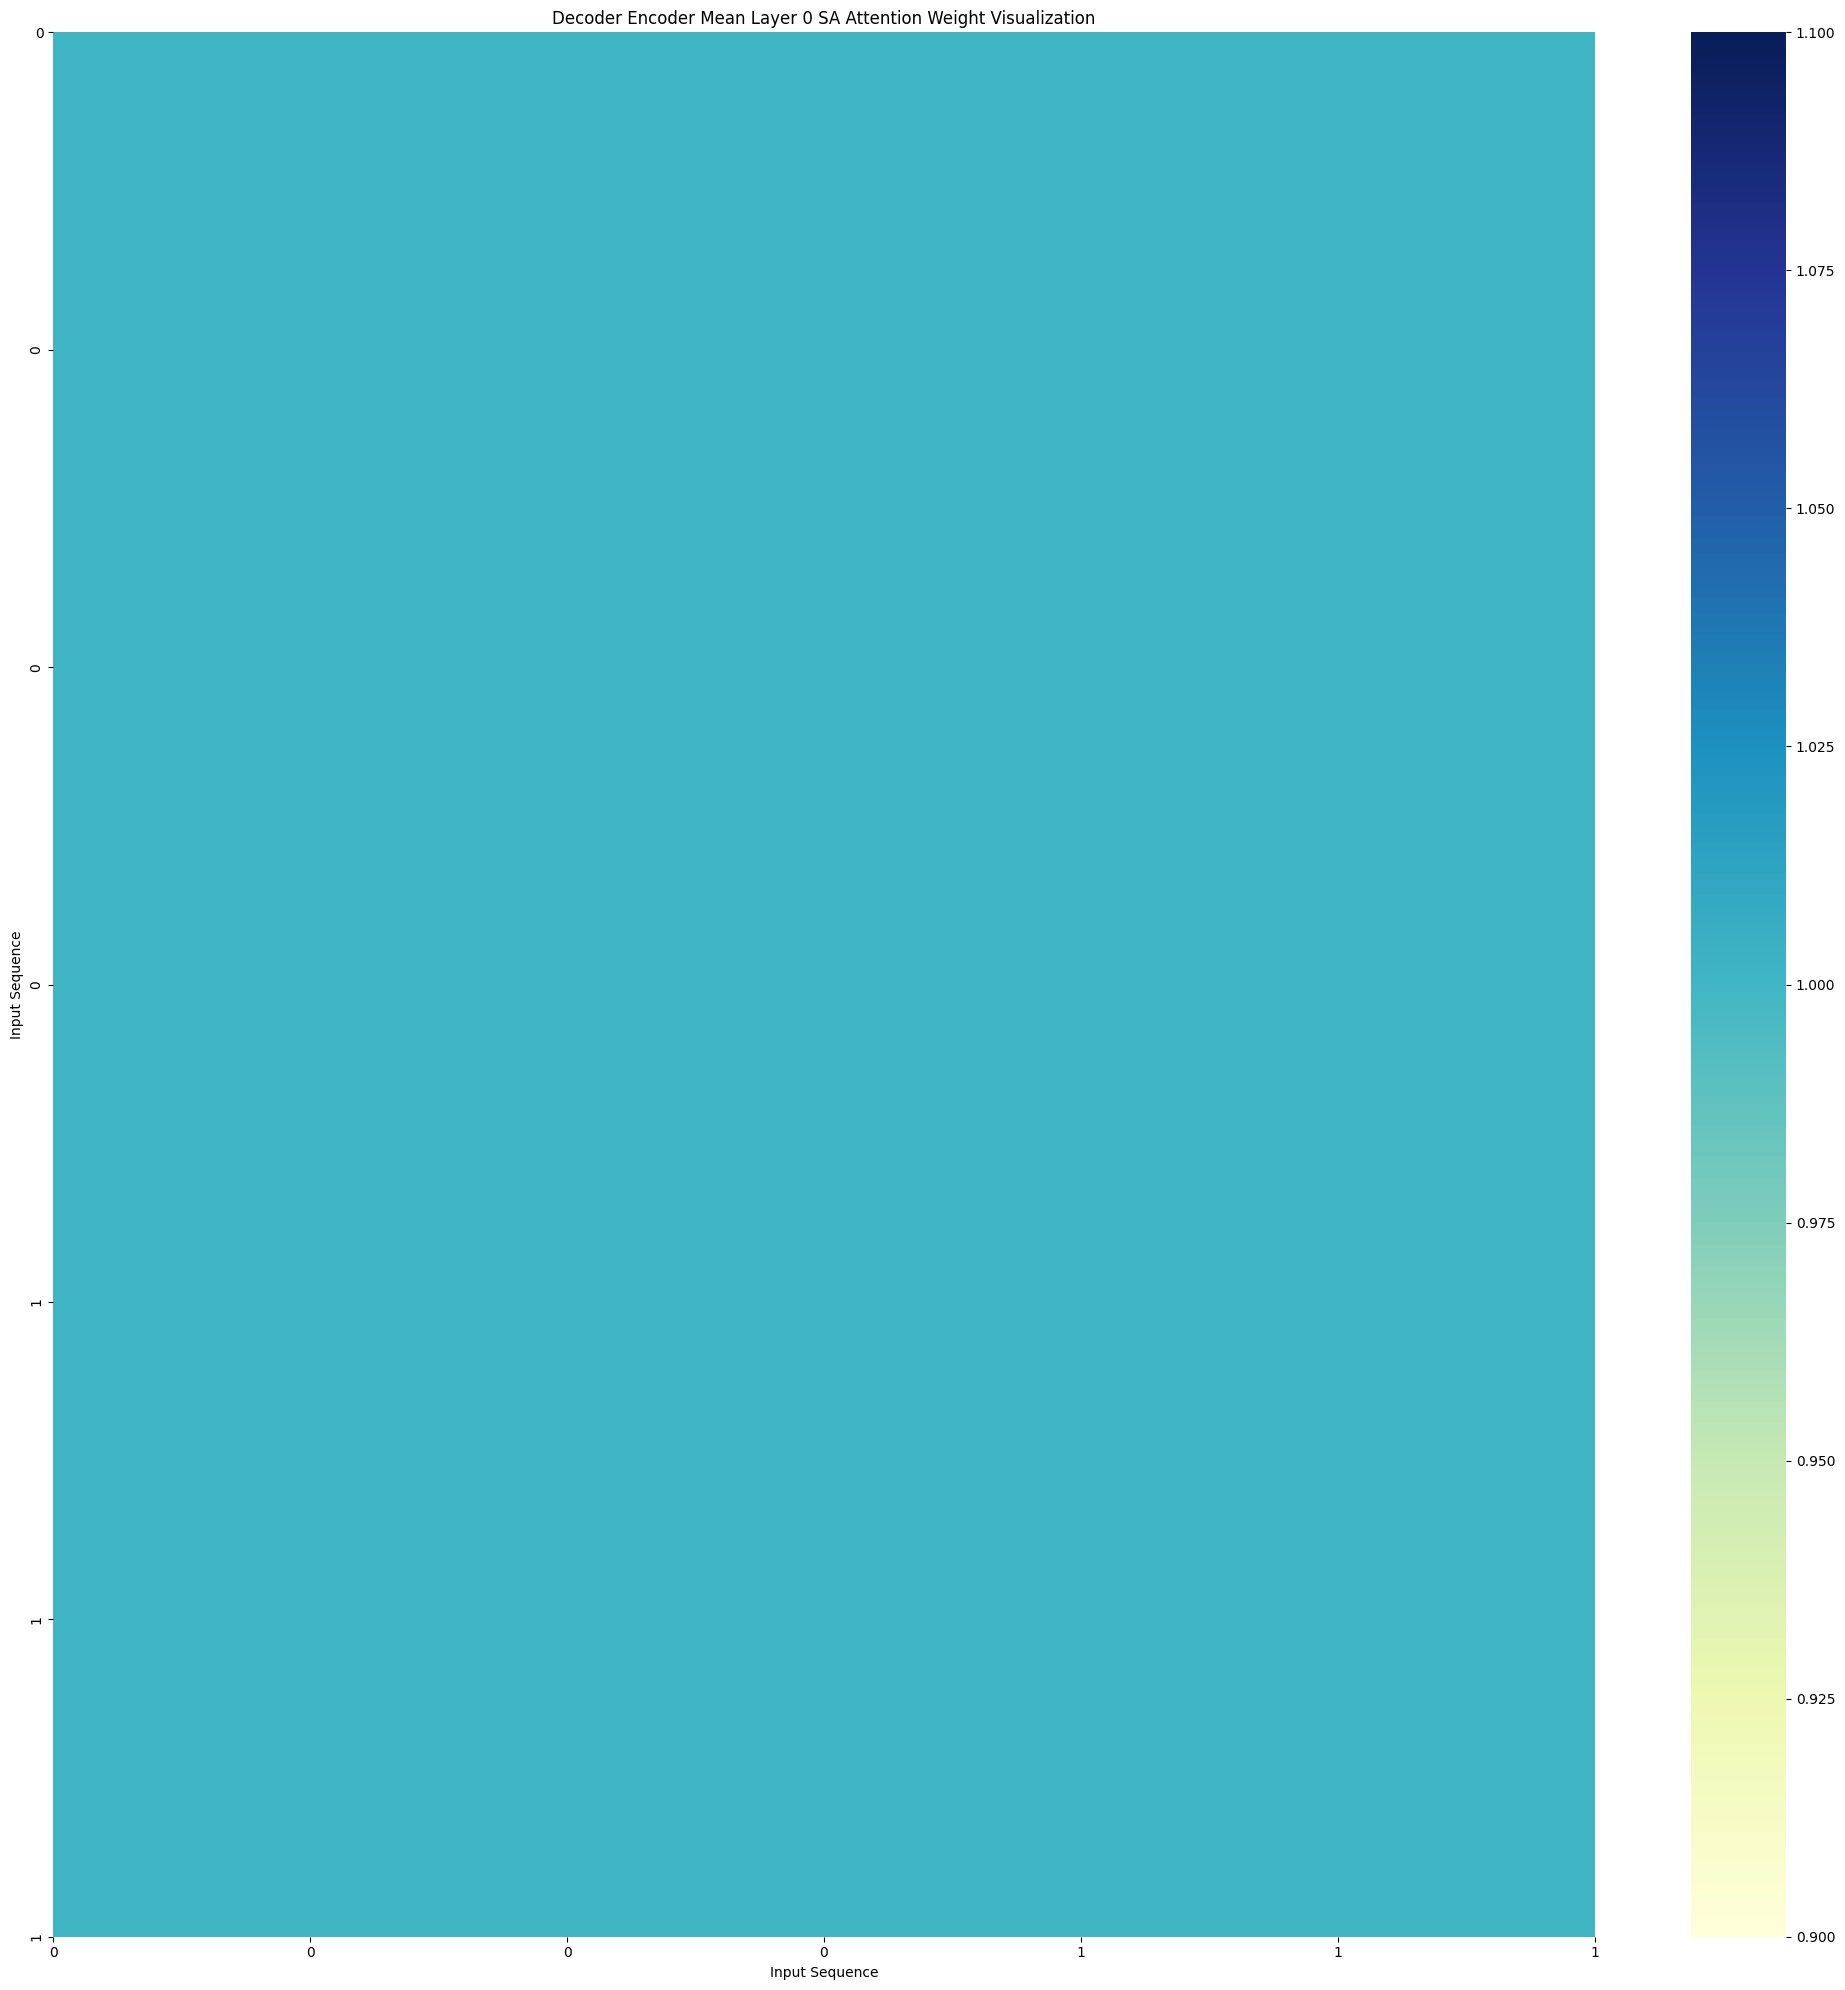

(10, 10)


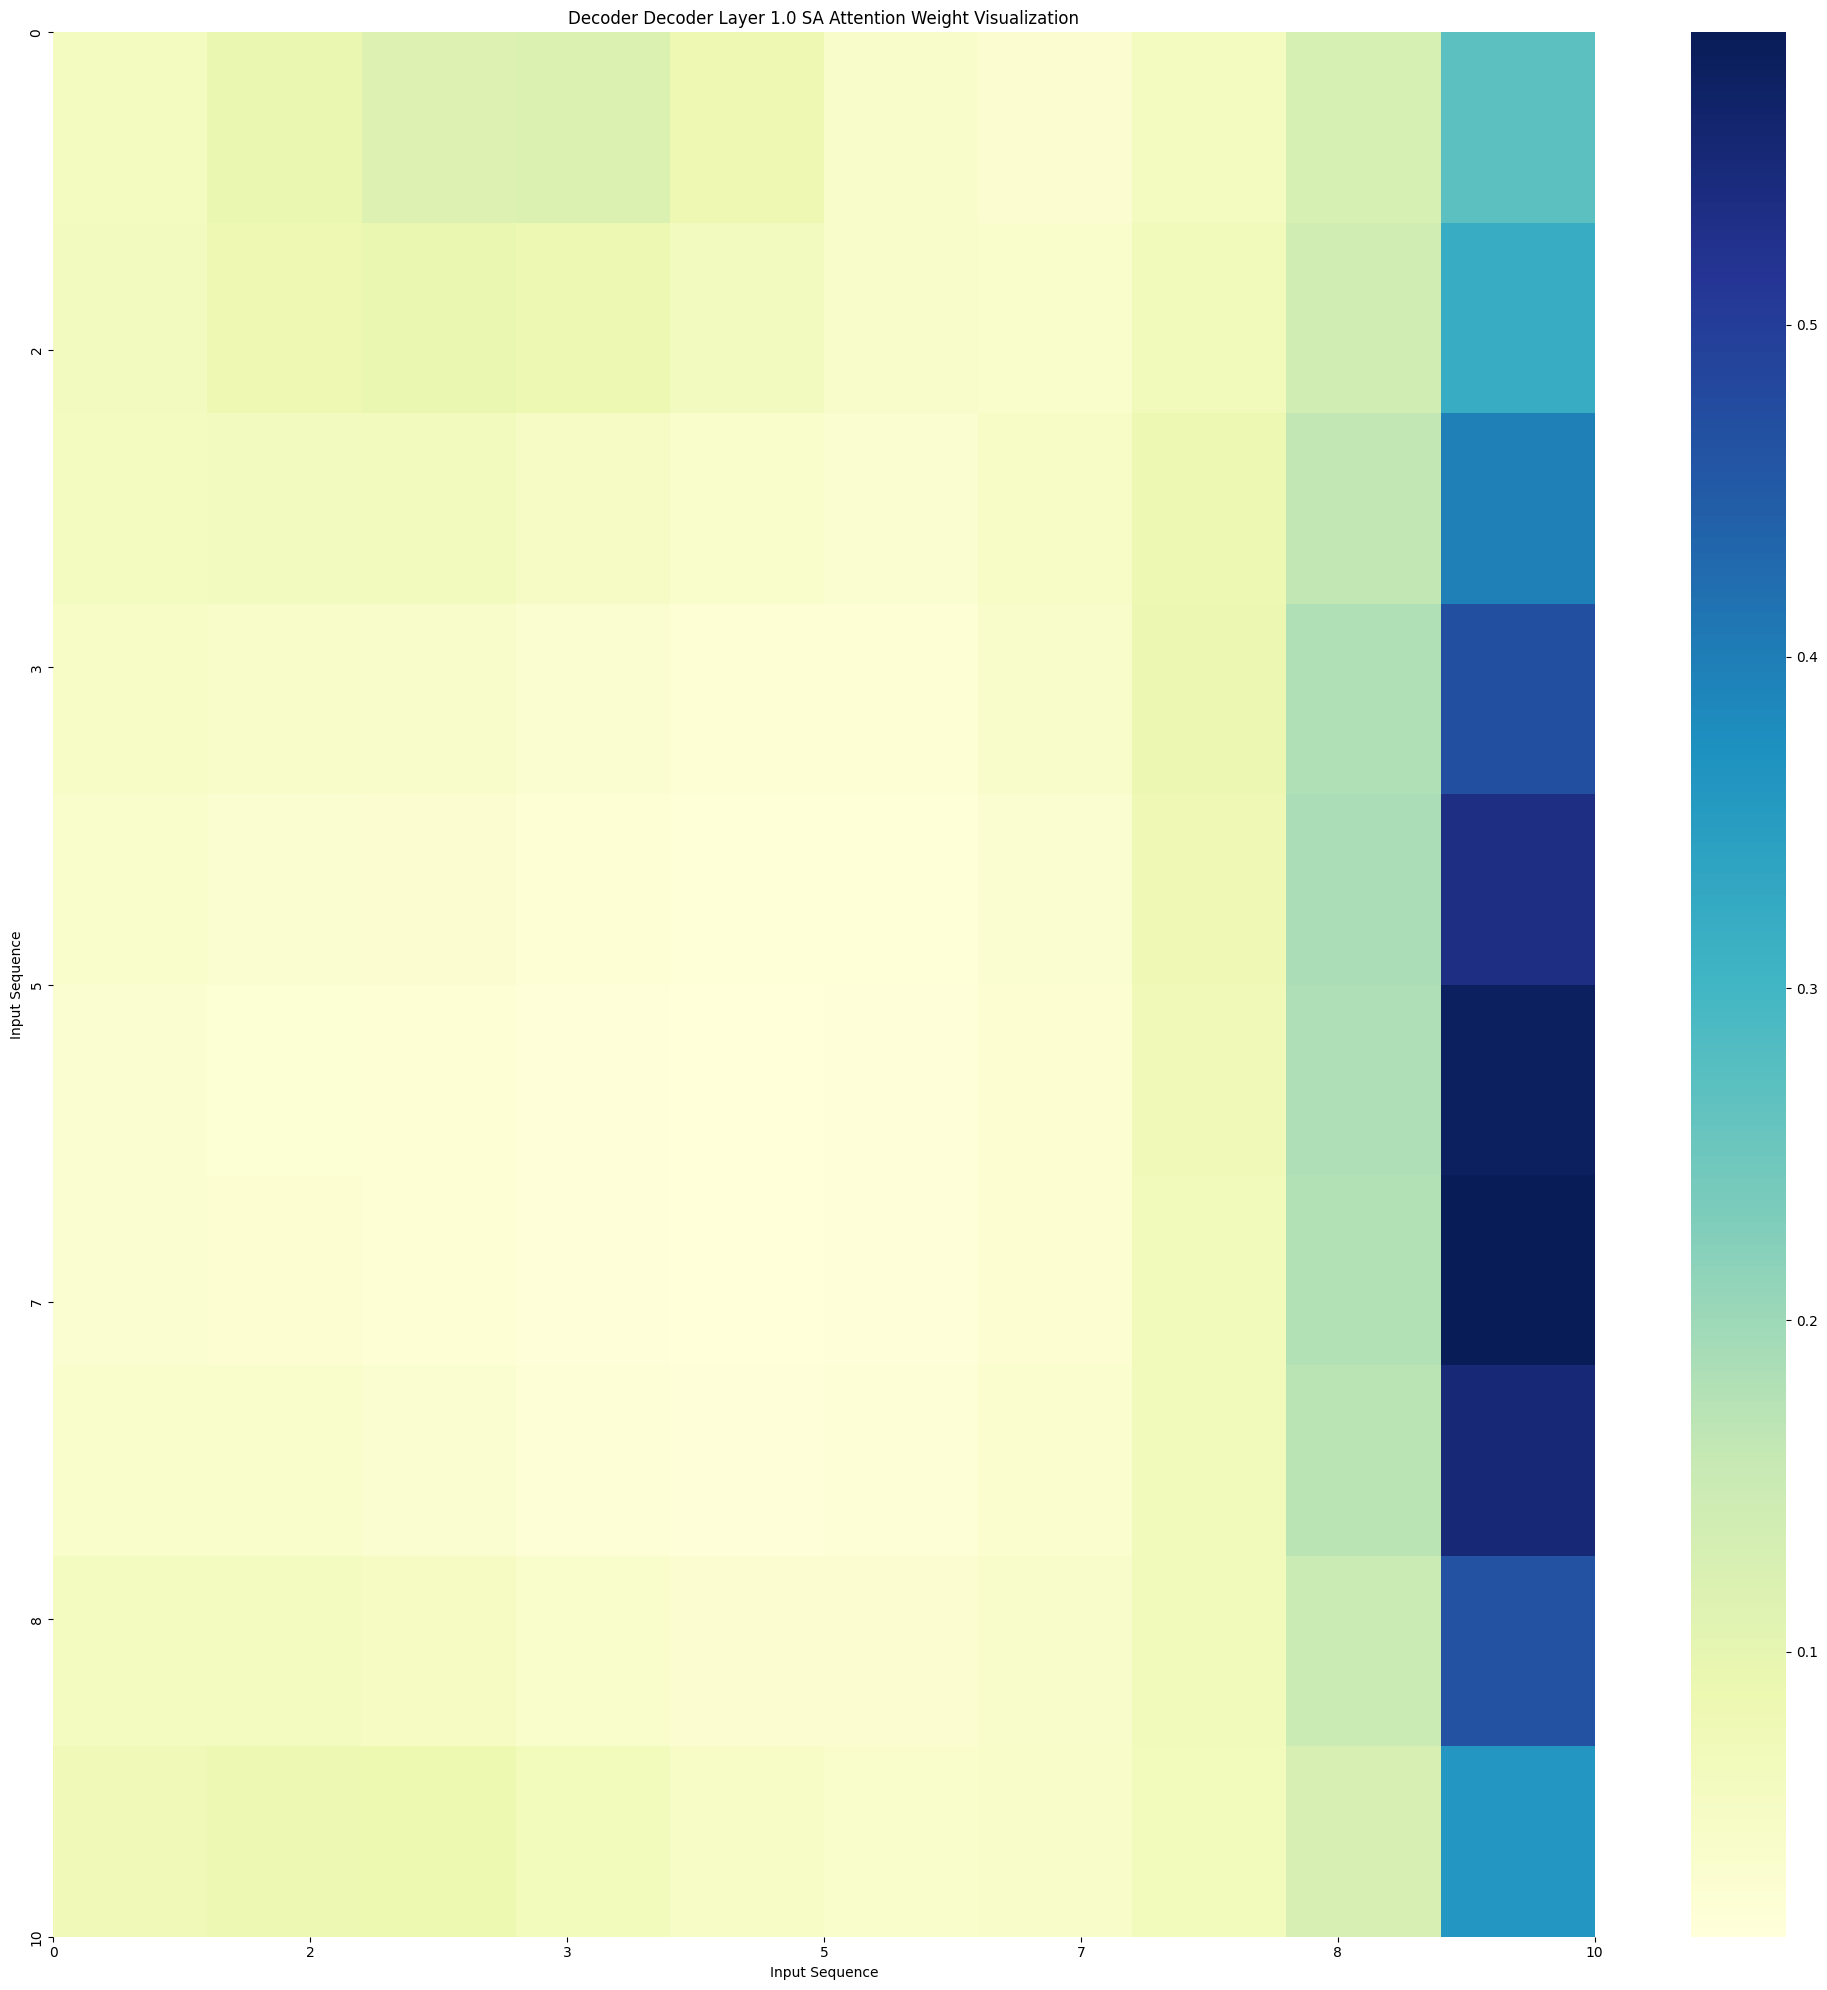

(10, 1)


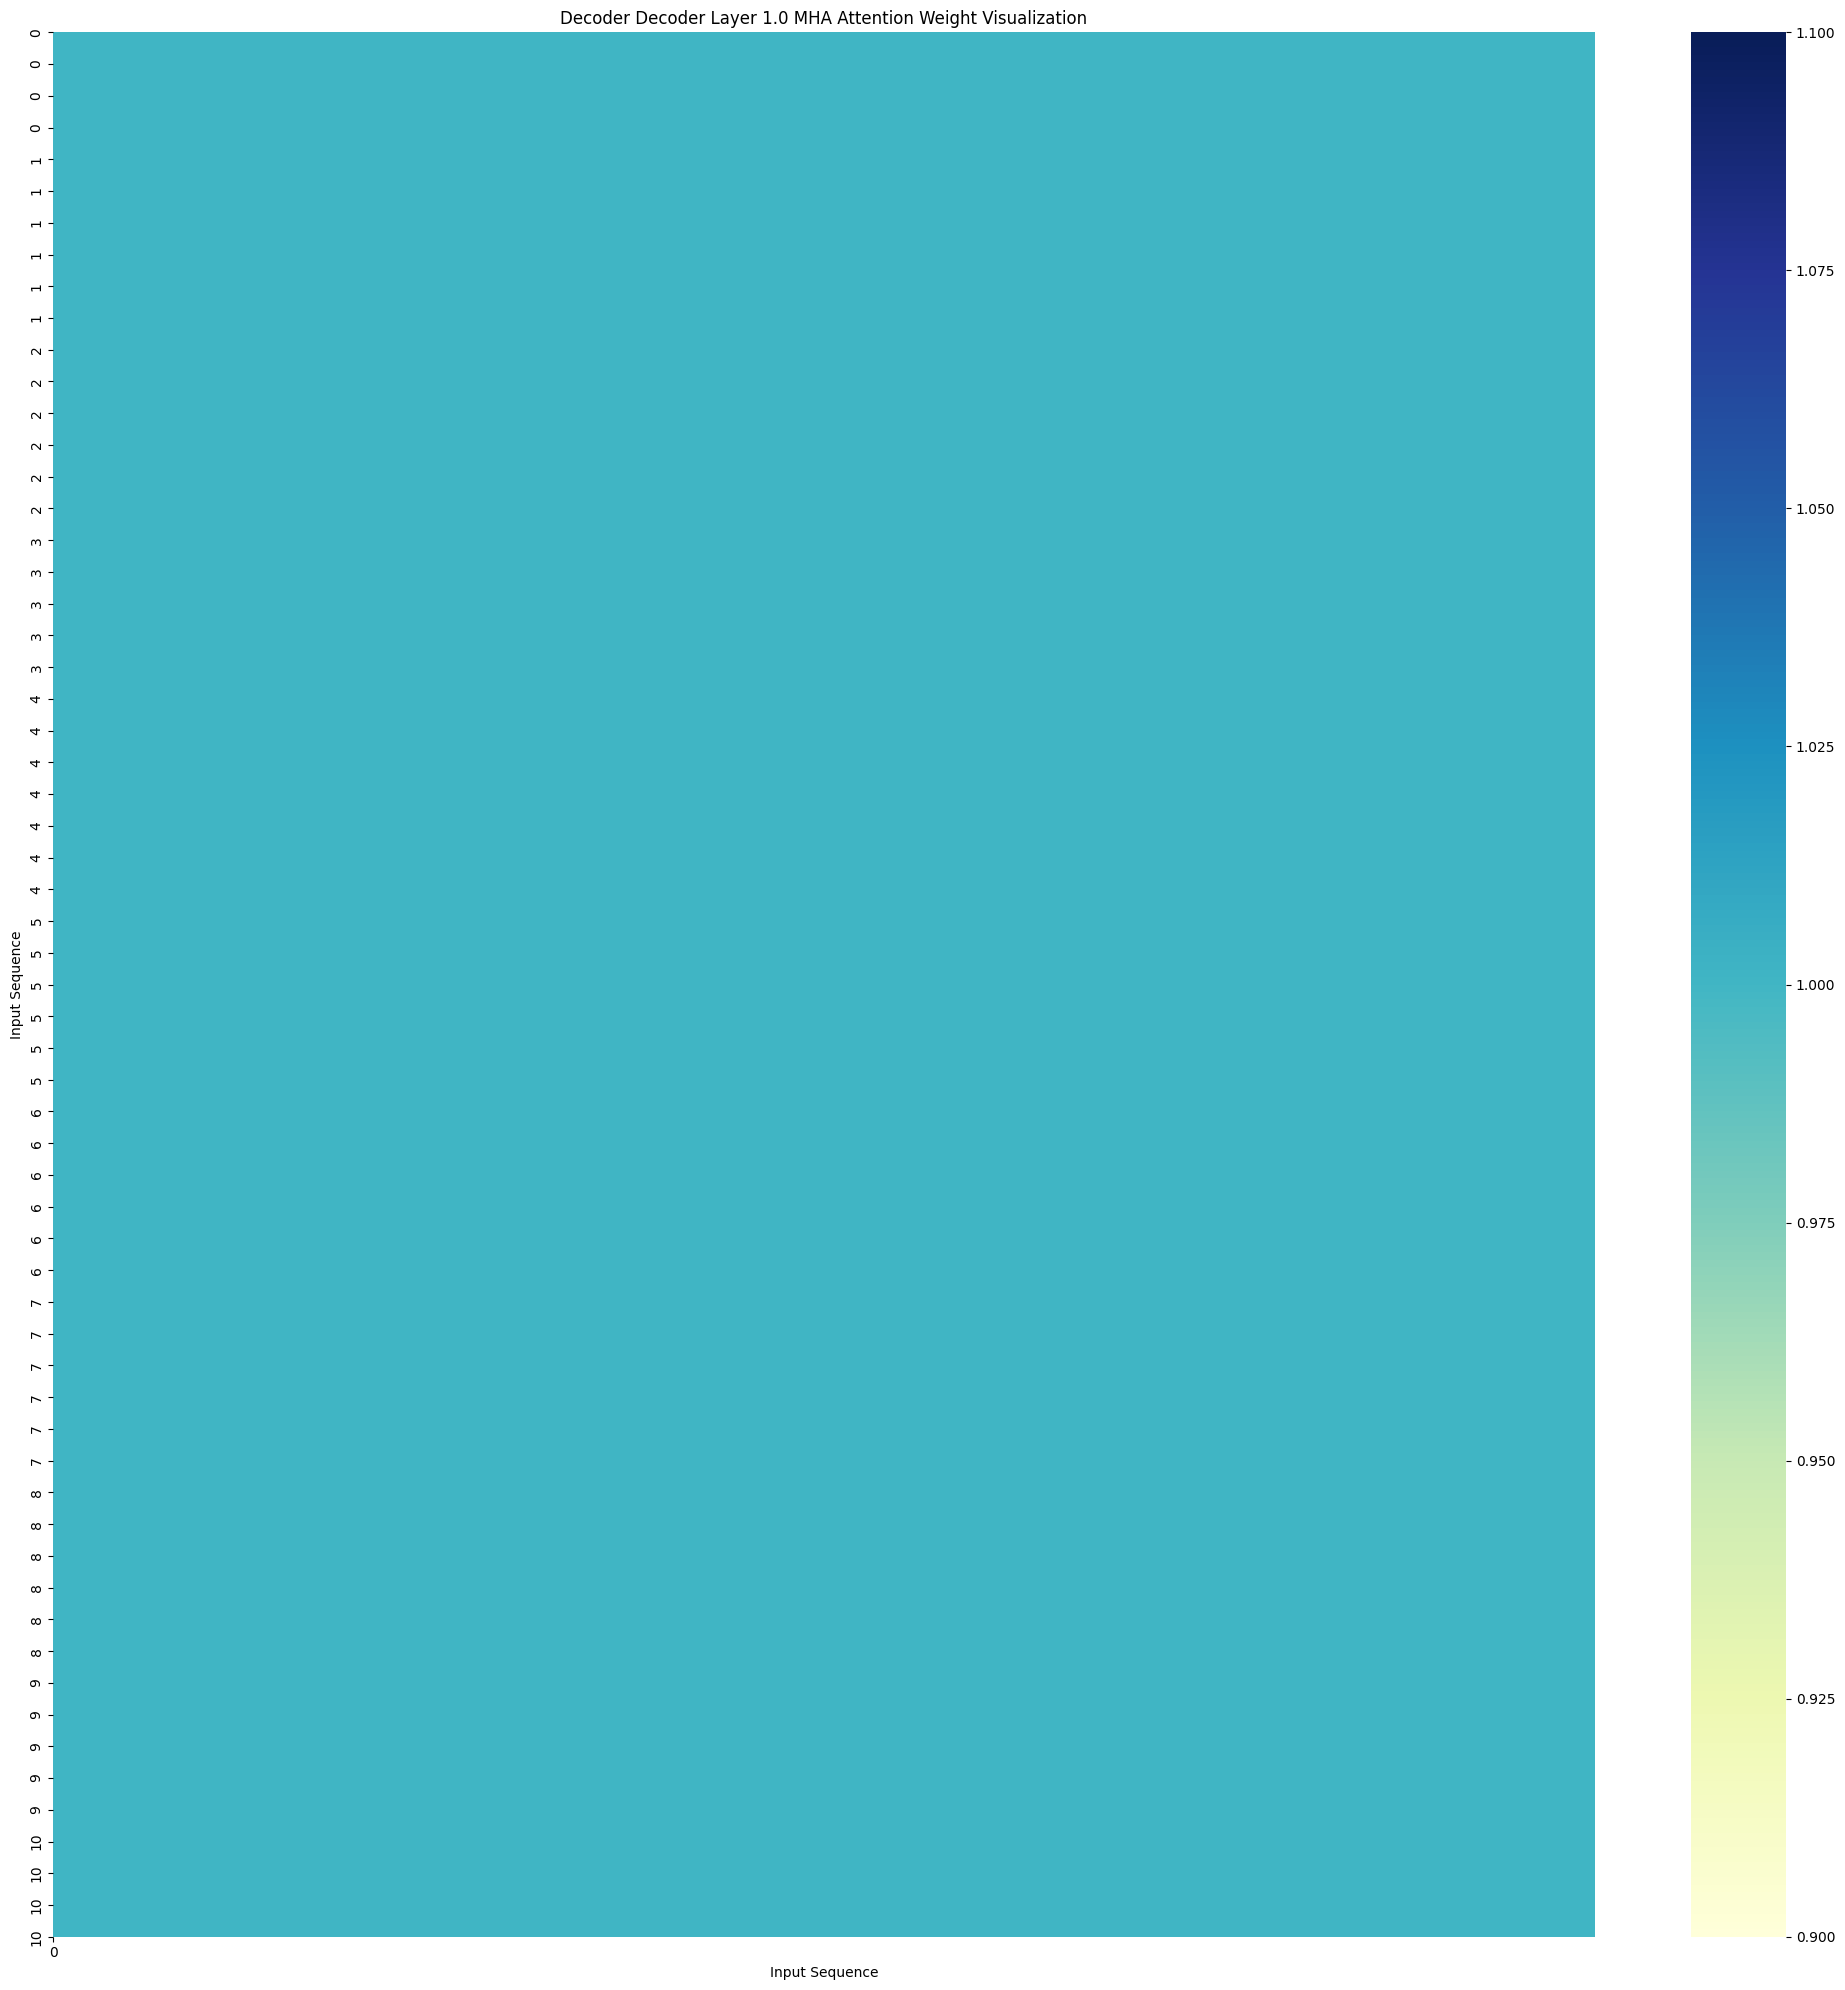

(10, 10)


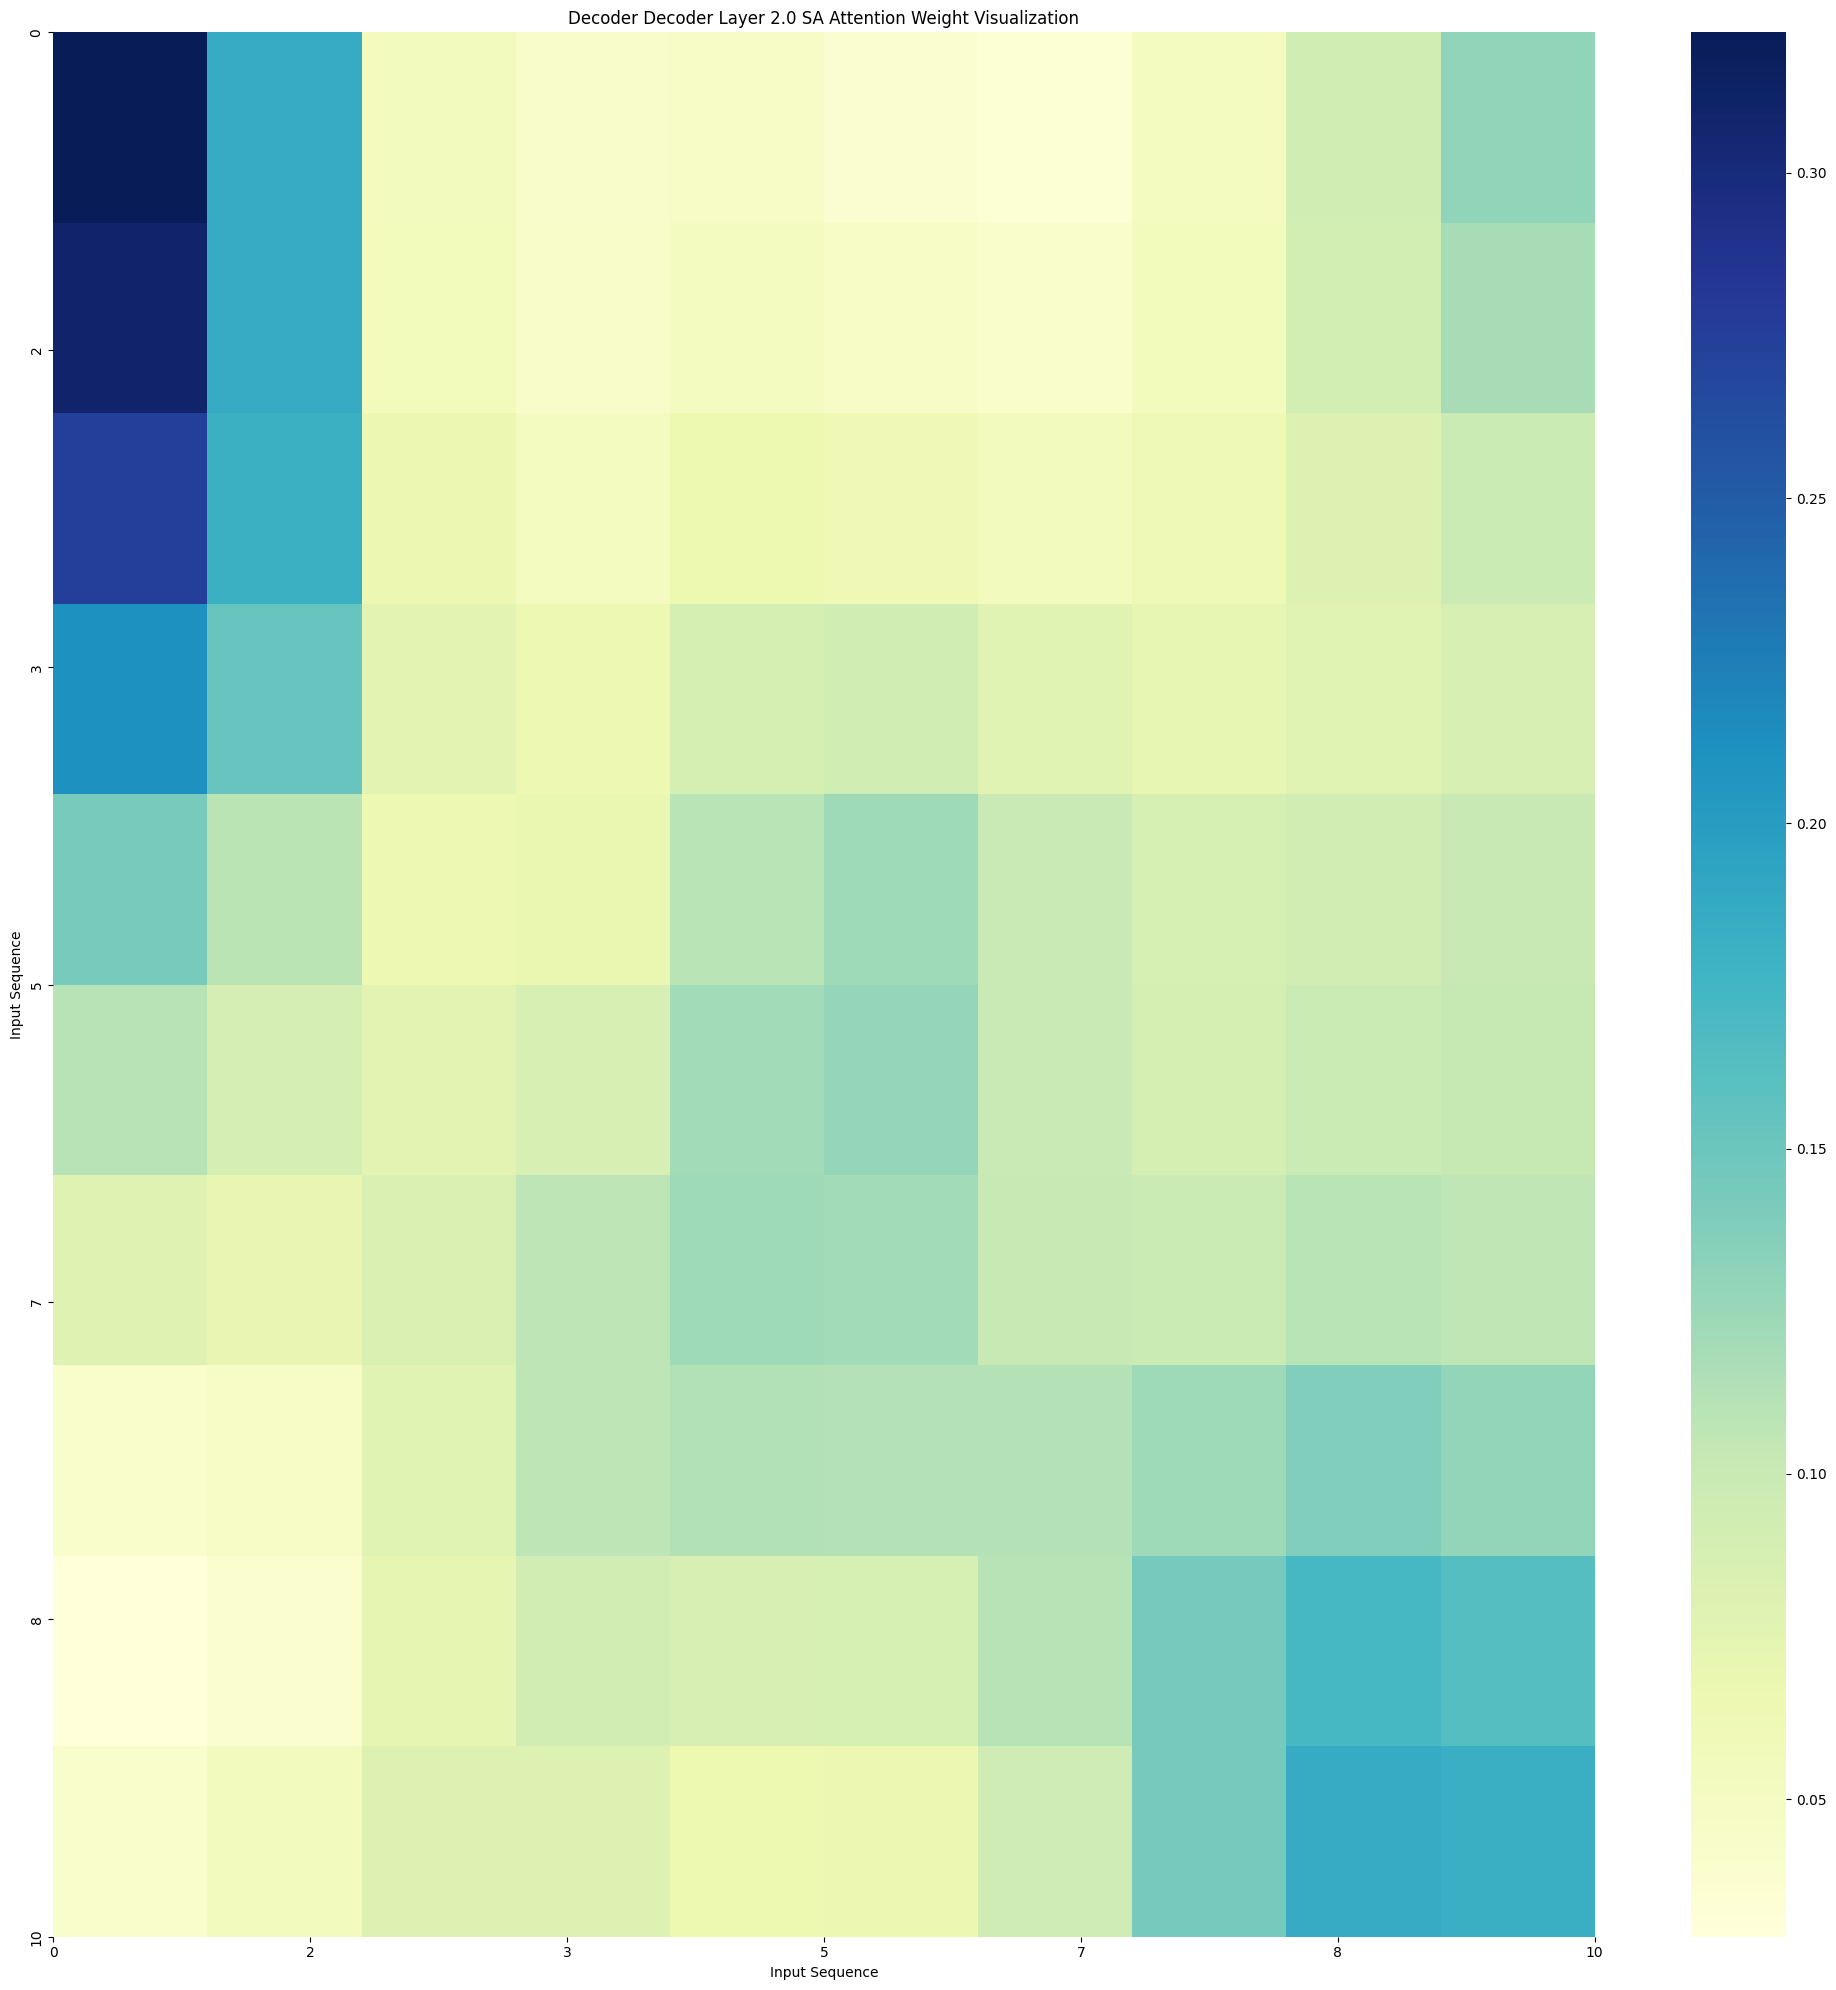

(10, 1)


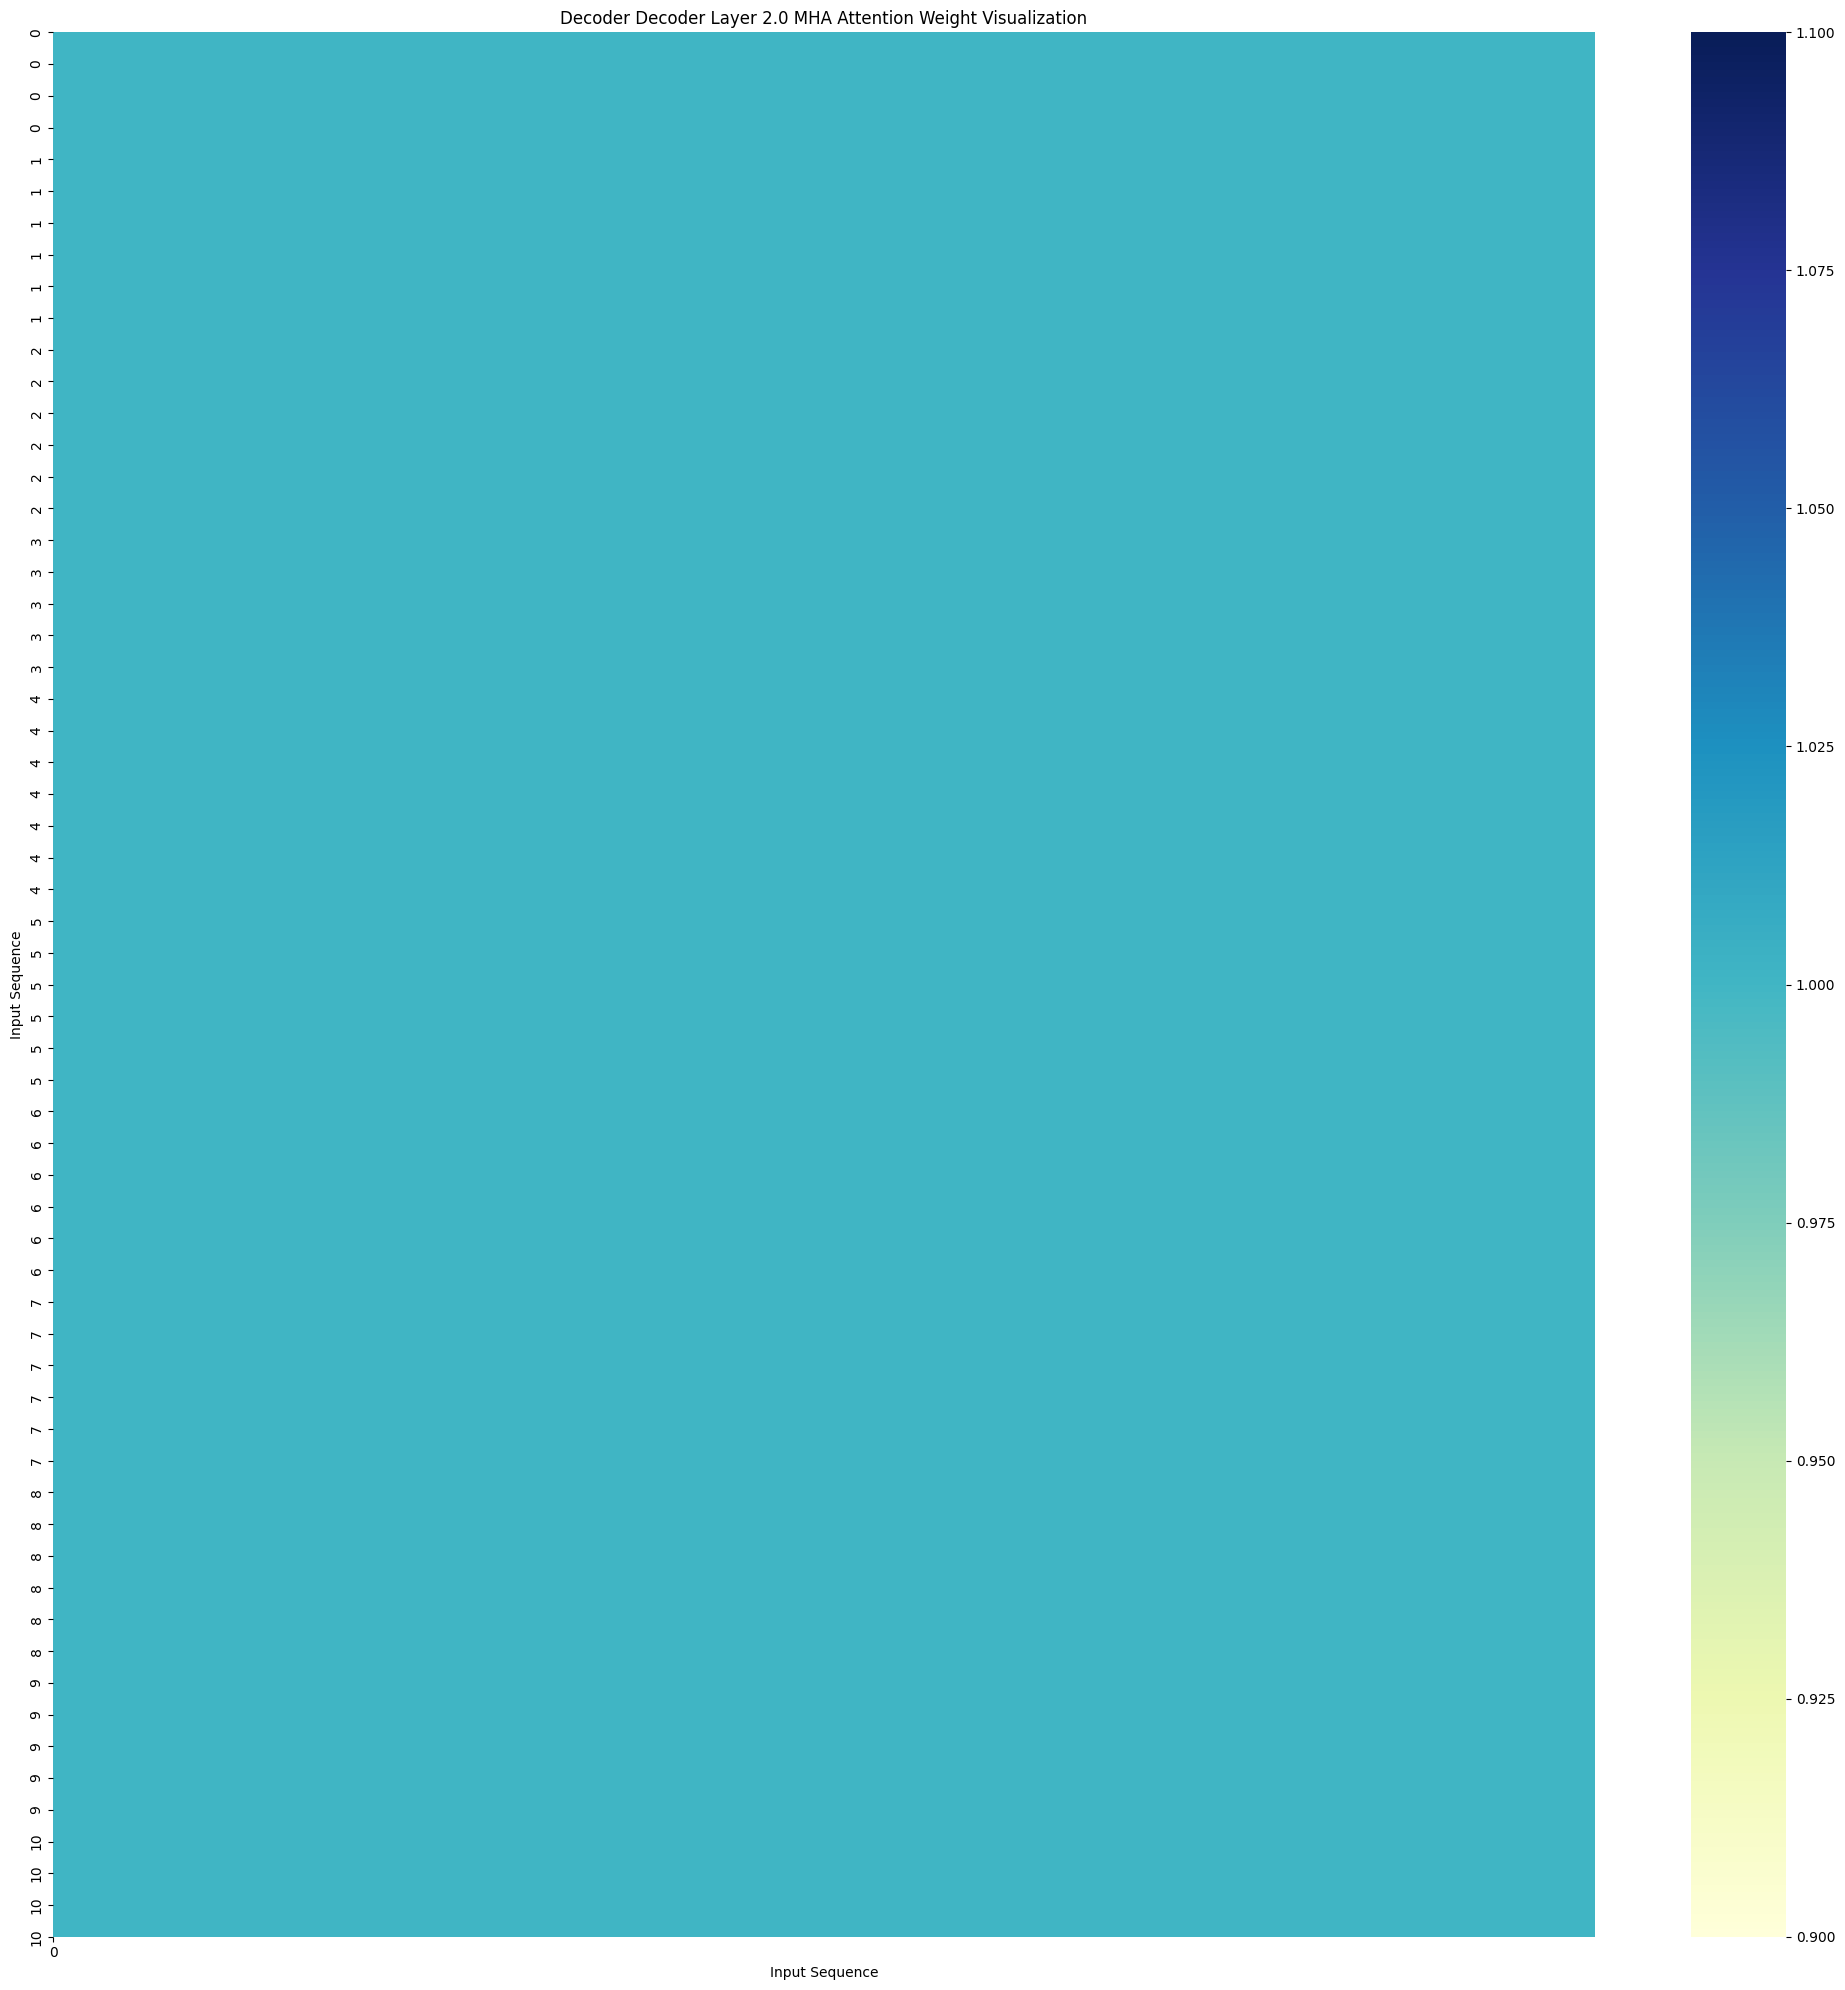

(10, 10)


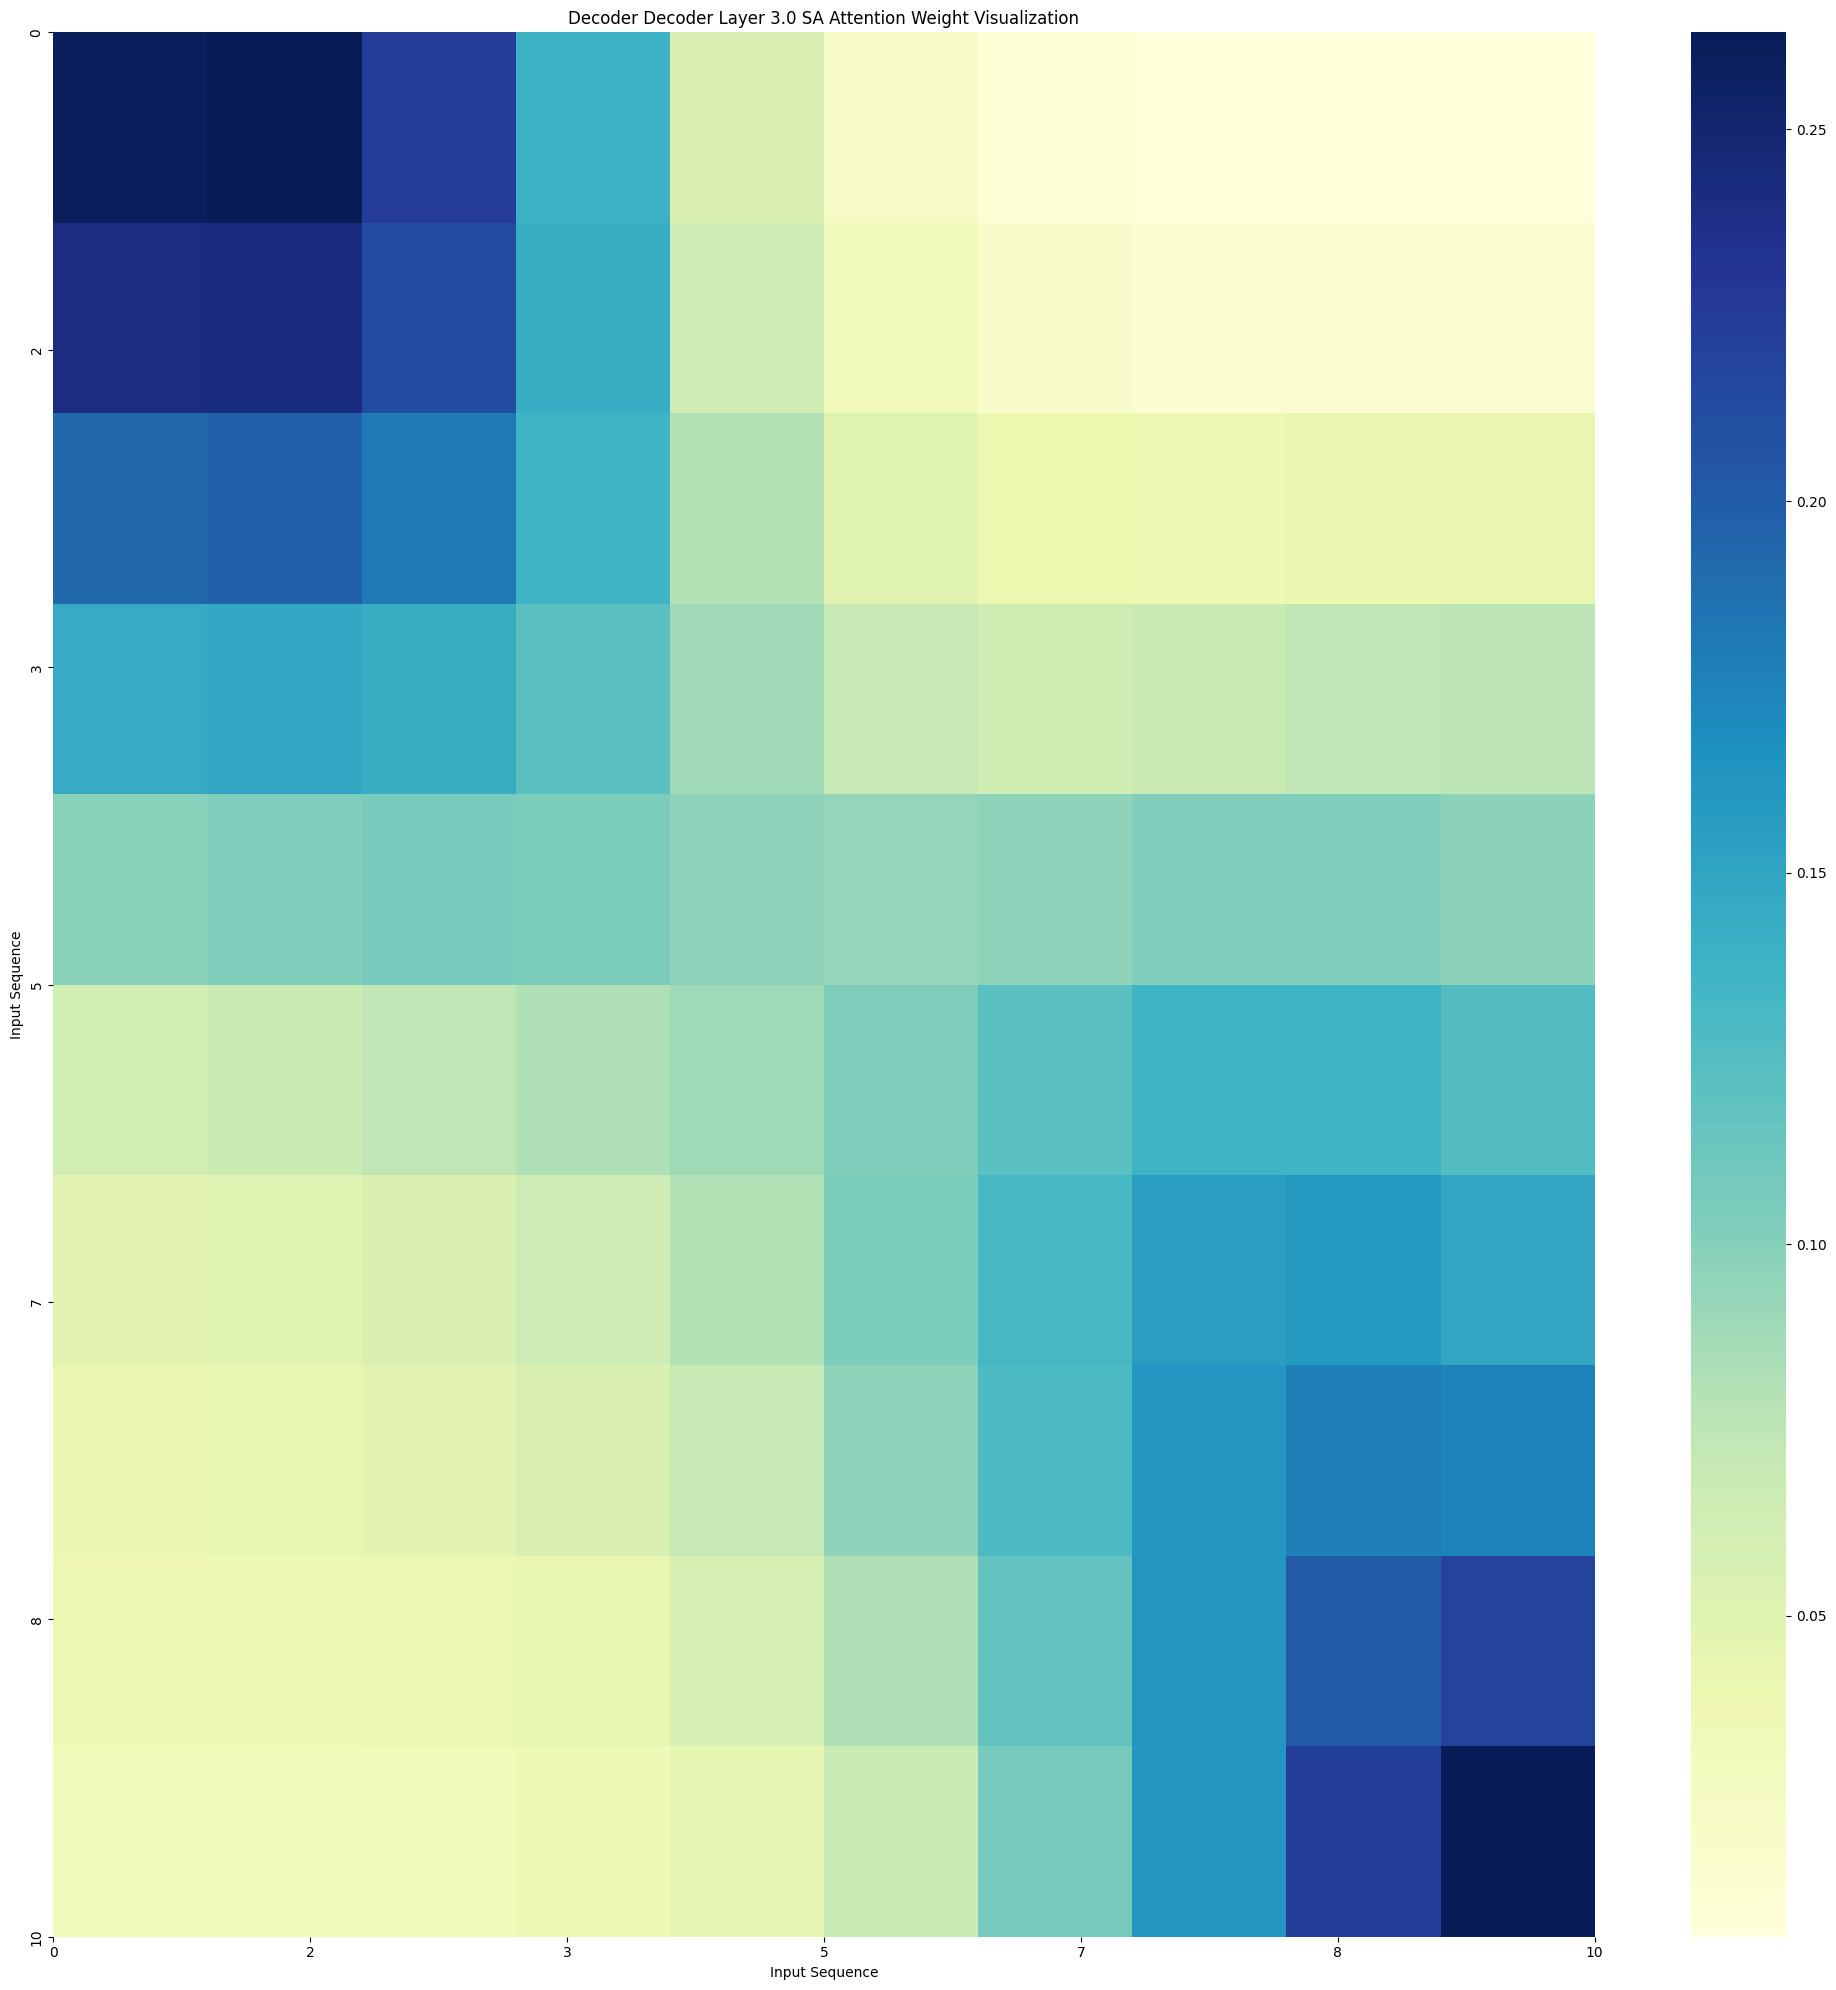

(10, 1)


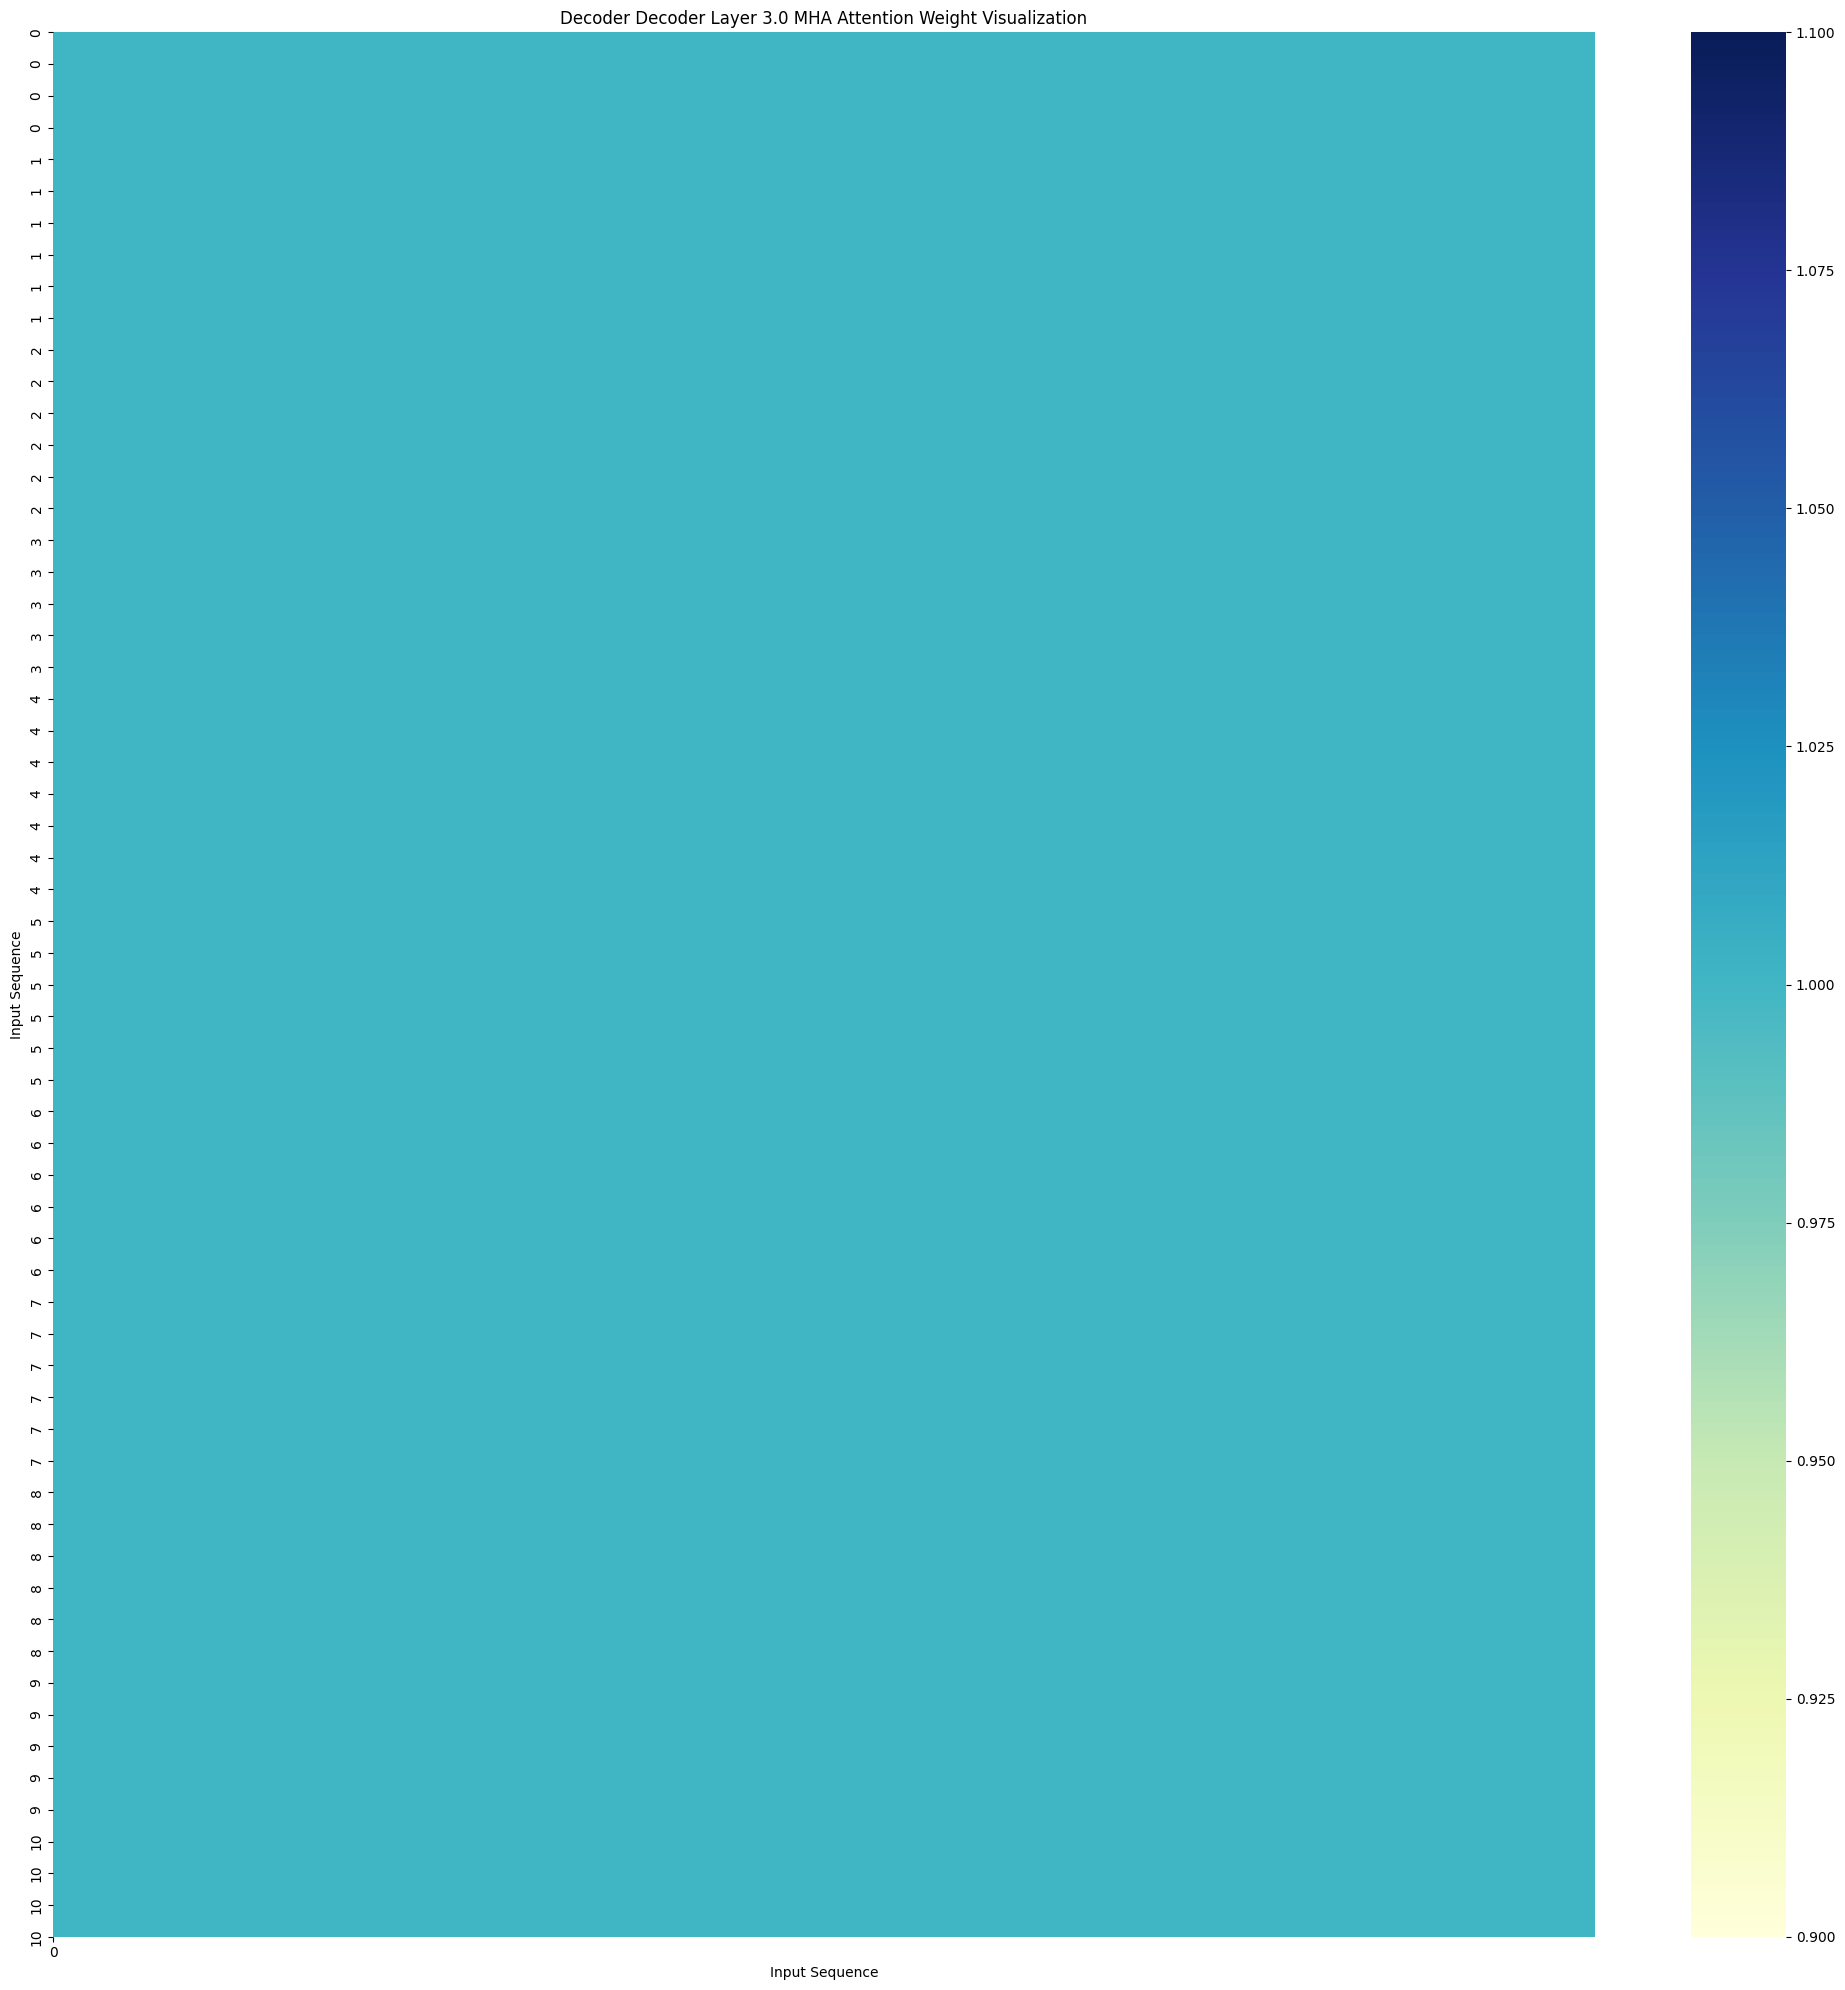

(10, 10)


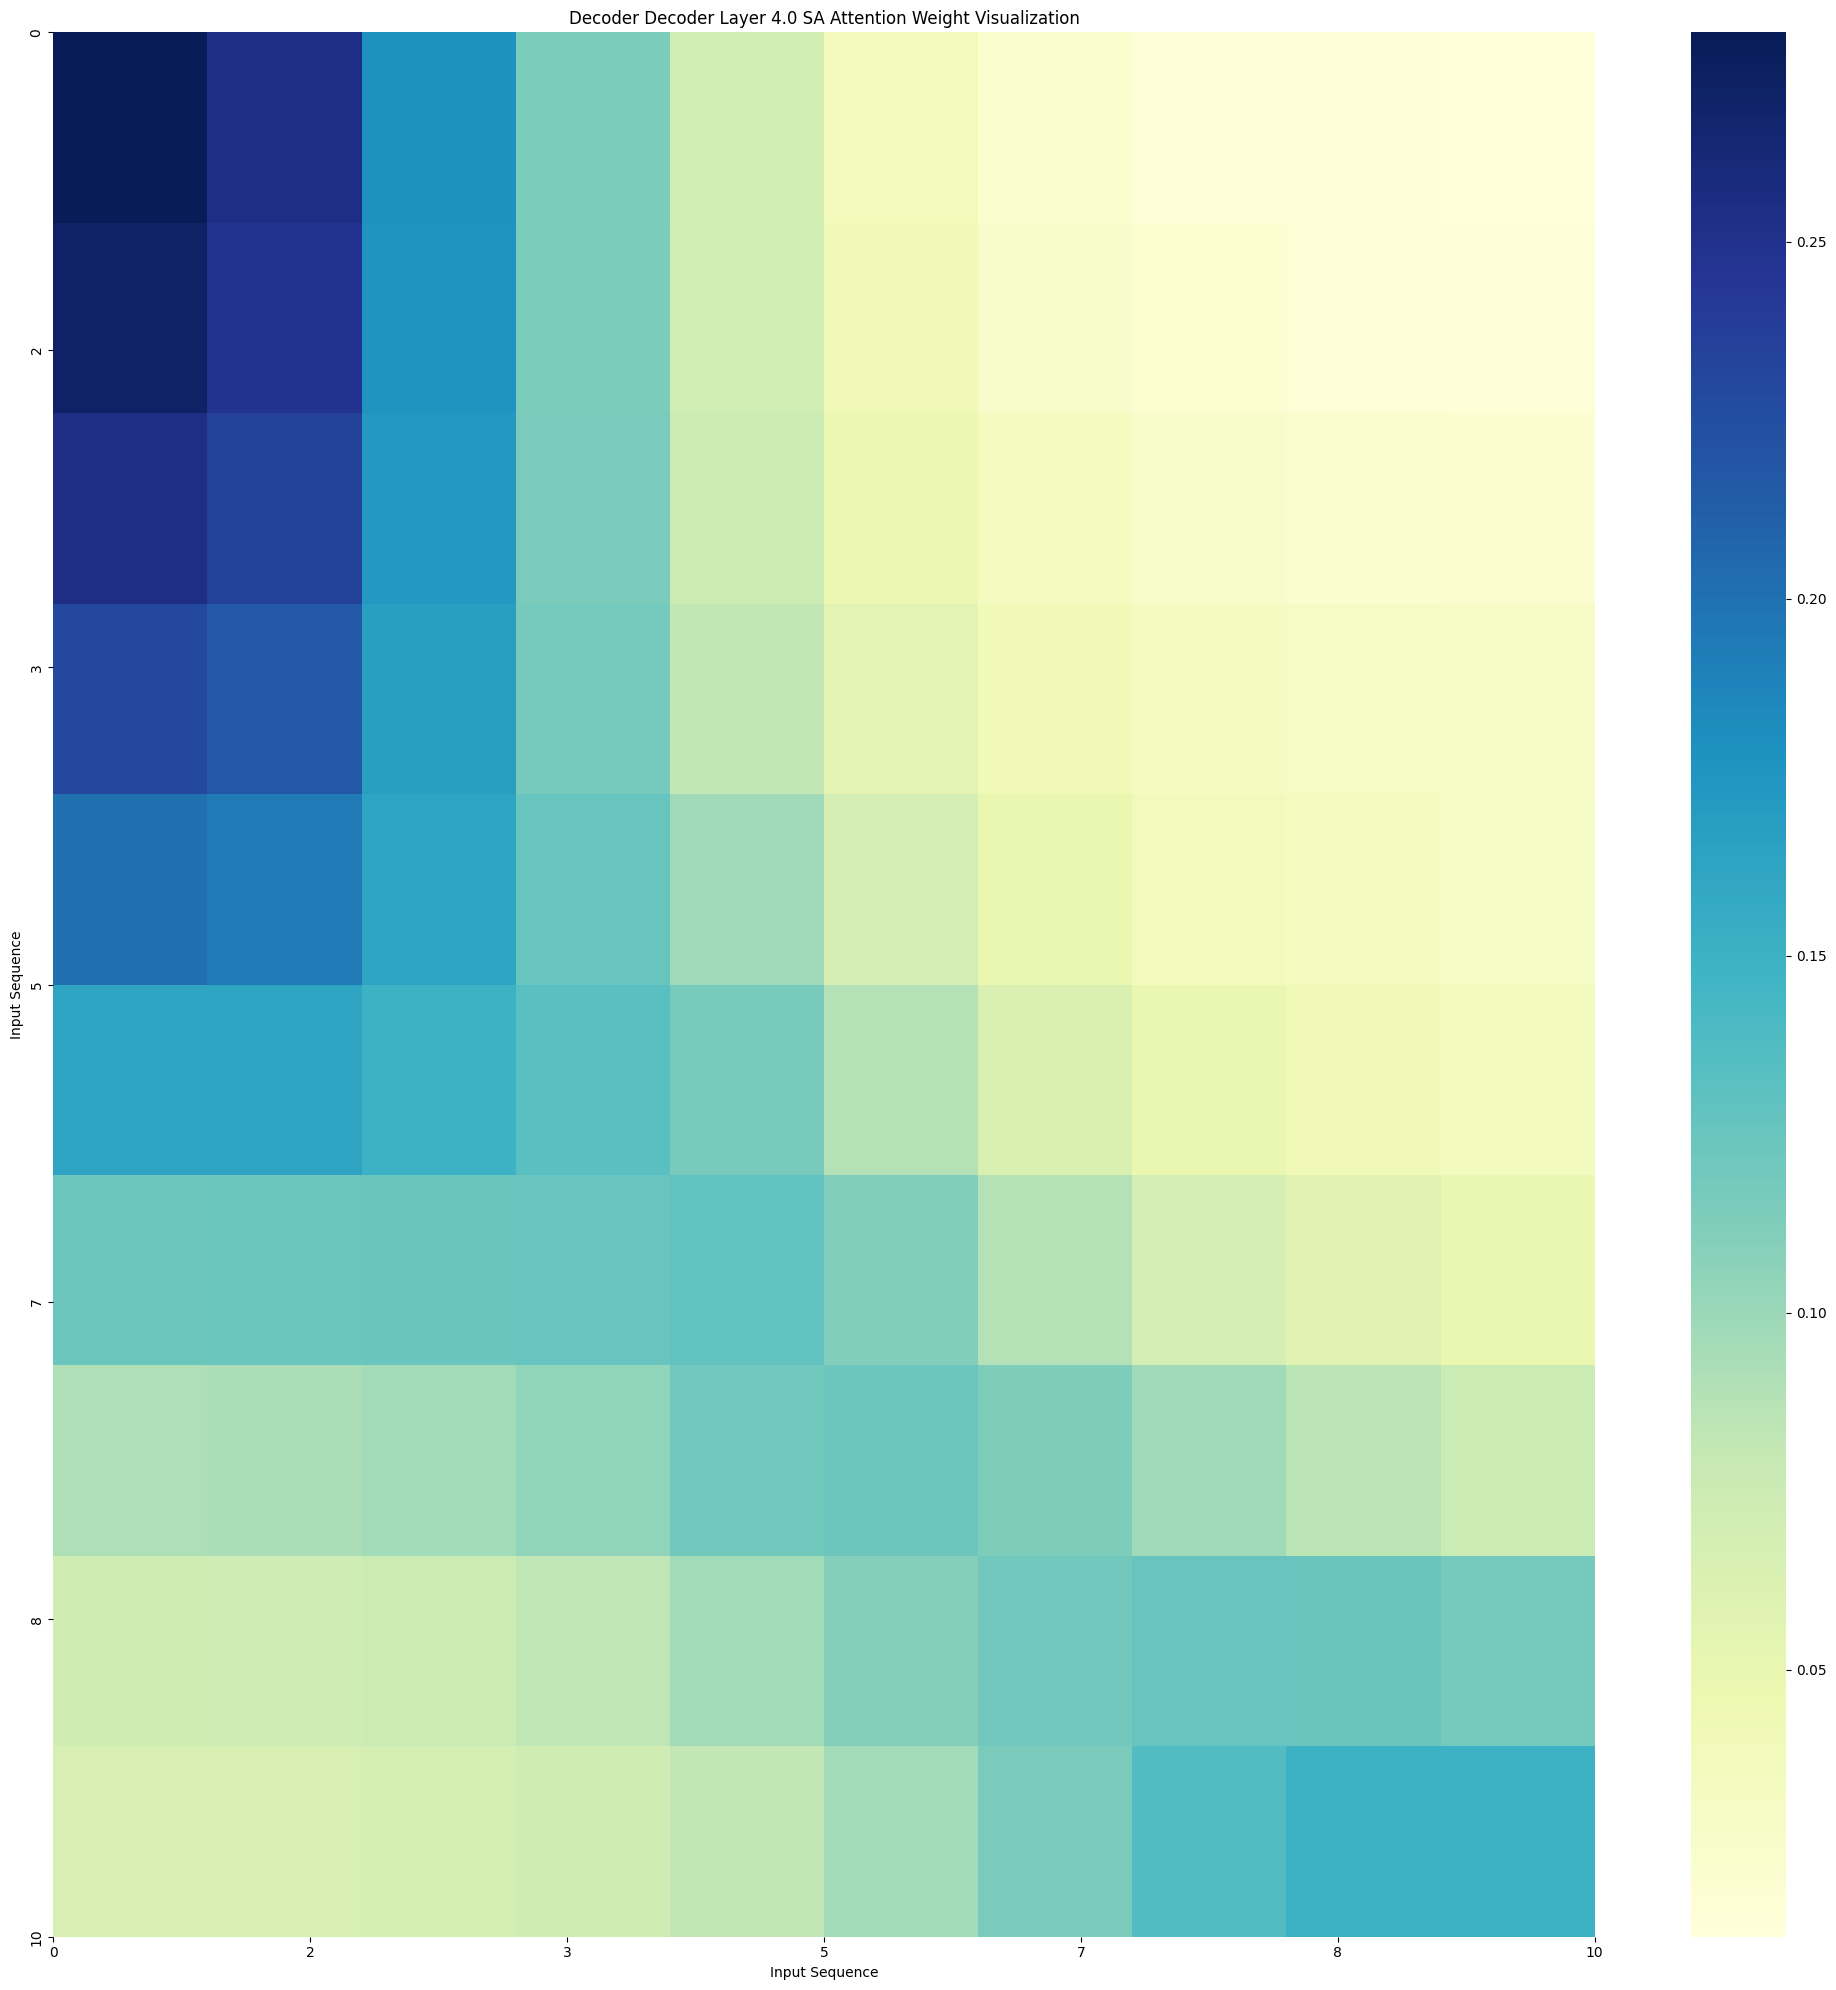

(10, 1)


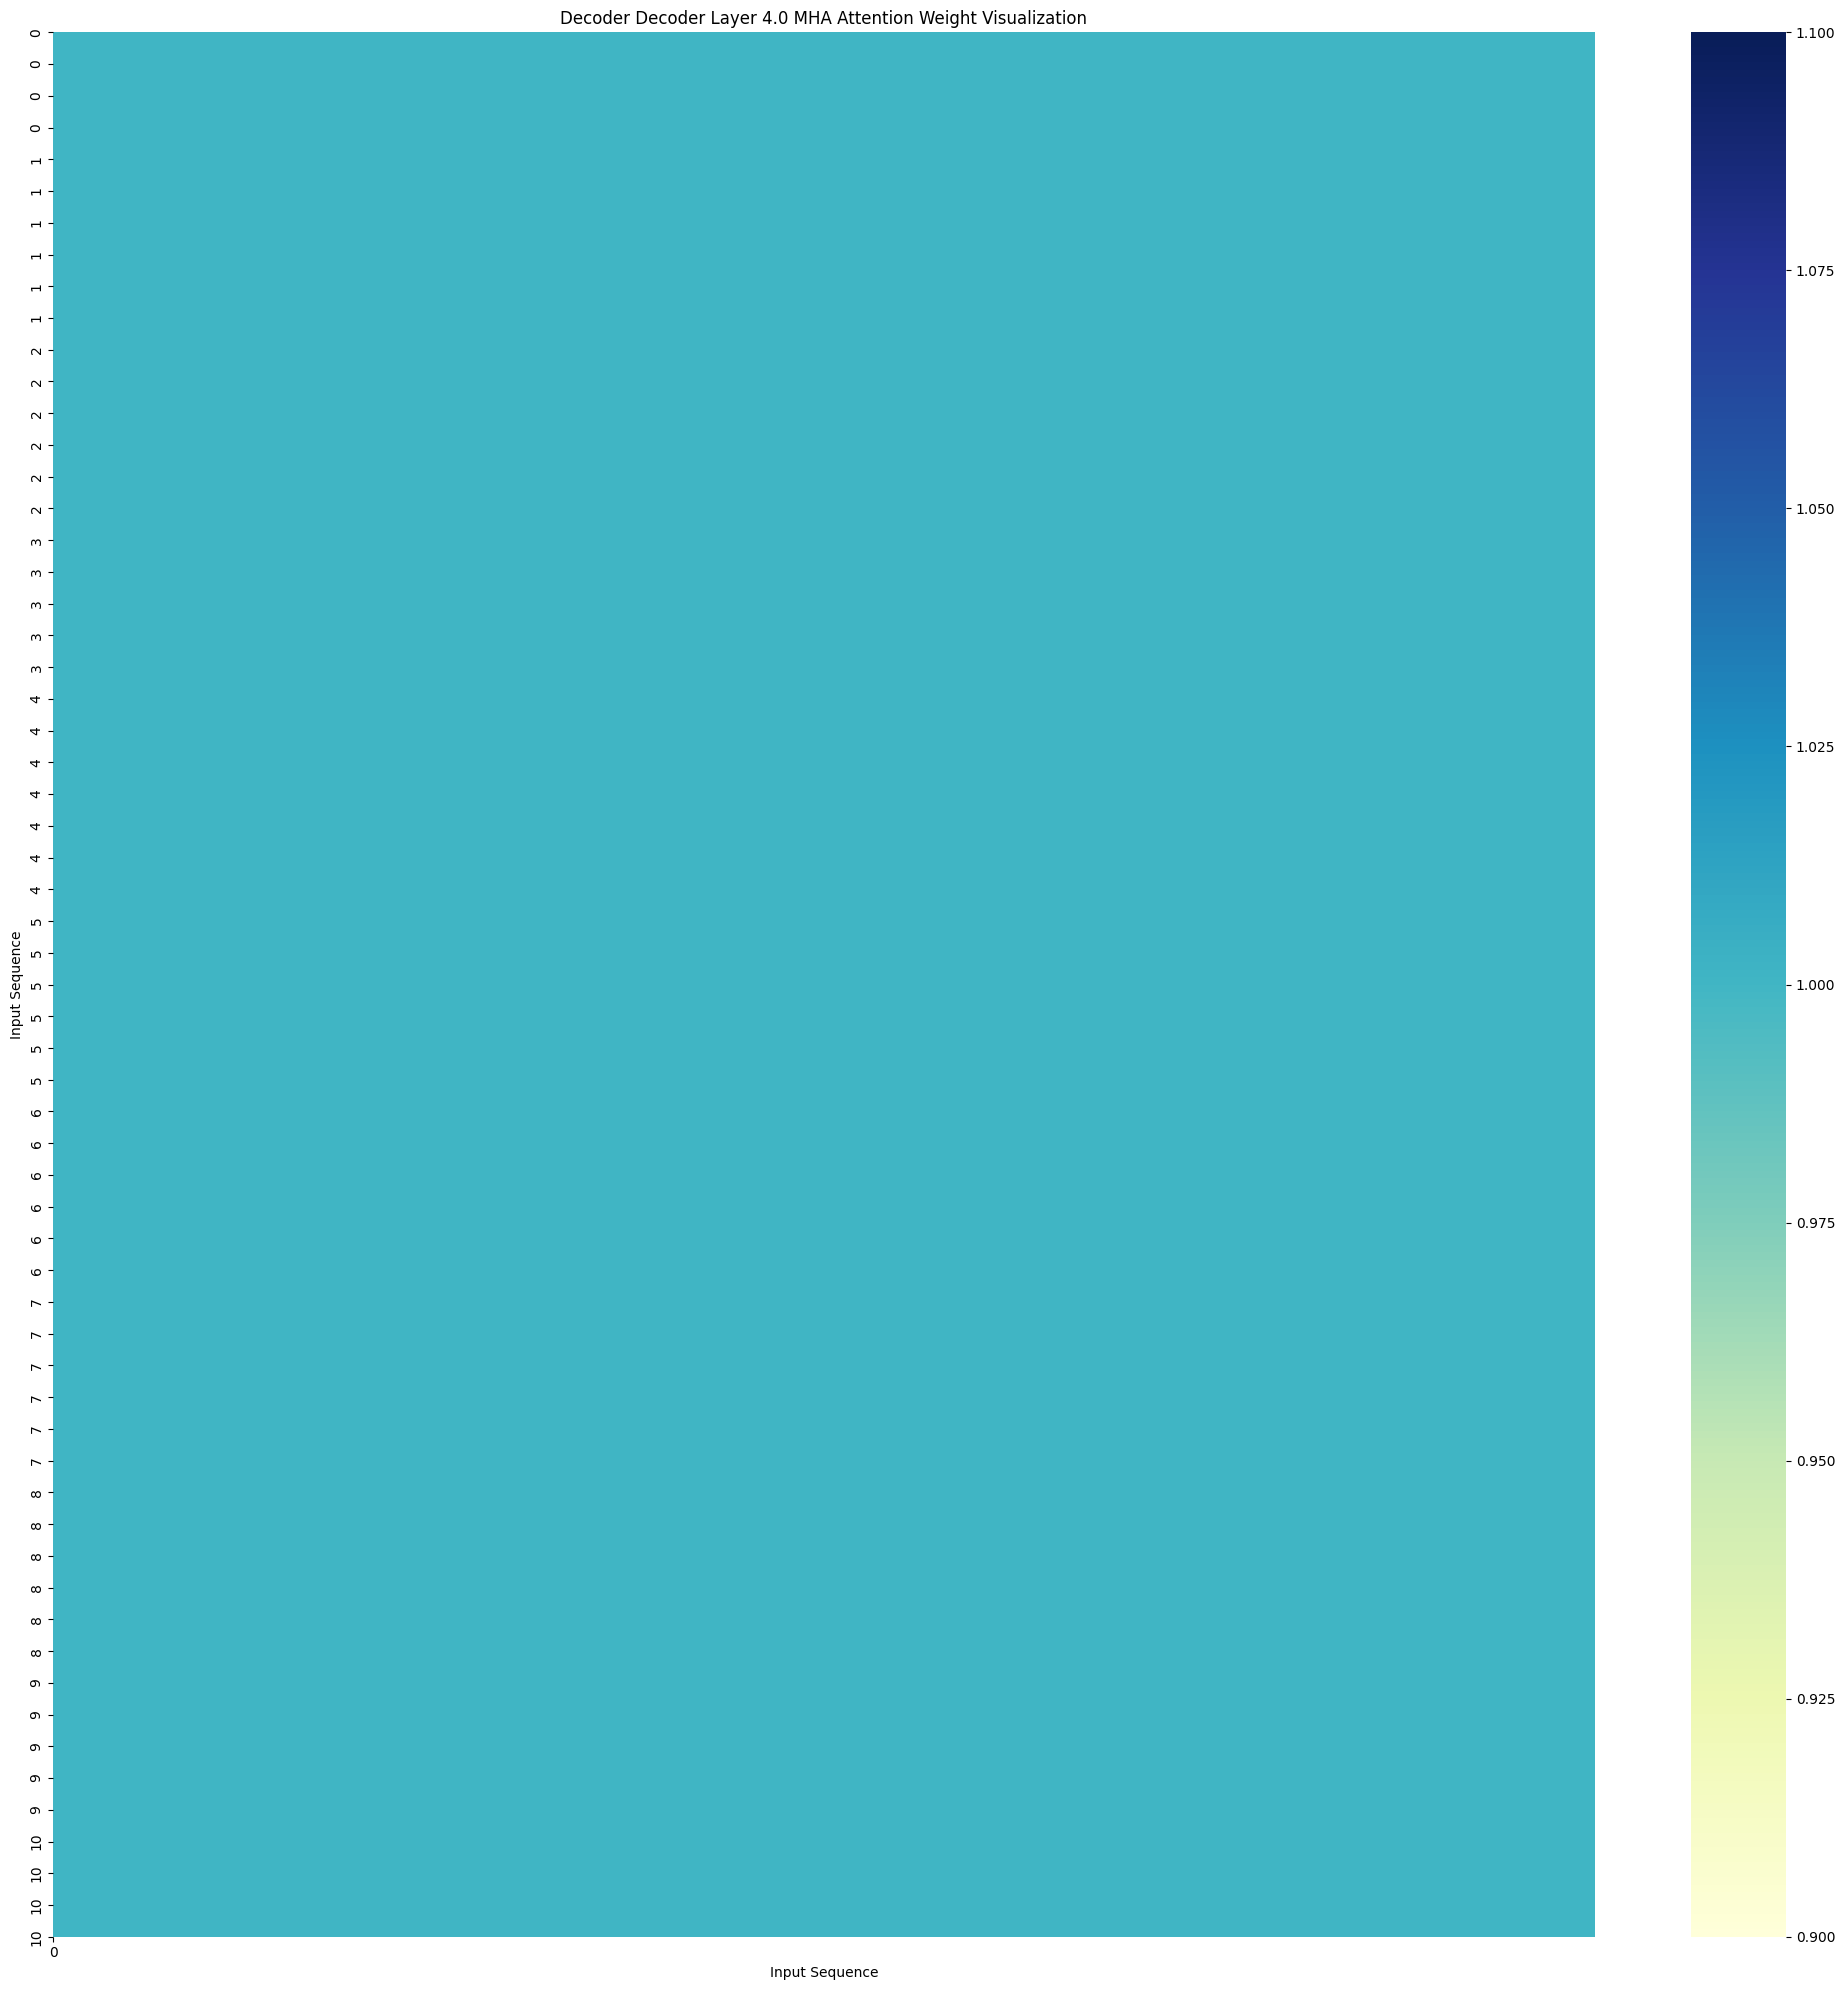

(10, 10)


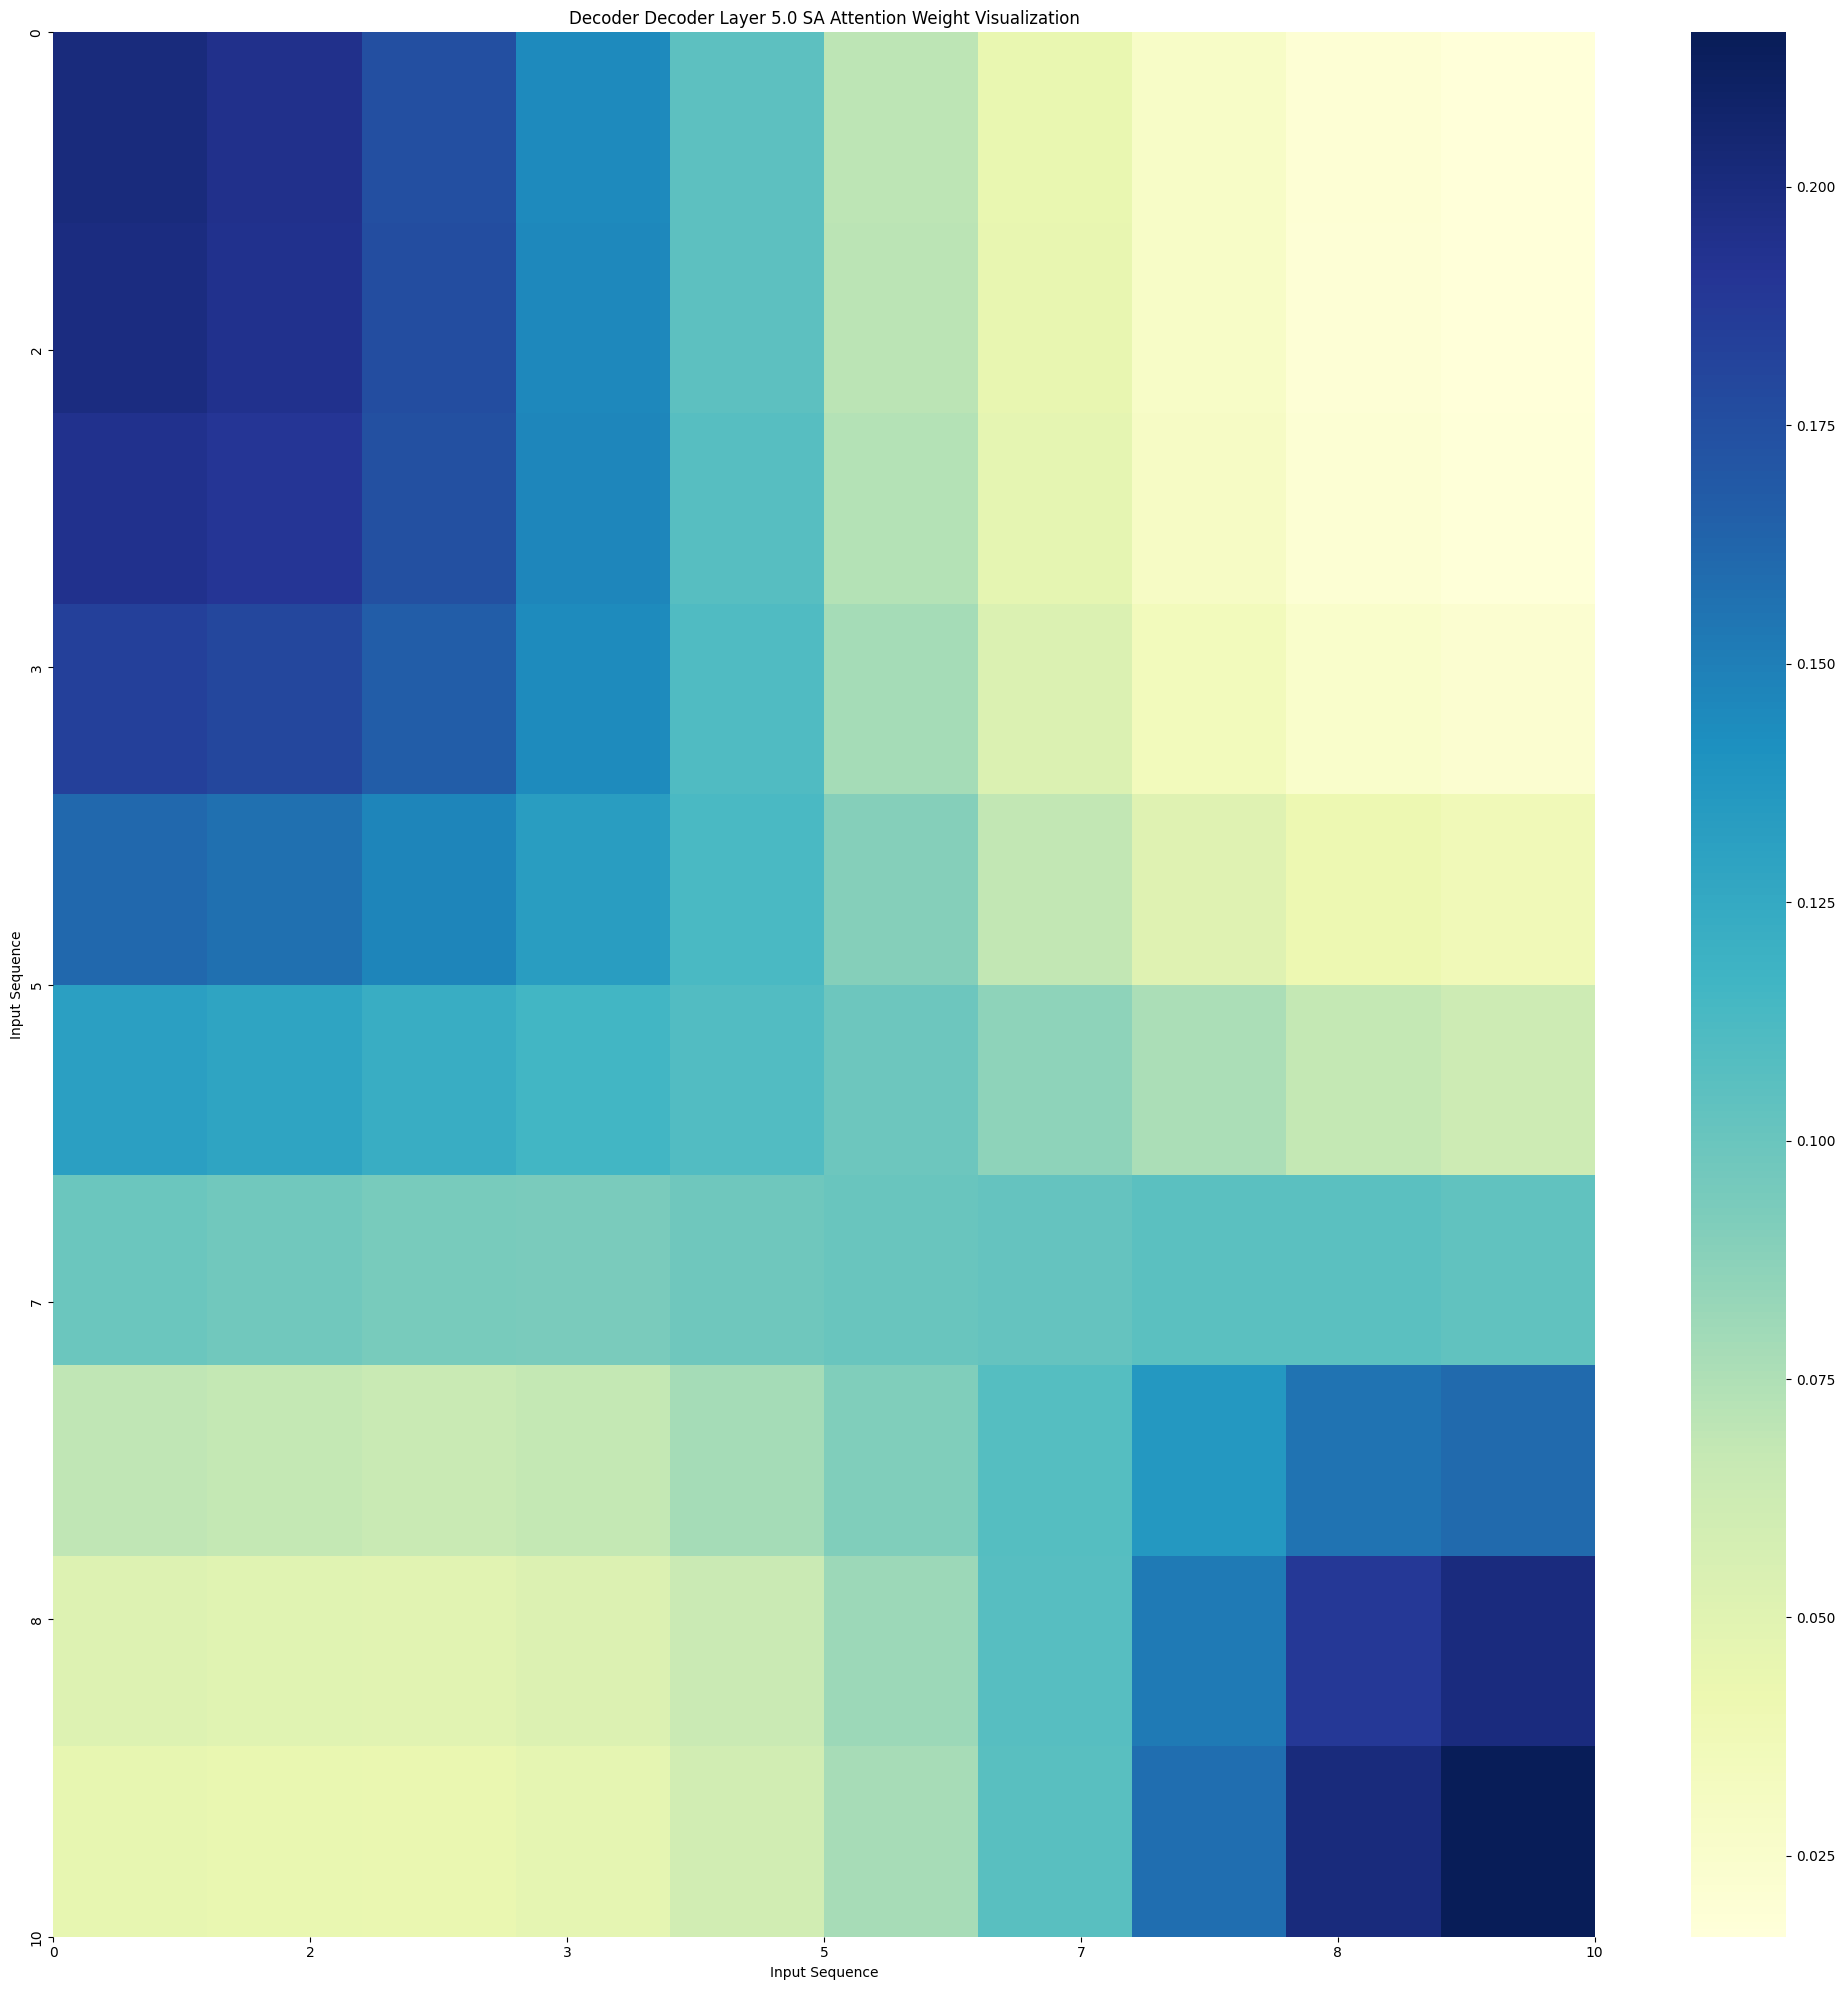

(10, 1)


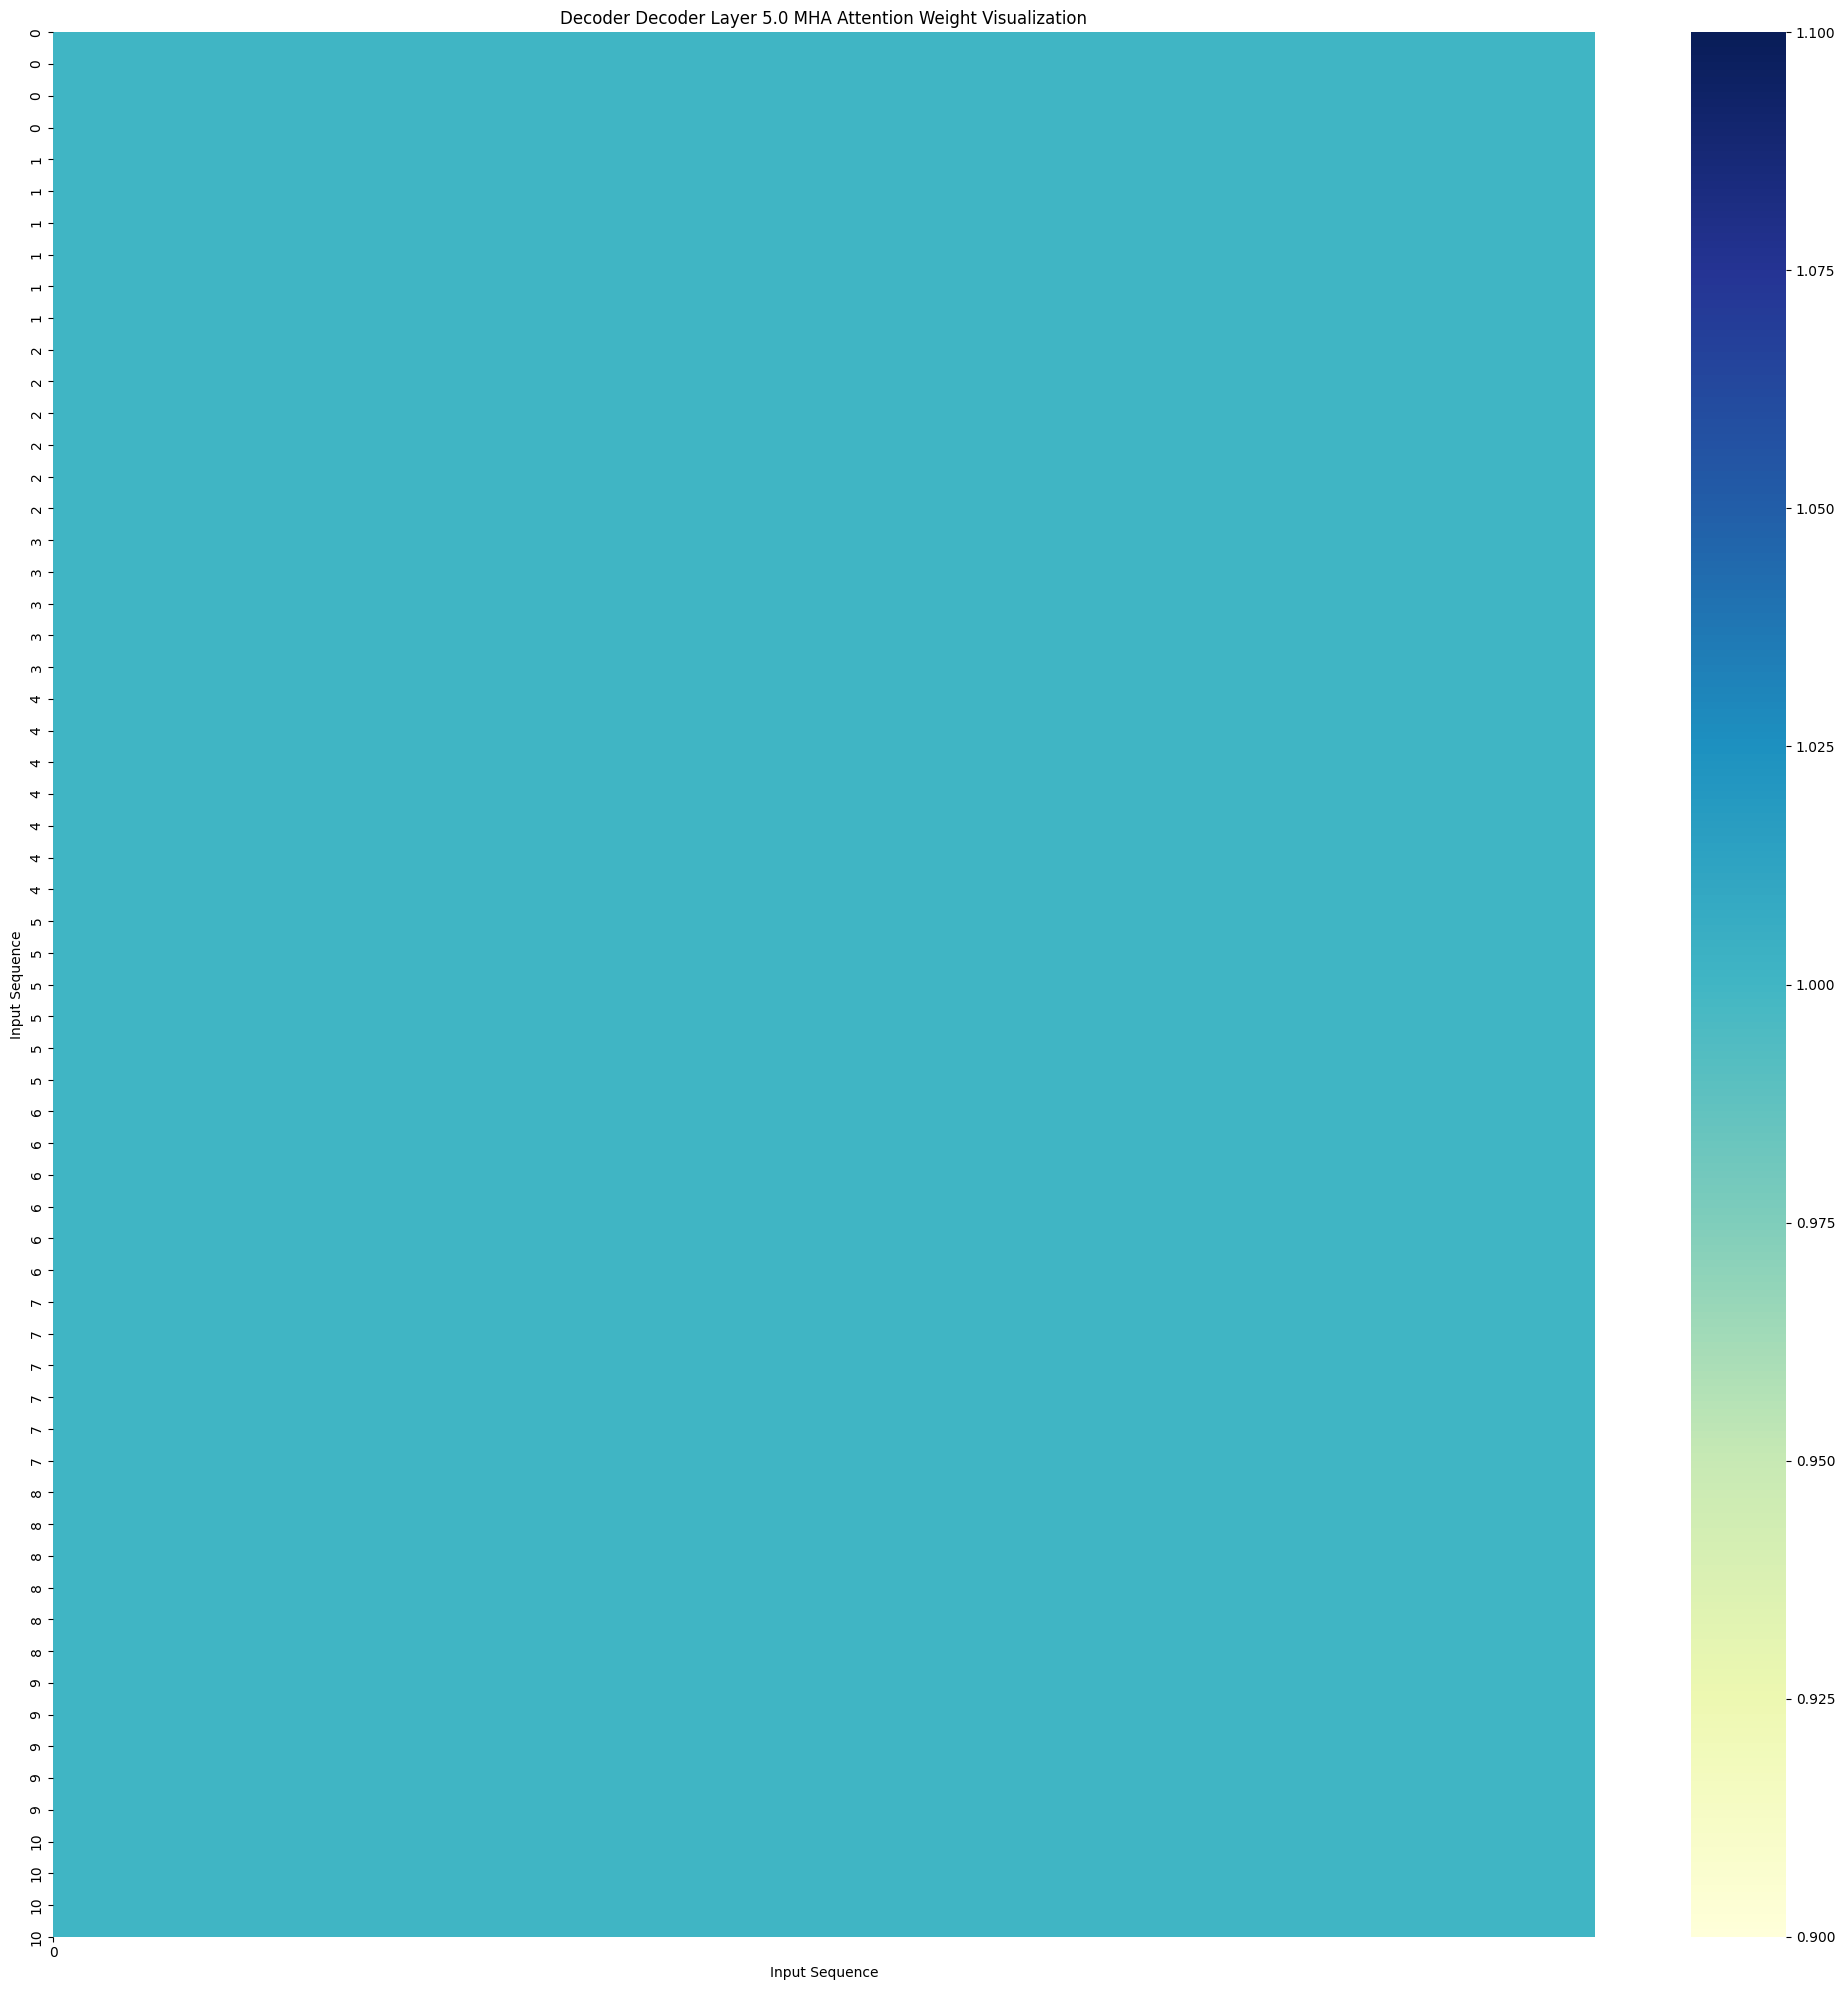

(10, 10)


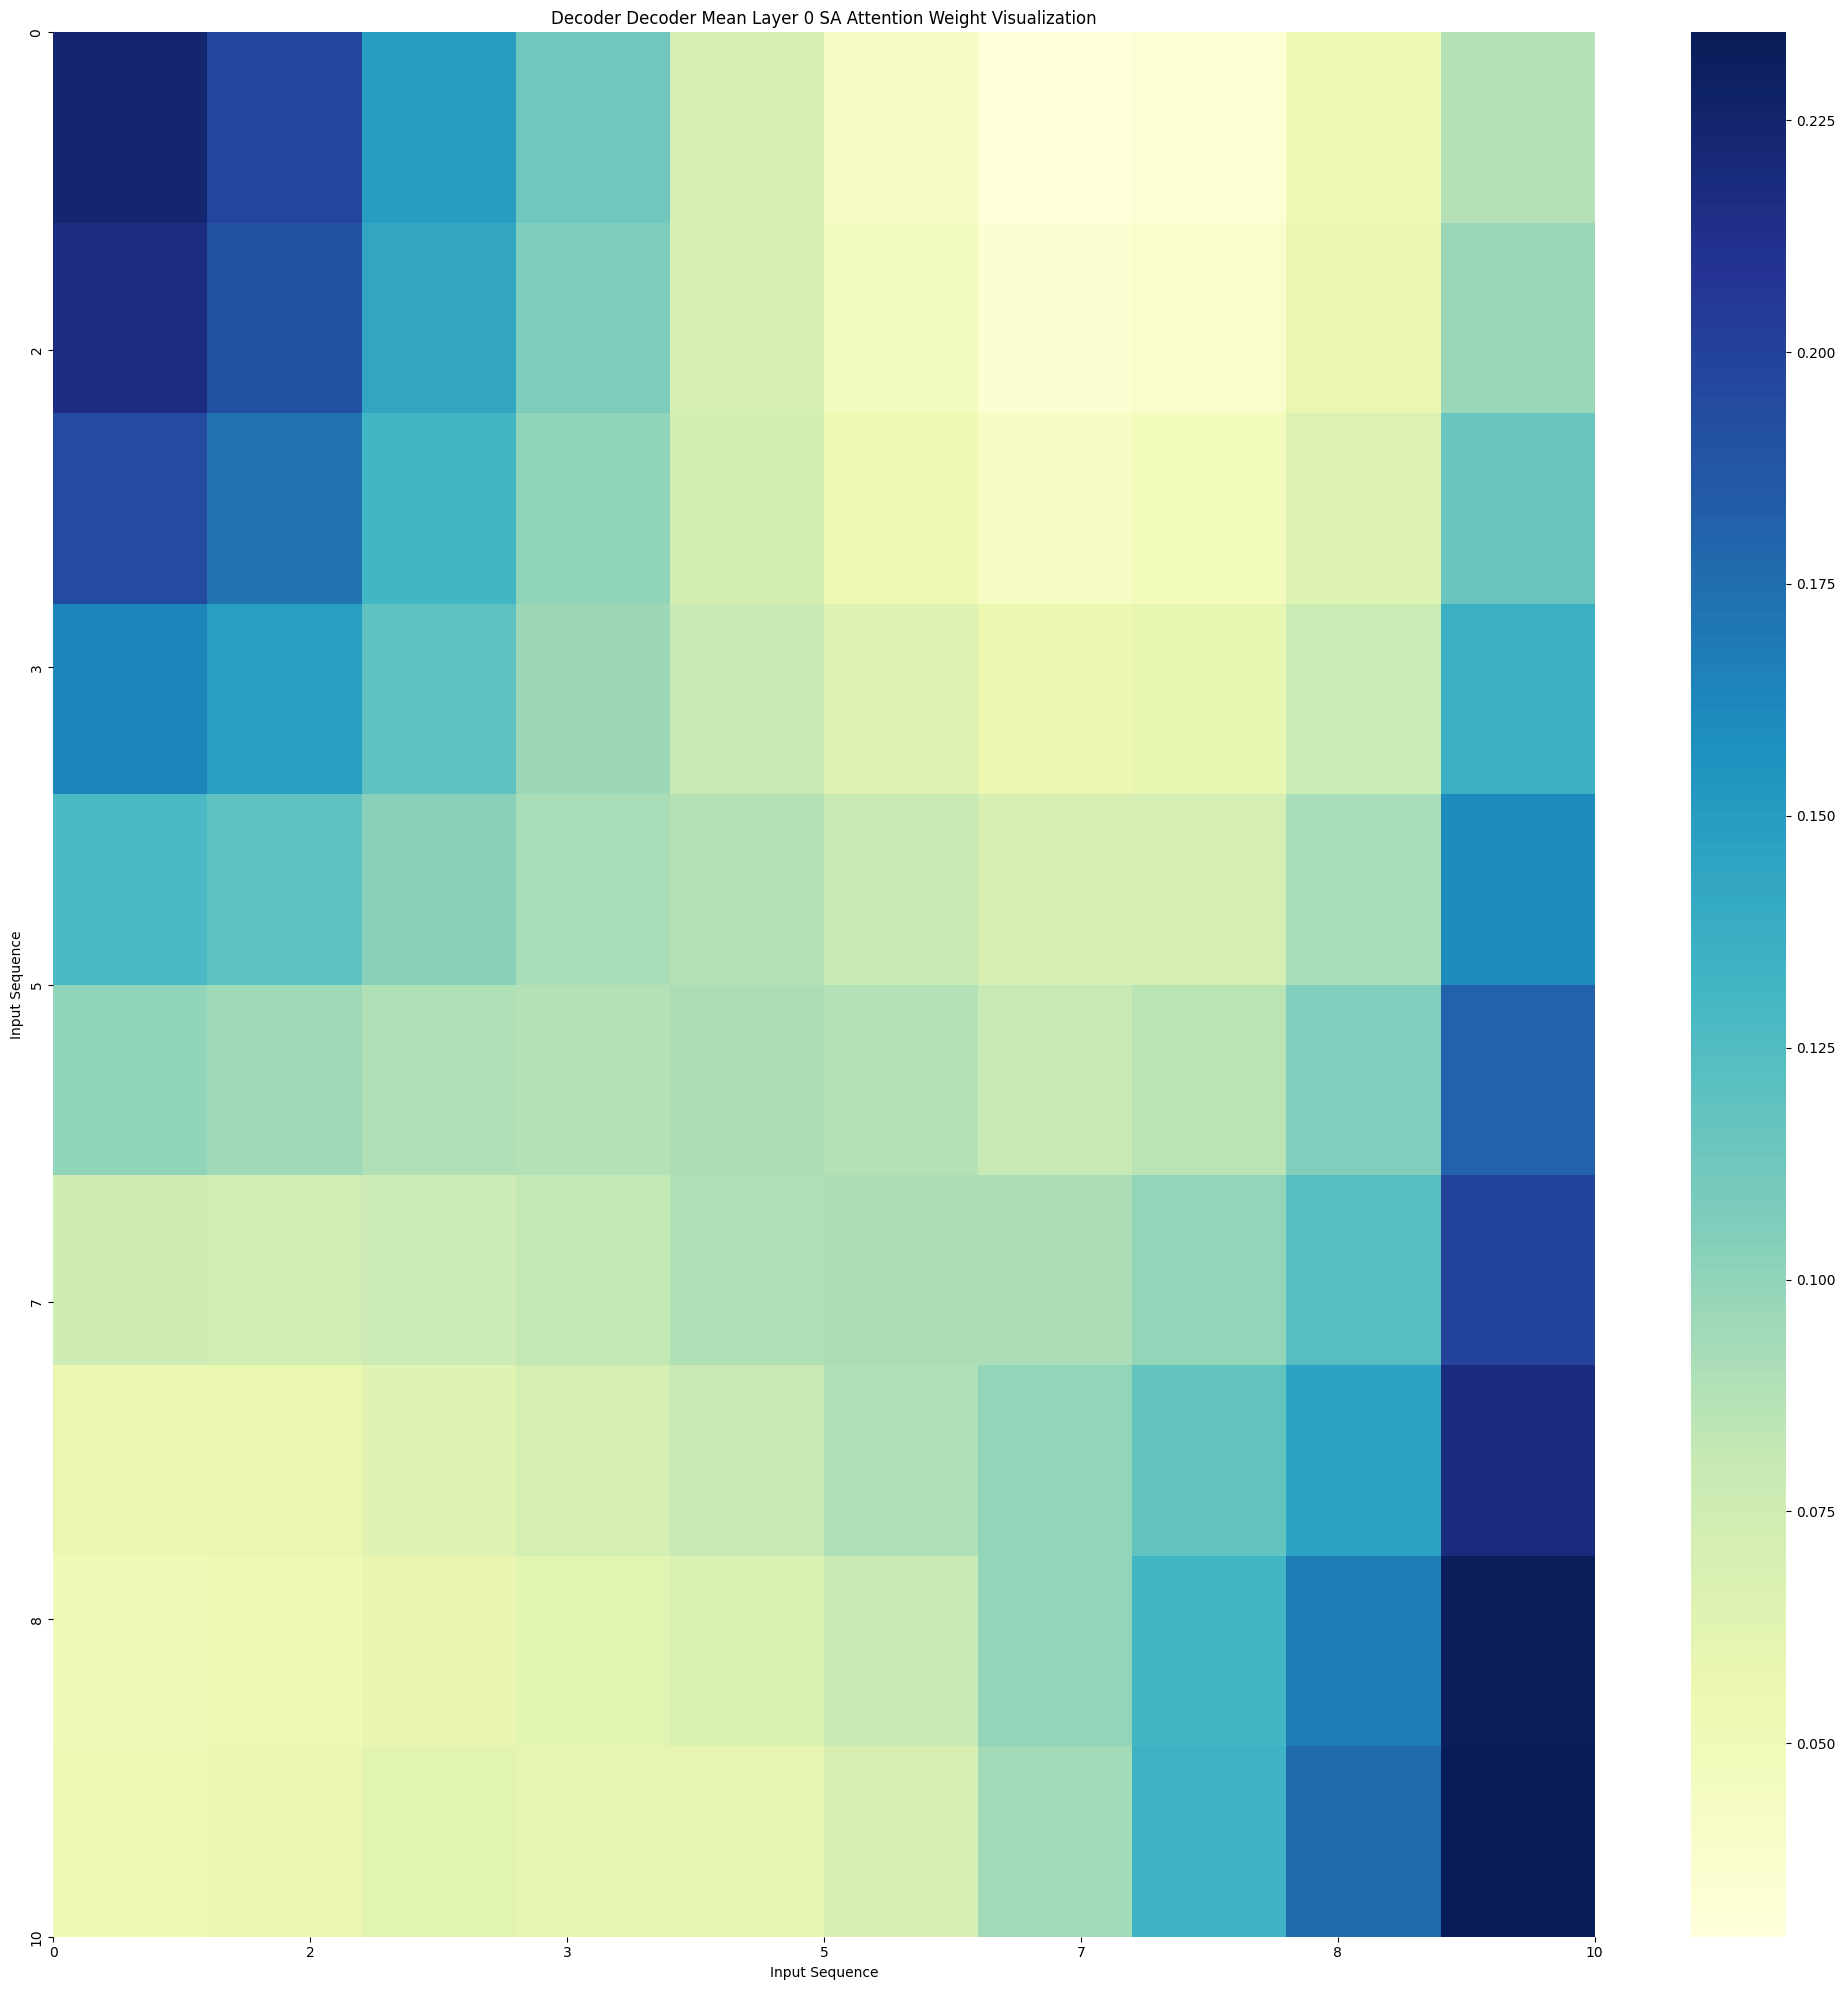

(10, 1)


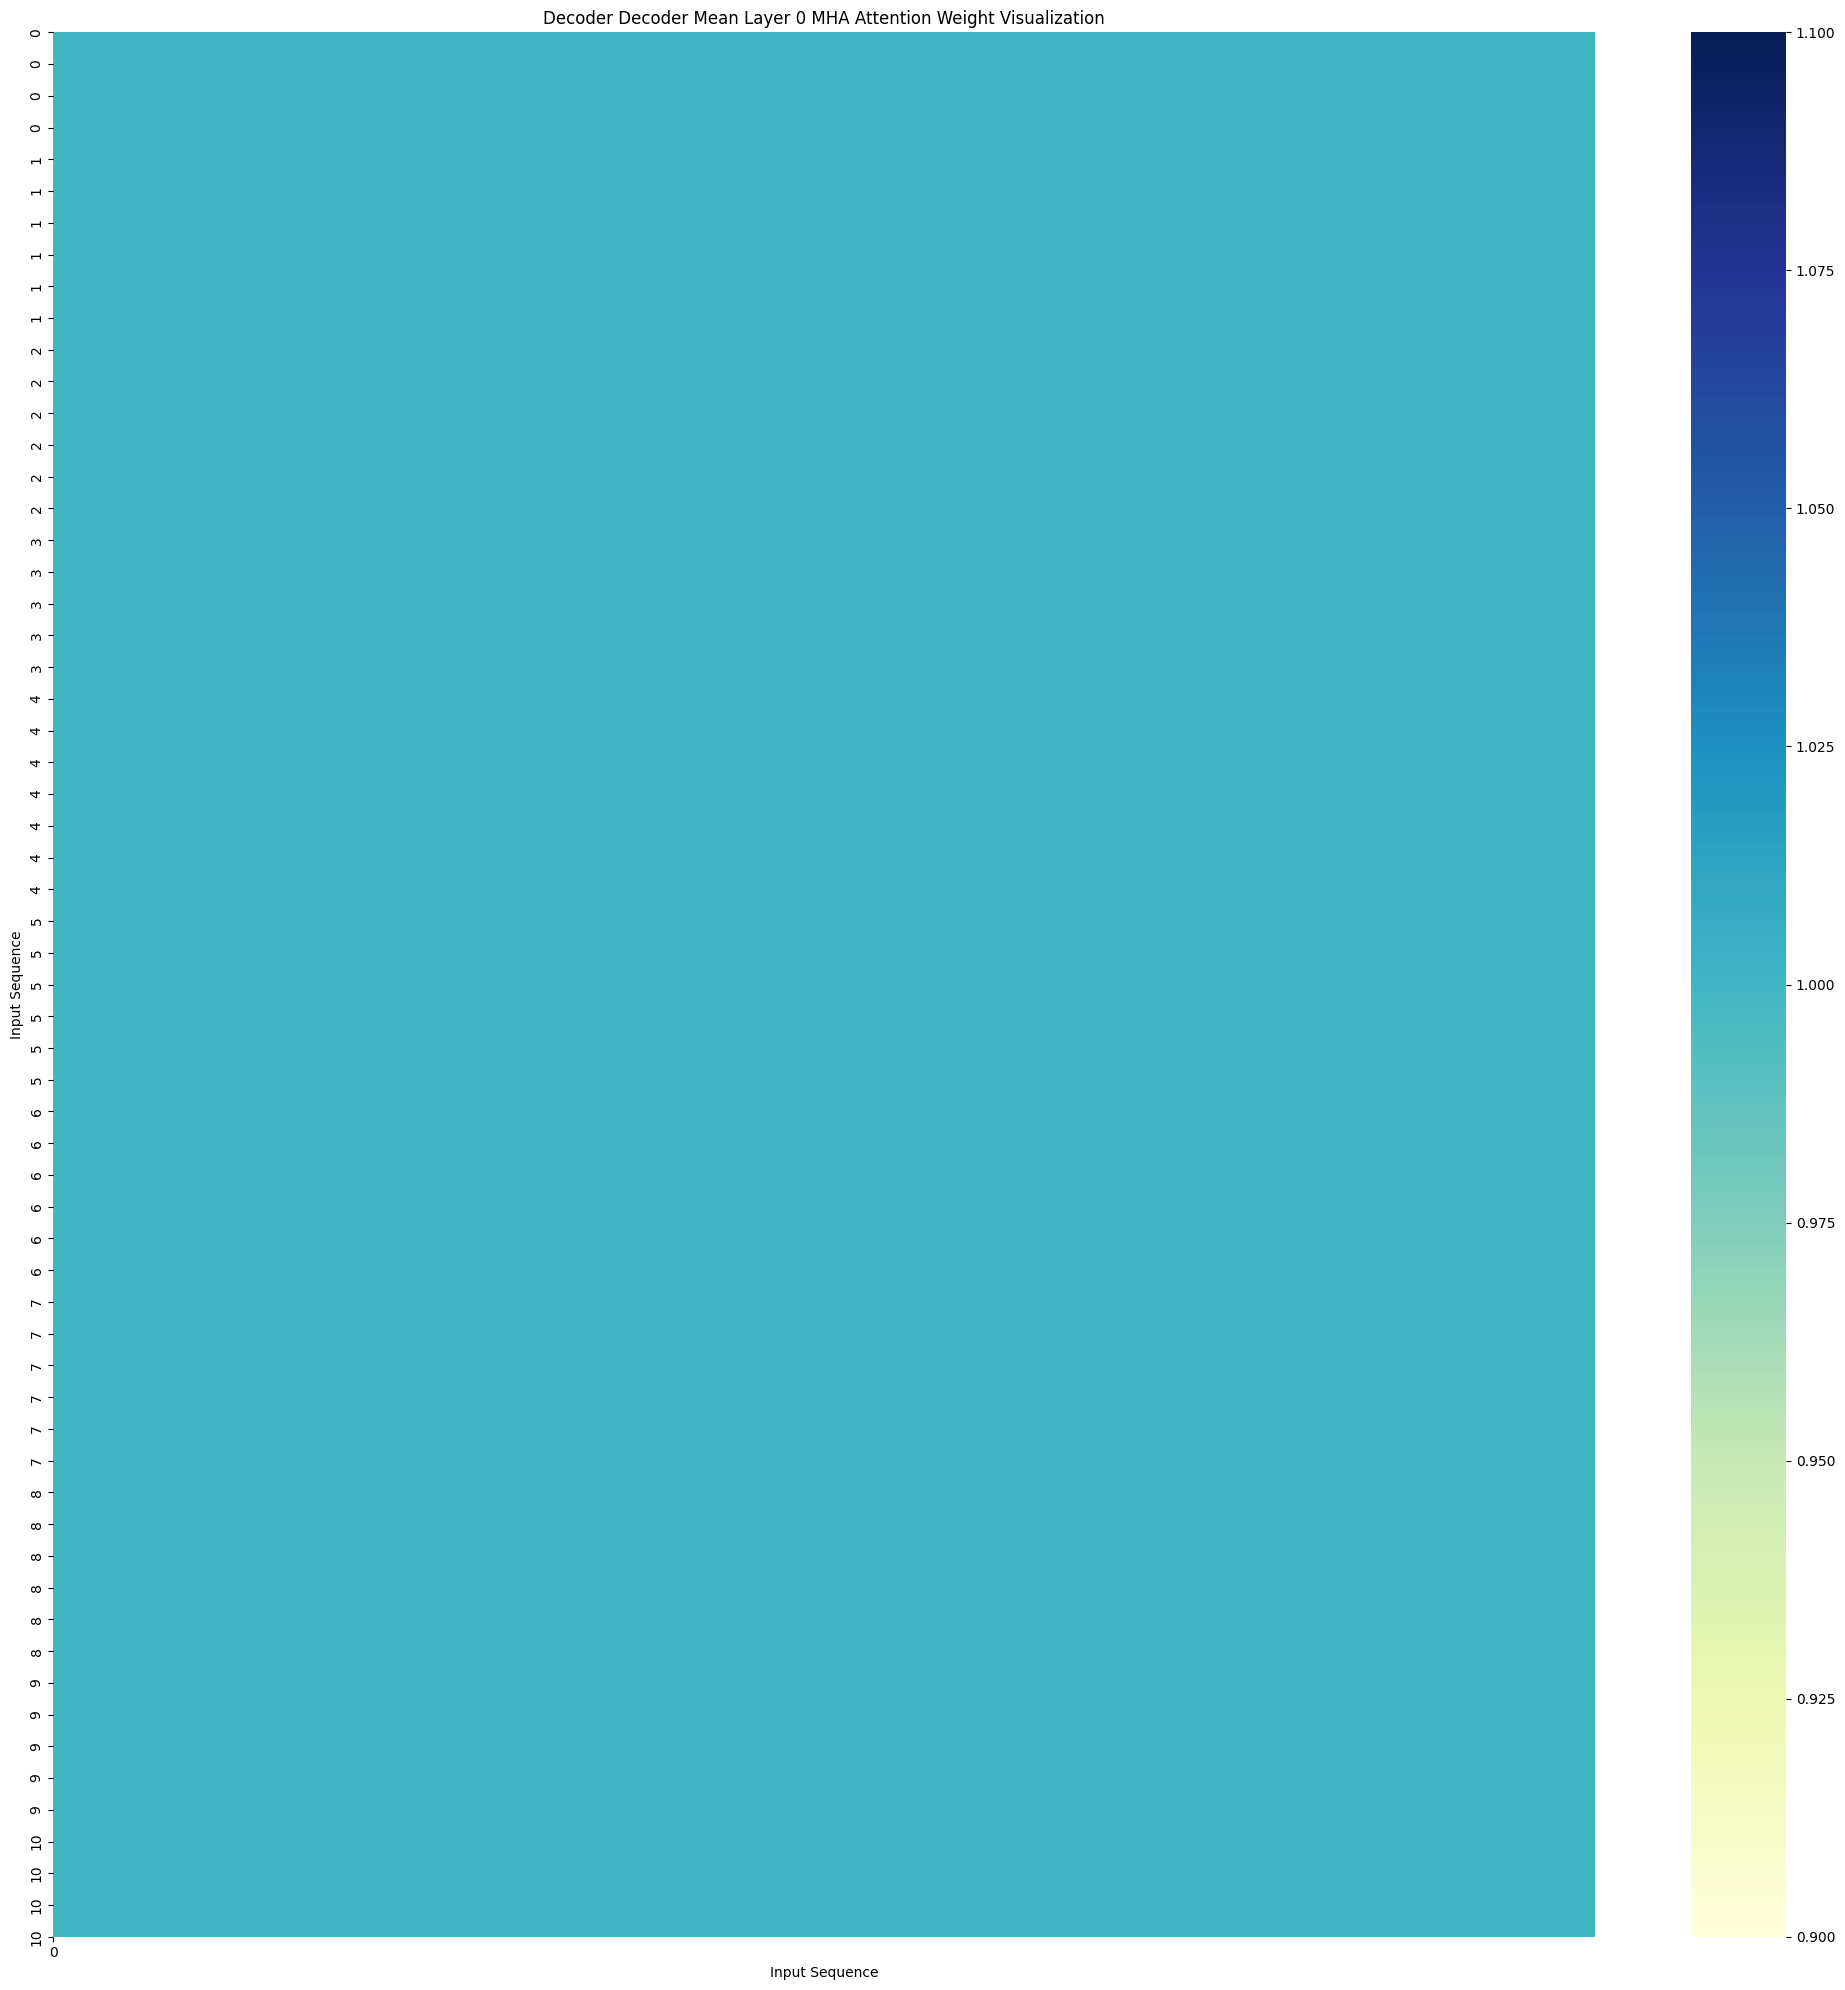

In [3]:
i = 20
data = train_dataset[i]

# with torch.no_grad():
out = model(data,use_precalc=True)

if cfg["method"] == "plan":
    for i, hook in enumerate(tf_enc_hooks):
        visualize_attention_weights(hook.attention_weights[0], "Transformer Encoder", i+1, hook.name)
    visualize_attention_weights(torch.mean(torch.stack([x.attention_weights[0] for x in tf_enc_hooks if x.name == "SA"], 0), 0), "Decoder Encoder Mean", 0, "SA")

    for i, hook in enumerate(tf_dec_hooks):
        visualize_attention_weights(hook.attention_weights[0], "Transformer Decoder", np.ceil((i+1)/2), hook.name)
    visualize_attention_weights(torch.mean(torch.stack([x.attention_weights[0] for x in tf_dec_hooks if x.name == "SA"], 0), 0), "Encoder Decoder Mean", 0, "SA")
    visualize_attention_weights(torch.mean(torch.stack([x.attention_weights[0] for x in tf_dec_hooks if x.name == "MHA"], 0), 0), "Encoder Decoder Mean", 0, "MHA")

# Visualize attention for each layer
for i, hook in enumerate(enc_enc_hooks):
    visualize_attention_weights(hook.attention_weights[0], "Encoder Encoder", i+1, hook.name)
visualize_attention_weights(torch.mean(torch.stack([x.attention_weights[0] for x in enc_enc_hooks if x.name == "SA"], 0), 0), "Decoder Encoder Mean", 0, "SA")

for i, hook in enumerate(enc_dec_hooks):
    visualize_attention_weights(hook.attention_weights[0], "Encoder Decoder", np.ceil((i+1)/2), hook.name)
    # visualize_attention(hook.attention[0], len(hook.inputs[0][0]), "Encoder Decoder", i+1, hook.name)
visualize_attention_weights(torch.mean(torch.stack([x.attention_weights[0] for x in enc_dec_hooks if x.name == "SA"], 0), 0), "Encoder Decoder Mean", 0, "SA")
visualize_attention_weights(torch.mean(torch.stack([x.attention_weights[0] for x in enc_dec_hooks if x.name == "MHA"], 0), 0), "Encoder Decoder Mean", 0, "MHA")

for i, hook in enumerate(dec_enc_hooks):
    visualize_attention_weights(hook.attention_weights[0], "Decoder Encoder", i+1, hook.name)
    # visualize_attention(hook.attention[0], len(hook.inputs[0][0]), "Decoder Encoder", i+1, hook.name)
visualize_attention_weights(torch.mean(torch.stack([x.attention_weights[0] for x in dec_enc_hooks if x.name == "SA"], 0), 0), "Decoder Encoder Mean", 0, "SA")

for i, hook in enumerate(dec_dec_hooks):
    visualize_attention_weights(hook.attention_weights[0], "Decoder Decoder", np.ceil((i+1)/2), hook.name)
    # visualize_attention(hook.attention[0], len(hook.inputs[0][0]), "Decoder Decoder", i+1, hook.name)    
visualize_attention_weights(torch.mean(torch.stack([x.attention_weights[0] for x in dec_dec_hooks if x.name == "SA"], 0), 0), "Decoder Decoder Mean", 0, "SA")
visualize_attention_weights(torch.mean(torch.stack([x.attention_weights[0] for x in dec_dec_hooks if x.name == "MHA"], 0), 0), "Decoder Decoder Mean", 0, "MHA")